In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import multiprocessing as multi
import warnings
import time
import re

import extra

from collections import Counter
from selenium import webdriver
from bs4 import BeautifulSoup
from user_agent import generate_user_agent
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from IPython.core.display import display, HTML

#display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings('ignore')

%matplotlib inline

In [262]:
data = pd.read_csv('main_task.csv')

Описание столбцов
1. Restaurant_id — идентификационный номер ресторана;
2. City — город, в котором находится ресторан;
3. Cuisine Style — стиль или стили, к которым можно отнести блюда, предлагаемые в ресторане;
4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. Price Range — диапазон цен в ресторане;
7. Number of Reviews — количество отзывов о ресторане;
8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
9. URL_TA — URL страницы ресторана на TripAdvosor;
10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [183]:
data.head(10)

Restaurant_id        City  \
0       id_5569       Paris   
1       id_1535   Stockholm   
2        id_352      London   
3       id_3456      Berlin   
4        id_615      Munich   
5       id_1418      Oporto   
6       id_1720       Milan   
7        id_825  Bratislava   
8       id_2690      Vienna   
9       id_4209        Rome   

                                       Cuisine Style  Ranking  Rating  \
0            ['European', 'French', 'International']   5570.0     3.5   
1                                                NaN   1537.0     4.0   
2  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...    353.0     4.5   
3                                                NaN   3458.0     5.0   
4  ['German', 'Central European', 'Vegetarian Fri...    621.0     4.0   
5                                                NaN   1419.0     3.0   
6                               ['Italian', 'Pizza']   1722.0     4.0   
7                                        ['Italian']    826.0     3.0   
8                                                NaN   2692.0     4.0   
9                  ['Italian', 'Pizza', 'Fast Food']   4210.0     4.0   

  Price Range  Number of Reviews  \
0    $$ - $$$              194.0   
1         NaN               10.0   
2        $$$$              688.0   
3         NaN                3.0   
4    $$ - $$$               84.0   
5         NaN                2.0   
6           $               50.0   
7         NaN                9.0   
8         NaN                NaN   
9           $               55.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   
5  [['There are better 3 star hotel bars', 'Amazi...   
6  [['Excellent simple local eatery.', 'Excellent...   
7  [['Wasting of money', 'excellent cuisine'], ['...   
8                                           [[], []]   
9  [['Clean efficient staff', 'Nice little pizza ...   

                                              URL_TA      ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...   d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...   d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...   d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...   d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...   d6864963  
5  /Restaurant_Review-g189180-d12503536-Reviews-D...  d12503536  
6  /Restaurant_Review-g187849-d5808504-Reviews-Pi...   d5808504  
7  /Restaurant_Review-g274924-d3199765-Reviews-Ri...   d3199765  
8  /Restaurant_Review-g190454-d12845029-Reviews-G...  d12845029  
9  /Restaurant_Review-g187791-d8020681-Reviews-Qu...   d8020681

In [178]:
# посмотрим на заполнение стобцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


9283 строки не содержат информацию о стиле/стилях кухни ресторанов (23,2% от количества объектов), 13886 строк не содержат информацию о диапазоне цен (34,7%), 2543 строки не содержат информации о количестве отзывов (6,3%)

Посмотрим на значения диапазона цен и рейтинга

In [27]:
print('Price range values = {}'.format(data['Price Range'].unique()))
print('Rating interval = {}'.format(data['Rating'].value_counts(bins=1).index[0]))
print('Rating values = {}'.format(data['Rating'].unique()))

Price range values = ['$$ - $$$' nan '$$$$' '$']
Rating interval = (0.995, 5.0]
Rating values = [ 3.5  4.   4.5  5.   3.   2.5  2.   1.   1.5]


##  Задание

<b>Из постановки задачи: мы должны использовать в модели датафрейм, содержащий только количественные признаки и не содержащий None-значений. На первом этапе для создания такого датафрейма давайте просто удалим столбцы, содержащие данные типа object, и заполним пропущенные значения (None или NaN) каким-то одним значением (нулём или средним арифметическим) для  всего столбца.<b>

Таким образом, удалим столбцы типа object, убедимся, что количество отзывов и место ресторана - целые значения и заполним нолями пропуски в столбце количества отзывов. Сохраним все в отдельную переменную task_df 

In [43]:
# проверим, что количество отзывов и места - целые числа
number_of_reviews = data['Number of Reviews'].dropna().apply(lambda x: x.is_integer())
ranking = data['Ranking'].dropna().apply(lambda x: x.is_integer())

print(number_of_reviews.unique(), ranking.unique())

[ True] [ True]


In [9]:
task_df = data.drop(labels=['Restaurant_id','City','Cuisine Style','Price Range','Reviews','URL_TA','ID_TA'], axis=1).fillna(0)

In [24]:
# Убедимся, что не осталось пропущенных значений
values = task_df.isnull().values
values[values == True].size

0

In [25]:
# Итоговый датафрейм
task_df.head()

Ranking  Rating  Number of Reviews
0   5570.0     3.5              194.0
1   1537.0     4.0               10.0
2    353.0     4.5              688.0
3   3458.0     5.0                3.0
4    621.0     4.0               84.0

Применим базовую модель из ноутбука you_first_model

In [37]:
X = task_df.iloc[:, [0, 2]]
y = task_df.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [38]:
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.4316716077380952


Метрика MAE приняла значение 0.43. Учитывая, что рейтинг изменяется в интервале от 1 до 5 с шагом 0.5 (Rating values = [ 3.5  4.   4.5  5.   3.   2.5  2.   1.   1.5]), отклонение получилось довольно существенным. Очевидно, что нужно вводить больше признаков.

### Дополнительные данные и функции для обработки данных 

In [129]:
SITE = 'https://www.tripadvisor.com'
NOT_CAPITALS = ["Munich", "Oporto", "Milan", "Barcelona", "Zurich", "Lyon", "Hamburg", "Geneva", "Krakow"]
CITIES = data['City'].unique()

In [130]:
# Данные по количеству жителей в городах. Информация взята с Википедии. Значения взяты в тысячах человек

population_values = [2190, 961, 8908, 3645, 1471, 237, 1378, 426, 1897, 2876, 1634, 3165, 1173, 179, 428, 1783, 1752, 615, 857, 506, 1841, 505, 1301, 673, 643, 488, 200, 284, 664, 115, 769]
POPULATION = dict.fromkeys(CITIES, 0)

for key, value in zip(POPULATION.keys(), population_values):
    POPULATION[key] = value

In [131]:
# рейтинг популярности городов среди туристов по данным консалтиногого агентства "Euromonitor"
# источник данных датафрейма https://go.euromonitor.com/white-paper-travel-2019-100-cities.html#download-link
# источник в вики https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors

tourism_arrivals_19 = [19087.9, 2721.9, 19559.9, 6195.8, 4205.5, 2491.7, 6604.4, np.nan, 6634.7, 10317.0, 7016.6, 5597.8, 5462.1, 4276.0, np.nan, 2827.0, 4025.4, 3185.6, 8835.4, np.nan, np.nan, 3639.9, 9150.9, np.nan, np.nan, np.nan, np.nan, np.nan, 6301.3, np.nan, 2910.0]
tourism_arrivals_18 = [17560.2, 2604.6, 19233.0, 5959.4, 4066.6, 2341.3, 6481.3, np.nan, 6410.3, 10065.4, 6714.5, 5440.1, 5213.4, 3942.0, 6100.0, 2732.0, 3822.8, 3069.7, 8354.2, np.nan, np.nan, 3539.4, 8948.6, np.nan, np.nan, np.nan, np.nan, np.nan, 5728.4, np.nan, 2850.0]
tourism_arrivals_17 = [15834.2, 2473.5, 19828.0, 5627.4, 3829.2, 2232.5, 6347.9, np.nan, 6186.4, 9531.6, 6288.9, 5273.1, 4986.5, 3430.0, 5700.0, 2630.0, 3654.0, 2963.7, 7848.0, np.nan, np.nan, 3522.8, 8806.7, np.nan, np.nan, np.nan, np.nan, np.nan, 4797.4, np.nan, 2800.0]

ARRIVALS_17 = dict.fromkeys(CITIES, 0)
ARRIVALS_18 = dict.fromkeys(CITIES, 0)

for key, value in zip(ARRIVALS_17.keys(), tourism_arrivals_17):
    ARRIVALS_17[key] = value
    
for key, value in zip(ARRIVALS_18.keys(), tourism_arrivals_18):
    ARRIVALS_18[key] = value

In [132]:
# для ресторанов, у которых отсутсвуют типы кухонь будем считать, что в каждом таком ресторане подаются как минимум блюда
# национальной кухни. Например для ресторанов в Париже - французская кухня, в Лондоне - британская. Плюс для некоторых
# стран можно добавить определенные типы кухонь, связанные с географией или национальным блюдом, или выходом к морю или океану

ADDITIONAL_CUISINES = dict.fromkeys(CITIES)

cuisines_values = [
    ['French'],
    ['Swedish', 'Scandinavian'],
    ['British', 'Pub'],
    ['German'],
    ['German'],
    ['Portuguese', 'Seafood'],
    ['Italian', 'Pizza'],
    ['Central European'],
    ['Austrian'],
    ['Italian', 'Pizza', 'Mediterranean'],
    ['Spanish', 'Mediterranean'],
    ['Spanish'],
    ['Irish'],
    ['Belgian'],
    ['Swiss', 'Central European'],
    ['Polish', 'Eastern European'],
    ['Hungarian', 'Central European'],
    ['Danish'],
    ['Dutch'],
    ['French'],
    ['German'],
    ['Portuguese', 'Seafood'],
    ['Czech', 'Central European'],
    ['Norwegian', 'Scandinavian'],
    ['Scandinavian'],
    ['Scottish'],
    ['Swiss', 'Central European'],
    ['Slovenian', 'Central European'],
    ['Greek', 'Mediterranean'],
    ['European'],
    ['Polish', 'Eastern European']
]

for key, value in zip(ADDITIONAL_CUISINES.keys(), cuisines_values):
    ADDITIONAL_CUISINES[key] = value

In [133]:
# Преобразование строкового представления списка в list (для признака "стили кухни")
def cuisines_to_list(string):
    if isinstance(string, list):
        return string
    
    return [s.strip("\'") for s in string.strip('[]').split(', ')]

In [134]:
# Преобразование ценового диапазона в числовое представление
def price_range_to_number(string):
    if string == '$':
        return 1
    if string == '$$ - $$$':
        return 2
    if string == '$$$$':
        return 3
    
    return 0

In [135]:
# Извлечение дат из значений признака Reviews
def get_dates(string):
    #if np.isnan(string):
    #    string = '[[], []]'
    # [0-9|/]+
    pattern = re.compile('[0-9]{2}/[0-9]{2}/[0-9]{4}')
    dates = pattern.findall(string)
    
    if dates == []:
        return [np.nan] * 2
    elif len(dates) == 1:
        return dates + [np.nan]
    
    return dates

In [136]:
# Определяем, расположен ли ресторан в столичном городе (для нового признака Capital)
def is_restaurant_in_capital(item):
    if item in NOT_CAPITALS:
        return 0
    
    return 1

In [137]:
# Признак нахождения города ресторана в топе стран по посещаемости туритсами
# Источник https://en.wikipedia.org/wiki/World_Tourism_rankings
def is_city_of_top_tourism_country(city):
    if city in ['Paris', 'Lyon', 'Madrid', 'Barcelona', 'Rome', 'Milan', 'Berlin', 'Munich', 'London', 'Vienna', 'Athens', 'Lisbon', 'Oporto']:
        return 1
    
    return 0

In [138]:
# Функция заполнения недостающих значений признака Number of Reviews средним по городу, в котором находится ресторан
def mean_number_of_reviews_per_city(df):
    filtered_df = df[df['Number of Reviews'].isnull()]
    reviews_means = []
    
    for item in range(filtered_df.shape[0]):
        reviews_means.append(int(df[df['City'] == filtered_df.iloc[item]['City']]['Number of Reviews'].mean()))
    
    return pd.Series(data=reviews_means, index = filtered_df.index)

In [139]:
# Преобразование строкового представления списков в list (для признака Reviews)
def reviews_to_list(string, dates=False):
    pattern = re.compile('\'[^\']+\'')
    reviews = [word[1:-1] for word in pattern.findall(string)]
    
    if reviews == []:
        return [np.nan] * 2
    
    if dates:
        return reviews[-2:] if len(reviews) == 4 else [reviews[-1], np.nan]
    else:
        return reviews[:2] if len(reviews) == 4 else [reviews[0], np.nan]

In [408]:
# Сбор данных о ценовом диапазоне с сайта tripadvisor для дозаполнения пропущенных значений 
def get_price_range_from_site(df):
    result = pd.Series()
    pattern = re.compile('\$\$ - \$\$\$|\$+')
    local_df = df.copy()
    filtered_df = local_df[local_df['Price Range'].isnull()]
    print('shape = {}'.format(filtered_df.shape[0]))
    indexes = filtered_df['Price Range'].index
    prs = []
    
    for i in range(filtered_df.shape[0]):
        time.sleep(2)
        try:
            response = requests.get(SITE + filtered_df.iloc[i]['URL_TA'])
        except Exception as err:
            print('Caught exception')
            print(err)
            prs = prs + [np.nan]
            #print('common = {}'.format(prs))
            continue
        
        page = BeautifulSoup(response.text, 'html.parser')
        string = page.find(class_='header_links')
        print('#{} url = {}\nstring = {}'.format(i + 1, filtered_df.iloc[i]['URL_TA'], string))
        
        if string is None:
            prs = prs + [np.nan]
            #print('common = {}'.format(prs))
            continue
        
        pr = pattern.findall(string.text)
        print('pr = {}\n'.format(pr))
        
        if pr != []:
            filtered_df.iloc[i]['Price Range'] = pr[0]
            prs = prs + pr
            #print('common = {}'.format(prs))
        else:
            prs = prs + [np.nan]
            #print('common = {}'.format(prs))
            continue
    
    return pd.Series(prs, index=indexes)

In [409]:
# Сбор данных о типах кухонь с сайта tripadvisor для дозаполнения пропущенных значений 
def get_additioinal_cuisines(df, all_cuisines):
    #pattern = re.compile('\$\$ - \$\$\$|\$+')
    local_df = df.copy()
    filtered_df = local_df[local_df['Cuisine Style'].isnull()]
    print('shape = {}'.format(filtered_df.shape[0]))
    indexes = filtered_df['Cuisine Style'].index
    cs = []
    
    for i in range(filtered_df.shape[0]):
        time.sleep(2)
        try:
            response = requests.get(SITE + filtered_df.iloc[i]['URL_TA'])
        except Exception as err:
            print('Caught exception')
            print(err)
            cs = cs + [np.nan]
            #print('common = {}'.format(cs))
            continue
            
        page = BeautifulSoup(response.text, 'html.parser')
        string = page.find(class_='header_links')
        print('#{} url = {}\nstring = {}'.format(i + 1, filtered_df.iloc[i]['URL_TA'], string))
        
        if string is None:
            cs = cs + [np.nan]
            #print('common = {}'.format(cs))
            continue
        
        temp = []
        for item in all_cuisines:
            if item in string.text:
                temp.append(item)
                
        print('temp = {}'.format(temp))
        if temp != []:
            #filtered_df.iloc[i]['Price Range'] = pr[0]
            cs.append(temp)
            #print('common = {}'.format(cs))
        else:
            cs = cs + [np.nan]
            #print('common = {}'.format(cs))
            continue
        
    return pd.Series(cs, index=indexes)

In [140]:
def MAE(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

## Наполнение выборки данными 

In [12]:
# Сколько городов представлено в наборе данных?
data['City'].nunique()

31

In [8]:
data['City'].unique()

array(['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow'], dtype=object)

In [11]:
# Сколько ресторанов расположены в столичных городах?
data.query('City not in ["Munich", "Oporto", "Milan", "Barcelona", "Zurich", "Lyon", "Hamburg", "Geneva", "Krakow"]').shape[0]

30424

In [160]:
# Сколько типов кухонь представлено в наборе данных?
all_cuisines = set()

for cuisine in data['Cuisine Style'].dropna():
    all_cuisines.update(cuisines_to_list(cuisine))

#all_cuisines = set([cuisine[1:-1] for cuisine in all_cuisines])
len(all_cuisines)

125

In [142]:
# Какая кухня представлена в наибольшем количестве ресторанов? Введите название кухни без кавычек или апострофов.
c = Counter()

for cuisines in data['Cuisine Style'].dropna():
    for cuisine in cuisines.strip('[]').split(', '):
        c[cuisine.strip("\'")] += 1
        
print(c)

Counter({'Vegetarian Friendly': 11189, 'European': 10060, 'Mediterranean': 6277, 'Italian': 5964, 'Vegan Options': 4486, 'Gluten Free Options': 4113, 'Bar': 3297, 'French': 3190, 'Asian': 3011, 'Pizza': 2849, 'Spanish': 2798, 'Pub': 2449, 'Cafe': 2325, 'Fast Food': 1705, 'British': 1595, 'International': 1584, 'Seafood': 1505, 'Japanese': 1464, 'Central European': 1393, 'American': 1315, 'Sushi': 1156, 'Chinese': 1145, 'Portuguese': 1107, 'Indian': 1041, 'Middle Eastern': 782, 'Thai': 743, 'Wine Bar': 697, 'German': 662, 'Healthy': 620, 'Greek': 604, 'Halal': 598, 'Czech': 595, 'Fusion': 577, 'Steakhouse': 573, 'Barbecue': 555, 'Contemporary': 523, 'Vietnamese': 513, 'Eastern European': 496, 'Soups': 494, 'Grill': 490, 'Gastropub': 471, 'Mexican': 445, 'Turkish': 444, 'Delicatessen': 392, 'Austrian': 380, 'South American': 372, 'Polish': 365, 'Hungarian': 352, 'Scandinavian': 342, 'Lebanese': 329, 'Latin': 302, 'Diner': 295, 'Dutch': 294, 'Irish': 284, 'Belgian': 270, 'Street Food': 26

In [43]:
# Какое среднее количество кухонь предлагается в одном ресторане?
# Если в данных отсутствует информация о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. 
# Ответ округлите до одного знака после запятой.

cuisines = data.loc[:, 'Cuisine Style'].fillna('[Vegetarian Friendly]')
cuisines = cuisines.apply(lambda x: cuisines_to_list(x))

cuisines_in_all_restaurants = []

for cuisine in cuisines:
    cuisines_in_all_restaurants.append(len(cuisine))

print(np.mean(cuisines_in_all_restaurants))

2.6224


In [143]:
# Подготовка датафрейма дат отзывов. Для этого вытащим списки дат из строк отзывов столбца Reviews
# По наблюдению, дата первого отзыва находится на второй позиции, второго - на первой позиции
# Каждый элемент списка кладем в свой Series, объединяем в датафрем, переводим в тип datetime

reviews = data.loc[:, 'Reviews']
reviews_dates = reviews.apply(lambda x: get_dates(x))

dates_df = pd.concat([pd.Series([date[1] for date in reviews_dates]),
                      pd.Series([date[0] for date in reviews_dates])], axis=1)

dates_df.columns = ['FRDate', 'SRDate']
dates_df['FRDate'] = pd.to_datetime(dates_df['FRDate'])
dates_df['SRDate'] = pd.to_datetime(dates_df['SRDate'])

# Вычисляем разницу по дням между отзывами, пропуски для наблюдений, у которых нет отзывов и дат, заполним нулями 
dates_df['Days Delta'] = dates_df['SRDate'] - dates_df['FRDate']
dates_df['Days Delta'] = dates_df['Days Delta'].apply(lambda x: x.days)
dates_df['Days Delta'].fillna(0, inplace=True)
dates_df[dates_df['Days Delta'] == dates_df['Days Delta'].max()]

FRDate     SRDate  Days Delta
7990 2007-12-22 2016-10-02      3207.0

In [144]:
# Когда был оставлен самый свежий отзыв?
print(dates_df['FRDate'].max(), dates_df['SRDate'].max())

2018-02-26 00:00:00 2018-02-26 00:00:00


Итак, наполним основной датафрейм данными. Для начала попробуем сделать запрос на сайт TripAdvisor и для ресторанов, у которых нет ценового диапазона, получить его. Тоже самое сделаем для типов кухонь.

In [64]:
%timeit
t_df = data.copy()
pr = get_price_range_from_site(t_df)

shape = 13886
#1 url = /Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a>, Nepali</div>
pr = ['$$ - $$$']

#2 url = /Restaurant_Review-g187323-d1358776-Reviews-Esplanade-Berlin.html
string = None
#3 url = /Restaurant_Review-g189180-d12503536-Reviews-Dick_s_Bar-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = ['$$ - $$$']

#4 url = /Restaurant_Review-g274924-d3199765-Reviews-Ristorante_Italiano_San_Cono-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Res

#33 url = /Restaurant_Review-g1136488-d5599563-Reviews-Le_Chalet_de_la_Foret-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=8">$$$$</a>, <a href="/Restaurants-g1136488-c20-Uccle_Brussels.html">French</a>, <a href="/Restaurants-g1136488-c18-Uccle_Brussels.html">European</a></div>
pr = ['$$$$']

#34 url = /Restaurant_Review-g187265-d7623654-Reviews-Creperie_Caramel_Sale-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a>, <a href="/Restaurants-g187265-zfz10665-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vegetarian Friendly</a></div>
pr = ['$']

#35 url = /Restaurant_Review-g274707-d4768085-Reviews-McDonald_s_Florenc-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaura

#65 url = /Restaurant_Review-g187323-d2424319-Reviews-Focolare-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = []

#66 url = /Restaurant_Review-g186338-d10677156-Reviews-Bombay_Spice-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$']

#67 url = /Restaurant_Review-g187514-d9562461-Reviews-Ottawa_Burger-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
pr = ['$$ - $$$']

#68 url = /Restaurant_Review-g189158-d5979704-Reviews-Pastelaria_Ana

#96 url = /Restaurant_Review-g187514-d5795989-Reviews-Asturias-Madrid.html
string = None
#97 url = /Restaurant_Review-g187849-d8339930-Reviews-City-Milan_Lombardy.html
string = None
#98 url = /Restaurant_Review-g187849-d6278406-Reviews-Bicos_Cafe-Milan_Lombardy.html
string = None
#99 url = /Restaurant_Review-g187497-d10039662-Reviews-La_Cova_D_horta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = ['$']

#100 url = /Restaurant_Review-g187147-d1035596-Reviews-L_Envol_Cafe_Quebecois-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#101 url = /Restaurant_Review-g186338-d12512228-Reviews-The_BBQ_Club-London_England.html
string = <di

#133 url = /Restaurant_Review-g187147-d12321528-Reviews-French_Home-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#134 url = /Restaurant_Review-g187849-d8339764-Reviews-Bar_Gold-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#135 url = /Restaurant_Review-g186338-d5442851-Reviews-Queen_s_Crescent_Grill-London_England.html
string = None
#136 url = /Restaurant_Review-g190454-d7097810-Reviews-Eiscafe_Renzo-Vienna.html
string = None
#137 url = /Restaurant_Review-g188057-d7996902-Reviews-Lidia-Geneva.html
string = None
#138 url = /Restaurant_Review-g187323-d1354

#173 url = /Restaurant_Review-g187147-d2614607-Reviews-L_Oasis-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c10633-Paris_Ile_de_France.html">Moroccan</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a></div>
pr = []

#174 url = /Restaurant_Review-g186338-d10109314-Reviews-Heathrow_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c22-London_England.html">International</a></div>
pr = []

#175 url = /Restaurant_Review-g187331-d1038938-Reviews-Hong_Kong-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c11-Hamburg.html">Chinese</a></div>
pr = []

#176 url = /Restaurant_Review-g187147-d4953429-Reviews-Jefrey_s-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#177 url = /Restaurant_Review-g274887-d7724601-Reviews-Bite-Budapest_Central

#207 url = /Restaurant_Review-g187514-d10028124-Reviews-La_Bodega_De_Casanova-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#208 url = /Restaurant_Review-g187514-d10784649-Reviews-Restaurante_Crono_Cristalia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#209 url = /Restaurant_Review-g187147-d10040334-Reviews-Comics_Burger-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a></div>
pr = ['$$ - $$$']

#210 url = /Restaurant_Review-g274856-d12685574-Reviews-Vincentz-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#211 url = /Restaurant_Review-g1

#242 url = /Restaurant_Review-g187849-d1226617-Reviews-De_Pasajo_Dal_Marchigiano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Romana, Lazio, <a href="/Restaurants-g187849-c20075-Milan_Lombardy.html">Central-Italian</a></div>
pr = ['$$ - $$$']

#243 url = /Restaurant_Review-g274873-d8602510-Reviews-Tombstone_Saloon-Ljubljana_Upper_Carniola_Region.html
string = None
#244 url = /Restaurant_Review-g187514-d10398981-Reviews-Mamavaca-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#245 url = /Restaurant_Review-g274887-d3685490-Reviews-Felix_Helix-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, Central European, <a href="/Restaurants-g274887-zfz10665-Budapest_Central_

#274 url = /Restaurant_Review-g187514-d5971427-Reviews-Yate_de_Vigo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#275 url = /Restaurant_Review-g189541-d10811036-Reviews-Honen_Aegget-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c8-Copenhagen_Zealand.html">Cafe</a>, Scandinavian, Danish, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a></div>
pr = []

#276 url = /Restaurant_Review-g187331-d5506292-Reviews-Balducci_Gastronomiegesellschaft-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#277 url = /Restaurant_Review-g1974645-d12164454-Reviews-Restaurant_Don_Pedro_1951-M

#308 url = /Restaurant_Review-g187514-d10041332-Reviews-Fiorella_Cakes-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-zfg9901-Madrid.html">Bakeries</a>, <a href="/Restaurants-g187514-c22-Madrid.html">International</a></div>
pr = []

#309 url = /Restaurant_Review-g188113-d6620235-Reviews-Mai_Wok-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c11-Zurich.html">Chinese</a>, <a href="/Restaurants-g188113-c41-Zurich.html">Vietnamese</a></div>
pr = []

#310 url = /Restaurant_Review-g186338-d8853180-Reviews-Canaan_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c1-London_England.html">African</a></div>
pr = []

#311 url = /Restaurant_Review-g187265-d9456607-Reviews-La_Barque_Bleue-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c33-Lyon_Rhone_Auver

#348 url = /Restaurant_Review-g187147-d6652756-Reviews-Barouge-Paris_Ile_de_France.html
string = None
#349 url = /Restaurant_Review-g188590-d7045726-Reviews-Made_in_Sud-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a></div>
pr = []

#350 url = /Restaurant_Review-g187791-d9750236-Reviews-La_Piadineria-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c20063-Rome_Lazio.html">Emilian</a>, Northern-Italian, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
pr = ['$']

#351 url = /Restaurant_Review-g187147-d9788399-Reviews-Cafe_Bar_21-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#352 url = /Restaurant_Review-g189541-d13125687-Reviews-Paleo_Waterfront_Shopping-Copenhagen_Zealan

#384 url = /Restaurant_Review-g190479-d3384860-Reviews-Gressholmen_Kro-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, Scandinavian, <a href="/Restaurants-g190479-c33-Oslo_Eastern_Norway.html">Seafood</a>, <a href="/Restaurants-g190479-c18-Oslo_Eastern_Norway.html">European</a></div>
pr = ['$$ - $$$']

#385 url = /Restaurant_Review-g186338-d4919421-Reviews-Subway-London_England.html
string = None
#386 url = /Restaurant_Review-g187147-d4006807-Reviews-Les_Jardins_d_Epicure-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10679-Paris_Ile_de_France.html">Healthy</a>, <a href="/Restaurants-g187147-c34-Paris_Ile_de_France.html">Soups</a></div>
pr = ['$']

#387 url = /Restaurant_Review-g186338-d10553180-Reviews-Itsu-London_En

#417 url = /Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html
string = None
#418 url = /Restaurant_Review-g187514-d7304447-Reviews-Bar_de_Copas_100_Gaviotas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#419 url = /Restaurant_Review-g186338-d11847890-Reviews-Tortuga_Caribbean_Restaurant_Cocktail_Bar-London_England.html
string = None
#420 url = /Restaurant_Review-g187514-d7349508-Reviews-Cerveceria_El_Valle_Hermoso-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#421 url = /Restaurant_Review-g187849-d1012032-Reviews-Cizru-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Rest

#448 url = /Restaurant_Review-g274707-d7123548-Reviews-Pc_Coffee_Grill-Prague_Bohemia.html
string = <div class="header_links">Grill</div>
pr = []

#449 url = /Restaurant_Review-g274707-d4768750-Reviews-Prato-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#450 url = /Restaurant_Review-g189158-d2660129-Reviews-Miro_Douro-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#451 url = /Restaurant_Review-g187849-d8333948-Reviews-Comptoire_de_France-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#452 url = /Restaurant_Review-g188644-d7284551-Reviews-Remain_Zen-Br

#481 url = /Restaurant_Review-g274707-d1673131-Reviews-Santini_s_Bar_Cafe-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#482 url = /Restaurant_Review-g186338-d1819638-Reviews-Mix_Grill-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#483 url = /Restaurant_Review-g187309-d3142934-Reviews-Munchner_Haupt-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a>, Diner, Gastropub</div>
pr = []

#484 url = /Restaurant_Review-g187323-d1346077-Reviews-Restaurant_Adriatic-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, Croatian, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr 

#516 url = /Restaurant_Review-g187514-d8263801-Reviews-De_Norte_A_Sur-Madrid.html
string = None
#517 url = /Restaurant_Review-g274887-d5264374-Reviews-Meduza_garden_kft-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
pr = []

#518 url = /Restaurant_Review-g187849-d4244954-Reviews-Chicken_Hut-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
pr = []

#519 url = /Restaurant_Review-g188113-d1320095-Reviews-Falstaff-Zurich.html
string = None
#520 url = /Restaurant_Review-g187147-d12342022-Reviews-Restaurant_Tenzing-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, Tibetan, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <

#548 url = /Restaurant_Review-g186338-d3333356-Reviews-The_Portobello-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#549 url = /Restaurant_Review-g274772-d10832992-Reviews-Herbova_Restauracja_Kawiarnia-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g2428116-Suloszowa_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g2428116-c10637-Suloszowa_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g2428116-c18-Suloszowa_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
pr = ['$$ - $$$']

#550 url = /Restaurant_Review-g274887-d7032593-Reviews-Retro_Bufe-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a>, <a href="/Restaurants-g274887-c10646-Budapest_Central_Hungary.html">Fast Food<

#580 url = /Restaurant_Review-g187331-d959085-Reviews-Dialog_Restaurant-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#581 url = /Restaurant_Review-g187147-d3611071-Reviews-L_Ecluse-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#582 url = /Restaurant_Review-g187497-d5513206-Reviews-Barcelona_rambla_brasil-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c6-Barcelona_Catalonia.html">Barbecue</a></div>
pr = []

#583 url = /Restaurant_Review-g190356-d4884737-Reviews-Restaurant_Caprini_Brasserie-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-c26-Luxembourg_City.html">Italian</a>, <a href="/Restaurants-g190356-c20-Luxembourg_City.html">French</a></div>
pr = []

#

#613 url = /Restaurant_Review-g186338-d12032968-Reviews-Dallas_Chicken_and_Ribs-London_England.html
string = None
#614 url = /Restaurant_Review-g189180-d10034211-Reviews-Cafe_Encontro-Porto_Porto_District_Northern_Portugal.html
string = None
#615 url = /Restaurant_Review-g186338-d10049578-Reviews-Carine_s_Eatabout_Kitchen-London_England.html
string = None
#616 url = /Restaurant_Review-g187323-d13129650-Reviews-Chi_Dang-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#617 url = /Restaurant_Review-g189852-d12215220-Reviews-Restaurang_Pizzeria_Esplanad-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#618 url = /Restaurant_Review-g189158-d10427577-Reviews-Tiborna_Taberna_Portuguesa-Lisbon_Lisbon_District_Central_Portugal.html
string = <div cla

#647 url = /Restaurant_Review-g188644-d10467508-Reviews-Le_Petit_Paon-Brussels.html
string = <div class="header_links">Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
pr = []

#648 url = /Restaurant_Review-g274924-d8670937-Reviews-Wocogo-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c26-Bratislava_Bratislava_Region.html">Italian</a>, <a href="/Restaurants-g274924-c20-Bratislava_Bratislava_Region.html">French</a></div>
pr = []

#649 url = /Restaurant_Review-g190454-d9607414-Reviews-Snake-Vienna.html
string = None
#650 url = /Restaurant_Review-g187323-d11500668-Reviews-Bistro_Cafe_Arena-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = []

#651 url = /Restaurant_Review-g187514-d10026275-Reviews-Juan_Pelotilla-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g18751

#681 url = /Restaurant_Review-g186338-d8856627-Reviews-The_Chaiwalla-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#682 url = /Restaurant_Review-g187309-d5519135-Reviews-Bella_Italia-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a></div>
pr = ['$']

#683 url = /Restaurant_Review-g189180-d9750098-Reviews-Divan_Restaurante_Turco-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c10663-Porto_Porto_District_Northern_Portugal.html">Turkish</a></div>
pr = ['$']

#684 url = /Restaurant_Review-g187849-d6619294-Reviews-B4_Cocktail_Bar-Milan_Lombardy.html
string = None
#685 url = /Restau

#712 url = /Restaurant_Review-g187497-d1080742-Reviews-Singular_food-Barcelona_Catalonia.html
string = None
#713 url = /Restaurant_Review-g187323-d1359963-Reviews-Afrikanisches_Restaurant_Bantouvillage-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c1-Berlin.html">African</a></div>
pr = []

#714 url = /Restaurant_Review-g274856-d8619499-Reviews-Pho_Ha_Noi-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#715 url = /Restaurant_Review-g187849-d13205446-Reviews-OK_3_Pizzeria-Milan_Lombardy.html
string = None
#716 url = /Restaurant_Review-g187323-d4414980-Reviews-Taverna_Odyssee-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c23-Berlin.html">Greek</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = ['$$ - $$$']

#717 url = /Restaurant_Review-g189541-d12323706-Reviews-Cafe_Marzano-Copenhagen_Zealand.html
string = <div class="header_links

#746 url = /Restaurant_Review-g189852-d12786833-Reviews-Sushi_1-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a></div>
pr = []

#747 url = /Restaurant_Review-g187147-d3933272-Reviews-Restaurant_Bolivar_Atlas-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c10633-Paris_Ile_de_France.html">Moroccan</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-c30-Paris_Ile_de_France.html">Middle Eastern</a></div>
pr = []

#748 url = /Restaurant_Review-g274707-d4209784-Reviews-Hanedan_Doner_Kebap-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c10646-Prague_Bohemia.html">Fast Food</a>, <a href="/Restaurants-g274707-c10663-Prague_Bohemia.html">Turkish</a>, <a href="/Restaurants-g274707-c30-Prague_Bohemia.html">Middle Eastern</a></div>
pr = []

#749 url = /Restaurant_Review-g190454-d1103687-Reviews-

#779 url = /Restaurant_Review-g187147-d4675349-Reviews-En_attendant_Rosa-Paris_Ile_de_France.html
string = None
#780 url = /Restaurant_Review-g187323-d10341101-Reviews-Laden-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = []

#781 url = /Restaurant_Review-g187323-d4943034-Reviews-Bierbrunnen_an_der_Plumpe-Berlin.html
string = None
#782 url = /Restaurant_Review-g207360-d1329045-Reviews-La_Tartinerie-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#783 url = /Restaurant_Review-g187323-d5491342-Reviews-Bar_Voyage-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
pr = ['$']

#784 url = /Restaurant_Review-g187147-d1336899-Reviews-Chez_Poon-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
pr = [

#815 url = /Restaurant_Review-g187147-d3607474-Reviews-Le_Rosie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#816 url = /Restaurant_Review-g187514-d991499-Reviews-El_Alamo-Madrid.html
string = None
#817 url = /Restaurant_Review-g190454-d13190177-Reviews-TAYA_Washoku_Deli-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c27-Vienna.html">Japanese</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10697-Vienna.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#818 url = /Restaurant_Review-g189158-d8385113-Reviews-Coelho_E_Gomes-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c8-Lisbon_Lisbon_District_Central_Portugal.html">Cafe</a></div>
pr = []

#819 url = /Resta

#843 url = /Restaurant_Review-g190454-d5976473-Reviews-Steva_s_Grill_Restaurant-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c6-Vienna.html">Barbecue</a>, Croatian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$$ - $$$']

#844 url = /Restaurant_Review-g187514-d9733986-Reviews-Cafeteria_Chapiteau-Madrid.html
string = None
#845 url = /Restaurant_Review-g187147-d1523598-Reviews-Chimene-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#846 url = /Restaurant_Review-g187497-d7953199-Reviews-Granier_Pans_Artesans-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = ['$']

#847 url = /Restaurant_Review-g188644-d12878264-Revie

#877 url = /Restaurant_Review-g188590-d9557939-Reviews-Staal-Amsterdam_North_Holland_Province.html
string = <div class="header_links">Bar, <a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a>, Pub, Dutch</div>
pr = []

#878 url = /Restaurant_Review-g190454-d4050538-Reviews-Amarone-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c30-Vienna.html">Middle Eastern</a></div>
pr = []

#879 url = /Restaurant_Review-g806262-d13008535-Reviews-Joe_The_Juice-Frederiksberg_Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g806262-c10679-Frederiksberg_Copenhagen_Zealand.html">Healthy</a></div>
pr = []

#880 url = /Restaurant_Review-g187791-d11688396-Reviews-Roadhouse_Restuarant-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c2-Rome_Lazio.html">American</a>, <a href="/Restaurants-g187791-c37-Rome_Lazio.html">S

#913 url = /Restaurant_Review-g190454-d7365793-Reviews-Tribeca_Inn-Vienna.html
string = None
#914 url = /Restaurant_Review-g187497-d3954674-Reviews-Hot_Dog_Bcn-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
pr = []

#915 url = /Restaurant_Review-g187497-d4522039-Reviews-Restaurante_Wine_Bar-Barcelona_Catalonia.html
string = <div class="header_links">Wine Bar</div>
pr = []

#916 url = /Restaurant_Review-g187309-d10019835-Reviews-Kiusiu-Munich_Upper_Bavaria_Bavaria.html
string = None
#917 url = /Restaurant_Review-g186338-d4910737-Reviews-Dixy_Fried_Chicken-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = ['$']

#918 url = /Restaurant_Review-g187147-d5981520-Reviews-Osaka-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Res

#949 url = /Restaurant_Review-g187147-d5813719-Reviews-Cafe_de_New_York-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#950 url = /Restaurant_Review-g274707-d10733472-Reviews-Popocafepetl_Karoliny_svetle-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
pr = ['$']

#951 url = /Restaurant_Review-g187323-d8782965-Reviews-Yogi-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c24-Berlin.html">Indian</a></div>
pr = ['$$ - $$$']

#952 url = /Restaurant_Review-g187331-d7367629-Reviews-Restaurant_Ruperti-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a>, <a href="/Restaurants-g187331-c28-Hamburg.html"

#984 url = /Restaurant_Review-g189158-d2605405-Reviews-Duriense-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#985 url = /Restaurant_Review-g187849-d1087793-Reviews-La_Brocca-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#986 url = /Restaurant_Review-g187497-d6276909-Reviews-Alaparra-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, Wine Bar</div>
pr = ['$$ - $$$']

#987 url = /Restaurant_Review-g189541-d7092893-Reviews-Kafe_Krone-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1017 url = /Restaurant_Review-g187849-d13108922-Reviews-Giacomo_Rosticceria-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Lombard, Northern-Italian</div>
pr = ['$$ - $$$']

#1018 url = /Restaurant_Review-g187147-d10815291-Reviews-Hana-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$$ - $$$']

#1019 url = /Restaurant_Review-g187147-d10028345-Reviews-Le_Petit_Navire-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a></div>
pr = []

#1020 url = /Re

#1052 url = /Restaurant_Review-g274707-d12533497-Reviews-Hostivar_H2-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Brew Pub, <a href="/Restaurants-g274707-c22-Prague_Bohemia.html">International</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
pr = ['$$ - $$$']

#1053 url = /Restaurant_Review-g187309-d10751621-Reviews-Asado_Steak-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c37-Munich_Upper_Bavaria_Bavaria.html">Steakhouse</a>, <a href="/Restaurants-g187309-c10646-Munich_Upper_Bavaria_Bavaria.html">Fast Food</a></div>
pr = ['$$ - $$$']

#1054 url = /Restaurant_Review-g187331-d10508372-Reviews-Alem_do_Tejo-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, <a href="/Restaurants-g187331

#1089 url = /Restaurant_Review-g187791-d10733501-Reviews-Gran_Caffe_Valadier-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a>, <a href="/Restaurants-g187791-c22-Rome_Lazio.html">International</a></div>
pr = ['$$ - $$$']

#1090 url = /Restaurant_Review-g188113-d6988995-Reviews-Millenium-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, <a href="/Restaurants-g188113-c10646-Zurich.html">Fast Food</a>, <a href="/Restaurants-g188113-c10663-Zurich.html">Turkish</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
pr = ['$']

#1091 url = /Restaurant_Review-g186338-d4925682-Reviews-Phi_Lac_Noodle_House-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, 

#1124 url = /Restaurant_Review-g190454-d13197525-Reviews-Pak_Choi_Restaurant-Vienna.html
string = None
#1125 url = /Restaurant_Review-g187147-d13005906-Reviews-Nicole_s_Bar_Pizza_Grill-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar</div>
pr = ['$$ - $$$']

#1126 url = /Restaurant_Review-g188057-d697865-Reviews-Le_Cygne-Geneva.html
string = None
#1127 url = /Restaurant_Review-g186525-d4925072-Reviews-Mcdonald_s_Restaurants-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-zfg16556-Edinburgh_Scotland.html">Quick Bites</a>, <a href="/Restaurants-g186525-c10646-Edinburgh_Scotland.html">Fast Food</a></div>
pr = ['$']

#1128 url = /Restaurant_Review-g18

#1159 url = /Restaurant_Review-g187147-d5888656-Reviews-Yun_Pana-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1160 url = /Restaurant_Review-g187147-d4155665-Reviews-Grand_Italia-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = []

#1161 url = /Restaurant_Review-g186338-d720335-Reviews-Polish_White_Eagle_Club-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c10637-London_England.html">Polish</a>, <a href="/Restaurants-g186338-c18-London_England.html">European</a></div>
pr = ['$$ - $$$']

#1162 url = /Restaurant_Review-g187147-d7939772-Reviews-Le_Six_Seven-Paris_Ile_de_France.html
string = None
#1163 url = /Restaurant_Review-g187514-d7604228-Reviews-Agave-Madrid.html
string = 

#1195 url = /Restaurant_Review-g188057-d2085945-Reviews-Restaurant_de_Transports-Geneva.html
string = <div class="header_links">Swiss, <a href="/Restaurants-g188057-c18-Geneva.html">European</a></div>
pr = []

#1196 url = /Restaurant_Review-g187331-d5510292-Reviews-Alt_Hamburg_Steakhaus-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c37-Hamburg.html">Steakhouse</a>, <a href="/Restaurants-g187331-c6-Hamburg.html">Barbecue</a></div>
pr = []

#1197 url = /Restaurant_Review-g187791-d6440870-Reviews-Pulcino_Pio-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a></div>
pr = ['$$ - $$$']

#1198 url = /Restaurant_Review-g187514-d5933896-Reviews-Mad28224-Madrid.html
string = <div class="header_links"><a href="/Res

#1225 url = /Restaurant_Review-g187147-d4745123-Reviews-Sanyo_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$']

#1226 url = /Restaurant_Review-g187265-d1331171-Reviews-Foll_Envie-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#1227 url = /Restaurant_Review-g187147-d7811215-Reviews-Cafe_Aer_Chiquito-Paris_Ile_de_France.html
string = <div class="header_links">Brew Pub, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, Wine Bar</div>
pr = []

#1228 url = /Restaurant_Review-g187323-d11689224-Reviews-Piazza_Italia_Siemensstadt-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Res

#1260 url = /Restaurant_Review-g188590-d1534926-Reviews-Cafe_Tetra-Amsterdam_North_Holland_Province.html
string = None
#1261 url = /Restaurant_Review-g187147-d719799-Reviews-Oya_Cafe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#1262 url = /Restaurant_Review-g187147-d4363770-Reviews-YiShun-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$']

#1263 url = /Restaurant_Review-g187514-d11668002-Reviews-Telepizza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = []

#1264 url = /Restaurant_Review-g187514-d9836681-Reviews-La_Prudencia-Madrid.html
string = <div class="header_links">Bar, Pub</div>
pr

#1296 url = /Restaurant_Review-g190454-d8130518-Reviews-Honobono-Vienna.html
string = None
#1297 url = /Restaurant_Review-g187265-d4061130-Reviews-Brasserie_Le_Saxe-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#1298 url = /Restaurant_Review-g187514-d5486156-Reviews-Telepizza_Oficinas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = []

#1299 url = /Restaurant_Review-g187331-d8537733-Reviews-Turc-Hamburg.html
string = None
#1300 url = /Restaurant_Review-g950777-d7905760-Reviews-Le_Jardin_d_Erasme-Anderlecht_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950777-Anderlecht_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g950777-c20-Anderlecht_Brussels.html">French</a>, Belgian, <a href="/Restaurants-g950777-c18-Anderlecht_Brussels.html">European</a></div>
pr = ['$$ - 

#1332 url = /Restaurant_Review-g187147-d12926411-Reviews-Creperie_burgers_paninis-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a></div>
pr = []

#1333 url = /Restaurant_Review-g187514-d5489148-Reviews-Via_22-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$']

#1334 url = /Restaurant_Review-g187309-d11992818-Reviews-Caffe_Conte-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
pr = []

#1335 url = /Restaurant_Review-g274707-d10036197-Reviews-Zahrada_Restaurant_Cinska_restaurace_Zahrada-Prague_Bohemia.html
string = None
#1336 url = /

#1366 url = /Restaurant_Review-g189934-d13116812-Reviews-Kalatukku_e_Eriksson_Oy-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-zfg16548-Helsinki_Uusimaa.html">Specialty Food Market</a>, <a href="/Restaurants-g189934-c33-Helsinki_Uusimaa.html">Seafood</a></div>
pr = []

#1367 url = /Restaurant_Review-g207360-d6953569-Reviews-Malice_Et_Sens-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g207360-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g207360-c20-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$']

#1368 url = /Restaurant_Review-g190454-d4149993-Reviews-Fontana_Bar-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c22-Vienna.html">International</a></div>
pr = []

#1369 url = /Restaurant_Review-g187497-d997217-Reviews-Varadero-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restau

#1399 url = /Restaurant_Review-g186525-d5107908-Reviews-The_New_Bell-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#1400 url = /Restaurant_Review-g187147-d10025251-Reviews-Shiki_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$']

#1401 url = /Restaurant_Review-g186338-d12714398-Reviews-Itsu-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c38-London_England.html">Sushi</a>, <a href="/Restaurants-g186338-c27-London_England.html">Japanese</a></div>


#1432 url = /Restaurant_Review-g186338-d5447976-Reviews-Amore_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$']

#1433 url = /Restaurant_Review-g187331-d982337-Reviews-Forsthaus_Bergedorf-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c21-Hamburg.html">German</a></div>
pr = []

#1434 url = /Restaurant_Review-g274707-d7123929-Reviews-McDonald_s-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c2-Prague_Bohemia.html">American</a>, <a href="/Restaurants-g274707-c10646-Prague_Bohemia.html">Fast Food</a></div>
pr = []

#1435 url = /Restaurant_Review-g274887-d12231441-Reviews-Tonett_Pub_Etterem_Es_Pizzeria-Budapest_Central_Hungary.html
string = None
#1436 url = /Restaurant_Review-g187849-d8339661-Reviews-La_P

#1457 url = /Restaurant_Review-g189852-d9808585-Reviews-Cafe_Portiken-Stockholm.html
string = None
#1458 url = /Restaurant_Review-g187514-d5926709-Reviews-McDonald_s-Madrid.html
string = None
#1459 url = /Restaurant_Review-g1080938-d9740137-Reviews-Au_Relais_de_Pacha-Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1080938-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1080938-c31-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">Pizza</a>, <a href="/Restaurants-g1080938-c26-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">Italian</a>, <a href="/Restaurants-g1080938-c20-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#1460 url = /Restaurant_Review-g189180-d12244219-Reviews-Egoista_Tapas_Bar-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html

#1486 url = /Restaurant_Review-g189541-d12557356-Reviews-Kaffe_Vinbaren-Copenhagen_Zealand.html
string = None
#1487 url = /Restaurant_Review-g187309-d1342548-Reviews-Trattoria_Piccolo_Mondo-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$']

#1488 url = /Restaurant_Review-g274707-d1072910-Reviews-Boulder_V_Siti-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, Bar, Pub, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
pr = ['$']

#1489 url = /Restaurant_Review-g187147-d6776641-Reviews-Ouyu-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html

#1520 url = /Restaurant_Review-g189852-d6487941-Reviews-Stockholm_s_International_Restaurant_School-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c22-Stockholm.html">International</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, <a href="/Restaurants-g189852-c17-Stockholm.html">Fusion</a></div>
pr = ['$$ - $$$']

#1521 url = /Restaurant_Review-g189934-d11737367-Reviews-Savor_Vallila-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=1">$</a>, <a href="/Restaurants-g189934-c31-Helsinki_Uusimaa.html">Pizza</a>, <a href="/Restaurants-g189934-c22-Helsinki_Uusimaa.html">International</a></div>
pr = ['$']

#1522 url = /Restaurant_Review-g186338-d4923298-Reviews-Morley_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#15

#1549 url = /Restaurant_Review-g187147-d2399636-Reviews-Brasserie_Le_Newton-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#1550 url = /Restaurant_Review-g187497-d1990841-Reviews-El_Setial-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#1551 url = /Restaurant_Review-g188644-d9566645-Reviews-Has_Kebab-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a>, <a href="/Restaurants-g188644-c10663-Brussels.html">Turkish</a>, <a href="/Restaurants-g188644-zfz10751-Brussels.html">Halal</a></div>
pr = ['$']

#1552 url = /Restaurant_Review-g186338-d9711563-Reviews-Subway-London_England.html
string = None
#1553 url = /Restaurant_Review-g187514-d5795229-Reviews-El_Dorado-Madrid.html
string = None
#1554 url = /Restaurant_Review-g187323-d9730844-Reviews-

#1583 url = /Restaurant_Review-g186338-d11717683-Reviews-Gaziantep_Sultan_Pastanesi-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1584 url = /Restaurant_Review-g187497-d8779173-Reviews-Al_Maghribia-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a>, <a href="/Restaurants-g187497-c10663-Barcelona_Catalonia.html">Turkish</a></div>
pr = []

#1585 url = /Restaurant_Review-g274707-d10522663-Reviews-Malostranska_Hospudka-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Czech, Central European, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
pr = ['$$ - $$$']

#1586 url = /Restaurant_Review-g186338-d10087366-Reviews-The_Pyrotechnists_Arms-London_England.html
string = <div class="header_links"><a href="/R

#1616 url = /Restaurant_Review-g187497-d7154757-Reviews-NouSoler-Barcelona_Catalonia.html
string = None
#1617 url = /Restaurant_Review-g189400-d5788938-Reviews-To_Giavri-Athens_Attica.html
string = <div class="header_links">Diner, <a href="/Restaurants-g189400-c30-Athens_Attica.html">Middle Eastern</a></div>
pr = []

#1618 url = /Restaurant_Review-g187331-d966366-Reviews-La_Fayette-Hamburg.html
string = None
#1619 url = /Restaurant_Review-g189541-d12889614-Reviews-La_Boca-Copenhagen_Zealand.html
string = <div class="header_links">New Zealand</div>
pr = []

#1620 url = /Restaurant_Review-g188057-d8139611-Reviews-Enfaim-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-c20-Geneva.html">French</a>, <a href="/Restaurants-g188057-c34-Geneva.html">Soups</a></div>
pr = ['$$ - $$$']

#1621 url = /Restaurant_Review-g187514-d10308777-Reviews-Wok_Express-Madrid.html
string = None
#1622 url = /Restaurant_Revi

#1654 url = /Restaurant_Review-g274856-d8084449-Reviews-Caffee_Consonni-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c8-Warsaw_Mazovia_Province_Central_Poland.html">Cafe</a></div>
pr = ['$$ - $$$']

#1655 url = /Restaurant_Review-g187791-d5040457-Reviews-Ristorante_Hua_Qiao-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c11-Rome_Lazio.html">Chinese</a>, <a href="/Restaurants-g187791-c3-Rome_Lazio.html">Asian</a>, <a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a></div>
pr = ['$$ - $$$']

#1656 url = /Restaurant_Review-g187514-d2717760-Reviews-Delices_d_Oli-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c20-Madrid.html">French</a></div>
pr = []

#1657 url = /Restaurant_Review-g189158-d64790

#1682 url = /Restaurant_Review-g950779-d2626097-Reviews-Coquelicot-Sint_Agatha_Berchem_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950779-c18-Sint_Agatha_Berchem_Brussels.html">European</a>, Central European</div>
pr = []

#1683 url = /Restaurant_Review-g190454-d12644140-Reviews-Akakiko-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c27-Vienna.html">Japanese</a>, <a href="/Restaurants-g190454-c38-Vienna.html">Sushi</a>, <a href="/Restaurants-g190454-c3-Vienna.html">Asian</a></div>
pr = ['$$ - $$$']

#1684 url = /Restaurant_Review-g186338-d12571872-Reviews-Jerk_in_da_Park-London_England.html
string = None
#1685 url = /Restaurant_Review-g188644-d7061319-Reviews-La_Tricoterie-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a>, <a href="/R

#1712 url = /Restaurant_Review-g189852-d9873614-Reviews-Stenugnsbageriet_Les_Petits_Boudins-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a>, Swedish, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#1713 url = /Restaurant_Review-g188113-d2512839-Reviews-Simply_Soup-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c34-Zurich.html">Soups</a>, <a href="/Restaurants-g188113-c8-Zurich.html">Cafe</a>, <a href="/Restaurants-g188113-c18-Zurich.html">European</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
pr = []

#1714 url = /Restaurant_Review-g189158-d11436157-Reviews-Imperio_Carioca-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ -

#1747 url = /Restaurant_Review-g186338-d12969126-Reviews-Cafe_in_the_Crypt-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c34-London_England.html">Soups</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c18-London_England.html">European</a></div>
pr = ['$']

#1748 url = /Restaurant_Review-g187147-d8809718-Reviews-La_Meringaie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#1749 url = /Restaurant_Review-g189852-d5949321-Reviews-Restaurang_Lilla_Saigon-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c41-Stockholm.html">Vietnamese</a></div>
pr = []

#1750 url = /Restaurant_Review-g190454-d8484049-Reviews-Restaurant_Konditorei_Kriegl-Vienna.h

#1777 url = /Restaurant_Review-g190454-d4523210-Reviews-Kleinbonum-Vienna.html
string = <div class="header_links">Pub, Gastropub</div>
pr = []

#1778 url = /Restaurant_Review-g189852-d9995784-Reviews-SEN_Street_Kitchen-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, <a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a>, <a href="/Restaurants-g189852-c10646-Stockholm.html">Fast Food</a>, <a href="/Restaurants-g189852-c39-Stockholm.html">Thai</a></div>
pr = ['$']

#1779 url = /Restaurant_Review-g186338-d5243111-Reviews-PFC_Express-London_England.html
string = None
#1780 url = /Restaurant_Review-g189852-d12571359-Reviews-Hobo_Restaurant-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Scandinavian, Swedish</div>
pr = ['$$ - $$$']

#1781 url = /Restaurant_Review-g187147-d5808921-Reviews-Epicerie_

#1809 url = /Restaurant_Review-g186338-d5122169-Reviews-Yummy_Zone-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c11-London_England.html">Chinese</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
pr = ['$']

#1810 url = /Restaurant_Review-g186338-d7263685-Reviews-Little_Bird_Gin-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#1811 url = /Restaurant_Review-g190356-d13083533-Reviews-Charlotte_Luxembourg-Luxembourg_City.html
string = None
#1812 url = /Restaurant_Review-g187849-d8338352-Reviews-Bar_Al_Foro-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#1813 url = /Restaurant_Review-g187497-d7138346-Reviews-Enrique_T

#1844 url = /Restaurant_Review-g187514-d9787634-Reviews-El_Ancla-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#1845 url = /Restaurant_Review-g187514-d12952578-Reviews-Nuestro_Mar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10631-Madrid.html">Peruvian</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a></div>
pr = ['$$ - $$$']

#1846 url = /Restaurant_Review-g187331-d1038835-Reviews-Schulze_Consorten-Hamburg.html
string = None
#1847 url = /Restaurant_Review-g187514-d13296939-Reviews-GatoGato-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c18-Madrid.html">European</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']


#1879 url = /Restaurant_Review-g187147-d5825826-Reviews-Nadia-Paris_Ile_de_France.html
string = None
#1880 url = /Restaurant_Review-g186338-d6632238-Reviews-Al_s_Cafe-London_England.html
string = None
#1881 url = /Restaurant_Review-g187497-d997608-Reviews-Restaurante_El_Ejecutivo-Barcelona_Catalonia.html
string = None
#1882 url = /Restaurant_Review-g187497-d8017782-Reviews-Forns_Del_Pi-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = ['$']

#1883 url = /Restaurant_Review-g189852-d10345546-Reviews-Winner_House-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c11-Stockholm.html">Chinese</a>, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Ve

#1912 url = /Restaurant_Review-g274887-d5541823-Reviews-TRIO_Pizza-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c26-Budapest_Central_Hungary.html">Italian</a>, <a href="/Restaurants-g274887-c10663-Budapest_Central_Hungary.html">Turkish</a>, <a href="/Restaurants-g274887-zfz10665-Budapest_Central_Hungary.html">Vegetarian Friendly</a></div>
pr = []

#1913 url = /Restaurant_Review-g190454-d8776237-Reviews-Golser_Bier_Wein_Bar_Bei_Der_Oper-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$$ - $$$']

#1914 url = /Restaurant_Review-g274707-d12353487-Reviews-Ka_Sha_fe-Prague_Bohemia.html
string = None
#1915 url = /Restaurant_Review-g187497-d6672557-Reviews-Celler_de_Ronda-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</

#1942 url = /Restaurant_Review-g187147-d5588422-Reviews-Trapani-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = ['$']

#1943 url = /Restaurant_Review-g187849-d5853771-Reviews-Baretto_di_nino-Milan_Lombardy.html
string = None
#1944 url = /Restaurant_Review-g187849-d1024683-Reviews-Martini-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#1945 url = /Restaurant_Review-g187514-d5614276-Reviews-Casa_Gallardo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ 

#1973 url = /Restaurant_Review-g187849-d7138823-Reviews-La_Bottega_Della_Piada-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, Bar, Pub, Romagna</div>
pr = ['$']

#1974 url = /Restaurant_Review-g189158-d10043086-Reviews-La_Restinga-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#1975 url = /Restaurant_Review-g186338-d12941805-Reviews-ProvenDough_Deli_Bar_Spitalfields-London_England.html
string = <div class="header_links">Bar, <a href="/Restaurants-g186338-c13-London_England.html">Deli</a>, Pub</div>
pr = []

#1976 url = /Restaurant_Review-g187514-d6899331-Reviews-Bar_La_Perla-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Bar</div>
pr = ['$$ - $$$']

#1977 url = /Restaurant_Review-g189158-d7751484-Reviews-Sabor_Beirao-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="

#2003 url = /Restaurant_Review-g186338-d4910404-Reviews-Spring_Orchid-London_England.html
string = None
#2004 url = /Restaurant_Review-g187147-d12882182-Reviews-Douceurs_et_Traditions-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#2005 url = /Restaurant_Review-g188590-d697019-Reviews-Sinners_in_Heaven-Amsterdam_North_Holland_Province.html
string = None
#2006 url = /Restaurant_Review-g187147-d12408498-Reviews-La_Maison_Sage-Paris_Ile_de_France.html
string = None
#2007 url = /Restaurant_Review-g188644-d2554964-Reviews-Eden_Thes_Cafes-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c27-Brussels.html">Japanese</a></div>
pr = []

#2008 url = /Restaurant_Review-g186338-d8779867-Reviews-Chestnut_Cafe-London_England.html
string = None
#2009 url = /Restaurant_Review-g186338-d5122899-Reviews-Wok_Inn-London_England.html
string = <div class="header_links"><a href="/Res

#2041 url = /Restaurant_Review-g189158-d2615209-Reviews-Akatonbo-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#2042 url = /Restaurant_Review-g187265-d5962339-Reviews-Toques_des_Halles-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#2043 url = /Restaurant_Review-g187323-d10839682-Reviews-Tante_Biggie_Craft_Food-Berlin.html
string = None
#2044 url = /Restaurant_Review-g186338-d5122742-Reviews-Crussh-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Canadian</div>
pr = ['$']

#2045 url = /Restaurant_Review-g186338-d7254090-Reviews-The_Gate_Archway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#2046 url = /Restaurant_Review-g187497-d10547080-Reviews-Bar_Restaurant_La_Catalana-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaura

#2078 url = /Restaurant_Review-g189852-d1043444-Reviews-Stolen-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c22-Stockholm.html">International</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a></div>
pr = []

#2079 url = /Restaurant_Review-g274887-d11912843-Reviews-Fat_Angel_Pubfood-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a>, Bar, Pub, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a></div>
pr = ['$']

#2080 url = /Restaurant_Review-g187331-d7080922-Reviews-Cafe_May-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#2081 url = /Restaurant_Review-g186338-d7274071-Reviews-Shamim_s_Grill_Dessert_House-London_Englan

#2108 url = /Restaurant_Review-g187497-d7277871-Reviews-Punt_de_Mira-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#2109 url = /Restaurant_Review-g186338-d12456979-Reviews-Spajz_Meatball_and_Burger_Shop-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = []

#2110 url = /Restaurant_Review-g189934-d783949-Reviews-Sir_Oliver-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c23-Helsinki_Uusimaa.html">Greek</a></div>
pr = []

#2111 url = /Restaurant_Review-g187514-d5794557-Reviews-Asador_Castellano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#2112 url = /Restaurant_Review-g189158-d2615880-Reviews-O_Apuradinho-Li

#2143 url = /Restaurant_Review-g274772-d11746696-Reviews-Go_Healthy-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#2144 url = /Restaurant_Review-g274887-d7699457-Reviews-Csibefalat-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a>, <a href="/Restaurants-g274887-c10646-Budapest_Central_Hungary.html">Fast Food</a></div>
pr = ['$']

#2145 url = /Restaurant_Review-g187514-d12086831-Reviews-La_Taberna_De_Mi_Abuelo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2146 url = /Restaurant_Review-g186338-d10479257-Reviews-1851-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#2147 url = /Restaurant_Review-g187514-d5795311-Reviews-La_Blanca_Paloma-Madrid.html
string = None
#2148 url = /Restaurant_Review-g186338-d1044683-R

#2177 url = /Restaurant_Review-g189541-d10031781-Reviews-Axolotl-Copenhagen_Zealand.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#2178 url = /Restaurant_Review-g187514-d12094972-Reviews-Indian_Masala-Madrid.html
string = None
#2179 url = /Restaurant_Review-g274772-d12459553-Reviews-Pieprz_i_Wanilia-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a>, Polynesian</div>
pr = ['$$ - $$$']

#2180 url = /Restaurant_Review-g187849-d3936125-Reviews-Bianco_Palato-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-zfg16548-Milan_Lombardy.html">

#2208 url = /Restaurant_Review-g189180-d5977635-Reviews-Balanca_Caffe-Porto_Porto_District_Northern_Portugal.html
string = None
#2209 url = /Restaurant_Review-g189934-d794570-Reviews-Meritahti-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, <a href="/Restaurants-g189934-c10750-Helsinki_Uusimaa.html">Hungarian</a></div>
pr = []

#2210 url = /Restaurant_Review-g187849-d12133638-Reviews-Lab_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#2211 url = /Restaurant_Review-g274707-d9981947-Reviews-Punto-Prague_Bohemia.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#2212 url = /Restaurant_Review-g189158-d7699521-Reviews-Javali-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href

#2243 url = /Restaurant_Review-g187497-d7138364-Reviews-Mercado_Provenzal-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#2244 url = /Restaurant_Review-g186338-d10092300-Reviews-Pod-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#2245 url = /Restaurant_Review-g187147-d12631683-Reviews-Chez_Pariz-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#2246 url = /Restaurant_Review-g187265-d7139057-Reviews-La_Bibliotheque_BEST_WESTERN_Hotel_Charlesmagne-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-L

#2272 url = /Restaurant_Review-g187497-d10084603-Reviews-Haiti_Bar-Barcelona_Catalonia.html
string = None
#2273 url = /Restaurant_Review-g189180-d8396040-Reviews-Cafe_chavena_d_Ouro-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = ['$']

#2274 url = /Restaurant_Review-g189400-d10730878-Reviews-Oinothira-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c33-Athens_Attica.html">Seafood</a>, <a href="/Restaurants-g189400-c28-Athens_Attica.html">Mediterranean</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = ['$$ - $$$']

#2275 url = /Restaurant

#2304 url = /Restaurant_Review-g189934-d10469734-Reviews-Ravintola_Pallogrilli-Helsinki_Uusimaa.html
string = None
#2305 url = /Restaurant_Review-g187514-d13130305-Reviews-Cafeteria_Banette-Madrid.html
string = None
#2306 url = /Restaurant_Review-g187331-d1346410-Reviews-Jorgs_Imbisswagen-Hamburg.html
string = None
#2307 url = /Restaurant_Review-g187514-d990688-Reviews-Restaurant_Tamara_Lorenzo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=8">$$$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$$$']

#2308 url = /Restaurant_Review-g186338-d7177813-Reviews-Tincan-London_England.html
string = None
#2309 url = /Restaurant_Review-g187497-d10672994-Reviews-Horchatas_Monserrat-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
pr = []

#2310 url = /Restaurant_

#2335 url = /Restaurant_Review-g189541-d8595203-Reviews-Cock_s_Cows-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c2-Copenhagen_Zealand.html">American</a>, Bar</div>
pr = ['$$ - $$$']

#2336 url = /Restaurant_Review-g188590-d8505276-Reviews-Mech_Make_Take-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-zfz10665-Amsterdam_North_Holland_Province.html">Vegetarian Friendly</a></div>
pr = ['$']

#2337 url = /Restaurant_Review-g187497-d10496558-Reviews-El_Raco_de_Manso-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2338 url = /Restaurant_Review-g187331-d1873523-Reviews-Zala_Restaurant-Hamburg.html
string = <div class="header_link

#2370 url = /Restaurant_Review-g186338-d1065755-Reviews-The_Himalaya-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = ['$$ - $$$']

#2371 url = /Restaurant_Review-g189158-d5977580-Reviews-Restaurante_o_Fininho-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c33-Lisbon_Lisbon_District_Central_Portugal.html">Seafood</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#2372 url = /Restaurant_Review-g187849-d8339877-Reviews-Full-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#2373 url = /Restaurant_Review-g187514-d8684350-Reviews-El_

#2407 url = /Restaurant_Review-g187497-d10036970-Reviews-Siente-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#2408 url = /Restaurant_Review-g274856-d10628811-Reviews-Temat_Rzeka-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a></div>
pr = ['$']

#2409 url = /Restaurant_Review-g186338-d6378842-Reviews-Cafe_Delight-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#2410 url = /Restaurant_Review-g186338-d8758028-Reviews-Leith_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#2411 url = /Restaurant_Review-g186338-d12971683-Reviews-O12_Bar_

#2441 url = /Restaurant_Review-g187849-d8343795-Reviews-Bar_Emerald_Cove-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#2442 url = /Restaurant_Review-g186338-d5769002-Reviews-Maestro_Bar_Restaurant-London_England.html
string = None
#2443 url = /Restaurant_Review-g189852-d13322773-Reviews-Mangal_Kolgrill_Kebab-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c30-Stockholm.html">Middle Eastern</a></div>
pr = []

#2444 url = /Restaurant_Review-g188590-d11666891-Reviews-Pizzeria_Via_Via-Amsterdam_North_Holland_Province.html
string = None
#2445 url = /Restaurant_Review-g189852-d10529907-Reviews-Brasserie_Pontonen-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, Swedish, Bar, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a></d

#2473 url = /Restaurant_Review-g190454-d7969774-Reviews-Pozi_s-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a></div>
pr = ['$']

#2474 url = /Restaurant_Review-g187147-d12326744-Reviews-Le_Raylle_du_Nord-Paris_Ile_de_France.html
string = None
#2475 url = /Restaurant_Review-g187147-d5797798-Reviews-Le_Pouzzoulou-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#2476 url = /Restaurant_Review-g186605-d9746329-Reviews-Lark_Inn-Dublin_County_Dublin.html
string = None
#2477 url = /Restaurant_Review-g274924-d13138647-Reviews-Bratislavske_Langose-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c10646-Bratislava_Bratislava_Region.html">Fast Food</a>, <a href="/Restaurants-g274924-c10686-Bratislava_Bratislava_Reg

#2507 url = /Restaurant_Review-g186338-d2424335-Reviews-Haandi_House-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2508 url = /Restaurant_Review-g187323-d7826709-Reviews-Barnim_Quell-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#2509 url = /Restaurant_Review-g190479-d4102859-Reviews-Mamma_Bella_Pizza_Ristorante-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190479-c26-Oslo_Eastern_Norway.html">Italian</a></div>
pr = ['$$ - $$$']

#2510 url = /Restaurant_Review-g186338-d9750956-Reviews-Duke_s_Caffe-London_England.html
string = <div class="header_links"><a href="/Rest

#2541 url = /Restaurant_Review-g190454-d5966335-Reviews-Gasthaus_zum_Biergartl-Vienna.html
string = None
#2542 url = /Restaurant_Review-g186338-d12406066-Reviews-Leon_Southwark_Street-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$']

#2543 url = /Restaurant_Review-g274924-d8004005-Reviews-DJELNA-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c10679-Bratislava_Bratislava_Region.html">Healthy</a></div>
pr = []

#2544 url = /Restaurant_Review-g187497-d4886212-Reviews-Bar_Agustin-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []


#2574 url = /Restaurant_Review-g187147-d787989-Reviews-Point_ephemere-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2575 url = /Restaurant_Review-g186338-d12086554-Reviews-The_Hub_Sports_Facility-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$']

#2576 url = /Restaurant_Review-g187323-d3952602-Reviews-Pasta_Deli_GmbH-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c22-Berlin.html">International</a></div>
pr = []

#2577 url = /Restaurant_Review-g186338-d5122167-Reviews-Mcdonalds_Restaurants-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg

#2605 url = /Restaurant_Review-g189158-d12535699-Reviews-Cafetaria_Nicola-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2606 url = /Restaurant_Review-g187331-d8553794-Reviews-Govindas-Hamburg.html
string = None
#2607 url = /Restaurant_Review-g187791-d8341119-Reviews-Alice_13-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a></div>
pr = ['$']

#2608 url = /Restaurant_Review-g187514-d6024095-Reviews-La_Pasa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Gastropub</div>
pr = []

#2609 url = /Restaurant_Review-g1136488-d9783576-Reviews-Cook_Book-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2610 url = /Restaurant_Rev

#2639 url = /Restaurant_Review-g187849-d2266185-Reviews-La_Terrazza-Milan_Lombardy.html
string = None
#2640 url = /Restaurant_Review-g189158-d6654430-Reviews-S_Cabral_Lopes-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c27-Lisbon_Lisbon_District_Central_Portugal.html">Japanese</a>, <a href="/Restaurants-g189158-c38-Lisbon_Lisbon_District_Central_Portugal.html">Sushi</a>, Grill, <a href="/Restaurants-g189158-c17-Lisbon_Lisbon_District_Central_Portugal.html">Fusion</a></div>
pr = []

#2641 url = /Restaurant_Review-g187147-d11876551-Reviews-Mama_Jackson_Soul_Food_Restaurant_gare_de_lyon-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a></div>
pr = ['$']

#2642 url = /Restaurant_Review-g187323-d7235512-Reviews-S1_Burger_Keller-Berlin.html
string = <div class="header_links"><a hre

#2672 url = /Restaurant_Review-g188057-d1044836-Reviews-4_Saisons-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c11-Geneva.html">Chinese</a>, <a href="/Restaurants-g188057-c3-Geneva.html">Asian</a>, <a href="/Restaurants-g188057-c41-Geneva.html">Vietnamese</a></div>
pr = []

#2673 url = /Restaurant_Review-g187331-d1510629-Reviews-Red_Dog-Hamburg.html
string = None
#2674 url = /Restaurant_Review-g274772-d10674234-Reviews-Peperone-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#2675 url = /Restaurant_Review-g187497-d5609051-Reviews-L_Astoret-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = []

#2676 url = /Restaurant_Review-g274707-d12670651-Reviews-Podolee-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c29-Prague_Bohemia.html">Mexi

#2706 url = /Restaurant_Review-g187323-d5792851-Reviews-Puttbaude-Berlin.html
string = None
#2707 url = /Restaurant_Review-g190454-d4149522-Reviews-Inselcafe-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c33-Vienna.html">Seafood</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, Central European</div>
pr = []

#2708 url = /Restaurant_Review-g188644-d946743-Reviews-Au_Boeuf_Qui_Rit-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2709 url = /Restaurant_Review-g187323-d2200976-Reviews-Sombrero-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c29-Berlin.html">Mexican</a>, <a href="/Restaurants-g187323-c35-Berlin.html">South American</a>, Central American</div>
pr = ['$$ - $$$']

#2710 url = /Restaurant_Review-g187497-d10605430-Reviews-Restaurante_Sushi_Cosme-Barcelo

#2742 url = /Restaurant_Review-g187265-d1078920-Reviews-Appelez_moi_rose-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2743 url = /Restaurant_Review-g187147-d8708550-Reviews-La_Chaise_et_Le_Vin-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a>, Wine Bar</div>
pr = ['$$ - $$$']

#2744 url = /Restaurant_Review-g187147-d10809300-Reviews-La_Petite_Boite-Paris_Ile_de_France.html
string = None
#2745 url = /Restaurant_Review-g187147-d4202011-Reviews-Les_Deux_Etangs-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#2746 url = /Restaura

#2778 url = /Restaurant_Review-g274707-d9829717-Reviews-Restaurace_GUO-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c38-Prague_Bohemia.html">Sushi</a>, <a href="/Restaurants-g274707-c11-Prague_Bohemia.html">Chinese</a></div>
pr = ['$']

#2779 url = /Restaurant_Review-g274856-d12484825-Reviews-Cafe_Sahara-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#2780 url = /Restaurant_Review-g187147-d12557369-Reviews-TSF-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#2781 url = /Restaurant_Review-g187497-d5614420-Reviews-La_Grangeta-Barcelona_Catalonia.html
string = None
#2782 url = /Restaurant_Review-g187323-d8337970-Reviews-Kiran_Backerei-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a></div>
pr = []

#2783 url = /Restau

#2811 url = /Restaurant_Review-g274887-d2411088-Reviews-Long_Island_Vietnami_Etterem-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c41-Budapest_Central_Hungary.html">Vietnamese</a></div>
pr = []

#2812 url = /Restaurant_Review-g186338-d10445659-Reviews-Chico_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$']

#2813 url = /Restaurant_Review-g190454-d10177603-Reviews-Nacho_Libre_GmbH-Vienna.html
string = None
#2814 url = /Restaurant_Review-g187514-d12286589-Reviews-Taberna_Mediterraneo-Madrid.html
string = None
#2815 url = /Restaurant_Review-g189852-d7722191-Reviews-Restaurang_China_Corner-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c11-Stockholm.html">Chinese<

#2849 url = /Restaurant_Review-g187849-d8339657-Reviews-Molino_6_678-Milan_Lombardy.html
string = None
#2850 url = /Restaurant_Review-g187497-d8462225-Reviews-Bianco_Noir-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, Bar, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#2851 url = /Restaurant_Review-g189400-d4299596-Reviews-The_Old_Fava-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = []

#2852 url = /Restaurant_Review-g187147-d8712449-Reviews-Chez_Bogato-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2853 url = /Restaurant_Review-g190454-d2068265-Reviews-Sushi_Lounge-Vienna.html
s

#2878 url = /Restaurant_Review-g187849-d8120908-Reviews-Priceless_Milano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=8">$$$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$$$']

#2879 url = /Restaurant_Review-g189934-d3641959-Reviews-Teurastamon_Portti-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2880 url = /Restaurant_Review-g187323-d8096939-Reviews-Cafe_Keese-Berlin.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#2881 url = /Restaurant_Review-g274856-d9995129-Reviews-Harbi_Kebab-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a></div>
pr = ['$']

#2882 url = /Restaurant_Review-g187147-d2716915-Reviews-Anteprima-Paris_Ile_de_France.html
string 

#2912 url = /Restaurant_Review-g186338-d8466152-Reviews-McDonald_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = []

#2913 url = /Restaurant_Review-g186338-d12181204-Reviews-Noodles_City-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c11-London_England.html">Chinese</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
pr = ['$']

#2914 url = /Restaurant_Review-g187323-d6419152-Reviews-Ambrosius-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c23-Berlin.html">Greek</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#2915 url = /Restaurant_Review-g188113-d10712194-Reviews

#2944 url = /Restaurant_Review-g188113-d11957461-Reviews-Houdini_Bar-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c27-Zurich.html">Japanese</a>, Bar, <a href="/Restaurants-g188113-c8-Zurich.html">Cafe</a></div>
pr = ['$$ - $$$']

#2945 url = /Restaurant_Review-g186338-d12028665-Reviews-Star_BBQ_Kebab-London_England.html
string = None
#2946 url = /Restaurant_Review-g187514-d9984903-Reviews-Gastrotaberna_Juanes-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#2947 url = /Restaurant_Review-g188590-d12208968-Reviews-Miriam_Grillroom_Shoarma-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c31-Amsterdam_North_Holland_Province.html">Pizza</a>, <a href="/Restaurants-g188590-c10663-Amsterdam_North_Holland_Provin

#2977 url = /Restaurant_Review-g187514-d10915712-Reviews-La_Mancha_En_Madrid-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#2978 url = /Restaurant_Review-g186525-d8553498-Reviews-Jollof_Hub-Edinburgh_Scotland.html
string = None
#2979 url = /Restaurant_Review-g1136493-d7626782-Reviews-Wybeck-Ixelles_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136493-Ixelles_Brussels.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2980 url = /Restaurant_Review-g186338-d1044377-Reviews-Lexington-London_England.html
string = None
#2981 url = /Restaurant_Review-g188590-d2706413-Reviews-Kediri-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c10690-Amsterdam_North_Holland_Province.html">Indo

#3007 url = /Restaurant_Review-g1136488-d13430477-Reviews-La_Sqala-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136488-c10633-Uccle_Brussels.html">Moroccan</a>, <a href="/Restaurants-g1136488-c28-Uccle_Brussels.html">Mediterranean</a>, <a href="/Restaurants-g1136488-c10679-Uccle_Brussels.html">Healthy</a></div>
pr = ['$$ - $$$']

#3008 url = /Restaurant_Review-g190454-d8835625-Reviews-Splendid_Bar_Italia-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$$ - $$$']

#3009 url = /Restaurant_Review-g274707-d1093698-Reviews-Bar_and_Restaurant_Oasis-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = []

#3010 url = /Restaurant_Review-g190356-d13137452-Reviews-Cafe_Brasserie_TAPAS

#3037 url = /Restaurant_Review-g187514-d5614282-Reviews-Restaurante_Petri-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3038 url = /Restaurant_Review-g187323-d10057013-Reviews-Cafe_Freudberg-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = ['$$ - $$$']

#3039 url = /Restaurant_Review-g187849-d11719284-Reviews-Glamour_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#3040 url = /Restaurant_Review-g187791-d4873382-Reviews-La_Nuova_Voglia_di_Pizza-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href=

#3069 url = /Restaurant_Review-g187514-d9567808-Reviews-La_Tona-Madrid.html
string = None
#3070 url = /Restaurant_Review-g187849-d5861643-Reviews-Pancaffe_Ramadan-Milan_Lombardy.html
string = None
#3071 url = /Restaurant_Review-g186338-d13323033-Reviews-Earl_of_Chatham-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#3072 url = /Restaurant_Review-g187514-d5616809-Reviews-La_Lola-Madrid.html
string = None
#3073 url = /Restaurant_Review-g187147-d6167040-Reviews-Paris_Sultan_Cigkofte_Baklava-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a></div>
pr = []

#3074 url = /Restaurant_Review-g187147-d7139986-Reviews-Ogoo-Paris_Ile_de_France.html
string = <div class="header_links"><a href

#3104 url = /Restaurant_Review-g190454-d10044991-Reviews-Nobauer_Hubert-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-zfg9901-Vienna.html">Bakeries</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = []

#3105 url = /Restaurant_Review-g190454-d11180434-Reviews-Gasthaus_Zur_Gruabn-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c21-Vienna.html">German</a>, Austrian, Central European</div>
pr = ['$']

#3106 url = /Restaurant_Review-g187514-d4954888-Reviews-Meson_Vina_T-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#3107 url = /Restaurant_Review-g187514-d9808238-Reviews-Bar_Cafe_Lara-Madrid.html
string = None
#3108 url = /Restaurant_Review-g187849-d4358462-Reviews-Il_Barettino-Milan_Lombardy.html
string = <div class="he

#3137 url = /Restaurant_Review-g187323-d10240272-Reviews-Bread_pizza-Berlin.html
string = None
#3138 url = /Restaurant_Review-g187265-d6531190-Reviews-Les_Tables_Claudiennes-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#3139 url = /Restaurant_Review-g274856-d6857081-Reviews-Przepis_palce_lizac-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a>, <a href="/Restaurants-g274856-c10679-Warsaw_Mazovia_Province_Central_Poland.html">Healthy</a></div>
pr = []

#3140 url = /Restaurant_Review-g190454-d5981188-Reviews-Tart_a_Tata-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Res

#3171 url = /Restaurant_Review-g187323-d10041704-Reviews-Eis_Lampe-Berlin.html
string = None
#3172 url = /Restaurant_Review-g187265-d6617834-Reviews-La_Belle_Equipe-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#3173 url = /Restaurant_Review-g187514-d12503168-Reviews-Sol_Mar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#3174 url = /Restaurant_Review-g187497-d5884115-Reviews-Wok_You-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c11-Barcelona_Catalonia.html">Chinese</a>, <a href="/Restaurants-g187497-c27-Barcelona_Catalonia.html">Japanese</a>, <a href="/Restaurants-g187497-c3-Barcelona_Catalonia.html">Asian</a></div>
pr = ['$']

#3175 url = /Restaurant_Review-g189852-d3365247-Reviews-Taket-Stockholm.html
string = <div c

#3207 url = /Restaurant_Review-g187497-d12430627-Reviews-365_Cafe-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = []

#3208 url = /Restaurant_Review-g187497-d12430691-Reviews-Fleea_Degustacio-Barcelona_Catalonia.html
string = None
#3209 url = /Restaurant_Review-g186338-d1717237-Reviews-Kaimito-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, <a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = []

#3210 url = /Restaurant_Review-g189158-d11965948-Reviews-K_Delicia-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#3211 url = /Restaurant_Review-g187849-d12388483-Reviews-Boulevard_Bistrot_Di_Naspro_Giovanni-Milan_Lombardy.html
string = None
#3212 url = /Restaurant_Review-g274707-d7124051-Reviews-Cukrarna_Na_Ul_Komunardu-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-

#3244 url = /Restaurant_Review-g187147-d4935403-Reviews-Le_Fronton-Paris_Ile_de_France.html
string = None
#3245 url = /Restaurant_Review-g187514-d4600226-Reviews-Cafeteria_Teresa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#3246 url = /Restaurant_Review-g187331-d5510354-Reviews-Subway_Hamburg-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c13-Hamburg.html">Deli</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#3247 url = /Restaurant_Review-g187849-d8338484-Reviews-Bar_Capricci_2-Milan_Lombardy.html
string = None
#3248 url = /Restaurant_Review-g186338-d3958275-Reviews-Nile_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c1-London_England.html">African</a></div>
pr = []

#3249 url = /Restaurant_Review-g189158-d4413615-Reviews-Tasquinha

#3278 url = /Restaurant_Review-g187497-d11659282-Reviews-Bodega_Iturre-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3279 url = /Restaurant_Review-g187323-d2470796-Reviews-Taiyo_Sushi_Warm_Food-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c27-Berlin.html">Japanese</a>, <a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a>, <a href="/Restaurants-g187323-c41-Berlin.html">Vietnamese</a></div>
pr = []

#3280 url = /Restaurant_Review-g187497-d10039385-Reviews-Glups-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c2-Barcelona_Catalonia.html">American</a>, Bar, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
pr = ['$']

#3281 url = /Restaurant_Review-g187849-d1955642-Reviews-I_Loft_Cafe_Milano-Milan_Lo

#3310 url = /Restaurant_Review-g274772-d1098836-Reviews-Casa_della_Pizza-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-c31-Krakow_Lesser_Poland_Province_Southern_Poland.html">Pizza</a></div>
pr = []

#3311 url = /Restaurant_Review-g187791-d3395952-Reviews-Citta_Della_Primavera-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c11-Rome_Lazio.html">Chinese</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$']

#3312 url = /Restaurant_Review-g189852-d8807543-Reviews-Pizzeria_La_Grande-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, <a href="/Restaurants-g189852-c31-Stockholm.html">Pizza</a></div>
pr = ['$']

#3313 url = /Restaurant_Review-g187309-d1350446-Reviews-Sudstadt-Munich_Upper_Bavaria_Bavaria.html
string = <div clas

#3347 url = /Restaurant_Review-g187147-d3193623-Reviews-Orcel-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
pr = []

#3348 url = /Restaurant_Review-g187849-d8339869-Reviews-La_Vecchia_Milano_Cafe-Milan_Lombardy.html
string = None
#3349 url = /Restaurant_Review-g187497-d7243762-Reviews-Boon_Chino-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c11-Barcelona_Catalonia.html">Chinese</a>, <a href="/Restaurants-g187497-c3-Barcelona_Catalonia.html">Asian</a></div>
pr = []

#3350 url = /Restaurant_Review-g187849-d5041747-Reviews-Agriturismo_Il_Gelso-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#3351 url = /Restaurant_Review-g187323-d5822640-Reviews-Cafe_Dos_Santos-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>

#3379 url = /Restaurant_Review-g274924-d4769811-Reviews-Restauracia_Pri_Kaplnke-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3380 url = /Restaurant_Review-g274887-d8051141-Reviews-Colombo_Sorozo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
pr = ['$$ - $$$']

#3381 url = /Restaurant_Review-g187323-d5533664-Reviews-Split_Grill-Berlin.html
string = None
#3382 url = /Restaurant_Review-g188113-d4149510-Reviews-Lobby-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c10693-Zurich.html">Russian</a></div>
pr = 

#3416 url = /Restaurant_Review-g187147-d6697300-Reviews-Sushi_2007-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
pr = []

#3417 url = /Restaurant_Review-g186338-d6874042-Reviews-Subway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c13-London_England.html">Deli</a></div>
pr = []

#3418 url = /Restaurant_Review-g186338-d8506748-Reviews-KX_Taxi_Club-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#3419 url = /Restaurant_Review-g187849-d7134848-Reviews-Antica_Cremeria_San_Carlo_Al_Cordo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g18784

#3454 url = /Restaurant_Review-g187147-d1035132-Reviews-Filoche-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#3455 url = /Restaurant_Review-g187791-d4872824-Reviews-Argabbio_Vineria-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Wine Bar</div>
pr = []

#3456 url = /Restaurant_Review-g187514-d7622114-Reviews-Twin_Pizza_Valverde-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$']

#3457 url = /Restaurant_Review-g274856-d10134516-Reviews-Pizza_Hut-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c31-Wa

#3488 url = /Restaurant_Review-g274873-d10760483-Reviews-Urbani_Piknik-Ljubljana_Upper_Carniola_Region.html
string = None
#3489 url = /Restaurant_Review-g187514-d11444976-Reviews-Taqueria_La_Jalapena-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a>, Bar</div>
pr = ['$$ - $$$']

#3490 url = /Restaurant_Review-g186338-d10335864-Reviews-Clerkenwell-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#3491 url = /Restaurant_Review-g187323-d6661880-Reviews-Steckerlfisch_Co-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c6-Berlin.html">Barbecue</a></div>
pr = []

#3492 url = /Restaurant_Review-g188057-d12899302-Reviews-Wasabi-Geneva.html
string

#3521 url = /Restaurant_Review-g187147-d12069867-Reviews-Hatch-Paris_Ile_de_France.html
string = None
#3522 url = /Restaurant_Review-g187323-d8652132-Reviews-Ipa_Bar-Berlin.html
string = None
#3523 url = /Restaurant_Review-g274707-d7124341-Reviews-Moon-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c11-Prague_Bohemia.html">Chinese</a></div>
pr = ['$']

#3524 url = /Restaurant_Review-g187514-d5870127-Reviews-Meson_restaurante_casa_goyo-Madrid.html
string = None
#3525 url = /Restaurant_Review-g187791-d6691954-Reviews-BIRRERIA_zero56-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#3526 url = /Restaurant_Review-g190454-d1127132-Reviews-Vier_Jahreszeiten-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g1

#3555 url = /Restaurant_Review-g187514-d11914481-Reviews-Huacatay-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10631-Madrid.html">Peruvian</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a>, <a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a></div>
pr = ['$$ - $$$']

#3556 url = /Restaurant_Review-g186338-d10214378-Reviews-Boost_Juice_Bars-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3557 url = /Restaurant_Review-g186338-d2439566-Reviews-King_Charles_I-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Pub</div>
pr = ['$']

#3558 url = /Restaurant_Review-g187849-d8338534-Reviews-Ristorante_Dongxing-Milan_Lombardy.html
string = None
#3559 url = /Restaurant_Review-g188057-d8463610-Reviews-Le_Pecheur_at

#3590 url = /Restaurant_Review-g187514-d8089203-Reviews-FREIDURIA_NUCITA-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#3591 url = /Restaurant_Review-g190454-d10084553-Reviews-Ocakbasi-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3592 url = /Restaurant_Review-g188057-d10145653-Reviews-Edward_s_Restaurant-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=1">$</a>, <a href="/Restaurants-g188057-zfz10665-Geneva.html">Vegetarian Friendly</a></div>
pr = ['$']

#3593 url = /Restaurant_Review-g187849-d4055970-Reviews-L_aragosta_innamorata-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a

#3627 url = /Restaurant_Review-g186338-d10380024-Reviews-Yakamoz_Restaurant-London_England.html
string = None
#3628 url = /Restaurant_Review-g187331-d959091-Reviews-EierCarl-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, Brew Pub, Pub</div>
pr = ['$$ - $$$']

#3629 url = /Restaurant_Review-g187147-d7124713-Reviews-Le_Premier-Paris_Ile_de_France.html
string = None
#3630 url = /Restaurant_Review-g187147-d13313707-Reviews-Bocconi_Ristorante-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = ['$$ - $$$']

#3631 url = /Restaurant_Review-g189158-d13125675-Reviews-Subway-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-zfg16556-Lisbon_Lisbon_Dis

#3661 url = /Restaurant_Review-g187791-d7940490-Reviews-Pizzeria_Anna_E_Corrado-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a></div>
pr = ['$']

#3662 url = /Restaurant_Review-g274856-d12330132-Reviews-Pizzeria_Nigro-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#3663 url = /Restaurant_Review-g187147-d10373036-Reviews-Fish_Point-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c33-Paris_Ile_de_France.html">Seafood</a></div>
pr = ['$$ - $$$']

#3664 url = /Restaurant_Review-g274772-d6553222-Reviews-Vera_Pizza-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/

#3698 url = /Restaurant_Review-g186338-d8771795-Reviews-Zebrano_City-London_England.html
string = <div class="header_links">Contemporary</div>
pr = []

#3699 url = /Restaurant_Review-g186525-d12981974-Reviews-Roots_Deli_and_Salad_Bar-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a>, <a href="/Restaurants-g186525-c13-Edinburgh_Scotland.html">Deli</a>, <a href="/Restaurants-g186525-c10679-Edinburgh_Scotland.html">Healthy</a></div>
pr = ['$$ - $$$']

#3700 url = /Restaurant_Review-g187331-d8669398-Reviews-Krosse_Krabbe-Hamburg.html
string = None
#3701 url = /Restaurant_Review-g186338-d8444438-Reviews-My_Pasta_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#3702 url = /Restaurant_Review-g188057-d11749811-Reviews-Chiche_Ou_Pas_Chiche-Geneva.html
str

#3725 url = /Restaurant_Review-g1136488-d8068669-Reviews-La_Baie_de_Tanger-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136488-c10633-Uccle_Brussels.html">Moroccan</a>, <a href="/Restaurants-g1136488-c28-Uccle_Brussels.html">Mediterranean</a>, <a href="/Restaurants-g1136488-zfz10665-Uccle_Brussels.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#3726 url = /Restaurant_Review-g186338-d5122705-Reviews-Taste_More-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#3727 url = /Restaurant_Review-g188590-d12982741-Reviews-Cafe_Czaar-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, Dutch, <a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a>, <a href

#3754 url = /Restaurant_Review-g187147-d12820231-Reviews-Paul-Paris_Ile_de_France.html
string = None
#3755 url = /Restaurant_Review-g189180-d10712260-Reviews-Pao_com_Manteiga-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, Brazilian, <a href="/Restaurants-g189180-c35-Porto_Porto_District_Northern_Portugal.html">South American</a></div>
pr = ['$']

#3756 url = /Restaurant_Review-g187497-d5865385-Reviews-Atrapats-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$']

#3757 url = /Restaurant_Review-g207360-d9742583-Reviews-Metro_Kebab-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Resta

#3784 url = /Restaurant_Review-g189852-d13078963-Reviews-Sea_Sushi-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a>, <a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a>, <a href="/Restaurants-g189852-c10661-Stockholm.html">Korean</a></div>
pr = []

#3785 url = /Restaurant_Review-g189934-d7736362-Reviews-Huacheng_Restaurant-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=1">$</a>, <a href="/Restaurants-g189934-zfg16556-Helsinki_Uusimaa.html">Quick Bites</a>, <a href="/Restaurants-g189934-c11-Helsinki_Uusimaa.html">Chinese</a>, <a href="/Restaurants-g189934-c3-Helsinki_Uusimaa.html">Asian</a></div>
pr = ['$']

#3786 url = /Restaurant_Review-g189180-d6163786-Reviews-O_Melhor_Bolo_De_Chocolate_Do_Mundo-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid

#3813 url = /Restaurant_Review-g187514-d991500-Reviews-El_Alino-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c10679-Madrid.html">Healthy</a></div>
pr = ['$$ - $$$']

#3814 url = /Restaurant_Review-g187309-d5531503-Reviews-Subway_Munchen-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c10646-Munich_Upper_Bavaria_Bavaria.html">Fast Food</a></div>
pr = ['$']

#3815 url = /Restaurant_Review-g187309-d5607884-Reviews-Staro_Pizza_Pasta-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a></div>
pr = ['$']

#3816 url = /Restaurant_Review-g187497-d1074894-Revie

#3847 url = /Restaurant_Review-g274887-d12430654-Reviews-Museum_Cafe_Bistro-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c16-Budapest_Central_Hungary.html">Eastern European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a></div>
pr = ['$$ - $$$']

#3848 url = /Restaurant_Review-g187323-d10371886-Reviews-Anno_64-Berlin.html
string = <div class="header_links">Pub</div>
pr = []

#3849 url = /Restaurant_Review-g274856-d12126435-Reviews-Narodowa-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#3850 url = /Restaurant_Review-g187514-d6453710-Reviews-Anglona-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#3851 url = /Restaurant_Review-g187323-d9702226-Reviews-Tajmahal-

#3880 url = /Restaurant_Review-g187514-d10594026-Reviews-El_Albero_de_Las_Ventas-Madrid.html
string = None
#3881 url = /Restaurant_Review-g187309-d12695389-Reviews-Cafe_Mio-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
pr = ['$$ - $$$']

#3882 url = /Restaurant_Review-g187514-d6657041-Reviews-Restaurante_Asador_Montero-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Grill</div>
pr = []

#3883 url = /Restaurant_Review-g189400-d3709262-Reviews-Beer_Acadamy-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3884 url = /Restaurant_Review-g188590-d7928491-Reviews-Restaurant_Oscars-Amsterdam_North_Holland_Province.html
string = None
#3885 url = /Rest

#3912 url = /Restaurant_Review-g187323-d10467593-Reviews-Konnopke_s_Imbiss-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#3913 url = /Restaurant_Review-g186605-d12110810-Reviews-Blue_Elephant-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186605-c27-Dublin_County_Dublin.html">Japanese</a>, <a href="/Restaurants-g186605-c3-Dublin_County_Dublin.html">Asian</a>, <a href="/Restaurants-g186605-c39-Dublin_County_Dublin.html">Thai</a></div>
pr = ['$$ - $$$']

#3914 url = /Restaurant_Review-g187147-d7790604-Reviews-Itouya-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c27-Paris

#3951 url = /Restaurant_Review-g186338-d4814835-Reviews-Three_Crowns-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#3952 url = /Restaurant_Review-g950784-d5890468-Reviews-Mei_Wei_Cheng-Jette_Brussels.html
string = None
#3953 url = /Restaurant_Review-g187309-d2167546-Reviews-Saigonimbiss-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-c41-Munich_Upper_Bavaria_Bavaria.html">Vietnamese</a>, <a href="/Restaurants-g187309-c11-Munich_Upper_Bavaria_Bavaria.html">Chinese</a></div>
pr = ['$']

#3954 url = /Restaurant_Review-g187147-d2650297-Reviews-Les_Papilles-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href

#3984 url = /Restaurant_Review-g950786-d12789860-Reviews-Copain-Schaerbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950786-Schaerbeek_Brussels.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#3985 url = /Restaurant_Review-g187323-d5818397-Reviews-King_Doner-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c10663-Berlin.html">Turkish</a>, <a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a></div>
pr = []

#3986 url = /Restaurant_Review-g187147-d7112143-Reviews-Koscroute-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c13-Paris_Ile_de_France.html">Deli</a></div>
pr = []

#3987 url = /Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c21-Madrid.html">German</a>, Ce

#4015 url = /Restaurant_Review-g187849-d10785249-Reviews-Fluffer-Milan_Lombardy.html
string = None
#4016 url = /Restaurant_Review-g187147-d1337250-Reviews-Elisee_Boetie-Paris_Ile_de_France.html
string = None
#4017 url = /Restaurant_Review-g187514-d5771798-Reviews-Burger_King-Madrid.html
string = None
#4018 url = /Restaurant_Review-g188057-d6719566-Reviews-Pompei_Restaurant-Geneva.html
string = None
#4019 url = /Restaurant_Review-g187514-d5615764-Reviews-Taberna_la_Fabrica-Madrid.html
string = None
#4020 url = /Restaurant_Review-g186338-d4913173-Reviews-Mr_Pizza-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c31-London_England.html">Pizza</a></div>
pr = []

#4021 url = /Restaurant_Review-g190454-d3210721-Reviews-Rotunde_Gastronomiebetrieb-Vienna.html
string = <div class="header_links">Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = []

#4022 url = /Restaurant_Review-g187147-d1091107-Reviews-Le_cafe_sushi-Paris_Ile_de

#4056 url = /Restaurant_Review-g187147-d8135374-Reviews-Pasta_Luna-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
pr = ['$']

#4057 url = /Restaurant_Review-g190479-d8393259-Reviews-First-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-c8-Oslo_Eastern_Norway.html">Cafe</a></div>
pr = []

#4058 url = /Restaurant_Review-g187514-d11811515-Reviews-Frontall_87-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a>, <a href="/Restaurants-g187514-c22-Madrid.html">International</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#4059 url = /Restaurant_Review-g187331-d1349279-Re

#4090 url = /Restaurant_Review-g187265-d11180559-Reviews-Curnonsky-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#4091 url = /Restaurant_Review-g187514-d8463049-Reviews-Kubo_King-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#4092 url = /Restaurant_Review-g186338-d10044337-Reviews-The_Veterans_Kitchen-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#4093 url = /Restaurant_Review-g186338-d1381384-Reviews-Motion-London_England.html
string = None
#4094 url = /Restaurant_Review-g187147-d795139-Reviews-COOK-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_Franc

#4127 url = /Restaurant_Review-g186338-d8765537-Reviews-Emily_s_Kitchen-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = ['$$ - $$$']

#4128 url = /Restaurant_Review-g186338-d12959621-Reviews-Little_Nan_s_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#4129 url = /Restaurant_Review-g187323-d1037259-Reviews-Restaurant_Aristoteles-Berlin.html
string = None
#4130 url = /Restaurant_Review-g274707-d7124048-Reviews-Cukrarna_On_Klapkova_St-Prague_Bohemia.html
string = None
#4131 url = /Restaurant_Review-g187147-d12495310-Reviews-Le_Hameau-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$

#4158 url = /Restaurant_Review-g274856-d12170352-Reviews-Restauracja_Reczna_Robota-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#4159 url = /Restaurant_Review-g188113-d1977489-Reviews-Bar_Bistro_Werdwies-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, Swiss, <a href="/Restaurants-g188113-c18-Zurich.html">European</a></div>
pr = ['$']

#4160 url = /Restaurant_Review-g187514-d5794940-Reviews-Da_Fa_Restaurante-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a>, <a href="/Restaurants-g187514-c27-Madrid.html">Japanese</a></div>
pr = ['$$ - $$$']

#4161 url = /Restaurant_Review-g188644-d12641821-Reviews-Royale_Pizza

#4193 url = /Restaurant_Review-g274887-d12005807-Reviews-Manioka-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-zfg9901-Budapest_Central_Hungary.html">Bakeries</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a>, Central European, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a></div>
pr = []

#4194 url = /Restaurant_Review-g274707-d12702530-Reviews-Oh_Deer_Bakery-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-zfg9909-Prague_Bohemia.html">Dessert</a></div>
pr = ['$$ - $$$']

#4195 url = /Restaurant_Review-g274887-d4352024-Reviews-Lelkifroccs-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c22-Budapest_Central_Hungary.html">International</a></div>
pr = []

#4196 url = /Restaurant_Review-g187331-d6555597-Reviews-Friesenkeller-Hamburg

#4227 url = /Restaurant_Review-g186338-d7283845-Reviews-Pho_Thanh_Chau-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c41-London_England.html">Vietnamese</a></div>
pr = []

#4228 url = /Restaurant_Review-g187849-d6838994-Reviews-Mezzaluna_Ristorante_Pizzeria-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a></div>
pr = ['$']

#4229 url = /Restaurant_Review-g187849-d8447761-Reviews-Sofa_Garden-Milan_Lombardy.html
string = None
#4230 url = /Restaurant_Review-g187323-d12221297-Reviews-Sharehaus_Refugio-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = []

#4231 url = /Restaurant_Review-g187849-d6507909-Reviews-My_Good_Food-Mi

#4259 url = /Restaurant_Review-g186338-d5121450-Reviews-Eat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = ['$']

#4260 url = /Restaurant_Review-g187147-d12571253-Reviews-MeloGrano-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = []

#4261 url = /Restaurant_Review-g186338-d5779953-Reviews-Noodle_Express-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c27-London_England.html">Japanese</a>, <a href="/Restaurants-g186338-c39-London_England.html">Thai</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
pr = []

#4262 url = /Restaurant_Review-g187323-d2434954-Reviews-Department_Club-Berlin.html
string = <div class="header_links">Contemporary</div>
pr = []

#4263 url = /Restaurant_Review-

#4292 url = /Restaurant_Review-g187791-d10532932-Reviews-Le_Regine_Del_Gusto-Rome_Lazio.html
string = None
#4293 url = /Restaurant_Review-g186338-d2410363-Reviews-Experimental_Cocktail_Club-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Contemporary</div>
pr = ['$$ - $$$']

#4294 url = /Restaurant_Review-g187791-d6943201-Reviews-Rimpinzami-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$']

#4295 url = /Restaurant_Review-g186338-d5439482-Reviews-Eat16-London_England.html
string = None
#4296 url = /Restaurant_Review-g187309-d11894338-Reviews-Petit_Cafe-Munich_Upper_Bavaria_Bavaria.html
string = None
#4297 url = /Restaurant_Review-g

#4330 url = /Restaurant_Review-g186338-d754356-Reviews-Dish_Dash_Chelsea-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#4331 url = /Restaurant_Review-g187514-d4546389-Reviews-Taberna_del_Principe-Madrid.html
string = None
#4332 url = /Restaurant_Review-g187309-d4036304-Reviews-Running_Sushi_Bar-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c38-Munich_Upper_Bavaria_Bavaria.html">Sushi</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-c27-Munich_Upper_Bavaria_Bavaria.html">Japanese</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = []

#4333 url = /Restaurant_Review-g189180-d7360791-Reviews-O_Astro_Cervejaria_Petisqueira-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaura

#4363 url = /Restaurant_Review-g187514-d5609064-Reviews-Miladama-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#4364 url = /Restaurant_Review-g187147-d4428741-Reviews-Cafe_le_Segur-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar, <a href="/Restaurants-g187147-c8-Paris_Ile_de_France.html">Cafe</a></div>
pr = ['$']

#4365 url = /Restaurant_Review-g188057-d4554187-Reviews-Dunes_Cafe-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c10631-Geneva.html">Peruvian</a>, <a href="/Restaurants-g188057-c35-Geneva.html">South American</a></div>
pr = []

#4366 url = /Restaurant_Review-g189541-d11858049-Revie

#4391 url = /Restaurant_Review-g187147-d8297652-Reviews-McDonald_s-Paris_Ile_de_France.html
string = None
#4392 url = /Restaurant_Review-g189852-d12130136-Reviews-Thelins_Konditori-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
pr = ['$$ - $$$']

#4393 url = /Restaurant_Review-g187849-d12803556-Reviews-Pegasus_Restaurant-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#4394 url = /Restaurant_Review-g187497-d12249502-Reviews-Restaurante_Chongqing_Huo_Guo-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c11-Barcelona_Catalonia.html">Chinese</a></div>
pr = []

#4395 url = /Restaurant_Review-g187147-d7106524-Reviews-La_Causerie-Paris_Ile_de_France.html

#4425 url = /Restaurant_Review-g274707-d3669407-Reviews-Gourmet_panda-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c3-Prague_Bohemia.html">Asian</a></div>
pr = []

#4426 url = /Restaurant_Review-g187791-d9702232-Reviews-Lyo_Roma-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a>, Romana</div>
pr = ['$$ - $$$']

#4427 url = /Restaurant_Review-g188113-d10033339-Reviews-Caffe_Spettacolo-Zurich.html
string = None
#4428 url = /Restaurant_Review-g187497-d12191998-Reviews-Frankfurt_Galicia-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#4429 url = /Restaurant_Review-g187791-d3902624-Reviews-Du_Spicci_Pizzeria-Rome_Lazio.html
string = <div class="header_links"

#4464 url = /Restaurant_Review-g187514-d5615720-Reviews-Peggy_Sue_s-Madrid.html
string = None
#4465 url = /Restaurant_Review-g187147-d5799133-Reviews-Rotondebastille-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#4466 url = /Restaurant_Review-g187514-d11831381-Reviews-La_Real-Madrid.html
string = None
#4467 url = /Restaurant_Review-g189541-d1014823-Reviews-Restaurant_Barcelona-Copenhagen_Zealand.html
string = None
#4468 url = /Restaurant_Review-g187514-d9802625-Reviews-La_Vie_en_Doux-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a></div>
pr = ['$']

#4469 url = /Restaurant_Review-g189180-d9790245-Reviews-Cafetaria_55-Porto_Porto_District_Northern_Portugal.html
string = None
#4470 url = /Restauran

#4502 url = /Restaurant_Review-g190454-d13197465-Reviews-Fladerei_Saltzgries-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10697-Vienna.html">Vegan Options</a></div>
pr = ['$']

#4503 url = /Restaurant_Review-g187497-d9846497-Reviews-Makoto-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c27-Barcelona_Catalonia.html">Japanese</a></div>
pr = ['$$ - $$$']

#4504 url = /Restaurant_Review-g187514-d7952242-Reviews-Cafe_del_Comercio-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#4505 url = /Restaurant_Review-g187849-d10085331-Reviews-La_Cuccagna-Milan_Lombardy.html


#4534 url = /Restaurant_Review-g187331-d5607663-Reviews-Alte_runde_Ecke-Hamburg.html
string = None
#4535 url = /Restaurant_Review-g274856-d6651217-Reviews-Argo-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c16-Warsaw_Mazovia_Province_Central_Poland.html">Eastern European</a>, <a href="/Restaurants-g274856-zfz10665-Warsaw_Mazovia_Province_Central_Poland.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#4536 url = /Restaurant_Review-g187147-d10805608-Reviews-Caminito_BISTRO_ARGENTIN-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10698-Paris_Ile_de_France.html">Argentinean</a>, <a href="/Restaurants-g187147-c35-Paris_Ile_de_France.html">South American</a></div>
pr = ['$$ - $$$']

#4537 url = /Restaurant_Review

#4570 url = /Restaurant_Review-g189158-d12692843-Reviews-O_Escondidinho-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#4571 url = /Restaurant_Review-g186338-d8673906-Reviews-Star_Cafe-London_England.html
string = None
#4572 url = /Restaurant_Review-g187497-d7792253-Reviews-Pizzerica-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c26-Barcelona_Catalonia.html">Italian</a>, <a href="/Restaurants-g187497-c31-Barcelona_Catalonia.html">Pizza</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = []

#4573 url = /Restaurant_Review-g274887-d7021352-Reviews-Tornac-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c18-Budapest_Central_Hung

#4601 url = /Restaurant_Review-g187331-d12148033-Reviews-Grossmutters_Lacheln-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c23-Hamburg.html">Greek</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#4602 url = /Restaurant_Review-g188590-d7132797-Reviews-Maxi_Steaks-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c37-Amsterdam_North_Holland_Province.html">Steakhouse</a></div>
pr = []

#4603 url = /Restaurant_Review-g187497-d4294365-Reviews-La_Crema-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#4604 url = /Restaurant_Review-g186338-d12895543-Reviews-The_Camden_Assembly-London_England.html
string = None
#4605 url 

#4634 url = /Restaurant_Review-g187514-d10479817-Reviews-La_Salita_de_Feito_Rio-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#4635 url = /Restaurant_Review-g186338-d2199569-Reviews-Seafood_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#4636 url = /Restaurant_Review-g186338-d3859647-Reviews-Greenfield_s_Sandwich_Emporium_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c20-London_England.html">French</a></div>
pr = []

#4637 url = /Restaurant_Review-g187849-d3431455-Reviews-Piadina_di_Piu-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#4638 url = /Restauran

#4667 url = /Restaurant_Review-g187514-d5776298-Reviews-El_Paisano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#4668 url = /Restaurant_Review-g187331-d5581008-Reviews-Cafe_Liebling-Hamburg.html
string = None
#4669 url = /Restaurant_Review-g187849-d8064871-Reviews-Suki_Sushi-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a></div>
pr = []

#4670 url = /Restaurant_Review-g187147-d5041905-Reviews-Le_laza43-Paris_Ile_de_France.html
string = None
#4671 url = /Restaurant_Review-g189541-d7166113-Reviews-Bryghus-Copenhagen_Zealand.html
string = None
#4672 url = /Restaurant_Review-g188590-d3915767-Reviews-Fachade-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c36-Amsterdam_North_Holland_Province.html">Spanish</a></div>
pr = []

#4673 url = /Restaurant_Review-g274856-d4177590-Reviews-Restauracj

#4704 url = /Restaurant_Review-g187323-d13076704-Reviews-Zitronencafe_im_Kornerpark-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
pr = []

#4705 url = /Restaurant_Review-g187514-d9995787-Reviews-El_Capricho_Del_Duque-Madrid.html
string = None
#4706 url = /Restaurant_Review-g187147-d8656687-Reviews-Le_Petit_Gud-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#4707 url = /Restaurant_Review-g187791-d9767567-Reviews-White_Cafe-Rome_Lazio.html
string = None
#4708 url = /Restaurant_Review-g187309-d6103930-Reviews-MN-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c41-Munich_Upper_Bavaria_Bavaria.html">Vietnamese</a></div>
pr = []

#4709 url = /Restaurant_Review-g187791-d7913090-Reviews-GianGusto-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-

#4738 url = /Restaurant_Review-g189852-d945071-Reviews-Lundins-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Swedish, Scandinavian</div>
pr = []

#4739 url = /Restaurant_Review-g187147-d2067131-Reviews-Respect_table-Paris_Ile_de_France.html
string = None
#4740 url = /Restaurant_Review-g274772-d8516135-Reviews-Niebo_w_Gebie-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
pr = ['$']

#4741 url = /Restaurant_Review-g187791-d2733102-Reviews-Xi_Hu_2-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c27-Rome_Lazio.html">Japanese</a>, <a href="/Restaurants-g18779

#4770 url = /Restaurant_Review-g187791-d4086688-Reviews-Antonio_e_Mirella-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-c10646-Rome_Lazio.html">Fast Food</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$']

#4771 url = /Restaurant_Review-g187497-d10061975-Reviews-El_Taller_Bar_Cultural-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#4772 url = /Restaurant_Review-g187849-d12592916-Reviews-Panino_Giusto-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Ital

#4801 url = /Restaurant_Review-g187849-d12652244-Reviews-Lo_Spirolazzo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a></div>
pr = ['$$ - $$$']

#4802 url = /Restaurant_Review-g188113-d3247818-Reviews-Sternen_Albisrieden-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, Swiss, <a href="/Restaurants-g188113-c18-Zurich.html">European</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#4803 url = /Restaurant_Review-g187147-d8592171-Reviews-Casamici-Paris_Ile_de_France.html
string = None
#4804 url = /Restaurant_Review-g187497-d7604697-Reviews-De_Gust_Sarria-Barcelona_Catalonia.html
string = <div class="h

#4833 url = /Restaurant_Review-g186338-d7908771-Reviews-Mexican_Grille-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c29-London_England.html">Mexican</a></div>
pr = []

#4834 url = /Restaurant_Review-g274856-d7056696-Reviews-Restauracja_Corazzi-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#4835 url = /Restaurant_Review-g187331-d7985282-Reviews-China_Drive-Hamburg.html
string = None
#4836 url = /Restaurant_Review-g189158-d8609101-Reviews-Chez_Nino-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#4837 url = /Restaurant_Review-g189934-d12410431-Reviews-Vastarannan_Kiiski-Helsinki_Uusimaa.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#4838 url = /Restaurant_Review-g274887-d6934809-Reviews-Palma_Gyros-Budapest_Central_Hungary.html
string = <div class="header_links"><a href

#4867 url = /Restaurant_Review-g187497-d8640592-Reviews-Somy-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#4868 url = /Restaurant_Review-g186338-d10532906-Reviews-Hemalaya_Tandoori_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
pr = ['$$ - $$$']

#4869 url = /Restaurant_Review-g186338-d3134991-Reviews-Q_fish_restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c33-London_England.html">Seafood</a>, <a

#4901 url = /Restaurant_Review-g187514-d12272497-Reviews-Sapori_italiani-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c26-Madrid.html">Italian</a></div>
pr = []

#4902 url = /Restaurant_Review-g274707-d12421714-Reviews-Green_Factory-Prague_Bohemia.html
string = None
#4903 url = /Restaurant_Review-g187791-d6419637-Reviews-Porto_Fish_Chips-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-zfz10992-Rome_Lazio.html">Gluten Free Options</a></div>
pr = ['$$ - $$$']

#4904 url = /Restaurant_Review-g189934-d10696498-Reviews-Cafe_Stoa_Cultural_Kitchen-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c8-Helsinki_Uusimaa.html">Cafe</a></div>
pr = ['$$ - $$$']

#4905 url = /Restaurant_Review-g18749

#4931 url = /Restaurant_Review-g187147-d8841599-Reviews-Bulls_Brothers-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#4932 url = /Restaurant_Review-g187147-d10302912-Reviews-Wa_Thai_Paris-Paris_Ile_de_France.html
string = None
#4933 url = /Restaurant_Review-g187514-d3175317-Reviews-La_Casita-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#4934 url = /Restaurant_Review-g186338-d719703-Reviews-Taj_Mahal-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#4935 url = /Restaurant_Review-g190479-d2463842-Reviews-Elmer_s_Sportsbar-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190479-c10646-Oslo_Eastern_Norway.html

#4968 url = /Restaurant_Review-g186338-d6575279-Reviews-Isle_of_Olive-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c23-London_England.html">Greek</a>, <a href="/Restaurants-g186338-c13-London_England.html">Deli</a></div>
pr = []

#4969 url = /Restaurant_Review-g1136493-d11591980-Reviews-Bois_Tranquille-Ixelles_Brussels.html
string = <div class="header_links">Wine Bar</div>
pr = []

#4970 url = /Restaurant_Review-g186338-d7266638-Reviews-The_Old_Oak-London_England.html
string = None
#4971 url = /Restaurant_Review-g189180-d10467092-Reviews-Restaurante_Casarao-Porto_Porto_District_Northern_Portugal.html
string = None
#4972 url = /Restaurant_Review-g187849-d8377125-Reviews-Caffe_Monet-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restauran

#5002 url = /Restaurant_Review-g274887-d1063203-Reviews-Planet_Cafe-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a></div>
pr = []

#5003 url = /Restaurant_Review-g186338-d5433456-Reviews-Dracula_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5004 url = /Restaurant_Review-g187309-d7133716-Reviews-Wienerwald_Valpichlerstrasse-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a></div>
pr = ['$$ - $$$']

#5005 url = /Restaurant_Review-g186338-d5598314-Reviews-Sitt_a_sham-London_England.html
string = None
#5006 url = /Resta

#5032 url = /Restaurant_Review-g186338-d1318380-Reviews-Khushboo-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#5033 url = /Restaurant_Review-g187309-d12320792-Reviews-Kochmuetze-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a></div>
pr = ['$']

#5034 url = /Restaurant_Review-g187323-d8493676-Reviews-Trattoria_Fellini-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#5035 url = /Restaurant_Review-g187849-d8339759-Reviews-Bar_Crisa-Milan_Lombardy.html
string = None
#5036 url = /Restaurant_Review-g188590-d10678385-Reviews-Ed_s_Indonesische_Delicatessen-Amsterdam_North_Holland_Province.h

#5062 url = /Restaurant_Review-g190454-d1828618-Reviews-Wiltschko_Weinbau-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#5063 url = /Restaurant_Review-g187331-d1358239-Reviews-Elbhof-Hamburg.html
string = None
#5064 url = /Restaurant_Review-g187497-d5870596-Reviews-La_Coma_del_Parc_Logistic-Barcelona_Catalonia.html
string = None
#5065 url = /Restaurant_Review-g187849-d10832843-Reviews-Kinn_Fusion_Restaurant-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
pr = ['$$ - $$$']



#5094 url = /Restaurant_Review-g187849-d8088040-Reviews-Chips_Amsterdam-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#5095 url = /Restaurant_Review-g187514-d12524554-Reviews-Heladeria_Capri-Madrid.html
string = None
#5096 url = /Restaurant_Review-g274887-d8375833-Reviews-Gramofon_Music_Bar-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5097 url = /Restaurant_Review-g187849-d9872411-Reviews-Olivia_Gustosa-Milan_Lombardy.html
string = None
#5098 url = /Restaurant_Review-g187147-d2169870-Reviews-LR_Restaurant-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5099 url = /Restaurant_Review-g187514-d11317172-Reviews-Pop_Tapas_Copas-Madrid.html
string = <div class="header_

#5127 url = /Restaurant_Review-g187791-d11045358-Reviews-La_Carraia_Gelateria_Artigianale-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-zfg9909-Rome_Lazio.html">Dessert</a></div>
pr = []

#5128 url = /Restaurant_Review-g187514-d5776310-Reviews-Foster_s_Hollywood-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, Diner</div>
pr = ['$$ - $$$']

#5129 url = /Restaurant_Review-g189158-d10058519-Reviews-A_Casinha_dos_Doces-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#5130 url = /Restaurant_Review-g187514-d5794921-Reviews-Fulijua-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a></div>
pr = []

#5131 url = /Restaurant_Review-g274924-d4769926-Reviews-Marlon_Pub-Bratislava_Bratislava_Region.html
string = <div class="header_links">Pub</div>
pr = []

#5132 url = /Restaurant_R

#5161 url = /Restaurant_Review-g187323-d983929-Reviews-Roter_Salon-Berlin.html
string = None
#5162 url = /Restaurant_Review-g187323-d10794229-Reviews-Papillon-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5163 url = /Restaurant_Review-g187331-d5518769-Reviews-Ibo_Imbiss-Hamburg.html
string = None
#5164 url = /Restaurant_Review-g187497-d5614446-Reviews-Bar_Obon-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$']

#5165 url = /Restaurant_Review-g187514-d987891-Reviews-Ceres-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaur

#5195 url = /Restaurant_Review-g187514-d12050033-Reviews-Churreria_Santiaguinos-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#5196 url = /Restaurant_Review-g187147-d3706121-Reviews-Les_Delices_de_Monceau-Paris_Ile_de_France.html
string = None
#5197 url = /Restaurant_Review-g187514-d9453323-Reviews-Ordiera-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5198 url = /Restaurant_Review-g187849-d7596134-Reviews-Smeraldo_bar_tavola_calda-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#5199 url = /Restaurant_Review-g186338-d7315727-Reviews-Tatlici_Adanalilar-London_England.html
string = None
#5200 url = /Restaurant_Review-g186338-d8641595-Reviews-Izgara_Kebab-London_England.html
string 

#5228 url = /Restaurant_Review-g188644-d11757420-Reviews-Thessaloniki-Brussels.html
string = None
#5229 url = /Restaurant_Review-g187147-d11854535-Reviews-Roger_Michel-Paris_Ile_de_France.html
string = None
#5230 url = /Restaurant_Review-g186605-d10455783-Reviews-C_Central_Bar_Bistro-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#5231 url = /Restaurant_Review-g187849-d9761943-Reviews-Spartacus_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#5232 url = /Restaurant_Review-g188644-d11004989-Reviews-Damejeanne_Cafe-Brussels.html
string = None
#5233 url = /Restaurant_Review-g187309-d7315031-Reviews-Tapagallo-Munich_Upper_Bavaria_Bavaria.html
string = None
#5234 url = /Restaurant_Review-g188590-d12367476-Reviews-Dunkin_Donuts-Amsterdam_North_Holland_Province.html
string = <di

#5261 url = /Restaurant_Review-g190454-d9978084-Reviews-Kent-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c10663-Vienna.html">Turkish</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10751-Vienna.html">Halal</a></div>
pr = ['$$ - $$$']

#5262 url = /Restaurant_Review-g186338-d5267625-Reviews-Shenaz_Mauritian_Fusion-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
pr = []

#5263 url = /Restaurant_Review-g187331-d5527449-Reviews-Smiley_s_Niendorf-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c31-Hamburg.html">Pizza</a>, <a href="/Restaurants-g187331-c10646-Hamburg.html">Fast Food</a></div>
pr = []

#5264 url = /Restaurant_Review-g187323-d11624752-Reviews-Kleine_Bar-Berlin.html
string = None
#5265 url = /Restaurant_Review-g1

#5293 url = /Restaurant_Review-g187323-d12031193-Reviews-Vino_Greco-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c23-Berlin.html">Greek</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#5294 url = /Restaurant_Review-g187265-d5890881-Reviews-Comptoir_du_9Eme-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#5295 url = /Restaurant_Review-g187497-d4755859-Reviews-La_Fusta_de_Sants-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#5296 url = /Restaurant_Review-g187497-d997451-Revie

#5324 url = /Restaurant_Review-g274707-d7124190-Reviews-Cafe_Gallery-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = []

#5325 url = /Restaurant_Review-g186338-d3598266-Reviews-Nur-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10663-London_England.html">Turkish</a></div>
pr = []

#5326 url = /Restaurant_Review-g189158-d10374872-Reviews-Tasca_Limalha_D_Ouro-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#5327 url = /Restaurant_Review-g274856-d12387279-Reviews-Koszykowa_55-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ 

#5357 url = /Restaurant_Review-g187309-d11896495-Reviews-Vinotheque_Le_Bon_Gout_Bistro_Vinothek-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c22-Munich_Upper_Bavaria_Bavaria.html">International</a></div>
pr = []

#5358 url = /Restaurant_Review-g186605-d12542816-Reviews-The_House_Of_Peroni-Dublin_County_Dublin.html
string = None
#5359 url = /Restaurant_Review-g187147-d4106889-Reviews-Rutabaga-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#5360 url = /Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#5361 url = /Restaur

#5394 url = /Restaurant_Review-g187849-d4557920-Reviews-La_Veranda_sul_Naviglio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = []

#5395 url = /Restaurant_Review-g950777-d6481772-Reviews-The_Greenpark-Anderlecht_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950777-Anderlecht_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g950777-c20-Anderlecht_Brussels.html">French</a>, Belgian, <a href="/Restaurants-g950777-c18-Anderlecht_Brussels.html">European</a></div>
pr = ['$$ - $$$']

#5396 url = /Restaurant_Review-g188590-d7266594-Reviews-Topkapiamsterdam-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c10626-Amsterdam_North_Holland_Province.html">Lebanese</a>, <a href="/Restaurants-g188590-c10633-Amsterdam_North_Holland_Province.html">Moroccan</a>

#5428 url = /Restaurant_Review-g187265-d6948258-Reviews-Waffle_Factory-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links">Belgian</div>
pr = []

#5429 url = /Restaurant_Review-g186338-d12870241-Reviews-Tgi_Fridays-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c2-London_England.html">American</a>, Bar, Central American</div>
pr = ['$$ - $$$']

#5430 url = /Restaurant_Review-g189934-d8673977-Reviews-Kahvisiskot-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c8-Helsinki_Uusimaa.html">Cafe</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, Scandinavian</div>
pr = []

#5431 url = /Restaurant_Review-g187147-d9593739-Reviews-Planet_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c

#5457 url = /Restaurant_Review-g189400-d13288399-Reviews-Kitro-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, Swiss, <a href="/Restaurants-g189400-c8-Athens_Attica.html">Cafe</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = ['$$ - $$$']

#5458 url = /Restaurant_Review-g187497-d10848388-Reviews-Pulsa_9-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#5459 url = /Restaurant_Review-g189541-d10496895-Reviews-Cafe_T-Copenhagen_Zealand.html
string = None
#5460 url = /Restaurant_Review-g186605-d4723957-Reviews-Victoria-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c11-Dublin_County_Dublin.html">Chinese</a></div>
pr = []

#5461 url = /Restaurant_Review-g274887-d10065875-Reviews-Wok_Bar-Budapest_Central_Hungary.html
string = <div class="heade

#5487 url = /Restaurant_Review-g187323-d2073074-Reviews-DONG_LEI_SCHOEN-Berlin.html
string = None
#5488 url = /Restaurant_Review-g187849-d8370120-Reviews-Caffetteria_Hakuna_Matata-Milan_Lombardy.html
string = None
#5489 url = /Restaurant_Review-g187497-d3169970-Reviews-SIBAR_PALAU-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#5490 url = /Restaurant_Review-g274856-d12346836-Reviews-Bobby_Burger-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-zfg16556-Warsaw_Mazovia_Province_Central_Poland.html">Quick Bites</a>, <a href="/Restaurants-g274856-c2-Warsaw_Mazovia_Province_Central_Poland.html">American</a>, <a href="/Restaurants-g274856-c10646-Warsaw_Mazovia_Province_Central_Poland.html">Fast Food</a></div>
pr = ['$']

#5491 url = /Restaurant_Rev

#5518 url = /Restaurant_Review-g186338-d13082390-Reviews-Palmers_Greenery_A_Community_Cafe_for_Broomfield_Park-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#5519 url = /Restaurant_Review-g187323-d12861211-Reviews-Il_Mergellina-Berlin.html
string = None
#5520 url = /Restaurant_Review-g187147-d7338609-Reviews-Comptoir_Correzien-Paris_Ile_de_France.html
string = None
#5521 url = /Restaurant_Review-g186338-d5439778-Reviews-Havana_s_Caffe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a>, <a href="/Restaurants-g186338-c28-London_England.html">Mediterranean</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, <a href="/Restaurants-g186338-c10663-London_England.html">Turkish</a></div>
pr = []

#5522 url = /Restaurant_Review-g188113-d10352352-Reviews-Brick_Bar-Zurich.html
string = <div class="header_links"><a href="/R

#5555 url = /Restaurant_Review-g187849-d7247867-Reviews-Zest-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
pr = ['$']

#5556 url = /Restaurant_Review-g187514-d12821181-Reviews-Martino_s-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#5557 url = /Restaurant_Review-g187514-d6564820-Reviews-Restaurante_Montecarlo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#5558 url = /Restaurant_Review-g187849-d10027482-Reviews-Ponkj-Milan_

#5588 url = /Restaurant_Review-g186338-d5122694-Reviews-Food_Hut-London_England.html
string = None
#5589 url = /Restaurant_Review-g189541-d6580095-Reviews-Kaffebaren-Copenhagen_Zealand.html
string = None
#5590 url = /Restaurant_Review-g186338-d3540534-Reviews-Pure_Vegetarian_and_Wholefood_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-zfz10697-London_England.html">Vegan Options</a></div>
pr = []

#5591 url = /Restaurant_Review-g186338-d7726844-Reviews-Kookies-London_England.html
string = None
#5592 url = /Restaurant_Review-g189180-d11434293-Reviews-Portus_Gustus-Porto_Porto_District_Northern_Portugal.html
string = None
#5593 url = /Restaurant_Review-g188644-d8022895-Reviews-Ba_Ba_Bagel_Bakery-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a>, <a href="/Restaurants-g188644-c2-Brussels.html">American</a>, <a href="/Res

#5619 url = /Restaurant_Review-g187323-d1346254-Reviews-Italienisches_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#5620 url = /Restaurant_Review-g187514-d13190231-Reviews-Lauren_Chicago_Dinner-Madrid.html
string = None
#5621 url = /Restaurant_Review-g187147-d12632652-Reviews-Sunny_Shushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
pr = ['$$ - $$$']

#5622 url = /Restaurant_Review-g189852-d265354

#5649 url = /Restaurant_Review-g187147-d7310614-Reviews-Le_Mustang_Restaurant_and_Bar-Paris_Ile_de_France.html
string = None
#5650 url = /Restaurant_Review-g187497-d7972482-Reviews-La_Piccolina-Barcelona_Catalonia.html
string = None
#5651 url = /Restaurant_Review-g187147-d5965489-Reviews-Aux_Produits_du_Sud_Ouest-Paris_Ile_de_France.html
string = None
#5652 url = /Restaurant_Review-g187323-d1465899-Reviews-The_Shy_Chef-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = []

#5653 url = /Restaurant_Review-g187849-d11857013-Reviews-Cioccolati_Italiani-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-zfg9909-Milan_Lombardy.html">Dessert</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#5654 url = /Restaurant_Review-g207360-d1325604-Reviews-Magenta_Le-Villeurbanne_Lyon_Rho

#5683 url = /Restaurant_Review-g186605-d696221-Reviews-Fado_Restaurant-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, Pub</div>
pr = ['$$ - $$$']

#5684 url = /Restaurant_Review-g187147-d10772012-Reviews-Maxam-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5685 url = /Restaurant_Review-g186338-d10814063-Reviews-Chilango-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c29-London_England.html">Mexican</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = ['$']

#5686 url = /Restaurant_Review-g187514-d11045408-Reviews-Restaurante_Malak_Teteria-Madrid.html
string = None
#5687 url 

#5718 url = /Restaurant_Review-g187323-d10824779-Reviews-Millies_Cookies-Berlin.html
string = None
#5719 url = /Restaurant_Review-g188644-d11870957-Reviews-La_Brochette_du_Chalet-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c20-Brussels.html">French</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
pr = ['$$ - $$$']

#5720 url = /Restaurant_Review-g187791-d8828350-Reviews-Bar_Kristal-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a></div>
pr = ['$']

#5721 url = /Restaurant_Review-g186338-d13293096-Reviews-Ceremony-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c22-Lond

#5752 url = /Restaurant_Review-g274873-d3608664-Reviews-Gostilna_in_taverna_Stern-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links">Slovenian, Croatian, <a href="/Restaurants-g274873-c31-Ljubljana_Upper_Carniola_Region.html">Pizza</a>, <a href="/Restaurants-g274873-c22-Ljubljana_Upper_Carniola_Region.html">International</a></div>
pr = []

#5753 url = /Restaurant_Review-g274887-d8281800-Reviews-Intenziv_Pub-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c22-Budapest_Central_Hungary.html">International</a></div>
pr = []

#5754 url = /Restaurant_Review-g187309-d11014363-Reviews-The_Digital_Eatery-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
pr = []

#5755 url = /Restaurant_Review-g187147-d7787420-Reviews-The_Goji-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_

#5783 url = /Restaurant_Review-g187323-d8508452-Reviews-Kapitalist-Berlin.html
string = <div class="header_links">Bar, Pub, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = []

#5784 url = /Restaurant_Review-g190454-d5986240-Reviews-Fein_Essen-Vienna.html
string = None
#5785 url = /Restaurant_Review-g186338-d13072119-Reviews-Island_Poke-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10772-London_England.html">Hawaiian</a>, <a href="/Restaurants-g186338-c27-London_England.html">Japanese</a></div>
pr = ['$']

#5786 url = /Restaurant_Review-g187791-d10836370-Reviews-Gelateria_Tuttifrutti-Rome_Lazio.html
string = None
#5787 url = /Restaurant_Review-g187323-d4553288-Reviews-Taebs_Bistro-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a>, <a href="/Restauran

#5815 url = /Restaurant_Review-g187147-d4413447-Reviews-SARL_montsushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
pr = []

#5816 url = /Restaurant_Review-g188057-d12226913-Reviews-Globus_Balexert-Geneva.html
string = None
#5817 url = /Restaurant_Review-g189180-d8720514-Reviews-Cafe_Chavez_de_Ouro-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = []

#5818 url = /Restaurant_Review-g187147-d7799858-Reviews-Mala_Bavo-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.ht

#5847 url = /Restaurant_Review-g189400-d5996845-Reviews-Yria-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c28-Athens_Attica.html">Mediterranean</a></div>
pr = []

#5848 url = /Restaurant_Review-g186338-d4215681-Reviews-Al_Qalaa-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c30-London_England.html">Middle Eastern</a>, <a href="/Restaurants-g186338-c10626-London_England.html">Lebanese</a>, <a href="/Restaurants-g186338-c28-London_England.html">Mediterranean</a></div>
pr = []

#5849 url = /Restaurant_Review-g187791-d12094323-Reviews-De_Angelis_1927-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c37-Rome_Lazio.html">Steakhouse</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a>, <a href="/Restaurants-g187791-c13-Rome_Lazio.html">Deli</a></div>
pr = []

#5850 url = /Restaurant_Review-g189400-d809

#5879 url = /Restaurant_Review-g187309-d964383-Reviews-Halim-Munich_Upper_Bavaria_Bavaria.html
string = None
#5880 url = /Restaurant_Review-g187849-d5861949-Reviews-Cabalen_Ini_Filipino_Restaurant-Milan_Lombardy.html
string = None
#5881 url = /Restaurant_Review-g187323-d5984683-Reviews-Beumer_Lutum_Cafe_Und_Backerei-Berlin.html
string = None
#5882 url = /Restaurant_Review-g187323-d5531792-Reviews-Casa_Toscana-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = ['$$ - $$$']

#5883 url = /Restaurant_Review-g188644-d11748884-Reviews-Moni_Cantina_Gastronomica-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c26-Brussels.html">Italian</a></div>
pr = []

#5884 url = /Restaurant_Review-g186605-d5863811-Reviews-San_Marino_Takeaway-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dubl

#5917 url = /Restaurant_Review-g189158-d8408392-Reviews-Bitoque_and_Company-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = ['$$ - $$$']

#5918 url = /Restaurant_Review-g189158-d10400045-Reviews-Restaurante_velha_Balanca-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#5919 url = /Restaurant_Review-g190356-d12997695-Reviews-Gringo_s_Tex_Mex_Kitchen_Sportsbar-Luxembourg_City.html
string = <div class="header_links"><a href="/Res

#5946 url = /Restaurant_Review-g187147-d5937055-Reviews-L_ambre_bar-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#5947 url = /Restaurant_Review-g187265-d816015-Reviews-Barberousse-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a></div>
pr = ['$']

#5948 url = /Restaurant_Review-g274707-d7123810-Reviews-Langhans-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = ['$$ - $$$']

#5949 url = /Restaurant_Review-g187147-d719135-Reviews-Le_Huitieme_Sud-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#5950 url = /Restaurant_Review-g187147-

#5977 url = /Restaurant_Review-g187147-d7992923-Reviews-Mabel-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10-Paris_Ile_de_France.html">Caribbean</a></div>
pr = ['$$ - $$$']

#5978 url = /Restaurant_Review-g187323-d10337964-Reviews-Kim_s_Ha-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c41-Berlin.html">Vietnamese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#5979 url = /Restaurant_Review-g186338-d8485008-Reviews-Dosti_Nouvelle_Fusion-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#5980 url = /Restaurant_Review-g186338-d4131339-Reviews-Galante-London_England.html
string =

#6008 url = /Restaurant_Review-g187147-d1035116-Reviews-Darfes-Paris_Ile_de_France.html
string = None
#6009 url = /Restaurant_Review-g274924-d4308616-Reviews-Pizza_Pirko-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c26-Bratislava_Bratislava_Region.html">Italian</a>, <a href="/Restaurants-g274924-c31-Bratislava_Bratislava_Region.html">Pizza</a></div>
pr = []

#6010 url = /Restaurant_Review-g187323-d5851564-Reviews-Restaurant_Akram-Berlin.html
string = None
#6011 url = /Restaurant_Review-g187147-d714925-Reviews-Casa_Olympe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#6012 url = /Restaurant_Review-g187331-d5505616-Reviews-Ciao_Bella-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a></div>
pr = []

#6013 url = /Restaurant_Review-g186338-d13147164-Reviews-Credit_Munch_Cafe-London_E

#6042 url = /Restaurant_Review-g187147-d3932498-Reviews-Bobun_Me-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c41-Paris_Ile_de_France.html">Vietnamese</a></div>
pr = ['$']

#6043 url = /Restaurant_Review-g187514-d5867887-Reviews-Hostal_Restaurante_Labrat-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#6044 url = /Restaurant_Review-g187147-d4520131-Reviews-Captain_Croc-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a>, <a href="/Restaurants-g187147-c24-Paris_Ile_de_France.html">Indian</a></div>
pr = []

#604

#6074 url = /Restaurant_Review-g189852-d12479585-Reviews-The_Border-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-zfg16556-Stockholm.html">Quick Bites</a>, <a href="/Restaurants-g189852-c29-Stockholm.html">Mexican</a>, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#6075 url = /Restaurant_Review-g186338-d8418837-Reviews-La_gastronomia-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#6076 url = /Restaurant_Review-g274924-d12543272-Reviews-Bar_Zuz-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c8-Bratislava_Bratislava_Region.html">Cafe</a></div>
pr = []

#6077 url = /Restaurant_Review-g187514-d9747733-Reviews-Tutiplen-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madri

#6111 url = /Restaurant_Review-g274873-d11855497-Reviews-Zmoht-Ljubljana_Upper_Carniola_Region.html
string = None
#6112 url = /Restaurant_Review-g186338-d11890407-Reviews-Guasacaca-London_England.html
string = None
#6113 url = /Restaurant_Review-g186338-d8844903-Reviews-The_Corner_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$']

#6114 url = /Restaurant_Review-g187849-d12076348-Reviews-Mahone_s_Restaurant-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#6115 url = /Restaurant_Review-g187849-d6818

#6146 url = /Restaurant_Review-g187497-d11926278-Reviews-The_Quick_Greek-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c23-Barcelona_Catalonia.html">Greek</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$']

#6147 url = /Restaurant_Review-g187147-d10047838-Reviews-Super_Cocotte-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$$ - $$$']

#6148 url = /Restaurant_Review-g188590-d7215494-Reviews-Eetcafe_Mosveld-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Rest

#6181 url = /Restaurant_Review-g189541-d9768437-Reviews-Cheesecake_Huset-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#6182 url = /Restaurant_Review-g188644-d12331991-Reviews-Les_filles_plaisirs_culinaires-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-zfz10665-Brussels.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#6183 url = /Restaurant_Review-g187147-d6153951-Reviews-Apicius_Marius-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#6184 url = /Restaurant_Review-g187514-d1990895-Reviews-Novus_Hotel_Zenit_Abeba-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c18-Madrid.html">European</a><

#6213 url = /Restaurant_Review-g189934-d12674946-Reviews-Cafe_Bar_Petisco-Helsinki_Uusimaa.html
string = None
#6214 url = /Restaurant_Review-g187849-d7695585-Reviews-Hongxin-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
pr = ['$$ - $$$']

#6215 url = /Restaurant_Review-g187849-d8338835-Reviews-Bar_Presso_Istituto_Tumori-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
pr = ['$']

#6216 url = /Restaurant_Review-g187323-d10061930-Reviews-Valladares_Feinkost-Berlin.html
string = <div class="header_

#6245 url = /Restaurant_Review-g189158-d10783904-Reviews-Bolacha_Bolacha_cafe-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#6246 url = /Restaurant_Review-g187309-d7161749-Reviews-Milchstandl-Munich_Upper_Bavaria_Bavaria.html
string = None
#6247 url = /Restaurant_Review-g274856-d8011533-Reviews-Le_Rendez_Vous-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c31-Warsaw_Mazovia_Province_Central_Poland.html">Pizza</a></div>
pr = ['$$ - $$$']

#6248 url = /Restaurant_Review-g187514-d4752904-Reviews-Almapra-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Sp

#6277 url = /Restaurant_Review-g187497-d11621028-Reviews-Cal_Tony-Barcelona_Catalonia.html
string = None
#6278 url = /Restaurant_Review-g186338-d12342894-Reviews-Pizza_Toto-London_England.html
string = None
#6279 url = /Restaurant_Review-g187497-d1080751-Reviews-Casa_Julio-Barcelona_Catalonia.html
string = None
#6280 url = /Restaurant_Review-g187331-d5580939-Reviews-Shikara_Quick-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c24-Hamburg.html">Indian</a></div>
pr = ['$']

#6281 url = /Restaurant_Review-g187791-d8074379-Reviews-Antica-Rome_Lazio.html
string = None
#6282 url = /Restaurant_Review-g187323-d5827279-Reviews-Simit_Keyfi-Berlin.html
string = None
#6283 url = /Restaurant_Review-g187497-d10224697-Reviews-Bang_Bang-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c29-Barcelona_C

#6313 url = /Restaurant_Review-g188057-d8438032-Reviews-Reaun-Geneva.html
string = None
#6314 url = /Restaurant_Review-g188113-d11953064-Reviews-La_Bottega-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c26-Zurich.html">Italian</a></div>
pr = []

#6315 url = /Restaurant_Review-g189158-d12065905-Reviews-Boutique_Taberna-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, Bar</div>
pr = ['$']

#6316 url = /Restaurant_Review-g186338-d4911699-Reviews-Rice_And_Peas_Caribbean_Takeaway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10-London_England.html">Caribbean</a></div>
pr = ['$']

#6317 url = /Restaurant_Review-g189180-d3574488-Reviews-Linha_de_Costumes-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/

#6347 url = /Restaurant_Review-g186338-d10188049-Reviews-Caffe_Nero-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#6348 url = /Restaurant_Review-g187497-d5614522-Reviews-La_Repanocha-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#6349 url = /Restaurant_Review-g187497-d1081665-Reviews-La_Strada-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c31-Barcelona_Catalonia.html">Pizza</a></div>
pr = []

#6350 url = /Restaurant_Review-g187147-d3611443-Reviews-The_Bottle_Shop-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#6351 url = /Restaurant_Review-g189400-d10687177-Reviews-Ambariza-At

#6382 url = /Restaurant_Review-g187497-d12949969-Reviews-Tens-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=8">$$$$</a>, Bar, Pub, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$$$']

#6383 url = /Restaurant_Review-g186338-d731224-Reviews-Bowler_Bar_and_Grill-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#6384 url = /Restaurant_Review-g189158-d8587722-Reviews-ZE_Lisboa-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#6385 url = /Restaurant_Review-g189934-d8373970-Reviews-The_Pullman_Bar-Helsinki_Uusimaa.html
string = <div class="header_links"><a 

#6414 url = /Restaurant_Review-g274924-d4769793-Reviews-Brasseria-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#6415 url = /Restaurant_Review-g187514-d3791278-Reviews-Taula-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#6416 url = /Restaurant_Review-g187147-d6456794-Reviews-Restaurant_Carthage_II-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a>, Tunisian</div>
pr = []

#6417 url = /Restaurant_Review-g187514-d5489507-Reviews-Torre_Del_Oro-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#6418 url = /Restaurant_Review-g188113-d1320096-Rev

#6445 url = /Restaurant_Review-g187147-d8466294-Reviews-La_Rose_de_Tunis-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#6446 url = /Restaurant_Review-g274707-d4768600-Reviews-Ve_Dvore-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#6447 url = /Restaurant_Review-g186338-d5891015-Reviews-Sams_Chicken_Shepherds_Bush-London_England.html
string = None
#6448 url = /Restaurant_Review-g187497-d5870862-Reviews-Cerveceria_Les_Calderes_Tapas_Vinacoteca-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#6449 url = /Restaurant_Review-g189852-d11434649-Reviews-Tacobar-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g18985

#6480 url = /Restaurant_Review-g187514-d10506163-Reviews-Allo_Pizza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c26-Madrid.html">Italian</a>, <a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = ['$']

#6481 url = /Restaurant_Review-g187147-d8288931-Reviews-La_Haut-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c8-Paris_Ile_de_France.html">Cafe</a>, <a href="/Restaurants-g187147-c17-Paris_Ile_de_France.html">Fusion</a></div>
pr = ['$$ - $$$']

#6482 url = /Restaurant_Review-g274924-d6840799-Reviews-Peregrin_Cafe_Bar-Bratislava_Bratislava_Region.html
string = None
#6483 url = /Restaurant_Review-g186338-d4290521-Reviews-McDonald_s_Restaurant-London_England.html
string = <div class="header_links"><a

#6514 url = /Restaurant_Review-g187514-d5768037-Reviews-Los_Torreznos_Fernan_Gonzalez-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#6515 url = /Restaurant_Review-g187514-d12503403-Reviews-Pasteleria_Gomez-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#6516 url = /Restaurant_Review-g187309-d5501232-Reviews-Shafay_s_Backshop-Munich_Upper_Bavaria_Bavaria.html
string = None
#6517 url = /Restaurant_Review-g187514-d2586995-Reviews-Asador_Juan_De_Austria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c37-Madrid.html">Steakhouse</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#

#6545 url = /Restaurant_Review-g187497-d11756619-Reviews-Cocteleria_A_Pedra-Barcelona_Catalonia.html
string = None
#6546 url = /Restaurant_Review-g187791-d1551392-Reviews-Briciole_Favole_Co-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a></div>
pr = []

#6547 url = /Restaurant_Review-g190454-d10840231-Reviews-Saturn_Lounge-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a></div>
pr = ['$']

#6548 url = /Restaurant_Review-g187497-d12484379-Reviews-El_Passatge_del_Murmuri-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#6549 url = /Restaurant

#6578 url = /Restaurant_Review-g187849-d11045686-Reviews-Panificio_Potenza-Milan_Lombardy.html
string = None
#6579 url = /Restaurant_Review-g187309-d10145444-Reviews-Barer_61-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a>, <a href="/Restaurants-g187309-c10679-Munich_Upper_Bavaria_Bavaria.html">Healthy</a></div>
pr = ['$$ - $$$']

#6580 url = /Restaurant_Review-g190454-d1319441-Reviews-Oh_Pot_Oh_Pot-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c22-Vienna.html">International</a></div>
pr = []

#6581 url = /Restaurant_Review-g187147-d11766662-Reviews-O_Tacos-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Re

#6607 url = /Restaurant_Review-g187514-d11706214-Reviews-Restaulandia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#6608 url = /Restaurant_Review-g190454-d694495-Reviews-Midori-Vienna.html
string = None
#6609 url = /Restaurant_Review-g187147-d3590578-Reviews-El_Chalan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10631-Paris_Ile_de_France.html">Peruvian</a></div>
pr = ['$$ - $$$']

#6610 url = /Restaurant_Review-g274856-d8493773-Reviews-Ararat-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c16-Warsaw_Mazovia_Province_Central_Poland.html">Eastern European</a>, Armenian

#6642 url = /Restaurant_Review-g187323-d9726176-Reviews-Le_Petit_Cafe-Berlin.html
string = None
#6643 url = /Restaurant_Review-g187147-d7343103-Reviews-Rebecca_s-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#6644 url = /Restaurant_Review-g189180-d8482458-Reviews-Cake_Studio-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Portugal.html">Cafe</a></div>
pr = []

#6645 url = /Restaurant_Review-g187514-d7251216-Reviews-Ginos-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c26-Madrid.html">Italian</a></div>
pr = ['$$ - $$$']

#6646 url = /Restaurant_Review-g186338-d4783400-Reviews-Laylas-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c17-London_England.html">Fusion</a></di

#6677 url = /Restaurant_Review-g190454-d12806048-Reviews-Asman-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#6678 url = /Restaurant_Review-g187147-d11766927-Reviews-Restaurant_Au_Mediterraneen-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10633-Paris_Ile_de_France.html">Moroccan</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-c30-Paris_Ile_de_France.html">Middle Eastern</a></div>
pr = ['$$ - $$$']

#6679 url = /Restaurant_Review-g186338-d8460531-Reviews-Eat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c22-London_England.html">International</a></div>
pr = []

#6680 url = /Restaurant_Review-g187147-d13

#6709 url = /Restaurant_Review-g1190139-d7377725-Reviews-Le_Cafe_Lauren-Bellevue_Geneva.html
string = <div class="header_links"><a href="/Restaurants-g1190139-Bellevue_Geneva.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#6710 url = /Restaurant_Review-g187309-d10832441-Reviews-The_Foodoo_Club-Munich_Upper_Bavaria_Bavaria.html
string = None
#6711 url = /Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#6712 url = /Restaurant_Review-g190479-d8132550-Reviews-Maanefisken-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g190479-c8-Oslo_Eastern_Norway.html">Cafe</a>,

#6741 url = /Restaurant_Review-g187331-d1038914-Reviews-Cafe_Estoril-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, <a href="/Restaurants-g187331-c10680-Hamburg.html">Portuguese</a></div>
pr = ['$']

#6742 url = /Restaurant_Review-g188590-d8144562-Reviews-Hollandaluz-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c36-Amsterdam_North_Holland_Province.html">Spanish</a></div>
pr = []

#6743 url = /Restaurant_Review-g187514-d12412941-Reviews-Bar_San_Lorenzo-Madrid.html
string = None
#6744 url = /Restaurant_Review-g186338-d11722159-Reviews-Ideal_Sandwich_Bar-London_England.html
string = None
#6745 url = /Restaurant_Review-g187323-d12439544-Reviews-Vogt_s_Bierexpress-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
pr = ['$']

#6746 url = /Restaurant_Review-g18

#6777 url = /Restaurant_Review-g189852-d5936401-Reviews-Restaurang_Frippe-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#6778 url = /Restaurant_Review-g187323-d1037170-Reviews-Siemensstuben_im_Hotel_Siemensstadt-Berlin.html
string = None
#6779 url = /Restaurant_Review-g187514-d6541820-Reviews-Meson_Del_Barrio-Madrid.html
string = None
#6780 url = /Restaurant_Review-g188644-d10603107-Reviews-Colpan_Lunch-Brussels.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#6781 url = /Restaurant_Review-g187323-d6989810-Reviews-Le_Viet_Thai_Sushi-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-c39-Berlin.html">Thai</a></div>
pr = ['$']

#6782 url = /Restaurant_Review-g187849-d7131907-Reviews-Ast

#6810 url = /Restaurant_Review-g187331-d954447-Reviews-A_Table-Hamburg.html
string = None
#6811 url = /Restaurant_Review-g187514-d9826644-Reviews-Tandoori_Hut-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c24-Madrid.html">Indian</a>, <a href="/Restaurants-g187514-c30-Madrid.html">Middle Eastern</a>, <a href="/Restaurants-g187514-c10748-Madrid.html">Pakistani</a></div>
pr = ['$$ - $$$']

#6812 url = /Restaurant_Review-g189158-d13005787-Reviews-A_Tasca_do_Manel-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#6813 url = /Restaurant_Review-g187147-d2719674-Reviews-O_Conway_s-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#6814 url = /Restaurant_Review-g187497-d11711213-Reviews-Nou_Patum-Barcelona_Catalonia.html
string = None
#6815 url = /Restaurant_Review-g190454-d9593174-Reviews-Zum_Jedl

#6845 url = /Restaurant_Review-g187147-d5895333-Reviews-Le_Carrosse-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#6846 url = /Restaurant_Review-g187331-d1039138-Reviews-Kantine_im_Deutschen_Schauspielhaus-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#6847 url = /Restaurant_Review-g187147-d5994513-Reviews-L_Escale-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$']

#6848 url = /Restaurant_Review-g186338-d5094071-Reviews-Cafe_Jasmine-London_E

#6873 url = /Restaurant_Review-g187849-d7992008-Reviews-Cestin_Del_Pan-Milan_Lombardy.html
string = None
#6874 url = /Restaurant_Review-g187849-d12246125-Reviews-Grill_Hut-Milan_Lombardy.html
string = None
#6875 url = /Restaurant_Review-g187849-d8339795-Reviews-Porto_Di_Mare-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#6876 url = /Restaurant_Review-g187514-d11278601-Reviews-La_casa_del_bacalao-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a>, <a href="/Restaurants-g187514-c18-Madrid.html">European</a></div>
pr = ['$']

#6877 url = /Restaurant_Review-g189934-d106

#6907 url = /Restaurant_Review-g186338-d6621416-Reviews-Sofolino-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#6908 url = /Restaurant_Review-g187497-d2335631-Reviews-Bernat-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#6909 url = /Restaurant_Review-g187323-d8605417-Reviews-Restaurant_Lindo-Berlin.html
string = <div class="header_links">Brazilian, <a href="/Restaurants-g187323-c35-Berlin.html">South American</a></div>
pr = []

#6910 url = /Restaurant_Review-g187849-d8339905-Reviews-Caffe_Mozart-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants

#6942 url = /Restaurant_Review-g274707-d8141231-Reviews-Hashashira_Bistro-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
pr = ['$']

#6943 url = /Restaurant_Review-g186338-d11915401-Reviews-Nando_s_Marylebone-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c18-London_England.html">European</a>, <a href="/Restaurants-g186338-c10680-London_England.html">Portuguese</a></div>
pr = ['$$ - $$$']

#6944 url = /Restaurant_Review-g186525-d8530688-Reviews-Games_Hub_Edinburgh-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a></div>
pr = ['$']

#6945 url = /Restaurant_Review-g187849-d7811611-Reviews-Cibi

#6970 url = /Restaurant_Review-g187147-d1035504-Reviews-Boru_s_Cafe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#6971 url = /Restaurant_Review-g187849-d12484546-Reviews-Trani_e_Barbera-Milan_Lombardy.html
string = None
#6972 url = /Restaurant_Review-g187514-d11914658-Reviews-La_Vaca_Voladora-Madrid.html
string = None
#6973 url = /Restaurant_Review-g187514-d9985172-Reviews-Lowcost_come-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#6974 url = /Restaurant_Review-g186338-d5122109-Reviews-Kfc-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = []

#6975 url = /Restaurant_Review-g186338-d1317888-Reviews-Ala_Pizza-London_England.html
string = None
#6976 url = /Restaurant_Review-g274856-d6663054-Reviews-Lunchownia-Warsaw_Mazo

#7004 url = /Restaurant_Review-g189852-d7886861-Reviews-Grona_Stugan-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
pr = []

#7005 url = /Restaurant_Review-g187497-d5049961-Reviews-Orxateria_Asturies-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#7006 url = /Restaurant_Review-g186338-d10332920-Reviews-Al_Omda-London_England.html
string = None
#7007 url = /Restaurant_Review-g186338-d10003122-Reviews-Panini2Go-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#7008 url = /Restaurant_Review-g187323-d5609332-Reviews-Restaurant_Split-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7009 url = /Restaurant_Review-g188644-d3934987-Reviews-Le_Daric-Brussels.html

#7041 url = /Restaurant_Review-g186605-d4082191-Reviews-The_Big_Tree-Dublin_County_Dublin.html
string = <div class="header_links">Pub, Gastropub</div>
pr = []

#7042 url = /Restaurant_Review-g186525-d5814866-Reviews-Ferry_Good_Food-Edinburgh_Scotland.html
string = None
#7043 url = /Restaurant_Review-g187147-d12913353-Reviews-Aux_Merveilleux_de_Fred-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-zfg9901-Paris_Ile_de_France.html">Bakeries</a></div>
pr = ['$$ - $$$']

#7044 url = /Restaurant_Review-g189934-d6164392-Reviews-Navy_Jerry_s-Helsinki_Uusimaa.html
string = None
#7045 url = /Restaurant_Review-g189934-d13007376-Reviews-Deliberi_K7-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c8-Helsinki_Uusimaa.html">Cafe</a>, <a href="/Restaurants-g189934-c18-Helsink

#7075 url = /Restaurant_Review-g187514-d11896158-Reviews-Hotel_restaurante_Puerto_de_Navacerrada-Madrid.html
string = None
#7076 url = /Restaurant_Review-g188590-d4698034-Reviews-Eetcafe_Kim-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c24-Amsterdam_North_Holland_Province.html">Indian</a></div>
pr = []

#7077 url = /Restaurant_Review-g187849-d4506909-Reviews-Ristorante_Jodok-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7078 url = /Restaurant_Review-g187514-d4971860-Reviews-Roppongui-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaura

#7105 url = /Restaurant_Review-g187849-d5821384-Reviews-Mcdonald_s_Milano_Loreto-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
pr = ['$']

#7106 url = /Restaurant_Review-g187147-d2702664-Reviews-Snack_Time-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-c30-Paris_Ile_de_France.html">Middle Eastern</a></div>
pr = ['$']

#7107 url = /Restaurant_Review-g187514-d8043490-Reviews-KFC_Islazul-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
pr = []

#7108 url = /Restaurant_Review-g189541-d1058004-Reviews-Mood_Food-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurant

#7139 url = /Restaurant_Review-g187309-d12230631-Reviews-Ruff_s_Burger-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c2-Munich_Upper_Bavaria_Bavaria.html">American</a>, <a href="/Restaurants-g187309-c10646-Munich_Upper_Bavaria_Bavaria.html">Fast Food</a>, <a href="/Restaurants-g187309-c6-Munich_Upper_Bavaria_Bavaria.html">Barbecue</a></div>
pr = ['$']

#7140 url = /Restaurant_Review-g190454-d8811567-Reviews-Kaas_Am_Markt-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-c35-Vienna.html">South American</a></div>
pr = ['$$ - $$$']

#7141 url = /Restaurant_Review-g187323-d5521105-Reviews-Rinascimento-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</

#7168 url = /Restaurant_Review-g187147-d10499538-Reviews-Columbus_Cafe_Co_Paris_Chateaudun-Paris_Ile_de_France.html
string = None
#7169 url = /Restaurant_Review-g274856-d7689985-Reviews-Blue_Plate_Chicken-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c2-Warsaw_Mazovia_Province_Central_Poland.html">American</a>, Bar, <a href="/Restaurants-g274856-c7-Warsaw_Mazovia_Province_Central_Poland.html">British</a></div>
pr = []

#7170 url = /Restaurant_Review-g189541-d7389368-Reviews-Kaffeplantagen-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c8-Copenhagen_Zealand.html">Cafe</a></div>
pr = []

#7171 url = /Restaurant_Review-g274707-d12670495-Reviews-Melina-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech, Central European</div>
pr = ['$$ - $

#7199 url = /Restaurant_Review-g274856-d11918008-Reviews-Restauracji_Calabria-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7200 url = /Restaurant_Review-g187323-d5823255-Reviews-Restaurant_Panorama-Berlin.html
string = None
#7201 url = /Restaurant_Review-g190454-d3747836-Reviews-El_Fuego-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c22-Vienna.html">International</a></div>
pr = []

#7202 url = /Restaurant_Review-g187323-d4167091-Reviews-Dara_Thai_Food-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c39-Berlin.html">Thai</a></div>
pr = []

#7203 url = /Restaurant_Review-g187514-d9728929-Reviews-Bar_Restaurante_La_Revolera-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10631-Madrid.html">Peruvian</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a>, <a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a></di

#7234 url = /Restaurant_Review-g189852-d8835650-Reviews-Prime_Burger-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c2-Stockholm.html">American</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#7235 url = /Restaurant_Review-g186338-d1090339-Reviews-Jewel_Covent_Garden-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7236 url = /Restaurant_Review-g187265-d7366475-Reviews-Cellerier_Confluence_Lyon-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#7237 url = /Restaurant_Review-g187849-d5858240-Reviews-El_Manantial-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaura

#7266 url = /Restaurant_Review-g189541-d10080172-Reviews-Cafe_Emma_Frederiksberg-Copenhagen_Zealand.html
string = None
#7267 url = /Restaurant_Review-g187309-d5530882-Reviews-Bistro_Wintergarten_im_Kare-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-c39-Munich_Upper_Bavaria_Bavaria.html">Thai</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$']

#7268 url = /Restaurant_Review-g186338-d3695854-Reviews-The_Retreat_Grill-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c39-London_England.html">Thai</a></div>
pr = []

#7269 url = /Restaurant_Review-g187331-d5851549-Reviews-Das_SpatzenCafe-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c8-Hamburg.html">C

#7299 url = /Restaurant_Review-g187323-d7002787-Reviews-Panda_Garten-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#7300 url = /Restaurant_Review-g187791-d13312597-Reviews-Il_Ritrovino-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Wine Bar, Gastropub</div>
pr = ['$$ - $$$']

#7301 url = /Restaurant_Review-g187514-d991091-Reviews-La_Prosperidad-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
pr = ['$$ -

#7328 url = /Restaurant_Review-g187849-d8684087-Reviews-Trattoria_Pinocchio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = ['$']

#7329 url = /Restaurant_Review-g274772-d13094735-Reviews-Zapiekanki_od_1980_roku-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
pr = ['$']

#7330 url = /Restaurant_Review-g274856-d8731632-Reviews-Belpasso_Restaurant-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/R

#7363 url = /Restaurant_Review-g274856-d10211041-Reviews-Cafe_au_Lait-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7364 url = /Restaurant_Review-g274707-d7124150-Reviews-Domovina-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#7365 url = /Restaurant_Review-g189852-d10258857-Reviews-Bageri_Brillo-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a></div>
pr = ['$']

#7366 url = /Restaurant_Review-g189158-d12508327-Reviews-Comidaria-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = ['$$ - $$$']

#7367

#7395 url = /Restaurant_Review-g187849-d8656741-Reviews-Ristorante_Yujingyuan-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
pr = ['$']

#7396 url = /Restaurant_Review-g187497-d4495474-Reviews-Bodega-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#7397 url = /Restaurant_Review-g187147-d8723793-Reviews-Le_Gateau_Sur_La_Cerise-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#7398 url = /Restaurant_Review-g274707-d13111916-Reviews-Mezi_domy-Prague_Bohemia.html
string = None
#7399 url = /Restaurant_Review-g187147-d488041

#7429 url = /Restaurant_Review-g274707-d8696611-Reviews-Naky_Kafe-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = ['$']

#7430 url = /Restaurant_Review-g189852-d782593-Reviews-Vasa_s_Bar_Matsal-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7431 url = /Restaurant_Review-g187323-d1037065-Reviews-Sole_Doro-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7432 url = /Restaurant_Review-g188590-d8385251-Reviews-Croissanterie_Marina-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amst

#7461 url = /Restaurant_Review-g187147-d12670943-Reviews-Restaurant_National-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7462 url = /Restaurant_Review-g190454-d8343780-Reviews-Prost_Mahlzeit_A_Guats_Nachtle_Am_Badeschiff-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7463 url = /Restaurant_Review-g187791-d4506182-Reviews-Il_Diamante_della_Pizza-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazi

#7493 url = /Restaurant_Review-g186338-d5122217-Reviews-Perfecto_Fish_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c33-London_England.html">Seafood</a></div>
pr = []

#7494 url = /Restaurant_Review-g189934-d12396410-Reviews-Sidreria_Bar_Cafe-Helsinki_Uusimaa.html
string = None
#7495 url = /Restaurant_Review-g187497-d3609824-Reviews-Frankfurt_Sant_Jaume-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
pr = ['$']

#7496 url = /Restaurant_Review-g187147-d12094910-Reviews-Mamma_Roma_Francoeur-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a>, <a href="/Restaurants-g187

#7524 url = /Restaurant_Review-g187147-d10261546-Reviews-Wok_Gambas-Paris_Ile_de_France.html
string = None
#7525 url = /Restaurant_Review-g187849-d11858739-Reviews-La_Piadineria-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187849-zfz10697-Milan_Lombardy.html">Vegan Options</a></div>
pr = ['$']

#7526 url = /Restaurant_Review-g186338-d5430405-Reviews-Double_Apple-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c20-London_England.html">French</a>, <a href="/Restaurants-g186338-c10626-London_England.html">Lebanese</a>, <a href="/Restaurants-g186338-c10633-London_England.html">Moroccan</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#7527 url = /Restaurant_Review-g187323-d1

#7558 url = /Restaurant_Review-g187514-d10347445-Reviews-Restaurante_Bar_Los_Amigos-Madrid.html
string = <div class="header_links">Bar, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, Pub, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#7559 url = /Restaurant_Review-g187323-d8505956-Reviews-Hollands_Pannekoekhuis-Berlin.html
string = None
#7560 url = /Restaurant_Review-g187849-d5572648-Reviews-Ca_Bianca_Ristorante-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a></div>
pr = ['$$ - $$$']

#7561 url = /Restaurant_Review-g187791-d2175549-Reviews-L_Enoteca_di_Monteverde-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>,

#7592 url = /Restaurant_Review-g189852-d10451707-Reviews-Torkels_Terrass-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7593 url = /Restaurant_Review-g187147-d5961439-Reviews-Pomme_de_Pain-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$']

#7594 url = /Restaurant_Review-g187849-d6180131-Reviews-Cose_Buone-Milan_Lombardy.html
string = None
#7595 url = /Restaurant_Review-g274707-d4767665-Reviews-Restaurace_Tukan-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#7596 url = /Restaurant_Review-g186338-d4912273-Reviews-Top_Wok_Original-London_Engl

#7626 url = /Restaurant_Review-g187497-d4420171-Reviews-Vueling_BCN_by_HC_Restaurant-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#7627 url = /Restaurant_Review-g186338-d5504350-Reviews-W1_Bistro-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$$ - $$$']

#7628 url = /Restaurant_Review-g187497-d12301625-Reviews-Amsterdam_Burgers_Beers-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, Bar</div>
pr = ['$$ - $$$']

#7629 url = /Restaurant_Review-g187331-d5617147-Reviews-Speisewagen-Hamburg.html
string = None
#7630 url = /Restaurant_Review-g187849-d12940499-Reviews-Olio_Cucina_fresca-Milan_Lombardy.html
string = <div class="header_links"><a 

#7660 url = /Restaurant_Review-g190454-d1907253-Reviews-Kupferpfandl-Vienna.html
string = <div class="header_links">Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = []

#7661 url = /Restaurant_Review-g187849-d12253638-Reviews-Il_Forno_Di_Via_Sciesa-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#7662 url = /Restaurant_Review-g187849-d12326312-Reviews-Caffe_Napoli_Turati-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#7663 url = /Restaurant_Review-g188590-d4241797-Reviews-Restaurant_View-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c22-Amsterdam_North_Holland_Province.html">International</a></

#7689 url = /Restaurant_Review-g187323-d2435582-Reviews-Gaststatte_Latichte-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
pr = ['$$ - $$$']

#7690 url = /Restaurant_Review-g274856-d9813895-Reviews-Sztuka_Umiaru-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7691 url = /Restaurant_Review-g187323-d2507587-Reviews-Pirate_Pizza-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c31-Berlin.html">Pizza</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = []

#7692 url = /Restaurant_Review-g187323-d6511413-Reviews-China_Japan_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c11-Berlin.html">Chinese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-c27-Berlin.html">Ja

#7718 url = /Restaurant_Review-g274707-d7161067-Reviews-Restaurace_Karlinsky_Andel-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#7719 url = /Restaurant_Review-g187147-d4553233-Reviews-Savory-Paris_Ile_de_France.html
string = None
#7720 url = /Restaurant_Review-g187514-d12429873-Reviews-Paraiso_del_Jamon-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#7721 url = /Restaurant_Review-g187331-d12443025-Reviews-Amazing_Thai_Karaoke-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c39-Hamburg.html">Thai</a></div>
pr = []

#7722 url = /Restaurant_Review-g274707-d4768805-Reviews-Restaurace_U_Cerninu-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Rest

#7754 url = /Restaurant_Review-g186338-d5220218-Reviews-Legacy_Restaurant_Bar-London_England.html
string = None
#7755 url = /Restaurant_Review-g187849-d8339982-Reviews-Caffe_Belfiore-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#7756 url = /Restaurant_Review-g187309-d1885457-Reviews-Cafe_Kosmos-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, Bar</div>
pr = ['$']

#7757 url = /Restaurant_Review-g187514-d1957191-Reviews-Cafeteria_Dulcinea-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#7758 url = /Restaurant_Review-g274887-d8564418-Reviews-Ebedlo-Budapest_Central_Hungary.html
string = <div class="header_links"><a hr

#7789 url = /Restaurant_Review-g187497-d8663307-Reviews-Pastisseries_Serra-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-zfg9909-Barcelona_Catalonia.html">Dessert</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c20-Barcelona_Catalonia.html">French</a></div>
pr = ['$']

#7790 url = /Restaurant_Review-g189852-d8825228-Reviews-Plaza_Cloud_Nine-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a></div>
pr = []

#7791 url = /Restaurant_Review-g187309-d4163838-Reviews-Arena_sport_bar-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a></div>
pr = []

#7792 url = /Restaurant_Review-g186525-d5960243-Reviews-Spice_n_Nice-Edinburgh_Scotland.html
string = <div class="header_links">

#7819 url = /Restaurant_Review-g189541-d8633234-Reviews-Jiro-Copenhagen_Zealand.html
string = None
#7820 url = /Restaurant_Review-g187497-d8730871-Reviews-A_Tavola-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#7821 url = /Restaurant_Review-g187147-d7747579-Reviews-Le_Week_End-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#7822 url = /Restaurant_Review-g187514-d11491889-Reviews-Crowne_Plaza_Madrid_Airport-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7823 url = /R

#7851 url = /Restaurant_Review-g187497-d3870549-Reviews-Grizzly_72_Sports_Bar-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, Bar, Pub</div>
pr = ['$']

#7852 url = /Restaurant_Review-g274887-d9459226-Reviews-Hua_s_Bistro_and_Bar-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c41-Budapest_Central_Hungary.html">Vietnamese</a></div>
pr = []

#7853 url = /Restaurant_Review-g187323-d12356410-Reviews-Orlando-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7854 url = /Restaurant_Review-g187514-d10374076-Reviews-Papas_bar-Madrid.html
string = <div class="header_links"><a href="/Res

#7884 url = /Restaurant_Review-g187514-d5616765-Reviews-Abuelita_Alicia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187514-zfz10697-Madrid.html">Vegan Options</a></div>
pr = ['$']

#7885 url = /Restaurant_Review-g188590-d13114158-Reviews-Febo_Amsterdam-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-zfg16556-Amsterdam_North_Holland_Province.html">Quick Bites</a>, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a></div>
pr = ['$']

#7886 url = /Restaurant_Review-g187849-d5288238-Reviews-Le_Zie-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pi

#7914 url = /Restaurant_Review-g189180-d7766257-Reviews-Amadeu_Cafetaria_do_Ouro-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c28-Porto_Porto_District_Northern_Portugal.html">Mediterranean</a>, <a href="/Restaurants-g189180-c10646-Porto_Porto_District_Northern_Portugal.html">Fast Food</a></div>
pr = ['$']

#7915 url = /Restaurant_Review-g187849-d7078133-Reviews-Drago_Verde-Milan_Lombardy.html
string = <div class="header_links">Brew Pub, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
pr = []

#7916 url = /Restaurant_Review-g189541-d12539491-Reviews-Borgerkroen-Copenhagen_Zealand.html
string = None
#7917 url = /Restaurant_Review-g187147-d5999342-Reviews-Le_Soleil-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c36-Paris_Ile_de_France.html">Spanish</a>, Wine Bar</div>

#7945 url = /Restaurant_Review-g187323-d8726179-Reviews-Yoko_Sushi_Mitte-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a></div>
pr = []

#7946 url = /Restaurant_Review-g190479-d9697252-Reviews-Sunshine_s_Take_Away-Oslo_Eastern_Norway.html
string = None
#7947 url = /Restaurant_Review-g187147-d7989764-Reviews-L_r_De_Rien-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#7948 url = /Restaurant_Review-g188113-d12320809-Reviews-HappyChef_Gourmet_Kebab-Zurich.html
string = None
#7949 url = /Restaurant_Review-g187514-d12900540-Reviews-Dehesa_Santa_Maria-Madrid.html
string = None
#7950 url = /Restaurant_Review-g187849-d8338647-Reviews-Su_Giu_Bar-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#7951 url = /Restaurant_Review-g187849-d12621113-Reviews-Ristorant

#7981 url = /Restaurant_Review-g187497-d11914395-Reviews-Churreria_Chocolateria_Laia-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = ['$']

#7982 url = /Restaurant_Review-g274707-d6863490-Reviews-Bistro_No_19_Shop-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-zfz10665-Prague_Bohemia.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#7983 url = /Restaurant_Review-g274772-d6415476-Reviews-Deli_8-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-c26-Krakow_Lesser_Poland_Province_Southern_Poland.html">Italian</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Sou

#8012 url = /Restaurant_Review-g187497-d9564543-Reviews-La_Fonda_D_horta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#8013 url = /Restaurant_Review-g187331-d12064665-Reviews-Geruchte_Kuche-Hamburg.html
string = None
#8014 url = /Restaurant_Review-g1166685-d3815350-Reviews-Le_Relais_de_la_Gare_Routiere-Saint_Priest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1166685-Saint_Priest_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g1166685-c20-Saint_Priest_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$']

#8015 url = /Restaurant_Review-g187147-d11817420-Reviews-Mmmozza-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restauran

#8046 url = /Restaurant_Review-g188113-d11859886-Reviews-Stazione_Paradiso-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, Swiss, <a href="/Restaurants-g188113-c18-Zurich.html">European</a></div>
pr = ['$$ - $$$']

#8047 url = /Restaurant_Review-g186605-d877446-Reviews-Jowels-Dublin_County_Dublin.html
string = None
#8048 url = /Restaurant_Review-g187791-d6458700-Reviews-Il_Forno_Leandro-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-zfg9909-Rome_Lazio.html">Dessert</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a></div>
pr = ['$']

#8049 url = /Restaurant_Review-g187147-d8545171-Reviews-Brasserie_Cafe_de_la_Poste-Paris_Ile_de_France.html
string = None
#8050 url = /Restaurant_Review-g187791-d8058816-Reviews-Grano_Brace-Rome_Lazio.html
string = <div class=

#8084 url = /Restaurant_Review-g187265-d3777366-Reviews-L_Aureus-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a>, <a href="/Restaurants-g187265-c22-Lyon_Rhone_Auvergne_Rhone_Alpes.html">International</a></div>
pr = ['$$ - $$$']

#8085 url = /Restaurant_Review-g188113-d7098136-Reviews-Le_Coquin-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c20-Zurich.html">French</a></div>
pr = []

#8086 url = /Restaurant_Review-g187849-d8853034-Reviews-Molino_Bistrot-Milan_Lombardy.html
string = None
#8087 url = /Restaurant_Review-g189158-d12337971-Reviews-Kitchen_Chiado-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c28-Lis

#8114 url = /Restaurant_Review-g187309-d10028945-Reviews-Gustosa-Munich_Upper_Bavaria_Bavaria.html
string = None
#8115 url = /Restaurant_Review-g274887-d9719516-Reviews-Pizzanet-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c31-Budapest_Central_Hungary.html">Pizza</a></div>
pr = []

#8116 url = /Restaurant_Review-g806262-d10790175-Reviews-KaffeVaerket-Frederiksberg_Copenhagen_Zealand.html
string = None
#8117 url = /Restaurant_Review-g274856-d12059549-Reviews-Tacamole_Mexican_Grill_Arkadia-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c29-Warsaw_Mazovia_Province_Central_Poland.html">Mexican</a></div>
pr = ['$$ - $$$']

#8118 url = /Restaurant_Review-g187849-d13199355-Reviews-GustaMi-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.ht

#8147 url = /Restaurant_Review-g188644-d7211463-Reviews-Palasi_Latino-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a></div>
pr = ['$']

#8148 url = /Restaurant_Review-g187147-d8799558-Reviews-New_Sould_Food-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c1-Paris_Ile_de_France.html">African</a>, <a href="/Restaurants-g187147-c10-Paris_Ile_de_France.html">Caribbean</a></div>
pr = ['$$ - $$$']

#8149 url = /Restaurant_Review-g190479-d8592889-Reviews-Pizzapartner-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-c31-Oslo_Eastern_Norway.html">Pizza</a>, <a href="/Restaurants-g190479-c10646-Oslo_Eastern_Norway.html">Fast Food</a></div>
pr = []

#8150 url = /Restaurant_Review-g186338-d8807155-Reviews-Snax-London_England.html
string = <div class="header_links"><a href="/Restaurant

#8180 url = /Restaurant_Review-g274887-d10520039-Reviews-Don_Nino_Restaurant_and_Pizzeria-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#8181 url = /Restaurant_Review-g274887-d2216458-Reviews-Koccinto_Sorozo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
pr = []

#8182 url = /Restaurant_Review-g187497-d6501976-Reviews-Cafeteria_Queralt-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g5237975-El_Bruc_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g5237975-c36-El_Bruc_Catalonia.html">Spanish</a>, Diner</div>
pr = ['$$ - $$$']

#8183 url = /Restaurant_Review-g189400-d11773079-Reviews-Katsarola-Athens_Attica.html
string = <div class="header_l

#8215 url = /Restaurant_Review-g186338-d12477497-Reviews-Alpha_Pizza-London_England.html
string = None
#8216 url = /Restaurant_Review-g187497-d8710301-Reviews-El_Patio_De_Mi_Casa_Clot-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#8217 url = /Restaurant_Review-g187497-d781940-Reviews-Mic_Sopars-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, Swiss, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a></div>
pr = ['$$ - $$$']

#8218 url = /Restaurant_Review-g187849-d7706840-Reviews-Rubin-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restau

#8250 url = /Restaurant_Review-g187514-d8488271-Reviews-Dry_Martini_by_Javier_de_Las_Muelas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=8">$$$$</a>, <a href="/Restaurants-g187514-c18-Madrid.html">European</a></div>
pr = ['$$$$']

#8251 url = /Restaurant_Review-g187147-d12442618-Reviews-La_Passerelle-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a></div>
pr = ['$$ - $$$']

#8252 url = /Restaurant_Review-g187323-d2194796-Reviews-KiiWii_Familienrestaurant-Berlin.html
string = None
#8253 url = /Restaurant_Review-g187323-d6551084-Reviews-Cafe_IM_NU-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/

#8281 url = /Restaurant_Review-g187514-d12597784-Reviews-La_Charla_Chamberi-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#8282 url = /Restaurant_Review-g187514-d10129914-Reviews-La_Fantastica_de_Lavapies-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$']

#8283 url = /Restaurant_Review-g187514-d13227872-Reviews-Cerveceria_Mari_Mer-Madrid.html
string = None
#8284 url = /Restaurant_Review-g187514-d12136417-Reviews-Mexican_Factory-Madrid.html
string = None
#8285 url = /Restaurant_Review-g186338-d21696

#8314 url = /Restaurant_Review-g189180-d12609854-Reviews-Pregos_Martelo-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a></div>
pr = ['$']

#8315 url = /Restaurant_Review-g187323-d5529360-Reviews-Domaines-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, Central European, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#8316 url = /Restaurant_Review-g187265-d13230535-Reviews-Bel_Ami-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.h

#8346 url = /Restaurant_Review-g187323-d1037114-Reviews-Restaurant_Karthago-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = ['$$ - $$$']

#8347 url = /Restaurant_Review-g187849-d4004711-Reviews-Ristorante_Pizzeria_Pentola_d_Oro-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#8348 url = /Restaurant_Review-g186338-d8672442-Reviews-Papaz_Peri_Peri-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#8349 url = /Restaurant_Review-g189934-d13170250-Reviews-Yes_Yes_Yes-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, <a href="/Restaurants-g18

#8381 url = /Restaurant_Review-g274772-d8559659-Reviews-Lodziarnia_U_Francesco-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c26-Krakow_Lesser_Poland_Province_Southern_Poland.html">Italian</a></div>
pr = ['$']

#8382 url = /Restaurant_Review-g187323-d10661979-Reviews-Schiller_Burger-Berlin.html
string = None
#8383 url = /Restaurant_Review-g274707-d4767629-Reviews-Svejk_Na_Moste-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Czech, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
pr = ['$$ - $$$']

#8384 url = /Restaurant_Review-g190479-d8132560-Reviews-Studenterhytta_Cabin_Cafe-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-c8-Oslo_Eastern_Norway.html">Cafe</a></div>
pr = []

#83

#8416 url = /Restaurant_Review-g187497-d8658552-Reviews-Cena_de_Los_Sentidos-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#8417 url = /Restaurant_Review-g189158-d739843-Reviews-Jardim_do_Marisco-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c33-Lisbon_Lisbon_District_Central_Portugal.html">Seafood</a>, <a href="/Restaurants-g189158-c28-Lisbon_Lisbon_District_Central_Portugal.html">Mediterranean</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#8418 url = /Restaurant_Review-g187497-d1997799-Reviews-Piadineria_Pulcinella-Barcelona_Catalonia.html
string = None
#8419 url = /Restaurant_Review-g187791-d8821440-Reviews-Volta_Pagina_Caffetteria-Rome_Lazio.ht

#8444 url = /Restaurant_Review-g187497-d10456426-Reviews-Setmana_de_Gastrononia_de_Barcelona-Barcelona_Catalonia.html
string = None
#8445 url = /Restaurant_Review-g187497-d13198106-Reviews-La_Paula-Barcelona_Catalonia.html
string = None
#8446 url = /Restaurant_Review-g274772-d12829137-Reviews-Bar_Na_Zolto_i_Na_Niebiesko-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#8447 url = /Restaurant_Review-g189400-d9599232-Reviews-Metaxou-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c28-Athens_Attica.html">Mediterranean</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = ['$$ - $$$']

#8448 url = /Restaurant_Review-g187147-d3680629-Reviews-Le_Carre_des_Saveurs-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#8449 url = /Restaurant_Review-g187147-d

#8477 url = /Restaurant_Review-g190454-d9856265-Reviews-Weinschenke_Am_Karmelitermarkt-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c2-Vienna.html">American</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10697-Vienna.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#8478 url = /Restaurant_Review-g187265-d7697976-Reviews-Le_Tasse_Livre-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-zfz10665-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vegetarian Friendly</a></div>
pr = ['$']

#8479 url = /Restaurant_Review-g190454-d8743591-Reviews-Rote_Rube-Vienna.html
string = None
#8480 url = /Restaurant_Review-g189400-d12597486-Reviews-Pezodromos-Athens_Attica.html
string = <div class="header_links"><a href="/Rest

#8508 url = /Restaurant_Review-g186338-d4911067-Reviews-Delight_Kebab_House-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10663-London_England.html">Turkish</a></div>
pr = ['$']

#8509 url = /Restaurant_Review-g187265-d12320197-Reviews-Sushimasa_Gerland-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c27-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Japanese</a>, <a href="/Restaurants-g187265-c38-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Sushi</a>, <a href="/Restaurants-g187265-c3-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Asian</a></div>
pr = ['$$ - $$$']

#8510 url = /Restaurant_Review-g274924-d5229250-Reviews-Sramek_Denny_Bar-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c18-Bratislava_Bratislava_Region.ht

#8543 url = /Restaurant_Review-g187323-d12950404-Reviews-Milano_Restaurant_Pizza-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c31-Berlin.html">Pizza</a></div>
pr = []

#8544 url = /Restaurant_Review-g189541-d10024420-Reviews-Juicy_Burger-Copenhagen_Zealand.html
string = None
#8545 url = /Restaurant_Review-g187791-d5872669-Reviews-Vecchio_Tevere_Rossana_Bufoli-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a></div>
pr = ['$$ - $$$']

#8546 url = /Restaurant_Review-g187323-d2036654-Reviews-Ristorante_Rossini-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = []

#8547 url = /Restaurant_Review-g186338-d719245-Reviews-Gourmet_Garden-London_Eng

#8575 url = /Restaurant_Review-g274887-d12080315-Reviews-Napoleon_Cafe-Budapest_Central_Hungary.html
string = None
#8576 url = /Restaurant_Review-g187514-d8262713-Reviews-CarlosArroces-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#8577 url = /Restaurant_Review-g187323-d1408229-Reviews-Scusi-Berlin.html
string = None
#8578 url = /Restaurant_Review-g950783-d8560015-Reviews-The_Cottage-Ganshoren_Brussels.html
string = None
#8579 url = /Restaurant_Review-g187331-d7902843-Reviews-Miss_Pepper-Hamburg.html
string = None
#8580 url = /Restaurant_Review-g187147-d1335347-Reviews-Matsusaka-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_

#8608 url = /Restaurant_Review-g187497-d9561755-Reviews-Calida-Barcelona_Catalonia.html
string = None
#8609 url = /Restaurant_Review-g189852-d1422231-Reviews-Grekiska_Kolgrillsbaren_Sodermalm-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#8610 url = /Restaurant_Review-g274887-d8432636-Reviews-Control_Room-Budapest_Central_Hungary.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#8611 url = /Restaurant_Review-g190454-d8449518-Reviews-Fleisch_Viertel-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c37-Vienna.html">Steakhouse</a></div>
pr = ['$$ - $$$']

#8612 url = /Restaurant_Review-g187791-d7714310-Reviews-La_bottega_di_Meo-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Ro

#8639 url = /Restaurant_Review-g186605-d12062083-Reviews-Wrights_of_Marino-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186605-c13-Dublin_County_Dublin.html">Deli</a></div>
pr = ['$$ - $$$']

#8640 url = /Restaurant_Review-g188590-d10232474-Reviews-Vincent_Kaas_en_Vlees-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-zfz10665-Amsterdam_North_Holland_Province.html">Vegetarian Friendly</a></div>
pr = ['$']

#8641 url = /Restaurant_Review-g274707-d11962207-Reviews-ABIY_Kebab_Pizza-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, Uzbek</div>
pr = ['$']

#8642 url = /Restaurant_Review-g189852-d1043391-Reviews-Katarina_Matbod-Stockholm.html
string = <div class="header_links"

#8674 url = /Restaurant_Review-g190454-d7262338-Reviews-T_Centro-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c26-Vienna.html">Italian</a></div>
pr = []

#8675 url = /Restaurant_Review-g187323-d5793231-Reviews-Restaurant_Prinzipium-Berlin.html
string = None
#8676 url = /Restaurant_Review-g189852-d12192143-Reviews-China_Town-Stockholm.html
string = None
#8677 url = /Restaurant_Review-g187514-d8708074-Reviews-La_mansion_del_Pan-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#8678 url = /Restaurant_Review-g186338-d2015673-Reviews-The_Bar_at_the_Intercontinental_Hotel-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#8679 url = /Restaurant_Review-g274707-d7099676-Reviews-Ding_Sheng-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c11-Prague_Bohemia.html">Chin

#8709 url = /Restaurant_Review-g187323-d11645802-Reviews-Cafe_B-Berlin.html
string = None
#8710 url = /Restaurant_Review-g187497-d5796142-Reviews-Mailan_y_Marce-Barcelona_Catalonia.html
string = None
#8711 url = /Restaurant_Review-g189541-d4608227-Reviews-Dupong-Copenhagen_Zealand.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#8712 url = /Restaurant_Review-g186338-d9819263-Reviews-Bubbleology-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#8713 url = /Restaurant_Review-g186338-d4924329-Reviews-La_Salvia-London_England.html
string = None
#8714 url = /Restaurant_Review-g1891930-d8037840-Reviews-Konya-Saint_Josse_ten_Noode_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1891930-c10663-Saint_Josse_ten_Noode_Brussels.html">Turkish</a>, <a href="/Restaurants-g1891930-c30-Saint_Josse_ten_Noode_Brussels.html">Middle Eastern</a></div>
pr = []

#8715 url = /Restauran

#8745 url = /Restaurant_Review-g187147-d4027194-Reviews-Sakura_Yakitori-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
pr = ['$']

#8746 url = /Restaurant_Review-g1136493-d9876869-Reviews-Mr_Wei_Sushi-Ixelles_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136493-Ixelles_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136493-c27-Ixelles_Brussels.html">Japanese</a>, <a href="/Restaurants-g1136493-c3-Ixelles_Brussels.html">Asian</a>, <a href="/Restaurants-g1136493-c38-Ixelles_Brussels.html">Sushi</a></div>
pr = ['$$ - $$$']

#8747 url = /Restaurant_Review-g187514-d12353371-Reviews-Hamburguesa_Nostra-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, Diner</div>
pr 

#8779 url = /Restaurant_Review-g187147-d7161982-Reviews-Time_square-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Contemporary</div>
pr = []

#8780 url = /Restaurant_Review-g189158-d13125945-Reviews-Restaurante_Banho-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c33-Lisbon_Lisbon_District_Central_Portugal.html">Seafood</a></div>
pr = ['$$ - $$$']

#8781 url = /Restaurant_Review-g186338-d3268010-Reviews-Sabroso_Tapas_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c36-London_England.html">Spanish</a></div>
pr = []



#8809 url = /Restaurant_Review-g189852-d6835297-Reviews-Cafe_Chill-Stockholm.html
string = None
#8810 url = /Restaurant_Review-g186338-d12850311-Reviews-Tommy_Flynn_s_Pub_Kitchen-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, Pub</div>
pr = ['$']

#8811 url = /Restaurant_Review-g187323-d8037037-Reviews-Milchbubis_Berlin-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c22-Berlin.html">International</a></div>
pr = ['$']

#8812 url = /Restaurant_Review-g274924-d4769815-Reviews-Mister_Pizza-Bratislava_Bratislava_Region.html
string = None
#8813 url = /Restaurant_Review-g187849-d7617188-Reviews-Crazy-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.h

#8841 url = /Restaurant_Review-g187497-d12292191-Reviews-Mag_by_El_Magnifico-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = []

#8842 url = /Restaurant_Review-g187849-d12598205-Reviews-Osteria_Mare_Blu-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
pr = ['$']

#8843 url = /Restaurant_Review-g187791-d8339192-Reviews-Rusconi-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a>, <a href="/Restaurants-g187791-zfz10665-R

#8872 url = /Restaurant_Review-g187514-d5493100-Reviews-Dragon_City-Madrid.html
string = None
#8873 url = /Restaurant_Review-g187497-d9996455-Reviews-Yoshi_Sushi-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c27-Barcelona_Catalonia.html">Japanese</a>, <a href="/Restaurants-g187497-c38-Barcelona_Catalonia.html">Sushi</a>, <a href="/Restaurants-g187497-c3-Barcelona_Catalonia.html">Asian</a></div>
pr = ['$$ - $$$']

#8874 url = /Restaurant_Review-g189158-d12959554-Reviews-Fushanju-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#8875 url = /Restaurant_Review-g187791-d2251251-Reviews-Bar_Spiga_d_Oro-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Rest

#8907 url = /Restaurant_Review-g187147-d1337045-Reviews-Dav_and_Jo-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-c6-Paris_Ile_de_France.html">Barbecue</a>, Tunisian</div>
pr = ['$$ - $$$']

#8908 url = /Restaurant_Review-g187849-d11933105-Reviews-Truffle_Restaurant_e_Cocktail_Bar-Milan_Lombardy.html
string = None
#8909 url = /Restaurant_Review-g186338-d8641923-Reviews-Njoy_Bar_Lounge-London_England.html
string = None
#8910 url = /Restaurant_Review-g274707-d10202494-Reviews-Charles_Bridge_Museum_Cafe-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = ['$$ - $$$']

#8911 

#8943 url = /Restaurant_Review-g187147-d3642353-Reviews-P_tit_Klaada-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c10633-Paris_Ile_de_France.html">Moroccan</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a></div>
pr = []

#8944 url = /Restaurant_Review-g187849-d2019326-Reviews-Ristorante_Silver-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = []

#8945 url = /Restaurant_Review-g186338-d730312-Reviews-Marechiaro-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#8946 url = /Restaurant_Review-g189541-d10824504-Reviews-Chin_Chin-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a>, <a href="/Restauran

#8978 url = /Restaurant_Review-g186338-d10712439-Reviews-Shanghai_Wok-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = ['$$ - $$$']

#8979 url = /Restaurant_Review-g187791-d13156718-Reviews-Abate_Giuseppe-Rome_Lazio.html
string = None
#8980 url = /Restaurant_Review-g187147-d7125125-Reviews-Pizza_Valentino-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, Pub</div>
pr = ['$']

#8981 url = /Restaurant_Review-g188113-d4150234-Reviews-Romerblick-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c26-Zurich.html">Italian</a>, <a href="/Restaurants-g188113-c18-Zurich.html">European</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
pr = ['

#9013 url = /Restaurant_Review-g189541-d12171526-Reviews-Parc_Ferme-Copenhagen_Zealand.html
string = None
#9014 url = /Restaurant_Review-g188057-d9699671-Reviews-La_Taverne_des_Grottes-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9015 url = /Restaurant_Review-g187147-d8619845-Reviews-Le_Bar_de_L_ourcq-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#9016 url = /Restaurant_Review-g187323-d12725758-Reviews-Cafe_Eulinchen-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-c13-Berlin.html">Deli</a></div>
pr = []

#9017 url = /Restaurant_Review-g187331-d5824683-Reviews-Bistro_Italiano_DI_ANA-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a></div>
pr = []

#9018 url = /

#9047 url = /Restaurant_Review-g189400-d13089361-Reviews-Souvlistas-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c37-Athens_Attica.html">Steakhouse</a>, <a href="/Restaurants-g189400-c10646-Athens_Attica.html">Fast Food</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = []

#9048 url = /Restaurant_Review-g274856-d10818781-Reviews-Bistro_32-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
pr = []

#9049 url = /Restaurant_Review-g186338-d12875401-Reviews-Bluejay_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10-London_England.html">Caribbean</a>, <a href="/Restaurants-g186338-c10779-London_England

#9082 url = /Restaurant_Review-g187849-d12907116-Reviews-Tutta_Nata_Storia-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, Neapolitan, <a href="/Restaurants-g187849-c20064-Milan_Lombardy.html">Campania</a>, Southern-Italian</div>
pr = ['$']

#9083 url = /Restaurant_Review-g187791-d5815728-Reviews-Il_Panda_Di_Battezzati_Laura_C_SNC-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-c10646-Rome_Lazio.html">Fast Food</a></div>
pr = ['$']

#9084 url = /Restaurant_Review-g187309-d12097867-Reviews-Byoo_Organic_Kitchen-Munich_Upper_Bavaria_Bavaria.html
string = None
#9085 url = /Restaurant_Review-g186338-d4923427-Reviews-Moonlight-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186

#9117 url = /Restaurant_Review-g187514-d10340934-Reviews-Parrilla_Bonalma-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#9118 url = /Restaurant_Review-g187849-d8338274-Reviews-Panino_Giusto-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#9119 url = /Restaurant_Review-g187331-d8681039-Reviews-Treffpunkt_Imbiss-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c22-Hamburg.html">International</a></div>
pr = ['$']

#9120 url = /Restaurant_Review-g187309-d1039594-Reviews-Faros-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c23-Munich_Upper_Bavaria_Bavaria.html">Greek</a>, <a href="/Restaurants-g187309-zfz10665-Mu

#9148 url = /Restaurant_Review-g186338-d2510492-Reviews-Simply_Spice-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c39-London_England.html">Thai</a></div>
pr = []

#9149 url = /Restaurant_Review-g187147-d7695616-Reviews-Sarl_Shi_and_Co-Paris_Ile_de_France.html
string = None
#9150 url = /Restaurant_Review-g187147-d8463945-Reviews-La_Chaumonnerie-Paris_Ile_de_France.html
string = None
#9151 url = /Restaurant_Review-g186338-d4924859-Reviews-The_Chinese_Experience-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = []

#9152 url = /Restaurant_Review-g186338-d10748278-Reviews-Love_in_a_Cup-London_England.html
string = None
#9153 url = /Restaurant_Review-g274707-d7124094-Reviews-Don_Cico-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>

#9186 url = /Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html
string = None
#9187 url = /Restaurant_Review-g187497-d997557-Reviews-Restaurante_Hippopotamus-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9188 url = /Restaurant_Review-g187514-d991839-Reviews-Gobolem-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#9189 url = /Restaurant_Review-g188644-d11962847-Reviews-O_Beniz-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c8-Brussels.html">Cafe</a>, <a href="/Restaurants-g188644-c10646-Brussels.html">Fast Food</a></div>
pr = []

#9190 url = /Restaurant_Review-g187323-d1358689-Reviews-Gallo_D_oro-Berlin.html
string = None
#9191 url = /Restaurant_Review-g189541-d13172679-Rev

#9218 url = /Restaurant_Review-g189180-d13237968-Reviews-La_Pausa-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a></div>
pr = ['$$ - $$$']

#9219 url = /Restaurant_Review-g187147-d5982501-Reviews-CHEZ_LUCIA-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c13-Paris_Ile_de_France.html">Deli</a>, <a href="/Restaurants-g187147-c34-Paris_Ile_de_France.html">Soups</a></div>
pr = []

#9220 url = /Restaurant_Review-g187514-d11656248-Reviews-La_Bodega_de_los_Reyes-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <

#9247 url = /Restaurant_Review-g187849-d7002451-Reviews-Tie_Break-Milan_Lombardy.html
string = None
#9248 url = /Restaurant_Review-g4505479-d8297069-Reviews-McDonald_s-Francheville_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g4505479-Francheville_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g4505479-zfg16556-Francheville_Rhone_Auvergne_Rhone_Alpes.html">Quick Bites</a>, <a href="/Restaurants-g4505479-c10646-Francheville_Rhone_Auvergne_Rhone_Alpes.html">Fast Food</a></div>
pr = ['$']

#9249 url = /Restaurant_Review-g187497-d12030539-Reviews-Papaya-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
pr = ['$$ - $

#9277 url = /Restaurant_Review-g186605-d2660122-Reviews-Tian_Yuan-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c11-Dublin_County_Dublin.html">Chinese</a></div>
pr = []

#9278 url = /Restaurant_Review-g187849-d4171531-Reviews-Pane_bianco_cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Bar</div>
pr = ['$']

#9279 url = /Restaurant_Review-g187323-d5824025-Reviews-Neretva_Grill-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, Croatian, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = ['$$ - $$$']

#9280 url = /Restaurant_Review-g187514-d5487074-Reviews-Restaurante_Rincon_De_Asturias-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c

#9308 url = /Restaurant_Review-g274707-d1096267-Reviews-Paragon_Bar_Cafe-Prague_Bohemia.html
string = None
#9309 url = /Restaurant_Review-g186338-d7973169-Reviews-New_Tastes-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c11-London_England.html">Chinese</a>, <a href="/Restaurants-g186338-c41-London_England.html">Vietnamese</a></div>
pr = ['$']

#9310 url = /Restaurant_Review-g189158-d8697182-Reviews-Mr_Coco-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#9311 url = /Restaurant_Review-g186338-d5327378-Reviews-MB_Chicken_And_Pizza-London_England.html
string = None
#9312 url = /Restaurant_Review-g189180-d10307474-Reviews-Delta_Cafe_Central-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Port

#9340 url = /Restaurant_Review-g187791-d10384490-Reviews-BrewEat-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Brew Pub, Pub</div>
pr = ['$$ - $$$']

#9341 url = /Restaurant_Review-g187497-d986441-Reviews-Restaurante_Panxot-Barcelona_Catalonia.html
string = None
#9342 url = /Restaurant_Review-g187147-d8518304-Reviews-Le_Fournil_de_Paris-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
pr = ['$']

#9343 url = /Restaurant_Review-g187323-d5523969-Reviews-Moes_American_Pizza-Berlin.html
string = None
#9344 url = /Restaurant_Review-g187849-d5888848-Reviews-Pizzeria_primavera-Milan_Lombardy.html
string = <div class="header_link

#9377 url = /Restaurant_Review-g186338-d5220341-Reviews-Treats_Sandwich_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$']

#9378 url = /Restaurant_Review-g189852-d5949223-Reviews-Luma_Restaurang_och_konferens-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, <a href="/Restaurants-g189852-c2-Stockholm.html">American</a>, <a href="/Restaurants-g189852-c22-Stockholm.html">International</a></div>
pr = ['$$ - $$$']

#9379 url = /Restaurant_Review-g274707-d4209794-Reviews-Vinoteka_sv_Klara-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Wine Bar</div>
pr = ['$$ - $$$']

#9380 url = /Restaurant_Review-g186338-d8724411-Reviews-McDonald_s-Lo

#9409 url = /Restaurant_Review-g189158-d12439450-Reviews-Subway-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c10646-Lisbon_Lisbon_District_Central_Portugal.html">Fast Food</a>, <a href="/Restaurants-g189158-zfz10665-Lisbon_Lisbon_District_Central_Portugal.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#9410 url = /Restaurant_Review-g189852-d3505891-Reviews-Osterhof-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9411 url = /Restaurant_Review-g187514-d717344-Reviews-Metropolitan-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#9412 url = /Restaurant_Review-g187147-d7205473-Reviews-L_Insomniac-Paris_Ile_de_France.html
string = <div class="header_links"><a href

#9446 url = /Restaurant_Review-g187849-d12718522-Reviews-Il_Tempio_del_Gusto-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
pr = ['$$ - $$$']

#9447 url = /Restaurant_Review-g187331-d9568746-Reviews-Dat_Backhus-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
pr = []

#9448 url = /Restaurant_Review-g187323-d5970756-Reviews-Country_Cheers_Sky_Sportsbar-Berlin.html
string = None
#9449 url = /Restaurant_Review-g186338-d4915854-Reviews-Simply_Lebanese-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10626-London_England.html">Lebanese</a>, <a href="/Restaurants-g186338-c28-London_England.html">Mediterranean</a></

#9476 url = /Restaurant_Review-g188644-d8827502-Reviews-Chez_Antonio-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a>, <a href="/Restaurants-g188644-c26-Brussels.html">Italian</a></div>
pr = ['$']

#9477 url = /Restaurant_Review-g187514-d9585261-Reviews-Campos_De_Retana-Madrid.html
string = None
#9478 url = /Restaurant_Review-g187849-d2514039-Reviews-Spazio_Lima-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#9479 url = /Restaurant_Review-g187331-d7060719-Reviews-Hensel_Was_Sonst-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c10646-Hamburg.html">Fast Food</a>, <a href="/Restaurants-g187331-c2-Hamburg.html">American</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#9480 url = /Restaurant_Review-g186605-d1

#9509 url = /Restaurant_Review-g187497-d7736770-Reviews-Restaurante_Girbau-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$$ - $$$']

#9510 url = /Restaurant_Review-g186338-d10467456-Reviews-Pret_A_Manger-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = ['$']

#9511 url = /Restaurant_Review-g187514-d697512-Reviews-Restaurante_Taberna_Don_Paco-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#9512 url = /Restaurant_Review-g187514-d4713154-Reviews-Cafe_Cafe-Madr

#9537 url = /Restaurant_Review-g186605-d5823091-Reviews-Amber_Grill-Dublin_County_Dublin.html
string = None
#9538 url = /Restaurant_Review-g187514-d10353726-Reviews-Granier-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c13-Madrid.html">Deli</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#9539 url = /Restaurant_Review-g186338-d5825880-Reviews-Aveqia_London-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#9540 url = /Restaurant_Review-g187323-d10860258-Reviews-Bibimbap-Berlin.html
string = None
#9541 url = /Restaurant_Review-g187497-d13087964-Reviews-Iaia_Nita-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c13-Barcelona_Catalonia.html">Deli</a></div>
pr = []

#9542 url = /Restaurant_Review-g186338-d5816764-Reviews-Dil_Tandoori-London

#9566 url = /Restaurant_Review-g187514-d5971937-Reviews-Pacerom_de_Alaska-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#9567 url = /Restaurant_Review-g190356-d4991819-Reviews-Buongiorno-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-c26-Luxembourg_City.html">Italian</a></div>
pr = []

#9568 url = /Restaurant_Review-g187849-d3849477-Reviews-Da_Giovanni-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a>, <a href="/Restaurants-g187849-c20065-Milan_Lombardy.html">Calabrian</a></div>
pr = ['$$ - $$$']

#9569 url = /Restaurant_Review-g187497-d6762607-Reviews-Com_a_Casa_Teva-Barcelona_Catalonia.h

#9596 url = /Restaurant_Review-g187147-d1035108-Reviews-Class_Croute_berri-Paris_Ile_de_France.html
string = None
#9597 url = /Restaurant_Review-g187147-d2720803-Reviews-Cafe_Huitieme-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#9598 url = /Restaurant_Review-g187514-d13140269-Reviews-Cereal_Monkeys-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187514-zfz10697-Madrid.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#9599 url = /Restaurant_Review-g274887-d4270487-Reviews-Pozsonyi_Sorozo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapes

#9629 url = /Restaurant_Review-g188590-d6649314-Reviews-Dulcinea-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c36-Amsterdam_North_Holland_Province.html">Spanish</a></div>
pr = []

#9630 url = /Restaurant_Review-g186338-d9862354-Reviews-Chicks_Chicken_Pizza_Tottenham-London_England.html
string = <div class="header_links"><a href="/Restaurants-g10283565-Chingford_Waltham_Forest_Greater_London_England.html?pid=1">$</a></div>
pr = ['$']

#9631 url = /Restaurant_Review-g187323-d12118555-Reviews-Heine_Bar-Berlin.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#9632 url = /Restaurant_Review-g187849-d12130863-Reviews-My_Prime_Food_Stories-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a>, <a href="/Restaurants-g18

#9658 url = /Restaurant_Review-g187514-d5614552-Reviews-Cerveceria_Cruz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#9659 url = /Restaurant_Review-g187147-d1323690-Reviews-Dada_1920-Paris_Ile_de_France.html
string = None
#9660 url = /Restaurant_Review-g187514-d5775807-Reviews-Bar_El_Plane-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#9661 url = /Restaurant_Review-g186338-d5122150-Reviews-Mayflower_Chinese_Take_Away-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = []

#9662 url = /Restaurant_Review-g187497-d997957-Reviews-El_Corte_Ingles-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = []

#9663 url

#9691 url = /Restaurant_Review-g187514-d12152292-Reviews-Toulouse_Lautre-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9692 url = /Restaurant_Review-g274707-d7123217-Reviews-Food_Garden_Kavci_Hory-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#9693 url = /Restaurant_Review-g187849-d7171730-Reviews-Salumi_e_Formaggi-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#9694 url = /Restaurant_Review-g188644-d12165372-Reviews-Brasserie_Du_Roi-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c20-Brussels.html">French</a></div>
pr = ['$$ - $$$']

#9695 url = /Restaurant_Review-g187147-d11909063-Reviews-Magda_Traiteur-Paris_Ile_de_

#9726 url = /Restaurant_Review-g187147-d12419729-Reviews-Carton_Bio-Paris_Ile_de_France.html
string = None
#9727 url = /Restaurant_Review-g274856-d12125674-Reviews-Bar_Goclawski-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a></div>
pr = ['$']

#9728 url = /Restaurant_Review-g187323-d6988285-Reviews-Piadina_Berlin-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c31-Berlin.html">Pizza</a></div>
pr = []

#9729 url = /Restaurant_Review-g186338-d5122740-Reviews-Ballyhoo-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#9730 url = /Restaurant_Review-g187514-d11997673-Reviews-Bar_Cafeteria_Santa_Maria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c26-Madrid.html">Italian</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">L

#9758 url = /Restaurant_Review-g274707-d1051711-Reviews-Kavarna_u_Sv_Vojtecha-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = []

#9759 url = /Restaurant_Review-g189400-d7806583-Reviews-Konstandinidis-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9760 url = /Restaurant_Review-g274707-d4830898-Reviews-Pohostinstvi_U_Svateho_Pole-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c22-Prague_Bohemia.html">International</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#9761 url = /Restaurant_Review-g187147-d5778345-Reviews-Le_Blue_Crystal-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#9762 url = /Restaurant_Review-g187497-d579

#9789 url = /Restaurant_Review-g274887-d9746758-Reviews-Eurest_Se_Net_Etterem-Budapest_Central_Hungary.html
string = None
#9790 url = /Restaurant_Review-g186338-d4925582-Reviews-Bombay_Spice-London_England.html
string = None
#9791 url = /Restaurant_Review-g187497-d4149761-Reviews-Laie_Museu_Picasso_Cafe-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = ['$$ - $$$']

#9792 url = /Restaurant_Review-g950780-d11657173-Reviews-Friterie_Michel-Etterbeek_Brussels.html
string = None
#9793 url = /Restaurant_Review-g274887-d6223033-Reviews-Viva_Cuba_Bar_Es_Falatozo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c10-Budapest_Central_Hungary.html">Caribbean</a>, <a href="/Restaurants-g274887-c10744-Budapest_Central_Hungary.html">Cuban</a></div>
pr = []

#9794 url = /Restaurant_Review-g187

#9822 url = /Restaurant_Review-g189541-d8630006-Reviews-Karamba-Copenhagen_Zealand.html
string = None
#9823 url = /Restaurant_Review-g187514-d8016304-Reviews-Dori-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Contemporary</div>
pr = ['$$ - $$$']

#9824 url = /Restaurant_Review-g187147-d3510102-Reviews-Prescription_cocktail_club-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9825 url = /Restaurant_Review-g187323-d1343573-Reviews-Imbiss_Ridvan_Dawid_Saglam_Hercygier-Berlin.html
string = None
#9826 url = /Restaurant_Review-g186338-d12328159-Reviews-The_William_Morris_Bar_and_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?p

#9857 url = /Restaurant_Review-g187147-d12715530-Reviews-Bistro_Lafayette-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
pr = []

#9858 url = /Restaurant_Review-g187309-d10157434-Reviews-Spina-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-zfg16548-Munich_Upper_Bavaria_Bavaria.html">Specialty Food Market</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$']

#9859 url = /Restaurant_Review-g187323-d7809980-Reviews-Orient_Esspress-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a></div>
pr

#9894 url = /Restaurant_Review-g188590-d11929466-Reviews-Far_East-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c11-Amsterdam_North_Holland_Province.html">Chinese</a></div>
pr = []

#9895 url = /Restaurant_Review-g189158-d4173268-Reviews-Ratton_A_Padaria-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#9896 url = /Restaurant_Review-g274772-d8764686-Reviews-Whisky_Corner-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links">Pub</div>
pr = []

#9897 url = /Restaurant_Review-g187147-d5957225-Reviews-La_Rose_du_Kashmir-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c24-Paris_Ile_de_France.html">Indian</a>, <a href="/Restaurants-g187147-c10748-Paris_Ile_de_France.html">Pakistani</a>, <a href="/Restaurants-g187147-c30-Paris_Ile_de_France.html">Middle Eastern</a></div>
pr = ['$

#9925 url = /Restaurant_Review-g274707-d4793477-Reviews-Old_Bohemian_restaurant-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#9926 url = /Restaurant_Review-g187514-d5973612-Reviews-La_Boca-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#9927 url = /Restaurant_Review-g187323-d8278611-Reviews-Traum_Eck-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c10663-Berlin.html">Turkish</a></div>
pr = []

#9928 url = /Restaurant_Review-g187323-d7691742-Reviews-Lindner-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c13-Berlin.html">Deli</a></div>
pr = ['$$ - $$$']

#9929 url = /Restaurant_Review-g274873-d11890718-Reviews-Restavracija_Vozi_Misko-Ljubljana_Upper_Carniola_Region.html
string = <div 

#9960 url = /Restaurant_Review-g190479-d10779161-Reviews-Ergo-Oslo_Eastern_Norway.html
string = None
#9961 url = /Restaurant_Review-g186338-d12019833-Reviews-Woolley_Catering_Co_Ltd-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#9962 url = /Restaurant_Review-g189852-d7394585-Reviews-Boca_Grande_Tapas_y_Pinchos-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c36-Stockholm.html">Spanish</a></div>
pr = ['$$ - $$$']

#9963 url = /Restaurant_Review-g188644-d12963527-Reviews-Barbeton-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c8-Brussels.html">Cafe</a></div>
pr = []

#9964 url = /Restaurant_Review-g274856-d8368349-Reviews-Manty-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Polan

#10000 url = /Restaurant_Review-g186338-d1044029-Reviews-Conran-London_England.html
string = None
#10001 url = /Restaurant_Review-g187849-d8106853-Reviews-Giusto_Turati-Milan_Lombardy.html
string = None
#10002 url = /Restaurant_Review-g189180-d10594396-Reviews-Pastelaria_Vale_Doce_Lda-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a></div>
pr = ['$']

#10003 url = /Restaurant_Review-g190454-d10049135-Reviews-Eissalon_Zanoni_Facincani-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-zfg9909-Vienna.html">Dessert</a>, <a href="/Restaurants-g190454-c13-Vienna.html">Deli</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#10004 url = /Restaurant_Review-g187147-d5965526-Reviews-L_Alicheur-Paris_Ile_de_France.html
string = <div class="

#10031 url = /Restaurant_Review-g187791-d7913074-Reviews-Le_Piazzette_da_Giggi_e_Luciana-Rome_Lazio.html
string = None
#10032 url = /Restaurant_Review-g187514-d12843434-Reviews-Taco_Bell-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c29-Madrid.html">Mexican</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
pr = ['$']

#10033 url = /Restaurant_Review-g187514-d8848466-Reviews-The_Antiquarian-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c21-Madrid.html">German</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#10034 url = /Restaurant_Review-g187514-d6868819-Reviews-Penacruz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div

#10064 url = /Restaurant_Review-g274707-d7123970-Reviews-Kavarna_Na_Hradcanskem_Namesti-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = []

#10065 url = /Restaurant_Review-g189400-d7680699-Reviews-O_Alekos-Athens_Attica.html
string = <div class="header_links">Pub</div>
pr = []

#10066 url = /Restaurant_Review-g186525-d2632442-Reviews-Cafe_Nemrut-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c10663-Edinburgh_Scotland.html">Turkish</a></div>
pr = []

#10067 url = /Restaurant_Review-g186338-d5220228-Reviews-Rice_Garden_Chinese_Takeaway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = []

#10068 url = /Restaurant_Review-g187849-d4550796-Reviews-Pan_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Resta

#10095 url = /Restaurant_Review-g274856-d10446273-Reviews-Tele_Sajgon_Szpitalna-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c3-Warsaw_Mazovia_Province_Central_Poland.html">Asian</a></div>
pr = ['$']

#10096 url = /Restaurant_Review-g187147-d5811563-Reviews-Tabac_des_Ministeres-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#10097 url = /Restaurant_Review-g190356-d6363843-Reviews-Namur_Cafe_Restaurant-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-Luxembourg_City.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10098 url = /Restaurant_Review-g187323-d1993112-Reviews-Sloppy_Joe_s_Bar_restaurant-Berlin.html
string = 

#10126 url = /Restaurant_Review-g188644-d8018997-Reviews-North_Express-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
pr = ['$$ - $$$']

#10127 url = /Restaurant_Review-g186605-d12403005-Reviews-Yamamori_Tengu-Dublin_County_Dublin.html
string = None
#10128 url = /Restaurant_Review-g187323-d6548646-Reviews-Das_Restaurant_in_Der_Humboldt_Universitat-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = []

#10129 url = /Restaurant_Review-g187497-d5558688-Reviews-CERVECERIA_RESTAURANTE_SANTANA-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Resta

#10161 url = /Restaurant_Review-g186605-d12234032-Reviews-The_Mess_Cafe_at_Richmond_Barracks-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186605-c8-Dublin_County_Dublin.html">Cafe</a>, <a href="/Restaurants-g186605-zfz10665-Dublin_County_Dublin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#10162 url = /Restaurant_Review-g189400-d11767612-Reviews-Le_Look-Athens_Attica.html
string = None
#10163 url = /Restaurant_Review-g187497-d5860154-Reviews-Bar_Restaurante_NONI-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = []

#10164 url = /Restaurant_Review-g187147-d1335659-Reviews-Adolis-Paris_Ile_de_France.html
string = None
#10165 url = /Restaurant_Review-g187147-d10685884-Reviews-Mekong_Express-Paris

#10195 url = /Restaurant_Review-g274856-d12231193-Reviews-Dolce_Vita-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#10196 url = /Restaurant_Review-g188590-d12593334-Reviews-Meram_Burger-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a></div>
pr = ['$$ - $$$']

#10197 url = /Restaurant_Review-g187265-d7376039-Reviews-Croc_Go-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c31-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Pizza</a></div>
pr = []

#10198 url = /Restaurant_Review-g188113-d4149378-Reviews-Guldner_Adler-Zurich.html
string = None
#10199 url = /Restaurant_Review-g274887-d7162960-Reviews-Dorothy_Lounge_Etterem_Kavezo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c22-Budapest

#10226 url = /Restaurant_Review-g187497-d8765459-Reviews-La_Parra-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, Bar, Pub</div>
pr = ['$']

#10227 url = /Restaurant_Review-g187323-d12885121-Reviews-Curry_Mitte-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-zfg16556-Berlin.html">Quick Bites</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#10228 url = /Restaurant_Review-g189934-d8479806-Reviews-Kahvila_Siili-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a></div>
pr = ['$$ - $$$']

#10229 url = /Restaurant_R

#10262 url = /Restaurant_Review-g187514-d10043293-Reviews-Pandepi-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-zfg9901-Madrid.html">Bakeries</a></div>
pr = ['$$ - $$$']

#10263 url = /Restaurant_Review-g186338-d4919197-Reviews-KFC-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = ['$']

#10264 url = /Restaurant_Review-g190454-d12266185-Reviews-La_Dolce_Vita-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, <a href="/Restaurants-g190454-c31-Vienna.html">Pizza</a>, <a href="/Restaurant

#10292 url = /Restaurant_Review-g187331-d1963482-Reviews-Korri-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#10293 url = /Restaurant_Review-g187323-d5602967-Reviews-Salt_Pepper-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c24-Berlin.html">Indian</a></div>
pr = ['$']

#10294 url = /Restaurant_Review-g187331-d9853750-Reviews-Soul_Flavour-Hamburg.html
string = None
#10295 url = /Restaurant_Review-g187147-d13307450-Reviews-Grand_Cafe_Tortoni-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=8">$$$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_

#10328 url = /Restaurant_Review-g190479-d13139762-Reviews-Stolen_Cafe-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=8">$$$$</a>, <a href="/Restaurants-g190479-c8-Oslo_Eastern_Norway.html">Cafe</a>, <a href="/Restaurants-g190479-c24-Oslo_Eastern_Norway.html">Indian</a>, Bar</div>
pr = ['$$$$']

#10329 url = /Restaurant_Review-g274887-d5820181-Reviews-Ristorante_a_budapest-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c26-Budapest_Central_Hungary.html">Italian</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
pr = ['$$ - $$$']

#10330 url = /Restaurant_Review-g187331-d1346217-Reviews-La_Terrazza-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187

#10360 url = /Restaurant_Review-g190479-d12128270-Reviews-L_Oasis_Mazze-Oslo_Eastern_Norway.html
string = None
#10361 url = /Restaurant_Review-g187147-d695146-Reviews-Aux_Deux_Rives-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c1-Paris_Ile_de_France.html">African</a></div>
pr = []

#10362 url = /Restaurant_Review-g187849-d11814300-Reviews-Pizzeria_Garibaldi_Altopascio_1-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#10363 url = /Restaurant_Review-g187514-d11796037-Reviews-Seven_Six_Restaurante-Madrid.html
string = None
#10364 url = /Restaurant_Review-g187514-d7284974-Reviews-Oh_Bla_Bla-Madrid.html
string = <div class="header_links"><a 

#10394 url = /Restaurant_Review-g186338-d13236739-Reviews-Oli_Baba_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10663-London_England.html">Turkish</a>, <a href="/Restaurants-g186338-c23-London_England.html">Greek</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = ['$']

#10395 url = /Restaurant_Review-g187309-d11070553-Reviews-La_Ruota-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-c31-Munich_Upper_Bavaria_Bavaria.html">Pizza</a>, <a href="/Restaurants-g187309-c28-Munich_Upper_Bavaria_Bavaria.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#10396 url = /Restaurant_Review-g187323-d12238424-Reviews-Trattoria_Pane_e_Vino-Berlin.htm

#10428 url = /Restaurant_Review-g1080938-d3721375-Reviews-Restaurant_La_Nouvelle_Passerelle-Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alp.html
string = <div class="header_links"><a href="/Restaurants-g1080938-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10429 url = /Restaurant_Review-g187323-d7021705-Reviews-Biorestaurant_Kreis_5-Berlin.html
string = <div class="header_links">Swiss, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
pr = []

#10430 url = /Restaurant_Review-g190479-d9585472-Reviews-Godt_Brod_Bisletthjornet-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10431 url = /Restaurant_Review-g187331-d13295116-Reviews-Puro_Gusto-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a></div>
pr = []

#10432 url = /Restaurant_Review-g189400-d12637532-Revi

#10467 url = /Restaurant_Review-g187265-d8845348-Reviews-La_Palme_D_or-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c10633-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Moroccan</a>, <a href="/Restaurants-g187265-c28-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Mediterranean</a>, <a href="/Restaurants-g187265-c30-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Middle Eastern</a></div>
pr = ['$']

#10468 url = /Restaurant_Review-g188644-d7343006-Reviews-Ninety_One-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
pr = ['$$ - $$$']

#10469 url = /Restaurant_Review-g187849-d13199409-Reviews-Ora_di_Pranzo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#10470 ur

#10498 url = /Restaurant_Review-g187147-d5800963-Reviews-Plan_B_Original_Food_Paris-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#10499 url = /Restaurant_Review-g274707-d7124256-Reviews-Cervene_Jablko-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c11-Prague_Bohemia.html">Chinese</a></div>
pr = ['$$ - $$$']

#10500 url = /Restaurant_Review-g186525-d7815272-Reviews-The_Conservatory_Lounge-Edinburgh_Scotland.html
string = None
#10501 url = /Restaurant_Review-g187331-d1381866-Reviews-Signatures-Hamburg.html
string = None
#10502 url = /Restaurant_Review-g274924-d4769758-Reviews-Allin-Bratislava_Bratislava_Region.html
string = None
#10503 url = /Restaurant_Review-g189180-d5924045-Reviews-Restaurante_Bem_Regado-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_lin

#10533 url = /Restaurant_Review-g187514-d13280096-Reviews-The_Good_Burger-Madrid.html
string = None
#10534 url = /Restaurant_Review-g274856-d6962594-Reviews-Vogue_Zlota_7-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#10535 url = /Restaurant_Review-g187147-d12164400-Reviews-Le_Meltin-Paris_Ile_de_France.html
string = None
#10536 url = /Restaurant_Review-g187497-d9826580-Reviews-Trieste_Horta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10663-Barcelona_Catalonia.html">Turkish</a></div>
pr = []

#10537 url = /Restaurant_Review-g187497-d12333751-Reviews-Foster_s_Hollywood-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c2-Barcelona_Catalonia.html">American</a></div>
pr = ['$']

#10538 url = /Restaurant_Review-g186605-d11773414-Reviews-M_O_Briens_Full_Bar_And_Lounge-Dublin_County_Dublin.html
string = <div class="header_link

#10564 url = /Restaurant_Review-g189852-d2089919-Reviews-Lyckhem_Restaurant-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Scandinavian</div>
pr = []

#10565 url = /Restaurant_Review-g187849-d5850920-Reviews-TAIPY-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Bar, Pub, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a></div>
pr = []

#10566 url = /Restaurant_Review-g188644-d1173463-Reviews-Le_Cafe_de_Bruxelles-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10567 url = /Restaurant_Review-g189158-d9565455-Reviews-Nepal_Maya-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, Nepali, <a href="/Restaurants-g189158-c3-Lisbon_Lisbon_

#10598 url = /Restaurant_Review-g187791-d8340822-Reviews-L_Insalatona-Rome_Lazio.html
string = None
#10599 url = /Restaurant_Review-g189852-d4424248-Reviews-Sushi_Yama-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a>, <a href="/Restaurants-g189852-c38-Stockholm.html">Sushi</a></div>
pr = []

#10600 url = /Restaurant_Review-g274856-d7051515-Reviews-Dominium_Pizza-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c31-Warsaw_Mazovia_Province_Central_Poland.html">Pizza</a></div>
pr = ['$$ - $$$']

#10601 url = /Restaurant_Review-g187514-d7268234-Reviews-Anticapizza_Las_Rosas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = []

#10602 url = /Restaurant_Review-g187849-d11980051-Reviews-Milos-Milan_Lombardy.html
s

#10630 url = /Restaurant_Review-g186338-d1044698-Reviews-Starburger_Trafalgar_Road-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = []

#10631 url = /Restaurant_Review-g187514-d7886407-Reviews-Taberna_la_Mundial-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c18-Madrid.html">European</a></div>
pr = []

#10632 url = /Restaurant_Review-g190454-d10051032-Reviews-Caffehaus-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10633 url = /Restaurant_Review-g187323-d1359798-Reviews-Artemis-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c23-Berlin.html">Greek</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187323-zfz10697-Berlin.html">Vegan Options</a><

#10667 url = /Restaurant_Review-g186338-d8837115-Reviews-Morrison_s_Supermarket_Cafe_Palmers_Green-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$']

#10668 url = /Restaurant_Review-g187147-d12201536-Reviews-Genc_Urfa_Durum-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$']

#10669 url = /Restaurant_Review-g186605-d5285738-Reviews-Side_door_cafe_dublino-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c25-Dublin_County_Dublin.html">Irish</a>, Pub</div>
pr = []

#10670

#10701 url = /Restaurant_Review-g274707-d12362916-Reviews-Cukrarna_Avanti-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a>, <a href="/Restaurants-g274707-c10646-Prague_Bohemia.html">Fast Food</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, <a href="/Restaurants-g274707-c13-Prague_Bohemia.html">Deli</a></div>
pr = []

#10702 url = /Restaurant_Review-g188590-d10064351-Reviews-Nescio_Bar_and_Cafe-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, Bar, <a href="/Restaurants-g188590-c8-Amsterdam_North_Holland_Province.html">Cafe</a>, Pub</div>
pr = ['$']

#10703 url = /Restaurant_Review-g187147-d13238453-Reviews-Les_Comediens-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c31-Pa

#10733 url = /Restaurant_Review-g187849-d4875591-Reviews-Stella_d_Oriente-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a></div>
pr = ['$']

#10734 url = /Restaurant_Review-g187323-d6589245-Reviews-Cafe_Kauderwelsch-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a></div>
pr = ['$']

#10735 url = /Restaurant_Review-g187147-d5895194-Reviews-Toques_et_Chefs-Paris_Ile_de_France.html
string = None
#10736 url = /Restaurant_Review-g188590-d7361788-Reviews-Mr_Tom_Snack_Bar-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?

#10770 url = /Restaurant_Review-g274707-d12827433-Reviews-Hospoda_na_hristi-Prague_Bohemia.html
string = None
#10771 url = /Restaurant_Review-g187514-d5980445-Reviews-Acala-Madrid.html
string = None
#10772 url = /Restaurant_Review-g188113-d8781739-Reviews-Buffet_Bellevue-Zurich.html
string = None
#10773 url = /Restaurant_Review-g187147-d8486395-Reviews-Les_Salons_Bench-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#10774 url = /Restaurant_Review-g186525-d5423620-Reviews-Golden_Shell-Edinburgh_Scotland.html
string = None
#10775 url = /Restaurant_Review-g190454-d12437186-Reviews-Imbiss_Mina-Vienna.html
string = None
#10776 url = /Restaurant_Review-g274707-d7626464-Reviews-Ceska_Jidelna-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a

#10809 url = /Restaurant_Review-g188057-d4985377-Reviews-Le_Liotard-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-c18-Geneva.html">European</a>, <a href="/Restaurants-g188057-c10680-Geneva.html">Portuguese</a>, <a href="/Restaurants-g188057-c20-Geneva.html">French</a></div>
pr = ['$$ - $$$']

#10810 url = /Restaurant_Review-g187147-d8064902-Reviews-La_Source-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$$ - $$$']

#10811 url = /Restaurant_Review-g186338-d12000086-Reviews-Cure_Cut-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#10812 url = /Restaura

#10839 url = /Restaurant_Review-g187323-d5824628-Reviews-Ris_A-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#10840 url = /Restaurant_Review-g188644-d12826225-Reviews-Brussel-Brussels.html
string = None
#10841 url = /Restaurant_Review-g189852-d9817467-Reviews-Brasserie_X-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Scandinavian, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#10842 url = /Restaurant_Review-g187791-d3169706-Reviews-Ose-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-zfg9909-Rome_Lazio.html">Dessert</a></div>
pr = ['$']

#10843 url = /Restaurant_Review-g1

#10869 url = /Restaurant_Review-g187514-d990836-Reviews-Porto_Carlo_Pizzeria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = []

#10870 url = /Restaurant_Review-g186338-d5828805-Reviews-Fusion_Flavaz-London_England.html
string = None
#10871 url = /Restaurant_Review-g187514-d10216185-Reviews-Apricot_Lounge_S_L-Madrid.html
string = None
#10872 url = /Restaurant_Review-g186338-d5615891-Reviews-Zaza_Express-London_England.html
string = None
#10873 url = /Restaurant_Review-g187323-d11854799-Reviews-Curry_Beer-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#10874 url = /Restaurant_Review-g186338-d11832162-Reviews-Requinte_Bistro-London_England.html
string = None
#10875 url = /Restaurant_Review-g188644-d940101-Reviews-BRU

#10902 url = /Restaurant_Review-g187147-d715032-Reviews-Cour_de_Rohan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#10903 url = /Restaurant_Review-g187323-d12533808-Reviews-Assatir-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c10626-Berlin.html">Lebanese</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a></div>
pr = ['$']

#10904 url = /Restaurant_Review-g187849-d12321733-Reviews-A_Milano_Food_Cocktail_Bar-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Brazilian, <a href="/Restaurants-g187849-c10-Milan_Lombardy.html">Caribbean</a>, <a href="/Restaurants-g187849-c10639-Milan_Lombardy.html">Latin</a></div>
pr = ['$$ - $$$']

#10905 url = /Restaurant_Review-g187323-d2418955-Reviews-Zwei_Fur_Allerlei-Berlin.h

#10938 url = /Restaurant_Review-g187147-d4167660-Reviews-Amore_Mio-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a></div>
pr = ['$$ - $$$']

#10939 url = /Restaurant_Review-g187849-d5892009-Reviews-Pizzeria_Italia_1_n3-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = ['$']

#10940 url = /Restaurant_Review-g274707-d11538644-Reviews-Hiro-Prague_Bohemia.html
string = None
#10941 url = /Restaurant_Review-g187147-d9569030-Reviews-Tour_Food-Paris_Ile_de_France.html
string = <div clas

#10969 url = /Restaurant_Review-g189541-d10733352-Reviews-Ishuset-Copenhagen_Zealand.html
string = None
#10970 url = /Restaurant_Review-g187147-d4843264-Reviews-La_nouvelle_Gare-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#10971 url = /Restaurant_Review-g186338-d2084899-Reviews-Meeraz-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#10972 url = /Restaurant_Review-g190454-d13001052-Reviews-Mc_Donald_s-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-zfg16556-Vienna.html">Quick Bites</a>, <a href="/Restaurants-g190454-c10646-Vienna.html">Fast Food</a></div>
pr = []

#10973 url = /Restaurant_Review-g187514-d12380099-Reviews-Easonense-Madrid.html
string = None
#10974 url = /Restaurant_Review-g274707-d7124

#11000 url = /Restaurant_Review-g189541-d3225876-Reviews-Louise-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Danish</div>
pr = []

#11001 url = /Restaurant_Review-g187323-d11688849-Reviews-Kumpel_Keule-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c2-Berlin.html">American</a></div>
pr = ['$$ - $$$']

#11002 url = /Restaurant_Review-g189158-d11912228-Reviews-O_Taxi-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c6-Lisbon_Lisbon_District_Central_Portugal.html">Barbecue</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = ['$']

#11003 url = /Restaurant_Review-g187497-d7117790-Reviews-The_Green_Farmers

#11030 url = /Restaurant_Review-g189852-d9785557-Reviews-Pizzeria_Montebello-Stockholm.html
string = None
#11031 url = /Restaurant_Review-g187331-d1090513-Reviews-Bolero-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c2-Hamburg.html">American</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#11032 url = /Restaurant_Review-g187514-d13232007-Reviews-Restaurante_La_Espuela-Madrid.html
string = <div class="header_links">Grill</div>
pr = []

#11033 url = /Restaurant_Review-g187849-d8339850-Reviews-Enikma-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Bar, Pub</div>
pr = ['$']

#11034 url = /Restaurant_Review-g189180-d13415332-Reviews-Bom_expresso-Porto_Porto_District_Northern_Portugal.html
string = None

#11064 url = /Restaurant_Review-g187331-d5513883-Reviews-Tilia-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#11065 url = /Restaurant_Review-g186338-d3400803-Reviews-McDonald_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = []

#11066 url = /Restaurant_Review-g187331-d1039269-Reviews-Herakles_Grill-Hamburg.html
string = None
#11067 url = /Restaurant_Review-g189541-d9829840-Reviews-Giin_Khao-Copenhagen_Zealand.html
string = None
#11068 url = /Restaurant_Review-g190454-d12490131-Reviews-Bistro_Restaurant_Roots-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienn

#11097 url = /Restaurant_Review-g187323-d5510270-Reviews-Cafe_Bistro_im_Daz-Berlin.html
string = None
#11098 url = /Restaurant_Review-g188644-d13220914-Reviews-Baba_Ganush-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c10626-Brussels.html">Lebanese</a>, <a href="/Restaurants-g188644-c28-Brussels.html">Mediterranean</a></div>
pr = []

#11099 url = /Restaurant_Review-g186338-d5122999-Reviews-Al_Hags-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#11100 url = /Restaurant_Review-g189158-d12452374-Reviews-Ciao_Gaucho-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#11101 url = /Restaurant_Review-g187147-d1035284-Reviews-Les_Glenan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#11102 url = /Restaurant_Review-g189158-d2322692-Reviews-Fixe_Mix-Lisbon_Lisbon_Distric

#11128 url = /Restaurant_Review-g187497-d11800569-Reviews-Chesco_Sal_I_Sucre-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a></div>
pr = ['$$ - $$$']

#11129 url = /Restaurant_Review-g186338-d12171818-Reviews-Mambocino-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#11130 url = /Restaurant_Review-g187849-d5813885-Reviews-Moto_Pizza_a_Domicilio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
pr = []

#11131 url = /Restaurant_Review-g187331-d10830503-Reviews-Makalu_Kitchen-Hamburg.html
string = <div class="header_li

#11161 url = /Restaurant_Review-g187265-d5981654-Reviews-Villa_Bachut-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#11162 url = /Restaurant_Review-g187323-d5519073-Reviews-Yellow_Pizza-Berlin.html
string = None
#11163 url = /Restaurant_Review-g187514-d4062230-Reviews-Fan_Rong-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a></div>
pr = ['$']

#11164 url = /Restaurant_Review-g187514-d2311036-Reviews-Taberna_de_la_Olmeda-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#11165 url = /Restaurant_Review-g189158-d10910876-Reviews-Ice_Gourmet-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c8-Lisbon_Lisbon_District_Ce

#11200 url = /Restaurant_Review-g189400-d8468650-Reviews-Agioneri-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a>, <a href="/Restaurants-g189400-c37-Athens_Attica.html">Steakhouse</a>, <a href="/Restaurants-g189400-c33-Athens_Attica.html">Seafood</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = ['$']

#11201 url = /Restaurant_Review-g274707-d7124442-Reviews-Cukrarna_Na_Ul_Terronska-Prague_Bohemia.html
string = None
#11202 url = /Restaurant_Review-g187497-d12965944-Reviews-Back_Side-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, Bar, Pub</div>
pr = ['$']

#11203 url = /Restaurant_Review-g187323-d11828719-Reviews-Backerei_Machleidt-Berlin.html
string = None
#11204 url = /Restaurant_Review-g187514-d12708661-Reviews-Casa_Andreea-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.

#11233 url = /Restaurant_Review-g187323-d9735838-Reviews-Merakli_Kofteci-Berlin.html
string = None
#11234 url = /Restaurant_Review-g188113-d12462288-Reviews-The_Pie_Shop-Zurich.html
string = None
#11235 url = /Restaurant_Review-g187265-d5981658-Reviews-Domino_s_Pizza-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c26-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Italian</a>, <a href="/Restaurants-g187265-c31-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Pizza</a></div>
pr = ['$$ - $$$']

#11236 url = /Restaurant_Review-g187323-d11873792-Reviews-Bei_Jorgo-Berlin.html
string = None
#11237 url = /Restaurant_Review-g187849-d2509872-Reviews-Soupercups-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a>, <a href="/Restaurants-g187849-c10679-Milan_Lombardy.html">Healthy</a>, <a href="/Restauran

#11266 url = /Restaurant_Review-g187309-d1344137-Reviews-Frenzy-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#11267 url = /Restaurant_Review-g187791-d10898520-Reviews-Zasso-Rome_Lazio.html
string = None
#11268 url = /Restaurant_Review-g187791-d7997882-Reviews-Crem_Di_Via-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a>, <a href="/Restaurants-g187791-zfz10697-Rome_Lazio.html">Vegan Options</a></div>
pr = ['$']

#11269 url = /Restaurant_Review-g190479-d8408390-Reviews-Chopsticks-Oslo_Eastern_Norway.html
string = None
#11270 url = /Restaurant_Review-g187514-d2393764-Reviews-Taber

#11299 url = /Restaurant_Review-g274924-d5048779-Reviews-Pizza_Pazza_Hron-Bratislava_Bratislava_Region.html
string = None
#11300 url = /Restaurant_Review-g187323-d3557688-Reviews-Aytens_Loeffelbar-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = []

#11301 url = /Restaurant_Review-g186338-d12190616-Reviews-Super_Fry_Fish_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#11302 url = /Restaurant_Review-g187147-d12334932-Reviews-Cafe_Di_Roma-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$$ - $$$']

#11303 url = /Restau

#11332 url = /Restaurant_Review-g187514-d12562858-Reviews-Charing_Cross-Madrid.html
string = None
#11333 url = /Restaurant_Review-g190454-d5973370-Reviews-Gasthaus_Zur_Nordrandsiedlung-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$']

#11334 url = /Restaurant_Review-g187323-d8768691-Reviews-Kornelia_Restaurant-Berlin.html
string = None
#11335 url = /Restaurant_Review-g187514-d12083322-Reviews-Huo_Guo-Madrid.html
string = None
#11336 url = /Restaurant_Review-g189158-d8488552-Reviews-Coma_Ou_Leve_Take_Away-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-zfg9909-Lisbon_Lisbon_District_Central_Portugal.html">Dessert</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.ht

#11368 url = /Restaurant_Review-g187497-d3180562-Reviews-Nou_American_Soda-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#11369 url = /Restaurant_Review-g187147-d3843048-Reviews-Swann-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#11370 url = /Restaurant_Review-g190454-d3967439-Reviews-Heinzi_s_beisl-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$']

#11371 url = /Restaurant_Review-g186338-d12119024-Reviews-Blue_Nile_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c1-London_England.html">African</a>, <a href="/Restaurants-g186338-c10785-London_England.html">Ethiopian</a></div>
pr = []

#11372 url = /Rest

#11399 url = /Restaurant_Review-g274707-d12911584-Reviews-Cafe_v_parku-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c10646-Prague_Bohemia.html">Fast Food</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#11400 url = /Restaurant_Review-g189541-d8070872-Reviews-Teglkroen-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#11401 url = /Restaurant_Review-g186338-d4310950-Reviews-Cottage_Delight-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#11402 url = /Restaurant_Review-g187323-d12919833-Reviews-Scenario-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = ['$$ - $$$']

#11403 url

#11435 url = /Restaurant_Review-g187514-d12458656-Reviews-Papa_John_s-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c26-Madrid.html">Italian</a>, <a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
pr = []

#11436 url = /Restaurant_Review-g190356-d7259173-Reviews-Restaurant_Pizzeria_Giusto_Gusto_Sarl-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-c26-Luxembourg_City.html">Italian</a>, <a href="/Restaurants-g190356-c20-Luxembourg_City.html">French</a>, <a href="/Restaurants-g190356-c31-Luxembourg_City.html">Pizza</a></div>
pr = []

#11437 url = /Restaurant_Review-g187849-d12897344-Reviews-La_Cocota-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Wine Bar, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#11438 url =

#11470 url = /Restaurant_Review-g190479-d11847276-Reviews-Baker_Hansen_Roa-Oslo_Eastern_Norway.html
string = None
#11471 url = /Restaurant_Review-g187497-d10820096-Reviews-Bar_Nino-Barcelona_Catalonia.html
string = None
#11472 url = /Restaurant_Review-g190454-d12557765-Reviews-Nordsee-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c33-Vienna.html">Seafood</a></div>
pr = []

#11473 url = /Restaurant_Review-g187514-d8553476-Reviews-Tako_Away_Quintana-Madrid.html
string = None
#11474 url = /Restaurant_Review-g187791-d4358392-Reviews-Friendly_Ristorante-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#11475 url = /Restaurant_Review-g189934-d8804273-Reviews-Safari_Kitchen_Sa

#11501 url = /Restaurant_Review-g186338-d5122818-Reviews-Best_Chinese_Food-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
pr = []

#11502 url = /Restaurant_Review-g189400-d6073421-Reviews-Skordo_Kremidi-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = []

#11503 url = /Restaurant_Review-g189852-d8705243-Reviews-Franska_Cafeet-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
pr = ['$$ - $$$']

#11504 url = /Restaurant_Review-g187849-d8339700-Reviews-Pizzeria_D_Asporto_Ebrham-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#11505 url = /Restaurant_Review-g188644-d12923149-Reviews-Chateau_Sainte_Anne_Restaurant-Brus

#11535 url = /Restaurant_Review-g186338-d5108158-Reviews-Subway-London_England.html
string = None
#11536 url = /Restaurant_Review-g187849-d6624082-Reviews-Pizza_Extra-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a>, <a href="/Restaurants-g187849-c10663-Milan_Lombardy.html">Turkish</a></div>
pr = ['$']

#11537 url = /Restaurant_Review-g274856-d8778733-Reviews-Oliwka-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c26-Warsaw_Mazovia_Province_Central_Poland.html">Italian</a>, <a href="/Restaurants-g274856-c28-Warsaw_Mazovia_Province_Central_Poland.html">Mediterranean</a></div>
pr = []

#11538 url = /Restaurant_Review-g186338-d12950931-Reviews-Gourmet_Goat-London_England.html
string = <div class="header_links"><a href="/Rest

#11564 url = /Restaurant_Review-g187497-d12092223-Reviews-El_Nostre_Cafe-Barcelona_Catalonia.html
string = None
#11565 url = /Restaurant_Review-g190454-d11795802-Reviews-Melete_art_design_cocktails-Vienna.html
string = None
#11566 url = /Restaurant_Review-g187309-d969823-Reviews-Der_Tannenbaum-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a></div>
pr = []

#11567 url = /Restaurant_Review-g190454-d5122400-Reviews-Babenberger_Passage-Vienna.html
string = None
#11568 url = /Restaurant_Review-g187497-d12009782-Reviews-Nomad_Every_Day-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = ['$']

#11569 url = /Restaurant_Review-g187497-d10220101-Reviews-Rustik-Barcelona_Catalonia.html
string = <div class="header_links">Chilean, <a href="/Res

#11600 url = /Restaurant_Review-g189541-d11905638-Reviews-Kebaben-Copenhagen_Zealand.html
string = None
#11601 url = /Restaurant_Review-g187514-d12001478-Reviews-Cafe_de_Varone-Madrid.html
string = None
#11602 url = /Restaurant_Review-g187514-d12714108-Reviews-El_Manjar_del_Conuco-Madrid.html
string = None
#11603 url = /Restaurant_Review-g187331-d954468-Reviews-Arktis_EisCafe-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a></div>
pr = ['$']

#11604 url = /Restaurant_Review-g187791-d10790633-Reviews-Enoteca_Balduina_di_Federico_Longobardi-Rome_Lazio.html
string = None
#11605 url = /Restaurant_Review-g186338-d5814549-Reviews-Grill_51-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-zfz10751-London_England.html">Halal</a></div>
pr = []

#11606 url = /Restaurant_Review-g187497-d6704592-Reviews-La_Torrada_de_Cristofol-Barcelo

#11634 url = /Restaurant_Review-g187147-d13100274-Reviews-Libano_Grill-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10626-Paris_Ile_de_France.html">Lebanese</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#11635 url = /Restaurant_Review-g274772-d12188784-Reviews-Olimp_Pilot_Tower-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a></div>
pr = ['$']

#11636 url = /Restaurant_Review-g187514-d7303776-Reviews-47cocktail_Bar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#11637 url = /Restaurant_Review-g187791-d13312169-Reviews-Magna_Romano-Rome_Lazio.html
string = <div class="header_links"><a href="/R

#11666 url = /Restaurant_Review-g187147-d4887848-Reviews-Eat_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
pr = ['$']

#11667 url = /Restaurant_Review-g187323-d8410407-Reviews-China_Imbiss_My_Kim-Berlin.html
string = None
#11668 url = /Restaurant_Review-g186338-d10260672-Reviews-Rose_Crown-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, Pub</div>
pr = ['$']

#11669 url = /Restaurant_Review-g187849-d7603210-Reviews-La_Capanna-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = []

#11670 url = /Restaurant_Review-g187147-d12727036-Reviews-Zicatela-Paris_Ile_de_France.html
string = <div class="

#11695 url = /Restaurant_Review-g186338-d7274112-Reviews-Papa_John_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c31-London_England.html">Pizza</a></div>
pr = []

#11696 url = /Restaurant_Review-g188057-d1044949-Reviews-Fontaine-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c20-Geneva.html">French</a>, <a href="/Restaurants-g188057-c28-Geneva.html">Mediterranean</a>, <a href="/Restaurants-g188057-c18-Geneva.html">European</a></div>
pr = []

#11697 url = /Restaurant_Review-g187147-d6636165-Reviews-Sakura-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a></div>
pr = ['$$ - $$$']

#11698 url = /Restaurant_Review-g187147-d7741611-Reviews-Mesdemoiselles_Madeleines-Paris_Ile_de_France.html
stri

#11722 url = /Restaurant_Review-g187265-d10836721-Reviews-L_Atenium-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-zfz10665-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vegetarian Friendly</a></div>
pr = ['$']

#11723 url = /Restaurant_Review-g187331-d5511857-Reviews-Subway-Hamburg.html
string = None
#11724 url = /Restaurant_Review-g187331-d5616317-Reviews-Restaurant_Seehof-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
pr = []

#11725 url = /Restaurant_Review-g274887-d6598382-Reviews-Vanilin_Cukraszda-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
pr = ['$$ - $$$

#11759 url = /Restaurant_Review-g187309-d12633446-Reviews-3D_Restaurant_Bar-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links">Bar, <a href="/Restaurants-g187309-c22-Munich_Upper_Bavaria_Bavaria.html">International</a>, Pub, <a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a></div>
pr = []

#11760 url = /Restaurant_Review-g189852-d11888735-Reviews-Martas_Krog_Pizzeria-Stockholm.html
string = None
#11761 url = /Restaurant_Review-g187323-d4606658-Reviews-Sigismondo_a_Berlino-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c26-Berlin.html">Italian</a></div>
pr = []

#11762 url = /Restaurant_Review-g1891930-d10662555-Reviews-Fou_d_Food-Saint_Josse_ten_Noode_Brussels.html
string = <div class="header_links">Belgian, <a href="/Restaurants-g1891930-c18-Saint_Josse_ten_Noode_Brussels.html">European</a>, <a href="/Restaurants-g1891930-c10679-Saint_Josse_ten_Noode_Brussels.html">Healthy</a>, <a href="/Restaurants-g1891930-

#11793 url = /Restaurant_Review-g187497-d9849178-Reviews-100_Montaditos-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#11794 url = /Restaurant_Review-g189852-d8119726-Reviews-Creme_Glashuset-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Swedish</div>
pr = []

#11795 url = /Restaurant_Review-g187497-d10750277-Reviews-Bar_7_de_Julio-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#11796 url = /Restaurant_Review-g189158-d8533990-Reviews-Mercearia_De_L_Praino-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_Dist

#11830 url = /Restaurant_Review-g187147-d7178186-Reviews-Basilic_o-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$$ - $$$']

#11831 url = /Restaurant_Review-g187497-d8713950-Reviews-Biguelow_s-Barcelona_Catalonia.html
string = None
#11832 url = /Restaurant_Review-g187497-d1079753-Reviews-Casa_Ovidio-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#11833 url = /Restaurant_Review-g187497-d7003174-Reviews-Ministry_of_Cocktails-Barcelona_Catalonia.html
string = <div class="header_links"

#11862 url = /Restaurant_Review-g187514-d6704381-Reviews-El_Mantel-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#11863 url = /Restaurant_Review-g187514-d988033-Reviews-La_Toledana-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#11864 url = /Restaurant_Review-g187849-d2588945-Reviews-La_Fontana-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a></div>
pr = []

#11865 url = /Restaurant_Review-g187147-d12387110-Reviews-Fun_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</

#11895 url = /Restaurant_Review-g186338-d5220330-Reviews-Gastronomia_Italia-London_England.html
string = None
#11896 url = /Restaurant_Review-g189934-d12150854-Reviews-House_of_Sandwiches_Brasserie-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#11897 url = /Restaurant_Review-g186338-d5220346-Reviews-Ital_N_Vital-London_England.html
string = None
#11898 url = /Restaurant_Review-g187514-d11913075-Reviews-Viandas_De_Salamanca-Madrid.html
string = None
#11899 url = /Restaurant_Review-g187497-d717388-Reviews-Restaurante_Pakistani-Barcelona_Catalonia.html
string = None
#11900 url = /Restaurant_Review-g187331-d959188-Reviews-Olympos-Hamburg.html
string = None
#11901 url = /Restaurant_Review-g187265-d12921117-Reviews-Fratelli_Ristorante-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$

#11931 url = /Restaurant_Review-g187497-d8022634-Reviews-Caneuse-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#11932 url = /Restaurant_Review-g187514-d5614463-Reviews-El_Mirador_de_Narcea-Madrid.html
string = None
#11933 url = /Restaurant_Review-g188590-d10183879-Reviews-De_Broodzaak_Station_Bijlmer-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a></div>
pr = ['$$ - $$$']

#11934 url = /Restaurant_Review-g186338-d7110548-Reviews-Stelle_Di_Stelle-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#11935 url = /Restaurant_Review-g186338-d8306658-Reviews-Cigkoftem-London_England.html
string = <div class="h

#11965 url = /Restaurant_Review-g189541-d10815210-Reviews-Nyhavnscafeen-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Danish, Bar</div>
pr = ['$$ - $$$']

#11966 url = /Restaurant_Review-g189158-d3569849-Reviews-Mercearia_Vencedora_Docas_de_Alcantara-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c26-Lisbon_Lisbon_District_Central_Portugal.html">Italian</a>, Brazilian, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a></div>
pr = []

#11967 url = /Restaurant_Review-g187309-d5519173-Reviews-Ben_Thanh_Asia_Feinkost-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bava

#11996 url = /Restaurant_Review-g186338-d5778793-Reviews-Hertford_Best_Kebab_And_Fish-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c33-London_England.html">Seafood</a></div>
pr = []

#11997 url = /Restaurant_Review-g187309-d5775967-Reviews-Masse_Pizza-Munich_Upper_Bavaria_Bavaria.html
string = None
#11998 url = /Restaurant_Review-g189400-d8776432-Reviews-Hot_Hot_Burger_Bar-Athens_Attica.html
string = None
#11999 url = /Restaurant_Review-g186338-d5122707-Reviews-Pizza_GoGo-London_England.html
string = None
#12000 url = /Restaurant_Review-g274856-d10832499-Reviews-Cafe_Park-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#12001 url = /Restaurant_Review-g187514-d4412634-Reviews-Natural_Break-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a></div>
pr = []

#12002 url = /Restaurant_Review-g187497-d7953129-Reviews-La_Brasa-Barcelona_Catalonia.html
string = None
#12003 url = /Restaurant_Revie

#12031 url = /Restaurant_Review-g186338-d4911868-Reviews-Napoli_Pizza-London_England.html
string = None
#12032 url = /Restaurant_Review-g187147-d8766173-Reviews-L_Orriu_di_Beauvau-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#12033 url = /Restaurant_Review-g186338-d7994605-Reviews-Chicken_Express-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#12034 url = /Restaurant_Review-g189852-d5958800-Reviews-Pizzeria_La_Favorita-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c31-Stockholm.html">Pizza</a></div>
pr = []

#12035 url = /Restaurant_Review-g186338-d3343106-Reviews-The_Wellesley-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?

#12065 url = /Restaurant_Review-g187265-d8425174-Reviews-La_Terrasse-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#12066 url = /Restaurant_Review-g187147-d13183984-Reviews-Le_Londress-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12067 url = /Restaurant_Review-g188057-d10643909-Reviews-Migros_Restaurant-Geneva.html
string = None
#12068 url = /Restaurant_Review-g187497-d10427232-Reviews-Atame-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#12069 url = /Restaurant_Review-g187309-d789034-Reviews-Flex-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a></div>

#12102 url = /Restaurant_Review-g188644-d2010736-Reviews-Chez_Moi-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c20-Brussels.html">French</a></div>
pr = []

#12103 url = /Restaurant_Review-g186605-d12594650-Reviews-Full_Stop_Cafe-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186605-c8-Dublin_County_Dublin.html">Cafe</a>, <a href="/Restaurants-g186605-zfz10665-Dublin_County_Dublin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#12104 url = /Restaurant_Review-g187514-d9849824-Reviews-Gonzalin_Bar_A_Secas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#12105 url = /Restaurant_Review-g190454-d5960143-Reviews-Lucky_Garden-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g19

#12135 url = /Restaurant_Review-g189541-d12636986-Reviews-Restaurant_Oranje-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Scandinavian, Danish</div>
pr = ['$$ - $$$']

#12136 url = /Restaurant_Review-g189852-d13143590-Reviews-Nockeby_Bageri-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
pr = []

#12137 url = /Restaurant_Review-g187514-d1048327-Reviews-Bar_Lozano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#12138 url = /Restaurant_Review-g187497-d8779238-Reviews-Ciuvi_Bar_Restaurant-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a>, <a href="/Resta

#12170 url = /Restaurant_Review-g187514-d4752046-Reviews-Sandwich_Club_Cafe-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#12171 url = /Restaurant_Review-g950786-d5890482-Reviews-Le_Bacchus-Schaerbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950786-Schaerbeek_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g950786-c20-Schaerbeek_Brussels.html">French</a>, Belgian</div>
pr = ['$$ - $$$']

#12172 url = /Restaurant_Review-g187323-d4550474-Reviews-Western_Saloon-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12173 url = /Restaurant_Review-g189180-d2692165-Reviews-O_Caseiro-Porto_Porto_District_Northern_Portugal.html
string = <div class="h

#12205 url = /Restaurant_Review-g187147-d8068462-Reviews-Il_Vero_Gusto-Paris_Ile_de_France.html
string = None
#12206 url = /Restaurant_Review-g186338-d7112718-Reviews-Amma_s_Kitchen_Enfield-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c6-London_England.html">Barbecue</a>, <a href="/Restaurants-g186338-c31-London_England.html">Pizza</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#12207 url = /Restaurant_Review-g187331-d10955680-Reviews-Panthera_Rodizio-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c37-Hamburg.html">Steakhouse</a>, Brazilian, <a href="/Restaurants-g187331-c10639-Hamburg.html">Latin</a></div>
pr = ['$$ - $$$']

#12208 url = /Restaurant_Review-g1136497-d10785924-Reviews-Tapassoif-Woluwe_St_Pierre_Brussels.html
string = None
#1220

#12236 url = /Restaurant_Review-g187147-d10786016-Reviews-Eat_Gluten_Free-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187147-zfz10697-Paris_Ile_de_France.html">Vegan Options</a></div>
pr = ['$']

#12237 url = /Restaurant_Review-g187147-d5890682-Reviews-Le_Cactus-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#12238 url = /Restaurant_Review-g187514-d4461606-Reviews-Alta_Costura-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12239 url = /Restaurant_Review-

#12268 url = /Restaurant_Review-g187323-d8715516-Reviews-Toms_Kaffeerosterei-Berlin.html
string = None
#12269 url = /Restaurant_Review-g274856-d943034-Reviews-ZEN_Jazz_Bistro-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c27-Warsaw_Mazovia_Province_Central_Poland.html">Japanese</a>, <a href="/Restaurants-g274856-c38-Warsaw_Mazovia_Province_Central_Poland.html">Sushi</a>, <a href="/Restaurants-g274856-c39-Warsaw_Mazovia_Province_Central_Poland.html">Thai</a></div>
pr = []

#12270 url = /Restaurant_Review-g274707-d12074729-Reviews-Sousedsky_pivovar_Basta-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Czech, Brew Pub, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
pr = ['$$ - $$$']

#12271 url = /Restaurant_Review-g186338-d1389578-Reviews-Mauritius_Bar_and_Restaurant-London_England.html
string = <div class="header_links"><

#12304 url = /Restaurant_Review-g186338-d13007369-Reviews-Beyond_bread-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#12305 url = /Restaurant_Review-g187323-d8764521-Reviews-Cafe_Tietz_Cie-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187323-zfz10697-Berlin.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#12306 url = /Restaurant_Review-g187849-d4104376-Reviews-Un_Mare_Di_Sfizi-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a></div>
pr = ['$$ - $$$']

#12307 url = /Restaurant_Review-g187265-d5561363-Reviews-A_vos_papilles-Lyon_Rhone

#12336 url = /Restaurant_Review-g274887-d11688263-Reviews-Bisztro_Nyul-Budapest_Central_Hungary.html
string = None
#12337 url = /Restaurant_Review-g187323-d7352982-Reviews-J_A_S_Cafe_Und_Restauration-Berlin.html
string = None
#12338 url = /Restaurant_Review-g186338-d4452679-Reviews-Thyme-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#12339 url = /Restaurant_Review-g187514-d12950514-Reviews-Narizotas_Bar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Pub</div>
pr = ['$$ - $$$']

#12340 url = /Restaurant_Review-g187497-d12449571-Reviews-Bar_Cal_Mingo_y_Loli-Barcelona_Catalonia.html
string = None
#12341 url = /Restaurant_Review-g274924-d740041-Reviews-Korzo-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislav

#12365 url = /Restaurant_Review-g187497-d8683943-Reviews-Sarria_82-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#12366 url = /Restaurant_Review-g187147-d1336734-Reviews-Cambridge-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, Bar</div>
pr = ['$$ - $$$']

#12367 url = /Restaurant_Review-g187497-d8703632-Reviews-Dakax-Barcelona_Catalonia.html
string = None
#12368 url = /Restaurant_Review-g187147-d7254739-Reviews-Maison_Nicoulet-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#12369 url = /Restaurant_Review-g187331-d1354453-Reviews-La_Tas_Kita-Hamburg.html
string = None
#12370 url = /Restaurant_Review-g274707-d7123657-Reviews-Skydive_Arena_Restaurace-Prague_Bohemia.html
string = <div class="header_links"><

#12396 url = /Restaurant_Review-g187147-d4227730-Reviews-Le_Dragon_Wok-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c39-Paris_Ile_de_France.html">Thai</a></div>
pr = ['$$ - $$$']

#12397 url = /Restaurant_Review-g187147-d1035572-Reviews-O_Malley-Paris_Ile_de_France.html
string = None
#12398 url = /Restaurant_Review-g186338-d5583309-Reviews-Pizza_Hut-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c31-London_England.html">Pizza</a></div>
pr = []

#12399 url = /Restaurant_Review-g187323-d5581136-Reviews-Sing_Le_Lieferservice-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c3-Berlin.html">Asian</a></div>
pr = []

#12400 url = /Restaurant_Review-g187849-d7792231-Rev

#12431 url = /Restaurant_Review-g189852-d12330757-Reviews-Falafelbaren-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c30-Stockholm.html">Middle Eastern</a></div>
pr = []

#12432 url = /Restaurant_Review-g187147-d782423-Reviews-Le_Mauritius-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12433 url = /Restaurant_Review-g187849-d4578355-Reviews-Pizzeria_La_Pizza-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
pr = []

#12434 url = /Restaurant_Review-g187309-d13277444-Reviews-Pommesfreunde_Munchen_Hauptbahnhof-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c10646-Munich_Upper_Bavaria_Bavaria.html">Fast Food</a>, <a href="/Restaurants-

#12466 url = /Restaurant_Review-g186338-d5122206-Reviews-Harput-London_England.html
string = None
#12467 url = /Restaurant_Review-g186525-d7724894-Reviews-L_Echoppe-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c20-Edinburgh_Scotland.html">French</a>, <a href="/Restaurants-g186525-c22-Edinburgh_Scotland.html">International</a>, <a href="/Restaurants-g186525-c7-Edinburgh_Scotland.html">British</a>, Scottish</div>
pr = []

#12468 url = /Restaurant_Review-g187147-d4434980-Reviews-Le_Mademoiselle-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#12469 url = /Restaurant_Review-g187331-d5852565-Reviews-Mozart39-Hamburg.html
string = None
#12470 url = /Restaurant_Review-g189934-d12869413-Reviews-Red_Conception_Gallery_Restaurant-Helsinki_Uusimaa.html
string = N

#12500 url = /Restaurant_Review-g187514-d10805743-Reviews-Danny_s_Jazz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c26-Madrid.html">Italian</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$']

#12501 url = /Restaurant_Review-g187265-d8697328-Reviews-Trianon-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#12502 url = /Restaurant_Review-g188590-d6948145-Reviews-Lime_Cafe-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12503 url = /Restaurant_Review-g188057-d6720272-Reviews-Le_Versailles-Geneva.html
string = None
#12504 url = /Restaurant_Review-g187323-d8029222-Reviews-JATA_Cups-Berlin.html
string = None
#12505 url = /Restaurant_Review-g187514-d1235635-Reviews-Restaurante_Arroceria_Puerta_de_Atocha-Madrid.html
strin

#12534 url = /Restaurant_Review-g186338-d4754821-Reviews-Forest_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#12535 url = /Restaurant_Review-g187514-d10788628-Reviews-Mona_Pinkerton-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, Pub, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#12536 url = /Restaurant_Review-g187497-d997735-Reviews-Restaurante_El_Nano_Bellaterra-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c10639-Barcelona_Catalonia.html">Latin</a>, Ecuadorean, <a href="/Restaurants-g187497-zfz10992-Barcelona_Catalonia.html">Gluten Free Options</a></div>
pr = ['$']

#12537 url = /Restaurant_Review-g187514-d5452873-Reviews-Taberna_Espanola_la_Lola-Madrid.html
s

#12564 url = /Restaurant_Review-g187514-d10480669-Reviews-Gallalcu-Madrid.html
string = None
#12565 url = /Restaurant_Review-g187147-d3620127-Reviews-Instants_de_Saveurs-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#12566 url = /Restaurant_Review-g187849-d13198239-Reviews-La_Pergamena-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#12567 url = /Restaurant_Review-g187147-d11502865-Reviews-Au_Rond_Point-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#12568 url = /Restaurant_Review-g189541-d4521003-Reviews-Bubbles-Copenhagen_Zealand.html
string = <div cl

#12599 url = /Restaurant_Review-g187323-d10469895-Reviews-Zur_Mieze_Katzenmusik_Cafe-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = ['$$ - $$$']

#12600 url = /Restaurant_Review-g187497-d12338846-Reviews-Quinoa_Arago_Vegetaria-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = ['$']

#12601 url = /Restaurant_Review-g187849-d4495096-Reviews-Metrochef-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <

#12632 url = /Restaurant_Review-g186338-d11894613-Reviews-Everest_Spice-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, Nepali</div>
pr = []

#12633 url = /Restaurant_Review-g187147-d8818074-Reviews-Les_Anges_Gourmands-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#12634 url = /Restaurant_Review-g188644-d946775-Reviews-Aux_Enfants_Terribles-Brussels.html
string = None
#12635 url = /Restaurant_Review-g187514-d11256355-Reviews-Virtu_Italiana-Madrid.html
string = None
#12636 url = /Restaurant_Review-g186338-d12511852-Reviews-MEATLiquor_Queensway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c2-London_England.html">American</a>, Bar, <a href=

#12670 url = /Restaurant_Review-g186338-d7275902-Reviews-Great_Eastern_Fish_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c33-London_England.html">Seafood</a></div>
pr = []

#12671 url = /Restaurant_Review-g187147-d2716112-Reviews-Le_Rive_Gauche-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#12672 url = /Restaurant_Review-g274707-d4768017-Reviews-Amarilis_Energia-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12673 url = /Restaurant_Review-g187514-d10155034-Reviews-Japan_Pearl-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c27-Madrid.html">Japanese</a></div>
pr = []

#12674 url = /Restaurant_Review-g189180-d12880685-Reviews-Prova_by_Presto_Pizza-Porto_Porto_District_Northern_Portugal.html
string = <div class="head

#12705 url = /Restaurant_Review-g188644-d12035803-Reviews-Hello_Pizza-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c31-Brussels.html">Pizza</a></div>
pr = []

#12706 url = /Restaurant_Review-g187265-d1331386-Reviews-L_Echalote-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#12707 url = /Restaurant_Review-g189541-d8475310-Reviews-CUBE_Bar-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12708 url = /Restaurant_Review-g187849-d8339614-Reviews-Lo_Spuntino-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#12709 url = /Restaurant_Review-g187497-d

#12738 url = /Restaurant_Review-g188057-d12440302-Reviews-Chez_les_Filles-Geneva.html
string = None
#12739 url = /Restaurant_Review-g189180-d8361784-Reviews-O_Prego_Da_Baixa-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a></div>
pr = ['$$ - $$$']

#12740 url = /Restaurant_Review-g274873-d7271906-Reviews-SRCEK-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links"><a href="/Restaurants-g274873-c31-Ljubljana_Upper_Carniola_Region.html">Pizza</a>, <a href="/Restaurants-g274873-c8-Ljubljana_Upper_Carniola_Region.html">Cafe</a></div>
pr = []

#12741 url = /Restaurant_Review-g186338-d6213455-Reviews-Liao_Wei_Feng-London_England.html
string = <div class="header_links

#12771 url = /Restaurant_Review-g186338-d12677339-Reviews-Kings_head_and_courtyard-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a>, <a href="/Restaurants-g186338-zfz10697-London_England.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#12772 url = /Restaurant_Review-g187309-d12712759-Reviews-Bok_Cocos-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a></div>
pr = []

#12773 url = /Restaurant_Review-g187497-d2095335-Reviews-Seven_Notes-Barcelona_Catalonia.html
string = <div class="header_links">Wine Bar</div>
pr = []

#12774 url = /Restaurant_Review-g186338-d12949085-Reviews-Cafe_East-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g18633

#12805 url = /Restaurant_Review-g806262-d11538820-Reviews-Fisk_Faerdigt-Frederiksberg_Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g806262-c13-Frederiksberg_Copenhagen_Zealand.html">Deli</a></div>
pr = []

#12806 url = /Restaurant_Review-g189180-d4416108-Reviews-Douro_Wine_Flights-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links">Wine Bar, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c36-Porto_Porto_District_Northern_Portugal.html">Spanish</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = []

#12807 url = /Restaurant_Review-g187331-d4611261-Reviews-Kappchen_Kuchen-Hamburg.html
string = None
#12808 url = /Restaurant_Review-g187849-d8338347-Reviews-Bar_Vecchia_Milano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <

#12838 url = /Restaurant_Review-g187147-d8856384-Reviews-Jardin_Coquille-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12839 url = /Restaurant_Review-g187331-d13201843-Reviews-Bootshaus_Grill_und_Bar-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c37-Hamburg.html">Steakhouse</a>, <a href="/Restaurants-g187331-c6-Hamburg.html">Barbecue</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a></div>
pr = ['$$ - $$$']

#12840 url = /Restaurant_Review-g187849-d5813931-Reviews-Salumeria_Ghignoni_Di_Lagonigro_Ivano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#12841 url = /Restaurant_Review-g186338-d8619453-

#12869 url = /Restaurant_Review-g186338-d13322757-Reviews-Franco_Manca-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c26-London_England.html">Italian</a>, <a href="/Restaurants-g186338-c31-London_England.html">Pizza</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#12870 url = /Restaurant_Review-g187514-d11833983-Reviews-Vinubar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Bar, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, Wine Bar</div>
pr = []

#12871 url = /Restaurant_Review-g186338-d11916506-Reviews-The_Fount_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#12872 url = /Restaurant_Review-g190479-d10700783-Reviews-Cafero-Oslo_Eastern_

#12902 url = /Restaurant_Review-g186338-d8809299-Reviews-Harris_Hoole-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#12903 url = /Restaurant_Review-g186338-d13100124-Reviews-Crescent_Coffee-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#12904 url = /Restaurant_Review-g274707-d10736304-Reviews-Prague_Folklore_Party_Dinner_and_Entertainment-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Czech, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Central European</div>
pr = ['$$ - $$$']

#12905 url = /Restaurant_Review-g187514-d5489016-Reviews-Domino_s_Pizza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c26-Madrid.html"

#12935 url = /Restaurant_Review-g188590-d10736328-Reviews-Sranant_Food-Amsterdam_North_Holland_Province.html
string = None
#12936 url = /Restaurant_Review-g274707-d4767482-Reviews-Na_Korabe-Prague_Bohemia.html
string = None
#12937 url = /Restaurant_Review-g187849-d3527393-Reviews-Kyushu-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
pr = ['$']

#12938 url = /Restaurant_Review-g189852-d10675829-Reviews-Galinas_Pizza-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c31-Stockholm.html">Pizza</a>, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#12939 url = /Restau

#12969 url = /Restaurant_Review-g187514-d10464945-Reviews-Restaurante_Boheme-Madrid.html
string = None
#12970 url = /Restaurant_Review-g187497-d6751090-Reviews-PA_Patxoca-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#12971 url = /Restaurant_Review-g187323-d10678196-Reviews-Gasthaus_Bielefeldt-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
pr = ['$']

#12972 url = /Restaurant_Review-g187497-d6458681-Reviews-Cafe_Cafe-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#12973 url = /Restaurant_Review-g190479-d13307747-Reviews-Mirabel-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/

#12999 url = /Restaurant_Review-g189934-d13195827-Reviews-2nd_Taste-Helsinki_Uusimaa.html
string = None
#13000 url = /Restaurant_Review-g186338-d5220335-Reviews-The_Macbeth-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a></div>
pr = ['$']

#13001 url = /Restaurant_Review-g274772-d12363410-Reviews-Waffle_Ball-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#13002 url = /Restaurant_Review-g187497-d5489102-Reviews-Il_Caffe_Di_Roma-Barcelona_Catalonia.html
string = None
#13003 url = /Restaurant_Review-g187323-d1341006-Reviews-Barbar_Aga-Berlin.html
string = None
#13004 url = /Restaurant_Review-g187331-d8610876-Reviews-Eiscafe_San_Remo-Hamburg.html
string = None
#13005 url = /Restaurant_Review-g187265-d5799857-Reviews-Coq_Sandwich-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265

#13034 url = /Restaurant_Review-g187791-d7349868-Reviews-Naut_in_Club-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c33-Rome_Lazio.html">Seafood</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#13035 url = /Restaurant_Review-g187514-d6651340-Reviews-Cerveceria_Manduca-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#13036 url = /Restaurant_Review-g187497-d5877973-Reviews-Bar_Petit_Pecat-Barcelona_Catalonia.html
string = None
#13037 url = /Restaurant_Review-g188644-d7856146-Reviews-Ambiance_Marrakech-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c10633-Brussels.html">Moroccan</a>, <a href="/Restaurants-g188644-c28-Brussels.html">Mediterranean</a></div>
pr = []

#13038 u

#13066 url = /Restaurant_Review-g187309-d7886703-Reviews-Vecchia_Lanterna-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=8">$$$$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$$$$']

#13067 url = /Restaurant_Review-g274856-d12950787-Reviews-Gusto_Dominium_Grojecka_22-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c31-Warsaw_Mazovia_Province_Central_Poland.html">Pizza</a></div>
pr = []

#13068 url = /Restaurant_Review-g274772-d13139576-Reviews-Sioux_Classic-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southe

#13096 url = /Restaurant_Review-g190454-d6884319-Reviews-Restaurant_Und_Bar_Ablaufdatum-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#13097 url = /Restaurant_Review-g186525-d7746055-Reviews-Parliament_Cafe-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-zfg16556-Edinburgh_Scotland.html">Quick Bites</a>, <a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a></div>
pr = ['$']

#13098 url = /Restaurant_Review-g187497-d10458514-Reviews-Sushi_Y_Bentou-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c27-Barcelona_Catalonia.html">Japanese</a>, <a href="/Restaurants-g187497-c38-Barcelona_Catalonia.htm

#13126 url = /Restaurant_Review-g274707-d4937603-Reviews-Mount_Steak_Restaurant-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c37-Prague_Bohemia.html">Steakhouse</a></div>
pr = []

#13127 url = /Restaurant_Review-g274707-d10878602-Reviews-Presto_Meat_Market-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = ['$']

#13128 url = /Restaurant_Review-g186338-d5122913-Reviews-La_Grande_Bouchee-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c20-London_England.html">French</a></div>
pr = []

#13129 url = /Restaurant_Review-g187147-d1035215-Reviews-La_Timbale_Saint_Bernard-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c1-Paris_Ile_de_France.html">African</a></div>
pr = []

#13130 url = /Restaurant_Review-g187147-d3566884-Rev

#13157 url = /Restaurant_Review-g187147-d5799567-Reviews-Sushi_Fresh_Paris_11-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
pr = []

#13158 url = /Restaurant_Review-g187309-d8411400-Reviews-Pizzeria_Dolce_Vita-Munich_Upper_Bavaria_Bavaria.html
string = None
#13159 url = /Restaurant_Review-g274707-d12964005-Reviews-Pizzerie_U_Certa-Prague_Bohemia.html
string = None
#13160 url = /Restaurant_Review-g189541-d10079566-Reviews-Deep-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c24-Copenhagen_Zealand.html">Indian</a>, <a href="/Restaurants-g189541-c3-Copenhagen_Zealand.html">Asian</a>, <a href="/Restaurants-g189541-zfz10665-Copenhagen_Zealand.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#13161 url = /Restaurant_Review-g186338-d12130311-Reviews-Eat_O_Clock_Limited-London_England.

#13191 url = /Restaurant_Review-g186338-d12435032-Reviews-Sushi_Stop-London_England.html
string = None
#13192 url = /Restaurant_Review-g187323-d8713169-Reviews-Minh-Berlin.html
string = None
#13193 url = /Restaurant_Review-g187497-d10353712-Reviews-Dolc_de_Llet-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
pr = []

#13194 url = /Restaurant_Review-g189852-d10499832-Reviews-Brod_Salt-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Swedish</div>
pr = []

#13195 url = /Restaurant_Review-g188113-d4149386-Reviews-Gotthard-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c29-Zurich.html">Mexican</a>, Bar, Pub</div>
pr = []

#13196 url = /Restaurant_Review-g189158-d2615344-Reviews-Al_Fresco_Sintra-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#13197 url = /Restaurant_Review-g190454-d7133679-Reviews-Jas

#13227 url = /Restaurant_Review-g187849-d4025665-Reviews-King_s_and_Queen_s-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c1-Milan_Lombardy.html">African</a></div>
pr = []

#13228 url = /Restaurant_Review-g186525-d6816766-Reviews-James_Pringle_Weavers_Clearance_Outlet_Restaurant-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a>, <a href="/Restaurants-g186525-c7-Edinburgh_Scotland.html">British</a></div>
pr = ['$']

#13229 url = /Restaurant_Review-g187265-d7933062-Reviews-Fresh_Hour-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$']

#13230 url = /Restaurant_Review-g187497-d2393744-Reviews-Trocua-Barcelona_Ca

#13263 url = /Restaurant_Review-g187323-d12964751-Reviews-Hofcafe_Spaeth-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = []

#13264 url = /Restaurant_Review-g274856-d8610211-Reviews-Cafe_de_la_Poste-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c8-Warsaw_Mazovia_Province_Central_Poland.html">Cafe</a></div>
pr = ['$$ - $$$']

#13265 url = /Restaurant_Review-g189852-d7355653-Reviews-Vendelas_Bistro-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a></div>
pr = ['$$ - $$$']

#13266 url = /Restaurant_Review-g186525-d8445055-Reviews-Mister_India-Edinburgh_Scotland.html
string = <div class=

#13295 url = /Restaurant_Review-g186525-d7292087-Reviews-Boundary-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a>, <a href="/Restaurants-g186525-c7-Edinburgh_Scotland.html">British</a>, Pub</div>
pr = []

#13296 url = /Restaurant_Review-g187309-d5823765-Reviews-Salerno_Gernlinden-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links">Pub</div>
pr = []

#13297 url = /Restaurant_Review-g274772-d3308351-Reviews-Restauracja_Zaragoza-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a>, <a href="/Restaurants-g274772-c16-Krakow_Lesser_Poland_Province_Southern_Poland.html">Eastern European</a>, Central European</div>
pr = []

#13298 url = /Restaurant_Review-g187791-d4063481

#13327 url = /Restaurant_Review-g189158-d2617116-Reviews-Varanda_do_Marques-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#13328 url = /Restaurant_Review-g189541-d12158027-Reviews-PancakeQueen-Copenhagen_Zealand.html
string = None
#13329 url = /Restaurant_Review-g187849-d10160326-Reviews-EAT_Restaurant-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = ['$$ - $$$']

#13330 url = /Restaurant_Review-g187497-d3333725-Reviews-Suite_7-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a>, <a href="/Restaurants-g187497-c36-Barcelona_C

#13358 url = /Restaurant_Review-g187514-d2153237-Reviews-Palacio_de_Oriente-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a></div>
pr = ['$']

#13359 url = /Restaurant_Review-g190479-d9681937-Reviews-Kiosken-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#13360 url = /Restaurant_Review-g187514-d6715817-Reviews-Stone_Garden_Restaurant-Madrid.html
string = None
#13361 url = /Restaurant_Review-g187514-d7812117-Reviews-100_Montaditos-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#13362 url = /Restaurant_Review-g187791-d11929313-Reviews-Tratto_Urbano-Rome_Lazio.html
string 

#13390 url = /Restaurant_Review-g187265-d7695602-Reviews-La_Grillardiere-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#13391 url = /Restaurant_Review-g186525-d12822577-Reviews-El_Patio_Cafe-Edinburgh_Scotland.html
string = None
#13392 url = /Restaurant_Review-g187323-d1420098-Reviews-Da_Paolo-Berlin.html
string = None
#13393 url = /Restaurant_Review-g187323-d12661577-Reviews-Crepes_a_Manger-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c20-Berlin.html">French</a></div>
pr = []

#13394 url = /Restaurant_Review-g189400-d12154776-Reviews-Miso_Pithari-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
pr = ['$']

#13395 url = /Restaurant_Review-g187497-d12610659-Reviews-

#13425 url = /Restaurant_Review-g189158-d12458928-Reviews-McDonald_s-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c10646-Lisbon_Lisbon_District_Central_Portugal.html">Fast Food</a></div>
pr = ['$']

#13426 url = /Restaurant_Review-g187309-d1340795-Reviews-Pommesboutique-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$']

#13427 url = /Restaurant_Review-g274707-d9877644-Reviews-U_Slunce_restaurant-Prague_Bohemia.html
string = None
#13428 url = /Restaurant_Review-g187147-d1035706-Reviews-Le_Cadre_d_Or-Paris_Ile_de_France.html
string = None
#13429 url = /Restaurant_Review-g187265-d4061622-Reviews-Sapori_d_Italia-Lyon_Rhone_Auvergn

#13456 url = /Restaurant_Review-g189852-d12728697-Reviews-Sushi_Room_Pierre-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a></div>
pr = ['$$ - $$$']

#13457 url = /Restaurant_Review-g187265-d2241949-Reviews-Les_Passionnes-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#13458 url = /Restaurant_Review-g187309-d5826148-Reviews-Taksim_Kebab_Haus-Munich_Upper_Bavaria_Bavaria.html
string = None
#13459 url = /Restaurant_Review-g187323-d3532804-Reviews-Ile_de_Bali-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c3-Berlin.html">Asian</a></div>
pr = []

#13460 url = /Restaurant_Review-g274707-d4768521-Reviews-U_Karla_IV-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.

#13490 url = /Restaurant_Review-g189400-d6585847-Reviews-Rakomethia-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = []

#13491 url = /Restaurant_Review-g186338-d6373470-Reviews-The_Best_Steak_And_Cocktail_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c37-London_England.html">Steakhouse</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = []

#13492 url = /Restaurant_Review-g187147-d5787827-Reviews-La_Mie_Cale-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$']

#13493 url = /Restaurant_Review-g950784-d8680853-Reviews-L_estaminet-Jette_Brussels.html
string = None
#13494 url = /Restaurant_Review-g274856-d12820510-Reviews-Crepe_Cafe-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-

#13522 url = /Restaurant_Review-g187147-d12545462-Reviews-Chez_Mamie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#13523 url = /Restaurant_Review-g187497-d10020878-Reviews-Bar_Tothom-Barcelona_Catalonia.html
string = None
#13524 url = /Restaurant_Review-g187497-d5794540-Reviews-Super_Dos-Barcelona_Catalonia.html
string = None
#13525 url = /Restaurant_Review-g187147-d12004361-Reviews-Le_Mirasol-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#13526 url = 

#13556 url = /Restaurant_Review-g187791-d10690659-Reviews-Pizzeria_Alex-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$']

#13557 url = /Restaurant_Review-g186605-d5863935-Reviews-Di_Angelo_s-Dublin_County_Dublin.html
string = None
#13558 url = /Restaurant_Review-g189158-d12613463-Reviews-Cacua_Da_Riberia-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#13559 url = /Restaurant_Review-g187514-d10512652-Reviews-Santa_Teresa_Shop_Ponzano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Bar</div>
pr = []

#13560 url = /Restaurant_Review-g186605-d13082097-Reviews-Perc_up_Cafe-Dublin_County

#13588 url = /Restaurant_Review-g189180-d11626695-Reviews-Restaurante_Oishii-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189180-c27-Porto_Porto_District_Northern_Portugal.html">Japanese</a>, <a href="/Restaurants-g189180-c38-Porto_Porto_District_Northern_Portugal.html">Sushi</a>, <a href="/Restaurants-g189180-c3-Porto_Porto_District_Northern_Portugal.html">Asian</a></div>
pr = ['$$ - $$$']

#13589 url = /Restaurant_Review-g187265-d8554336-Reviews-Caffe_e_Cuccine-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c26-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Italian</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#13590 url = /Restaurant_Review-g187147-d1336965-Reviews-La_Parcheminerie-Paris_Ile_de_France.html
string = None
#13591 url =

#13624 url = /Restaurant_Review-g188590-d11752095-Reviews-Miranda_Paul_of_MP_Kitchen-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-zfg12208-Amsterdam_North_Holland_Province.html">Dine With a Local Chef</a>, <a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a>, Dutch</div>
pr = ['$$ - $$$']

#13625 url = /Restaurant_Review-g187497-d6589729-Reviews-Bodegueta_tot_gloria-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$']

#13626 url = /Restaurant_Review-g187147-d3560914-Reviews-Delices_de_Hong_Kong-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
pr = []

#1

#13657 url = /Restaurant_Review-g189180-d5565205-Reviews-Aliadu_s-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Portugal.html">Cafe</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c36-Porto_Porto_District_Northern_Portugal.html">Spanish</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = []

#13658 url = /Restaurant_Review-g188590-d10546996-Reviews-Het_Kaasboertje_Van_De_Jordaan-Amsterdam_North_Holland_Province.html
string = None
#13659 url = /Restaurant_Review-g274707-d4768148-Reviews-KFC_Globus-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c2-Prague_Bohemia.html">American</a></div>
pr = []

#13660 url = /Restaurant_Review-g186338-d4912313-Reviews-Tasty_s-London_England.html
string = None
#13661 url = /Restaurant_

#13690 url = /Restaurant_Review-g187309-d2363707-Reviews-Neuhauser_Wohnkuche-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c22-Munich_Upper_Bavaria_Bavaria.html">International</a>, <a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a>, Wine Bar</div>
pr = ['$$ - $$$']

#13691 url = /Restaurant_Review-g187147-d12590435-Reviews-Barback_55-Paris_Ile_de_France.html
string = None
#13692 url = /Restaurant_Review-g186338-d2512898-Reviews-Beaconsfield-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, Pub</div>
pr = ['$$ - $$$']

#13693 url = /Restaurant_Review-g186525-d5439740-Reviews-Globe_Cafe-Edinburgh_Scotland.html
string = None
#13694 url = /Restaurant_Review-g187147-d2048531-Revi

#13722 url = /Restaurant_Review-g186338-d5443388-Reviews-Marina_Fish_Bar-London_England.html
string = None
#13723 url = /Restaurant_Review-g187323-d1341784-Reviews-Restaurant_im_Ethnologischen_Museum-Berlin.html
string = None
#13724 url = /Restaurant_Review-g189400-d695901-Reviews-Frame-Athens_Attica.html
string = None
#13725 url = /Restaurant_Review-g188590-d6440857-Reviews-El_Amor-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c36-Amsterdam_North_Holland_Province.html">Spanish</a></div>
pr = []

#13726 url = /Restaurant_Review-g188057-d11734083-Reviews-Le_Bistrot-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-c8-Geneva.html">Cafe</a></div>
pr = ['$$ - $$$']

#13727 url = /Restaurant_Review-g187497-d697434-Reviews-Bunga_Raya-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c3-Barcelona_Catalonia.ht

#13756 url = /Restaurant_Review-g187331-d13331672-Reviews-Restaurant_Luisenhof_Dubrovnik-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, Croatian, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a></div>
pr = ['$$ - $$$']

#13757 url = /Restaurant_Review-g274873-d11924327-Reviews-Krakovc-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links"><a href="/Restaurants-g274873-Ljubljana_Upper_Carniola_Region.html?pid=1">$</a>, <a href="/Restaurants-g274873-c8-Ljubljana_Upper_Carniola_Region.html">Cafe</a>, Bar, <a href="/Restaurants-g274873-c6-Ljubljana_Upper_Carniola_Region.html">Barbecue</a></div>
pr = ['$']

#13758 url = /Restaurant_Review-g187514-d6705984-Reviews-Amor_al_Plato_Restaurant-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.htm

#13789 url = /Restaurant_Review-g190454-d10792080-Reviews-Gutenbergs_Kantine-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#13790 url = /Restaurant_Review-g187497-d4833406-Reviews-Bienvenidos-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c26-Barcelona_Catalonia.html">Italian</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#13791 url = /Restaurant_Review-g187497-d13201110-Reviews-Llarmuk-Barcelona_Catalonia.html
string = None
#13792 url = /Restaurant_Review-g187497-d12207476-Reviews-Bar_Social_del_Centre-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#13793 url = /Restaurant_Review-g187147-d1322585-Reviews-Tribal_Cafe-Paris_Ile_de_France.h

#13825 url = /Restaurant_Review-g187147-d8398659-Reviews-Cathay_House-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$$ - $$$']

#13826 url = /Restaurant_Review-g188057-d1045091-Reviews-Yamakawa-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c27-Geneva.html">Japanese</a>, <a href="/Restaurants-g188057-c3-Geneva.html">Asian</a></div>
pr = []

#13827 url = /Restaurant_Review-g187147-d1035294-Reviews-Le_Marcande-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#13828 url = /Restaurant_Review-g187323-d10822286-Reviews-Lindner_Hotel_Am_Ku_Damm-Berlin.htm

#13854 url = /Restaurant_Review-g1136493-d10524953-Reviews-Malewa-Ixelles_Brussels.html
string = None
#13855 url = /Restaurant_Review-g187497-d6756273-Reviews-Marina_Vins_i_Vermut-Barcelona_Catalonia.html
string = None
#13856 url = /Restaurant_Review-g187514-d4100696-Reviews-McDonald_s-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
pr = ['$']

#13857 url = /Restaurant_Review-g274856-d6523244-Reviews-22_Nowy_Swiat_Bistro_Burger-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c2-Warsaw_Mazovia_Province_Central_Poland.html">American</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
pr = []

#13858 url = /Restaurant_Review-g187791-d7106787-Reviews-Peperino_pizze

In [76]:
cs = get_additioinal_cuisines(t_df, all_cuisines)

shape = 9283
#1 url = /Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a>, Nepali</div>
temp = ['Asian', 'Nepali']
#2 url = /Restaurant_Review-g187323-d1358776-Reviews-Esplanade-Berlin.html
string = None
#3 url = /Restaurant_Review-g189180-d12503536-Reviews-Dick_s_Bar-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
temp = ['European', 'Bar', 'Portuguese']
#4 url = /Restaurant_Review-g190454-d12845029-Reviews-Grunstern-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g1

#34 url = /Restaurant_Review-g187147-d13094972-Reviews-Love_Juice_Bar-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#35 url = /Restaurant_Review-g186338-d7994738-Reviews-Slim_Jim_s_Liquor_Store-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#36 url = /Restaurant_Review-g187147-d3612769-Reviews-Bubbolitas-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#37 url = /Restaurant_Review-g187497-d5867903-Reviews-Fer_El_Cafe-Barcelona_Catalonia.html
string = None
#38 url = /Restaurant_Review-g274924-d12111665-Reviews-Vespa_Caffeterria-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=1">$</a>

#66 url = /Restaurant_Review-g187849-d8339930-Reviews-City-Milan_Lombardy.html
string = None
#67 url = /Restaurant_Review-g187849-d6278406-Reviews-Bicos_Cafe-Milan_Lombardy.html
string = None
#68 url = /Restaurant_Review-g187497-d10039662-Reviews-La_Cova_D_horta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly']
#69 url = /Restaurant_Review-g187147-d1035596-Reviews-L_Envol_Cafe_Quebecois-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#70 url = /Restaurant_Review-g186338-d12512228-Reviews-The_BBQ_Club-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.ht

#103 url = /Restaurant_Review-g188644-d10814311-Reviews-Ty_Penty-Brussels.html
string = None
#104 url = /Restaurant_Review-g186338-d1097059-Reviews-Asta_3-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#105 url = /Restaurant_Review-g1136493-d12428801-Reviews-Chez_Charly-Ixelles_Brussels.html
string = None
#106 url = /Restaurant_Review-g187323-d1360884-Reviews-Annchen_von_Tharau-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#107 url = /Restaurant_Review-g187147-d12229735-Reviews-Boulangerie_Benoit_Benoit-Paris_Ile_de_France.html
string = None
#108 url = /Restaurant_Review-g187147-d5787627-Reviews-Ankka_Madeleine-Paris_Ile_de_France.html
string = None
#109 url = /Restaurant_Review-g189180-d7992689-Reviews-Abel_Sernadas-Porto_Porto_District_Northern_Portugal.html
string = None
#110 url = /Restaurant_Review-g186338-d104380

#141 url = /Restaurant_Review-g189180-d7644937-Reviews-NekaNau_Restaurante-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#142 url = /Restaurant_Review-g187514-d10028124-Reviews-La_Bodega_De_Casanova-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#143 url = /Restaurant_Review-g187514-d10784649-Reviews-Restaurante_Crono_Cristalia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#144 url = /Restaurant_Review-g187147-d10040334-Reviews-Comics_Burger-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_

#177 url = /Restaurant_Review-g274856-d12404527-Reviews-Sajgon_Smaki_Azji-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c41-Warsaw_Mazovia_Province_Central_Poland.html">Vietnamese</a></div>
temp = ['Vietnamese']
#178 url = /Restaurant_Review-g189400-d8810157-Reviews-Athens_Attica.html
string = None
#179 url = /Restaurant_Review-g187497-d1153049-Reviews-Anfiteatro-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=8">$$$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#180 url = /Restaurant_Review-g189852-d1099621-Reviews-Nyfiken_Gul-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c6-Stockholm.html">Barbecue</a></

#206 url = /Restaurant_Review-g186338-d12277704-Reviews-BBQ_Express-London_England.html
string = None
#207 url = /Restaurant_Review-g274856-d11793939-Reviews-Kawiarnia_Amatorska-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c8-Warsaw_Mazovia_Province_Central_Poland.html">Cafe</a></div>
temp = ['Cafe']
#208 url = /Restaurant_Review-g187147-d4091909-Reviews-Le_Maine_Parnasse-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#209 url = /Restaurant_Review-g187331-d5518556-Reviews-Ploy_Thai-Hamburg.html
string = None
#210 url = /Restaurant_Review-g188590-d10467094-Reviews-A_Loja-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a>, <a href="/Restaurants-g188590-c10680-Amsterdam_North_Holland_Province.html">Portuguese</a></div

#248 url = /Restaurant_Review-g189400-d11737173-Reviews-Mezedomachies-Athens_Attica.html
string = None
#249 url = /Restaurant_Review-g186605-d13284579-Reviews-Cumiskeys_41_Upper_Dominick_Street_Broadstone_Dublin_7-Dublin_County_Dublin.html
string = None
#250 url = /Restaurant_Review-g187147-d11721981-Reviews-Hi_Foods-Paris_Ile_de_France.html
string = None
#251 url = /Restaurant_Review-g187309-d2146131-Reviews-Wienerwald-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a>, <a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a></div>
temp = ['European', 'German']
#252 url = /Restaurant_Review-g187791-d12535679-Reviews-Pizzeria_Lo_Sfizio_2_da_Enrico-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c2

#288 url = /Restaurant_Review-g187265-d5981575-Reviews-Mezzo_Di_Pasta-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c26-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Italian</a></div>
temp = ['Italian']
#289 url = /Restaurant_Review-g187497-d10735138-Reviews-Frank4-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c2-Barcelona_Catalonia.html">American</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['American', 'Spanish', 'Fast Food']
#290 url = /Restaurant_Review-g188590-d9999347-Reviews-SchatjePatatje-Amsterdam_North_Holland_Province.html
string = <div class="header_links">Dutch, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a>, <a href="/Restaurants-g188590-c18-Am

#321 url = /Restaurant_Review-g186525-d4776631-Reviews-Marlene_s-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c7-Edinburgh_Scotland.html">British</a>, Scottish</div>
temp = ['British', 'Scottish']
#322 url = /Restaurant_Review-g189158-d6107125-Reviews-Love_Store_Restaurante_e_Loja-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#323 url = /Restaurant_Review-g187514-d6704366-Reviews-Rustika_Cafe-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c18-Madrid.html">European</a>, <a href="/Restaurants-g187514-zfz10992-Madrid.html">Gluten Free Options</a></div>
temp = ['European', 'Gluten Free Options']
#324 url = /Restaurant_Review-g186338-d8741684-Reviews-Ravello-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#325 url = /Restaurant_Review-g187265-d8297597-R

#354 url = /Restaurant_Review-g187265-d9810973-Reviews-Le_Paradis_Gourmand-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c11-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Chinese</a>, <a href="/Restaurants-g187265-c3-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Asian</a>, <a href="/Restaurants-g187265-c41-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vietnamese</a></div>
temp = ['Chinese', 'Asian', 'Vietnamese']
#355 url = /Restaurant_Review-g187514-d8263801-Reviews-De_Norte_A_Sur-Madrid.html
string = None
#356 url = /Restaurant_Review-g187849-d4244954-Reviews-Chicken_Hut-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
temp = ['Fast Food']
#357 url = /Restaurant_Review-g188113-d1320095-Reviews-Falstaff-Zurich.html
string = None
#358 url = /Restaurant_Review-g189852-d10762770-Reviews-Kebab_K

#383 url = /Restaurant_Review-g190479-d3384670-Reviews-Armed_Forces_Museum_s_Cafe_Festningen-Oslo_Eastern_Norway.html
string = None
#384 url = /Restaurant_Review-g207360-d12857123-Reviews-Lart_isan-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#385 url = /Restaurant_Review-g188113-d7620381-Reviews-Cafe_Che-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, <a href="/Restaurants-g188113-c8-Zurich.html">Cafe</a></div>
temp = ['Cafe']
#386 url = /Restaurant_Review-g187147-d10188766-Reviews-Restaurant_Raviolis-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
temp = ['Chinese']
#387 url = /Restaurant_Review-g187147-d7609639-Reviews-Petillant-Paris_Ile_de_France.html
string = None
#388 url = /Restaurant_Review-g188590-d10815488-Reviews-De_Ouwe_Garde-Amsterdam_North_Ho

#420 url = /Restaurant_Review-g189852-d12215220-Reviews-Restaurang_Pizzeria_Esplanad-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, Bar, Pub</div>
temp = ['Bar', 'Italian', 'Pub']
#421 url = /Restaurant_Review-g187849-d12322543-Reviews-Pizzeria_Tiremm_Innanz-Milan_Lombardy.html
string = None
#422 url = /Restaurant_Review-g187323-d1346071-Reviews-Schmuck_s_Restauration-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#423 url = /Restaurant_Review-g189852-d786883-Reviews-Kungsholmen-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#424 url = /Restaurant_Review-g186338-d13082910-Reviews-De_Vine_Restaurant_Coffee_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_Engl

#457 url = /Restaurant_Review-g274772-d13081831-Reviews-Polecamy_Marco-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
temp = ['European', 'Polish']
#458 url = /Restaurant_Review-g187147-d1035081-Reviews-Brasilia-Paris_Ile_de_France.html
string = None
#459 url = /Restaurant_Review-g186338-d6893937-Reviews-Souper_Wraps-London_England.html
string = None
#460 url = /Restaurant_Review-g187309-d947430-Reviews-Feldmochinger_Hof-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a>, 

#489 url = /Restaurant_Review-g187323-d9877436-Reviews-Hookah_Me-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#490 url = /Restaurant_Review-g274924-d1071804-Reviews-Alfa-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
temp = []
#491 url = /Restaurant_Review-g187497-d1080742-Reviews-Singular_food-Barcelona_Catalonia.html
string = None
#492 url = /Restaurant_Review-g274856-d8619499-Reviews-Pho_Ha_Noi-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#493 url = /Restaurant_Review-g187849-d13205446-Reviews-OK_3_Pizzeria-Milan_Lombardy.html
string = None
#494 url = /Restaurant_Review-g189541-d12323706-Reviews-Cafe_Marzano-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a>, <a href="/Restaurants-g189541-c26-Copenhagen_Zealand.htm

#524 url = /Restaurant_Review-g187331-d1340196-Reviews-Ralph_s_Kiosk-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a></div>
temp = []
#525 url = /Restaurant_Review-g187514-d5444806-Reviews-Pachicu_Quintana-Madrid.html
string = None
#526 url = /Restaurant_Review-g187497-d997680-Reviews-Restaurante_Carnaval_Rodicio-Barcelona_Catalonia.html
string = None
#527 url = /Restaurant_Review-g187514-d12867989-Reviews-Ell_rincon_del_Titi-Madrid.html
string = None
#528 url = /Restaurant_Review-g189180-d9805445-Reviews-Pau_De_Canela-Porto_Porto_District_Northern_Portugal.html
string = None
#529 url = /Restaurant_Review-g187514-d7252091-Reviews-Estar_Cafe-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#530 url = /Restaurant_Review-g187514-d7236057-Reviews-Kubo_King_La_Latina-Madrid.html
string = None
#531 url = /Restaurant_Review-g187147-d6726759-Reviews-Merci_Jerome-Paris_Ile

#563 url = /Restaurant_Review-g274707-d11857642-Reviews-Lodeteria-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c2-Prague_Bohemia.html">American</a>, <a href="/Restaurants-g274707-c31-Prague_Bohemia.html">Pizza</a></div>
temp = ['American', 'Pizza']
#564 url = /Restaurant_Review-g187147-d12141502-Reviews-Desgranges-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#565 url = /Restaurant_Review-g187497-d10252893-Reviews-Restaurante_La_Conga-Barcelona_Catalonia.html
string = None
#566 url = /Restaurant_Review-g187497-d5011008-Reviews-Hofmann_La_Seca_Terrassa-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a></div>
temp = ['

#595 url = /Restaurant_Review-g187147-d5969539-Reviews-Latina_Cafe-Paris_Ile_de_France.html
string = None
#596 url = /Restaurant_Review-g189180-d11852969-Reviews-Confeitaria_sao_Domingos-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Portugal.html">Cafe</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
temp = ['European', 'Cafe', 'Portuguese']
#597 url = /Restaurant_Review-g186338-d8022957-Reviews-Whole_Foods_Market-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#598 url = /Restaurant_Review-g274856-d13125943-Reviews-Daft_Cafe_Plac_Europejski-Warsaw_Mazovia_Province

#631 url = /Restaurant_Review-g274887-d12827934-Reviews-Toto_s_Kitchen-Budapest_Central_Hungary.html
string = None
#632 url = /Restaurant_Review-g1080938-d1332788-Reviews-Mykonos-Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1080938-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1080938-c23-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">Greek</a></div>
temp = ['Greek']
#633 url = /Restaurant_Review-g186338-d5795620-Reviews-Le_Cafe_Du_Jardin-London_England.html
string = None
#634 url = /Restaurant_Review-g188113-d9767510-Reviews-Restaurant_B-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, Swiss, Bar, <a href="/Restaurants-g188113-c8-Zurich.html">Cafe</a></div>
temp = ['Bar', 'Cafe', 'Swiss']
#635 url = /Restaurant_Review-g187849-d1798785-Reviews-Nottingham_Forest_Cocktail_Bar-Milan_Lombardy.html
string = <div cla

#668 url = /Restaurant_Review-g189541-d7092893-Reviews-Kafe_Krone-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
temp = []
#669 url = /Restaurant_Review-g186338-d4912210-Reviews-Fung_Sing-London_England.html
string = None
#670 url = /Restaurant_Review-g187323-d2069188-Reviews-Dalmacija_Grill-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, Croatian, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['Croatian', 'European', 'German']
#671 url = /Restaurant_Review-g187514-d10183489-Reviews-Caffe_It-Madrid.html
string = None
#672 url = /Restaurant_Review-g187147-d12670810-Reviews-Brutos-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Pari

#703 url = /Restaurant_Review-g187147-d2282803-Reviews-La_Locandiera-Paris_Ile_de_France.html
string = None
#704 url = /Restaurant_Review-g187265-d5890556-Reviews-Le_Plein_Sud-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#705 url = /Restaurant_Review-g187147-d12657453-Reviews-L_Hommage-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a>, Contemporary</div>
temp = ['French', 'European', 'Contemporary']
#706 url = /Restaurant_Review-g187147-d6697361-Reviews-Casa_Roma-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
temp = ['Italian']
#707 url = /Restaurant_Review-g189158-d9561885-Reviews-Slice_Go-Lisbo

#740 url = /Restaurant_Review-g186338-d12633126-Reviews-Alistairs_American_Diner-London_England.html
string = None
#741 url = /Restaurant_Review-g188113-d2153168-Reviews-Belcafe-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#742 url = /Restaurant_Review-g186338-d4910692-Reviews-Best_Kebab_And_Fried_Chicken-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c30-London_England.html">Middle Eastern</a></div>
temp = ['Middle Eastern']
#743 url = /Restaurant_Review-g189158-d12149248-Reviews-Snack_bar_a_Pracinha-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp =

#778 url = /Restaurant_Review-g187497-d4150372-Reviews-Sala_Vivaldi-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
temp = ['Mediterranean']
#779 url = /Restaurant_Review-g189158-d10004354-Reviews-Manuel_Cacador-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c33-Lisbon_Lisbon_District_Central_Portugal.html">Seafood</a></div>
temp = ['Seafood']
#780 url = /Restaurant_Review-g187849-d12546929-Reviews-Il_Priscio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, Southern-Italian</div>
temp = ['Italian', 'Pizza']
#781 url = /Restaurant_Review-g186605-d696219-Re

#814 url = /Restaurant_Review-g187497-d718419-Reviews-The_Garden-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c18-Barcelona_Catalonia.html">European</a></div>
temp = ['European']
#815 url = /Restaurant_Review-g187323-d9751133-Reviews-Wilhelm-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-c13-Berlin.html">Deli</a></div>
temp = ['Cafe', 'German']
#816 url = /Restaurant_Review-g186338-d12670824-Reviews-Cannons_Fish_and_Chips-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c7-London

#850 url = /Restaurant_Review-g187514-d11668002-Reviews-Telepizza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a></div>
temp = ['Pizza']
#851 url = /Restaurant_Review-g187514-d9836681-Reviews-La_Prudencia-Madrid.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#852 url = /Restaurant_Review-g189934-d11952754-Reviews-Tomtebo_Art_Cafe-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c8-Helsinki_Uusimaa.html">Cafe</a></div>
temp = ['Cafe']
#853 url = /Restaurant_Review-g188113-d4150091-Reviews-Henne-Zurich.html
string = None
#854 url = /Restaurant_Review-g187514-d8432085-Reviews-Las_Retintas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Bar', 'Cafe']
#855 url = /R

#888 url = /Restaurant_Review-g187331-d11880466-Reviews-NUSU_Exotic_Kitchen-Hamburg.html
string = None
#889 url = /Restaurant_Review-g188057-d8834124-Reviews-Au_Tour_D_un_Verre-Geneva.html
string = <div class="header_links">Swiss, <a href="/Restaurants-g188057-c18-Geneva.html">European</a></div>
temp = ['European', 'Swiss']
#890 url = /Restaurant_Review-g190454-d8809828-Reviews-Cafe_Confiserie_Moser-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a></div>
temp = ['Cafe']
#891 url = /Restaurant_Review-g187309-d8681805-Reviews-Tanpopo_Konditorei-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
temp = ['Cafe']
#892 url = /Restaurant_Review-g187514-d5489148-Reviews-Via_22-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.

#926 url = /Restaurant_Review-g187331-d7710664-Reviews-Uzwei_Deli-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
temp = ['Cafe']
#927 url = /Restaurant_Review-g189158-d12645762-Reviews-Jardins_De_Benfica-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#928 url = /Restaurant_Review-g274856-d9980695-Reviews-Soja_Sushi-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c27-Warsaw_Mazovia_Province_Central_Poland.html">Japanese</a>, <a href="/Restaurants-g274856-c38-Warsaw_Mazovia_Province_Central_Poland.html">Sushi</a></div>
temp = ['Japanese', 'Sushi']
#929 url = /Restaurant_Review-g187331-d7691403-Reviews-Door_Up_Cocktail_Bar-Hamburg.html
string = None
#930 url = /Restaurant_Review-g187514-d11644314-Re

#961 url = /Restaurant_Review-g274772-d10028212-Reviews-Krolicze_Oczy-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
temp = ['European', 'Polish']
#962 url = /Restaurant_Review-g186338-d5447976-Reviews-Amore_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['British', 'Cafe']
#963 url = /Restaurant_Review-g187331-d982337-Reviews-Forsthaus_Bergedorf-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c21-Ha

#986 url = /Restaurant_Review-g274924-d10518171-Reviews-Restaurant_U_majora_Zemana-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=1">$</a>, <a href="/Restaurants-g274924-zfz10665-Bratislava_Bratislava_Region.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#987 url = /Restaurant_Review-g274707-d12780255-Reviews-The_Pub_Grill_No_1-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Bar, Czech, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
temp = ['European', 'Bar', 'Czech']
#988 url = /Restaurant_Review-g187331-d1039303-Reviews-Cafe_Reinhardt_Backerei_Konditorei-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Caf

#1017 url = /Restaurant_Review-g186338-d5440386-Reviews-Grads_Cafe_and_Venue_Bar-London_England.html
string = None
#1018 url = /Restaurant_Review-g274887-d7240342-Reviews-Farm_Coffee_Sandwich-Budapest_Central_Hungary.html
string = None
#1019 url = /Restaurant_Review-g188113-d1967097-Reviews-Restaurant_Werd-Zurich.html
string = None
#1020 url = /Restaurant_Review-g187147-d7023747-Reviews-Subway_Fondary-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['Fast Food']
#1021 url = /Restaurant_Review-g187147-d8607042-Reviews-Ikio-Paris_Ile_de_France.html
string = None
#1022 url = /Restaurant_Review-g187265-d6874868-Reviews-Le_Pizzaiolo-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#1023 url = /Restaurant_Review-g187147-d5804498-Reviews-Pavillon_Dauphine-Paris_Ile_de_France.html
string = <div class="header_links"><a href=

#1051 url = /Restaurant_Review-g274707-d12510320-Reviews-Palmovka_kebab-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
temp = []
#1052 url = /Restaurant_Review-g187514-d11871578-Reviews-Pescador_Montecarmelo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#1053 url = /Restaurant_Review-g187147-d11331461-Reviews-Le_Mo_Town_Bar-Paris_Ile_de_France.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#1054 url = /Restaurant_Review-g274887-d13153525-Reviews-Azteca-Budapest_Central_Hungary.html
string = None
#1055 url = /Restaurant_Review-g187309-d12621244-Reviews-Sendling_s_Special_Kebap_House-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="

#1085 url = /Restaurant_Review-g187791-d11749959-Reviews-Cafe_Istanbul_Kebab-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c10646-Rome_Lazio.html">Fast Food</a>, <a href="/Restaurants-g187791-c10663-Rome_Lazio.html">Turkish</a>, <a href="/Restaurants-g187791-c30-Rome_Lazio.html">Middle Eastern</a></div>
temp = ['Fast Food', 'Turkish', 'Middle Eastern']
#1086 url = /Restaurant_Review-g187497-d7171649-Reviews-Wanasah-Barcelona_Catalonia.html
string = None
#1087 url = /Restaurant_Review-g187497-d7189327-Reviews-El_Cafe_Blau-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#1088 url = /Restaurant_Review-g187497-d7277879-Reviews-El_Raco_de_Lluria_Restaurant-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#1089

#1121 url = /Restaurant_Review-g186338-d12938820-Reviews-Tasty_Corner_cafe-London_England.html
string = None
#1122 url = /Restaurant_Review-g187147-d1405632-Reviews-La_Place-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
temp = ['French', 'European']
#1123 url = /Restaurant_Review-g187147-d12614946-Reviews-El_Arze-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10626-Paris_Ile_de_France.html">Lebanese</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-c30-Paris_Ile_de_France.html">Middle Eastern</a></div>
temp = ['Lebanese', 'Middle Eastern', 'Mediterranean']
#1124 url = /Restau

#1151 url = /Restaurant_Review-g186338-d10505038-Reviews-Workman_s_Cafe-London_England.html
string = None
#1152 url = /Restaurant_Review-g188644-d1228728-Reviews-Fabrice_Collignon-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=8">$$$$</a></div>
temp = []
#1153 url = /Restaurant_Review-g189852-d9873614-Reviews-Stenugnsbageriet_Les_Petits_Boudins-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a>, Swedish, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly', 'Swedish']
#1154 url = /Restaurant_Review-g189158-d11436157-Reviews-Imperio_Carioca-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c6-Li

#1185 url = /Restaurant_Review-g187147-d6864979-Reviews-Line-Paris_Ile_de_France.html
string = None
#1186 url = /Restaurant_Review-g188644-d4937398-Reviews-Villa_Vera-Brussels.html
string = None
#1187 url = /Restaurant_Review-g187147-d10830690-Reviews-Le_32-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a>, <a href="/Restaurants-g187147-c23-Paris_Ile_de_France.html">Greek</a></div>
temp = ['Greek', 'Fast Food', 'Turkish']
#1188 url = /Restaurant_Review-g187849-d8732721-Reviews-Panificio_Principessa-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/R

#1222 url = /Restaurant_Review-g188644-d11953114-Reviews-Viool-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
temp = ['European', 'Belgian']
#1223 url = /Restaurant_Review-g274707-d9732467-Reviews-Dungie_s_Bar_Drinks_snack-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
temp = []
#1224 url = /Restaurant_Review-g189852-d5956768-Reviews-Kafe_Arte-Stockholm.html
string = None
#1225 url = /Restaurant_Review-g187497-d5489499-Reviews-Bar_Restaurante_Txakoli-Barcelona_Catalonia.html
string = None
#1226 url = /Restaurant_Review-g188057-d4291675-Reviews-El_Pueblo-Geneva.html
string = None
#1227 url = /Restaurant_Review-g189180-d5958948-Reviews-Nova_Copa-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_Distri

#1258 url = /Restaurant_Review-g187147-d6702774-Reviews-Le_Saint_Nicolas-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#1259 url = /Restaurant_Review-g187147-d3537195-Reviews-Comptoir_Moderne-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, Bar</div>
temp = ['Bar']
#1260 url = /Restaurant_Review-g187514-d8011642-Reviews-Cafeteria_Galope-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#1261 url = /Restaurant_Review-g186338-d12828887-Reviews-Zad_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c26-London_England.html">Italian</a>, <a href="/Restaurants-g186338-c31-London_England.html">Pizza</a>, <a href="/Restauran

#1290 url = /Restaurant_Review-g187849-d5821106-Reviews-San_Carlo_Di_Wasef_Saad-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
temp = ['Italian', 'Pizza', 'Mediterranean']
#1291 url = /Restaurant_Review-g187497-d966610-Reviews-Es-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=8">$$$$</a></div>
temp = []
#1292 url = /Restaurant_Review-g187849-d5294192-Reviews-Mister_Raviolo-Milan_Lombardy.html
string = None
#1293 url = /Restaurant_Review-g190454-d8776237-Reviews-Golser_Bier_Wein_Bar_Bei_Der_Oper-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g

#1320 url = /Restaurant_Review-g274856-d12225614-Reviews-Cichy_Kacik-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['European', 'Polish']
#1321 url = /Restaurant_Review-g189852-d7973887-Reviews-Bamboo_Garden-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#1322 url = /Restaurant_Review-g274856-d12231304-Reviews-Masami_Sushi_Dereniowa-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c27-Warsaw_Mazovia_Province_Central_Poland.html">J

#1350 url = /Restaurant_Review-g186338-d4910404-Reviews-Spring_Orchid-London_England.html
string = None
#1351 url = /Restaurant_Review-g187147-d12882182-Reviews-Douceurs_et_Traditions-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#1352 url = /Restaurant_Review-g188590-d697019-Reviews-Sinners_in_Heaven-Amsterdam_North_Holland_Province.html
string = None
#1353 url = /Restaurant_Review-g187147-d12408498-Reviews-La_Maison_Sage-Paris_Ile_de_France.html
string = None
#1354 url = /Restaurant_Review-g186338-d8779867-Reviews-Chestnut_Cafe-London_England.html
string = None
#1355 url = /Restaurant_Review-g187265-d10622010-Reviews-Volle_Petrol-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a></div>
temp = []
#1356 url = /Restaurant_Review-g187323-d5819683-Reviews-Anatolische_Kuche-Berlin.ht

#1389 url = /Restaurant_Review-g187791-d9745237-Reviews-Winchester_Ristopub-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
temp = ['Italian']
#1390 url = /Restaurant_Review-g186338-d5518254-Reviews-Fogg_s_Kitchen_and_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#1391 url = /Restaurant_Review-g186525-d5423598-Reviews-The_Glasshouse_Off_The_Mile-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=6">$$ - $$$</a></div>
temp = []
#1392 url = /Restaurant_Review-g187147-d6527844-Reviews-Maison_Lallement-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.ht

#1422 url = /Restaurant_Review-g187514-d5794557-Reviews-Asador_Castellano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#1423 url = /Restaurant_Review-g189158-d2615880-Reviews-O_Apuradinho-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a></div>
temp = ['European', 'Portuguese']
#1424 url = /Restaurant_Review-g187514-d4470082-Reviews-Brasa_Brasil-Madrid.html
string = None
#1425 url = /Restaurant_Review-g189541-d10119558-Reviews-Byens_Bogcafe-Copenhagen_Zealand.html
string = None
#1426 url = /Restaurant_Review-g187147-d5616526-Reviews-La_Vie_Est_Belle-Paris_Ile_de_France.html
string = None
#1427 url = /Re

#1457 url = /Restaurant_Review-g274924-d5267218-Reviews-Restauracia_Pannonia-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
temp = []
#1458 url = /Restaurant_Review-g186605-d10525028-Reviews-Cocoa_Atelier-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186605-zfg9909-Dublin_County_Dublin.html">Dessert</a>, <a href="/Restaurants-g186605-c18-Dublin_County_Dublin.html">European</a></div>
temp = ['European']
#1459 url = /Restaurant_Review-g187331-d1495570-Reviews-Restaurant_Augila-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a></div>
temp = ['European']
#1460 url = /Restaurant_Review-g186338-d7916833-Reviews-The_Big_Plate_Cafe-London_England.html

#1493 url = /Restaurant_Review-g186338-d12427683-Reviews-Crussh-London_England.html
string = None
#1494 url = /Restaurant_Review-g190454-d8773673-Reviews-Dornbacherhof-Vienna.html
string = None
#1495 url = /Restaurant_Review-g187514-d12532949-Reviews-Taberna_Garnica-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Bar, Pub</div>
temp = ['Spanish', 'Bar', 'Pub']
#1496 url = /Restaurant_Review-g189158-d11660761-Reviews-Restaurante_Clube_Tap-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-zfz10665-Lisbon_Lisbon_District_Centr

#1523 url = /Restaurant_Review-g187331-d1039323-Reviews-Schnoor_s_Restaurant-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'German']
#1524 url = /Restaurant_Review-g189158-d10671294-Reviews-Restaurante_Portas_Verdes-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#1525 url = /Restaurant_Review-g190454-d10019850-Reviews-Top_Lokal-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
temp = ['European', 'Austrian', 'Vegetarian Friendly']
#1526 url = /Restaurant_Review-g187147-d1322272-Reviews-Soluna_Cafes-Paris_Ile_de_France.html
string = None

#1559 url = /Restaurant_Review-g186338-d7177813-Reviews-Tincan-London_England.html
string = None
#1560 url = /Restaurant_Review-g187497-d10672994-Reviews-Horchatas_Monserrat-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['Fast Food']
#1561 url = /Restaurant_Review-g187323-d12402431-Reviews-Momiji-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c27-Berlin.html">Japanese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Japanese', 'Vegetarian Friendly', 'Asian']
#1562 url = /Restaurant_Review-g187265-d5494154-Reviews-Kaya-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Resta

#1593 url = /Restaurant_Review-g186338-d12813124-Reviews-Teaze_Burger_Joint-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a></div>
temp = []
#1594 url = /Restaurant_Review-g187849-d6454308-Reviews-Bar_Zurigo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, Bar, Pub</div>
temp = ['Bar', 'Cafe', 'Pub']
#1595 url = /Restaurant_Review-g186338-d1065755-Reviews-The_Himalaya-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
temp = ['Indian']
#1596 url = /Restaurant_Review-g187849-d8339877-Reviews-Full-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaur

#1629 url = /Restaurant_Review-g187514-d12714106-Reviews-La_Reina_Banana-Madrid.html
string = None
#1630 url = /Restaurant_Review-g187497-d997614-Reviews-Restaurante_El_Pasaje-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#1631 url = /Restaurant_Review-g187849-d5854683-Reviews-Qb_milano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Bar, Pub</div>
temp = ['Bar', 'Italian', 'Pub']
#1632 url = /Restaurant_Review-g274772-d7897025-Reviews-3_Loze_Restaurant-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#1633 url = /Restaurant_Review-g189852-d5972084-Reviews-Manhem

#1662 url = /Restaurant_Review-g274707-d4769390-Reviews-Kavarna_U_Stromecku-Prague_Bohemia.html
string = None
#1663 url = /Restaurant_Review-g186338-d4223621-Reviews-Kabul_Cuisine-London_England.html
string = None
#1664 url = /Restaurant_Review-g187497-d3172369-Reviews-El_Pato_Loco-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#1665 url = /Restaurant_Review-g187147-d4598872-Reviews-La_Colombe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French', 'Italian']
#1666 url = /Restaurant_Review-g187147-d5895188-Reviews-Leymoun-Paris_Ile_de_France.html
string = None
#1667 url = /Restaurant_Review-g188113-d7045067-Reviews-D_Vino_Weinbar-Zurich.html
string = <di

#1699 url = /Restaurant_Review-g187147-d11795924-Reviews-Les_Domaines_Qui_Montent-Paris_Ile_de_France.html
string = None
#1700 url = /Restaurant_Review-g187497-d986413-Reviews-Restaurante_Laforja-Barcelona_Catalonia.html
string = None
#1701 url = /Restaurant_Review-g187497-d997944-Reviews-El_Rebost_d_Hostafrancs-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, Catalan</div>
temp = ['Spanish', 'Mediterranean']
#1702 url = /Restaurant_Review-g187514-d1096385-Reviews-Restaurante_Cangas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#1703 url = /Restaurant_Review-g1096044-d9777421-Reviews-Brasserie_de_l_Hotel_d

#1735 url = /Restaurant_Review-g187147-d8388717-Reviews-Ari_s_Bagel-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10679-Paris_Ile_de_France.html">Healthy</a></div>
temp = ['Healthy']
#1736 url = /Restaurant_Review-g190356-d10507796-Reviews-Come_a_la_Cave-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-Luxembourg_City.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190356-c26-Luxembourg_City.html">Italian</a></div>
temp = ['Italian']
#1737 url = /Restaurant_Review-g187514-d8462266-Reviews-El_Cafe_de_Violeta-Madrid.html
string = None
#1738 url = /Restaurant_Review-g189158-d13448920-Reviews-Floresta_do_Alcaide-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_Distric

#1766 url = /Restaurant_Review-g1136488-d9783576-Reviews-Cook_Book-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a></div>
temp = []
#1767 url = /Restaurant_Review-g187331-d11742505-Reviews-AsiaHub-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c11-Hamburg.html">Chinese</a>, <a href="/Restaurants-g187331-c3-Hamburg.html">Asian</a>, Nepali, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
temp = ['Cafe', 'Chinese', 'Asian', 'Nepali']
#1768 url = /Restaurant_Review-g190454-d8772130-Reviews-Drakon-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
temp = []
#1769 url = /Restaurant_Review-g186338-d12579443-Reviews-Pret_a_Manger-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c13-London_England.html">Deli</a>, 

#1801 url = /Restaurant_Review-g187497-d997244-Reviews-Restaurante_Yasmin-Barcelona_Catalonia.html
string = None
#1802 url = /Restaurant_Review-g190454-d10695066-Reviews-Damla_Nalin_Backshop-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c10663-Vienna.html">Turkish</a>, <a href="/Restaurants-g190454-c21-Vienna.html">German</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['European', 'Turkish', 'German']
#1803 url = /Restaurant_Review-g187497-d11812830-Reviews-Divina_Stefy-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c26-Barcelona_Catalonia.html">Italian</a>, <a href="/Restaurants-g187497-c31-Barcelona_Catalonia.html">Pizza</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['Italian', 'Pizza', 'Fast Food']
#1804 url 

#1833 url = /Restaurant_Review-g274856-d7378502-Reviews-Czula_Bula-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-zfz10665-Warsaw_Mazovia_Province_Central_Poland.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#1834 url = /Restaurant_Review-g187849-d5292652-Reviews-San_Michele_2-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c33-Milan_Lombardy.html">Seafood</a></div>
temp = ['Italian', 'Seafood', 'Pizza']
#1835 url = /Restaurant_Review-g189158-d5981454-Reviews-Restaurante_o_Saltitao-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#1836 url = /Restaurant_Review-g187791-d1

#1868 url = /Restaurant_Review-g187147-d5796613-Reviews-Lagoa_bar_restaurante-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a>, <a href="/Restaurants-g187147-c10680-Paris_Ile_de_France.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#1869 url = /Restaurant_Review-g274856-d12921238-Reviews-Ploteczkarnia-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c8-Warsaw_Mazovia_Province_Central_Poland.html">Cafe</a></div>
temp = ['Cafe']
#1870 url = /Restaurant_Review-g187849-d10047073-Reviews-Doudou-Milan_Lombardy.html
string = None
#1871 url = /Restaurant_Review-g187309-d11659486-Reviews-AS_Restaurant-Munich_Upper_Bavaria_Bavaria.html
string = None
#1872 url = /Restaurant_Review-g187147-d6840655-Reviews-Bastille_Burger-Paris_Ile_de_France.html
string = None
#1873 u

#1902 url = /Restaurant_Review-g190454-d10177603-Reviews-Nacho_Libre_GmbH-Vienna.html
string = None
#1903 url = /Restaurant_Review-g187514-d12286589-Reviews-Taberna_Mediterraneo-Madrid.html
string = None
#1904 url = /Restaurant_Review-g187147-d8541480-Reviews-Le_Trente_Neuf-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#1905 url = /Restaurant_Review-g188590-d12814346-Reviews-Bakery_van_der_Heijden-Amsterdam_North_Holland_Province.html
string = None
#1906 url = /Restaurant_Review-g187323-d5609885-Reviews-Restaurant_Das_Pfeffer-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#1907 url = /Restaurant_Review-g187497-d12286550-Reviews-Heladeria_Mozart-Barcelona_Catalonia.html
string = None
#1908 url = /Restaurant_Review-g274856-d11905

#1940 url = /Restaurant_Review-g188644-d9720393-Reviews-Istanbul_Kebab-Brussels.html
string = None
#1941 url = /Restaurant_Review-g187514-d12154935-Reviews-Garra_Bar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=8">$$$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly', 'Mediterranean']
#1942 url = /Restaurant_Review-g188113-d7347214-Reviews-Peter_Pan-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c26-Zurich.html">Italian</a>, <a href="/Restaurants-g188113-c31-Zurich.html">Pizza</a></div>
temp = ['Italian', 'Pizza']
#1943 url = /Restaurant_Review-g187331-d10801733-Reviews-Schuback_Cafe_And_Restaurant-Hamburg.html
string = <div class="header_links">

#1972 url = /Restaurant_Review-g188113-d10712194-Reviews-Saftlade-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c10679-Zurich.html">Healthy</a>, <a href="/Restaurants-g188113-c8-Zurich.html">Cafe</a></div>
temp = ['Healthy', 'Cafe']
#1973 url = /Restaurant_Review-g189852-d2516012-Reviews-Lackerbiten-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#1974 url = /Restaurant_Review-g274887-d7381256-Reviews-Vonzalom-Budapest_Central_Hungary.html
string = None
#1975 url = /Restaurant_Review-g187147-d11504819-Reviews-Hbk_House_Burger-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['Fast Food']
#1976 url = /Restaurant_Revie

#2003 url = /Restaurant_Review-g187323-d6708839-Reviews-AlTeatro-Berlin.html
string = None
#2004 url = /Restaurant_Review-g189158-d12873745-Reviews-A_Bicicleta-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c22-Lisbon_Lisbon_District_Central_Portugal.html">International</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp = ['European', 'International', 'Portuguese']
#2005 url = /Restaurant_Review-g187323-d8093147-Reviews-Eiscafe_Eisberg-Berlin.html
string = None
#2006 url = /Restaurant_Review-g186338-d12328955-Reviews-Marks_and_Spencer-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g1

#2037 url = /Restaurant_Review-g189180-d13168011-Reviews-Cafe_Batalha-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#2038 url = /Restaurant_Review-g187331-d959169-Reviews-Mayday-Hamburg.html
string = None
#2039 url = /Restaurant_Review-g1136488-d13430477-Reviews-La_Sqala-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136488-c10633-Uccle_Brussels.html">Moroccan</a>, <a href="/Restaurants-g1136488-c28-Uccle_Brussels.html">Mediterranean</a>, <a href="/Restaurants-g1136488-c10679-Uccle_Brussels.html">Healthy</a></div>
temp = ['Healthy', 'Moroccan', 'Mediterranean']
#2040 url = /Restaurant_Review-g190454-d8835625-Reviews-Splendid_

#2072 url = /Restaurant_Review-g274856-d8736479-Reviews-La_Cafeteria-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a></div>
temp = []
#2073 url = /Restaurant_Review-g187497-d8501307-Reviews-Novecento-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#2074 url = /Restaurant_Review-g187147-d5800735-Reviews-Le_Sultan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a></div>
temp = ['Turkish']
#2075 url = /Restaurant_Review-g187849-d12453

#2106 url = /Restaurant_Review-g190454-d10044991-Reviews-Nobauer_Hubert-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-zfg9901-Vienna.html">Bakeries</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['European']
#2107 url = /Restaurant_Review-g190454-d11180434-Reviews-Gasthaus_Zur_Gruabn-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c21-Vienna.html">German</a>, Austrian, Central European</div>
temp = ['European', 'Austrian', 'Central European', 'German']
#2108 url = /Restaurant_Review-g187514-d9808238-Reviews-Bar_Cafe_Lara-Madrid.html
string = None
#2109 url = /Restaurant_Review-g186338-d10082721-Reviews-Viet_2_Go-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c3-Lond

#2141 url = /Restaurant_Review-g186338-d5122751-Reviews-Capri_Pizza-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#2142 url = /Restaurant_Review-g187849-d12171814-Reviews-Gelateria_La_Ciliegina-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-zfg9909-Milan_Lombardy.html">Dessert</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#2143 url = /Restaurant_Review-g187497-d697439-Reviews-Cafe_Cafe-Barcelona_Catalonia.html
string = None
#2144 url = /Restaurant_Review-g189400-d10110357-Reviews-CrepeXarchia-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
temp = []
#2145 url = /Restaurant_Review-g187849-d8339627-Reviews-Cigar_Cafe-Milan_Lombardy.html
string = None
#2146 url = /Restaurant_Review-g187323-d10487425-Reviews-Restaurant_Dalmacija-Berlin.

#2180 url = /Restaurant_Review-g187323-d5523898-Reviews-Ratskeller_Schmargendorf-Berlin.html
string = None
#2181 url = /Restaurant_Review-g190454-d8098180-Reviews-Austria_Trend-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, Central European, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['European', 'Austrian', 'Central European']
#2182 url = /Restaurant_Review-g189400-d9587115-Reviews-Iviskos-Athens_Attica.html
string = None
#2183 url = /Restaurant_Review-g187147-d9830952-Reviews-Le_Lutece-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
temp = ['French', 'European', 'Bar']
#2184 url = /Restaurant_Review-g187514-d10794720-Reviews-Terraza_El_Chiringo-Madri

#2217 url = /Restaurant_Review-g186338-d2707635-Reviews-McDonald_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
temp = ['American']
#2218 url = /Restaurant_Review-g187309-d5852338-Reviews-Kaimug_Box_Munchen_Zob-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-c10679-Munich_Upper_Bavaria_Bavaria.html">Healthy</a></div>
temp = ['Healthy', 'Asian']
#2219 url = /Restaurant_Review-g187331-d1341701-Reviews-AMARANTO-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, <a href="/Restaurants-g187331-c36-Hamburg.html">Spanish</a>, Wine Bar</div>
temp = ['European', 'Spanish', 'Bar', 'Wine Bar

#2251 url = /Restaurant_Review-g187323-d12629402-Reviews-Let_s_Curry-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
temp = ['Fast Food']
#2252 url = /Restaurant_Review-g274856-d11636218-Reviews-Artezan_Craft_Beer_Pub-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#2253 url = /Restaurant_Review-g187309-d10310355-Reviews-Bozo_Loui-Munich_Upper_Bavaria_Bavaria.html
string = None
#2254 url = /Restaurant_Review-g1136493-d10052099-Reviews-Din_o-Ixelles_Brussels.html
string = None
#2255 url = /Restaurant_Review-g187331-d10594567-Reviews-DeliKate_Cafe-Hamburg.html
string = None
#2256 url = /Restaurant_Review-g189180-d8361777-Reviews-O_Cheirinho-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_

#2288 url = /Restaurant_Review-g187514-d12542285-Reviews-Guo_Rong-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a>, <a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a></div>
temp = ['Seafood', 'Chinese', 'Asian']
#2289 url = /Restaurant_Review-g188590-d10522877-Reviews-Casa_Bocage-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a>, <a href="/Restaurants-g188590-c10680-Amsterdam_North_Holland_Province.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#2290 url = /Restaurant_Review-g274707-d12200200-Reviews-Pivovarska_Restaurant-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurant

#2324 url = /Restaurant_Review-g187849-d7134848-Reviews-Antica_Cremeria_San_Carlo_Al_Cordo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a></div>
temp = ['Cafe', 'Italian']
#2325 url = /Restaurant_Review-g187849-d8339763-Reviews-Duse_Caffe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#2326 url = /Restaurant_Review-g187514-d7124772-Reviews-La_Luna-Madrid.html
string = None
#2327 url = /Restaurant_Review-g186525-d7823929-Reviews-Stockbridge-Edinburgh_Scotland.html
string = None
#2328 url = /Restaurant_Review-g274924-d11180473-Reviews-Esspreso_Bar-Bratislava_Bratislava_Region.html
string = None
#2329 url = /Restaurant_Rev

#2364 url = /Restaurant_Review-g187147-d5982169-Reviews-Barklays_Cafe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c8-Paris_Ile_de_France.html">Cafe</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['French', 'Cafe', 'Vegetarian Friendly']
#2365 url = /Restaurant_Review-g187514-d5614765-Reviews-La_Olla-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#2366 url = /Restaurant_Review-g1156375-d2446474-Reviews-Le_Vieux_Chaudron-Saint_Jans_Molenbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1104709

#2399 url = /Restaurant_Review-g187323-d6999444-Reviews-Restaurant_Cafeteria_10_Etage_im_Rathaus_Kreuzberg-Berlin.html
string = None
#2400 url = /Restaurant_Review-g187514-d5486404-Reviews-Restaurante_Daedu-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#2401 url = /Restaurant_Review-g187331-d13239044-Reviews-In_guter_Gesellschaft-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
temp = ['Cafe']
#2402 url = /Restaurant_Review-g187791-d12694928-Reviews-Via_Vai_Bar_Bistrot-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="

#2433 url = /Restaurant_Review-g186338-d5443361-Reviews-Caglar_Kebab-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#2434 url = /Restaurant_Review-g186338-d12908818-Reviews-The_Sandwich_Centre-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#2435 url = /Restaurant_Review-g187331-d1039348-Reviews-Ming-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c11-Hamburg.html">Chinese</a></div>
temp = ['Chinese']
#2436 url = /Restaurant_Review-g186338-d11700457-Reviews-The_Craftsman_Cafe-London_England.html
string = None
#2437 url = /Restaurant_Review-g186338-d8397475-Reviews-Suchef_Old_Street-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#2438 url = /Rest

#2471 url = /Restaurant_Review-g187331-d6033925-Reviews-Lima_Lima-Hamburg.html
string = None
#2472 url = /Restaurant_Review-g187514-d12058160-Reviews-Peggy_Sue_s-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
temp = ['Fast Food']
#2473 url = /Restaurant_Review-g186338-d7178335-Reviews-Dash-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#2474 url = /Restaurant_Review-g187514-d12846131-Reviews-100_Montaditos-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Fast Food']
#2475 url = /Restaurant_Review-g187323-d9748123-Reviews-Viet_Ha-Berlin.html
string 

#2506 url = /Restaurant_Review-g187514-d5897282-Reviews-Stop_Go-Madrid.html
string = None
#2507 url = /Restaurant_Review-g186338-d5122024-Reviews-Efes_Restaurant-London_England.html
string = None
#2508 url = /Restaurant_Review-g190479-d8591199-Reviews-Barotto_AS-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a></div>
temp = []
#2509 url = /Restaurant_Review-g187323-d11718304-Reviews-Donerbiz-Berlin.html
string = None
#2510 url = /Restaurant_Review-g187849-d10328491-Reviews-El_Murne-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187849-zfz10697-Milan_Lombardy.html">Vegan Options</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Vegan Options']
#2511 url = /

#2535 url = /Restaurant_Review-g186338-d5122705-Reviews-Taste_More-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#2536 url = /Restaurant_Review-g187323-d10737209-Reviews-Upstalsboom_Hotel_Friedrichshain-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, Central European, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['European', 'Cafe', 'Central European']
#2537 url = /Restaurant_Review-g187497-d11965233-Reviews-Havanna-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['Cafe']
#2538 url = /Restaurant_Review-g187514-d12670532-Reviews-Bar_Beti_Jai-Madrid.html
string = None
#2539 url = /Restaurant_Review-g187147-d10041438-Reviews-Spirit_Of_St_Louis-Pari

#2564 url = /Restaurant_Review-g187147-d11789094-Reviews-JSFP_Traiteur-Paris_Ile_de_France.html
string = None
#2565 url = /Restaurant_Review-g187147-d5799869-Reviews-A_l_unisson-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#2566 url = /Restaurant_Review-g187309-d1344087-Reviews-Zum_Blaustern-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c21-Munich_Upper_Bavaria_Bavaria.html">German</a>, <a href="/Restaurants-g187309-c18-Munich_Upper_Bavaria_Bavaria.html">European</a>, Croatian</div>
temp = ['Croatian', 'European', 'German']
#2567 url = /Restaurant_Review-g189180-d6163786-Reviews-O_Melhor_Bolo_De_Chocolate_Do_Mundo-Porto_Porto_District_Northern_Portugal.html
string = <

#2595 url = /Restaurant_Review-g188644-d12320797-Reviews-Suomen_Merimieskirkko-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a>, <a href="/Restaurants-g188644-c8-Brussels.html">Cafe</a></div>
temp = ['Cafe']
#2596 url = /Restaurant_Review-g187849-d7312311-Reviews-Bar_Italia_Di_Petrolo_Angelo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Italian', 'Vegetarian Friendly']
#2597 url = /Restaurant_Review-g189852-d5953062-Reviews-Tackel_Tag_Cafe_Och_Skeppshandel-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#2598 url = /Restaurant_Review-g186338-

#2628 url = /Restaurant_Review-g1136495-d10804305-Reviews-Pane_Amore_Fantasia-Woluwe_Saint_Lambert_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136495-Woluwe_Saint_Lambert_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136495-c26-Woluwe_Saint_Lambert_Brussels.html">Italian</a>, <a href="/Restaurants-g1136495-c31-Woluwe_Saint_Lambert_Brussels.html">Pizza</a>, <a href="/Restaurants-g1136495-zfz10665-Woluwe_Saint_Lambert_Brussels.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Pizza']
#2629 url = /Restaurant_Review-g186338-d4167812-Reviews-Leader_s_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#2630 url = /Restaurant_Review-g187514-d10594026-Reviews-El_Albero_de_Las_Ventas-Madrid.html
string = None
#2631 url = /Restaurant_Review-g187309-d12695389-Reviews-Cafe_Mio-Munich_Upper_Bavaria_Bavaria.html
string = <div class="head

#2665 url = /Restaurant_Review-g187849-d8341149-Reviews-Caffe_Del_Sol_Pizz-Milan_Lombardy.html
string = None
#2666 url = /Restaurant_Review-g187497-d7277877-Reviews-La_Chapelle-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
temp = []
#2667 url = /Restaurant_Review-g274873-d12374297-Reviews-Tabay_Brothers-Ljubljana_Upper_Carniola_Region.html
string = None
#2668 url = /Restaurant_Review-g187497-d997413-Reviews-Restaurante_Nao_Colon-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c26-Barcelona_Catalonia.html">Italian</a></div>
temp = ['Italian']
#2669 url = /Restaurant_Review-g274856-d10770025-Reviews-Silver_Dragon-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c3-Warsaw_Mazovia_Province_Central_Poland.html"

#2705 url = /Restaurant_Review-g187147-d12170617-Reviews-La_Halte_Des_Taxis-Paris_Ile_de_France.html
string = None
#2706 url = /Restaurant_Review-g187323-d1359693-Reviews-Berliner_Stadtkrug_Inh_Jork_Radnik-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'German']
#2707 url = /Restaurant_Review-g189158-d12185528-Reviews-Botica_do_Cafe-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a></div>
temp = []
#2708 url = /Restaurant_Review-g187309-d11837651-Reviews-Wieners-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1873

#2745 url = /Restaurant_Review-g190454-d8818940-Reviews-Kleines_Schutzhaus_Rosental-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
temp = ['European', 'Austrian', 'Vegetarian Friendly']
#2746 url = /Restaurant_Review-g186338-d9976943-Reviews-The_Flower_Tea_at_11_Cadogan_Gardens-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
temp = []
#2747 url = /Restaurant_Review-g187497-d7267884-Reviews-Foster_s_Hollywood-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
temp = []
#2748 url = /Restaurant_Review-g187309-d11643557-Reviews-Uncle_s_Bar-Munich_Upper_Bavaria_Bavaria.html
string = None
#2749 url = /Restaurant_Review-g

#2781 url = /Restaurant_Review-g187147-d8040805-Reviews-Nakee_s_delicatessen-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#2782 url = /Restaurant_Review-g187331-d5793161-Reviews-Restaurant_Dubrovnik_am_Pollhof_am_Pollhof_Bahnhof-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a></div>
temp = []
#2783 url = /Restaurant_Review-g274856-d13121108-Reviews-Gaba_garcon-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#2784 url = /Restaurant_Review-g186338-d5817299-Reviews-Patty_Island-London_England.html
string = None
#2785 url = /Restaurant_Review-g274924-d12959772-Reviews-Chihuahua-Bratislava_Bratislava_Region.html
string = None
#2786 url = /Restaurant_Review-g187849-d8807807-Reviews-Silvan_Bar-Milan_Lombardy.html
string = None
#2787 url = /Restaurant_Review-g187323-d11935433-Reviews-Bella_s_Bistro-Berlin.html
string = <div c

#2819 url = /Restaurant_Review-g187849-d12326729-Reviews-Banco_d_Assaggio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, Pub</div>
temp = ['Bar', 'Italian', 'Pub']
#2820 url = /Restaurant_Review-g274856-d12170352-Reviews-Restauracja_Reczna_Robota-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a></div>
temp = []
#2821 url = /Restaurant_Review-g188113-d1977489-Reviews-Bar_Bistro_Werdwies-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, Swiss, <a href="/Restaurants-g188113-c18-Zurich.html">European</a></div>
temp = ['European', 'Swiss']
#2822 url = /Restaurant_Review-g187514-d5794940-Reviews-Da_Fa_Restaurante-Madrid.html
string = <div class="header_links"><a href="/

#2853 url = /Restaurant_Review-g274887-d12242272-Reviews-Viet_Nam_Quan_Etterem-Budapest_Central_Hungary.html
string = None
#2854 url = /Restaurant_Review-g187791-d8491270-Reviews-Pepe_Cannella-Rome_Lazio.html
string = None
#2855 url = /Restaurant_Review-g187497-d10497849-Reviews-Lindt_Plaza_Cataluna-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['Fast Food']
#2856 url = /Restaurant_Review-g187331-d1340172-Reviews-Qrito-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a></div>
temp = []
#2857 url = /Restaurant_Review-g187147-d8450326-Reviews-Ma_Thai-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href

#2887 url = /Restaurant_Review-g187147-d11489057-Reviews-Milord-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Wine Bar</div>
temp = ['French', 'Bar', 'Wine Bar']
#2888 url = /Restaurant_Review-g188644-d13323261-Reviews-Quick-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-zfg16556-Brussels.html">Quick Bites</a>, <a href="/Restaurants-g188644-c10646-Brussels.html">Fast Food</a></div>
temp = ['Fast Food']
#2889 url = /Restaurant_Review-g187514-d5795964-Reviews-Food_Express-Madrid.html
string = None
#2890 url = /Restaurant_Review-g189158-d8692585-Reviews-Markt_7-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#2891 url = /Restaurant_Review-g189934-d11813249-Reviews-Makers_Kahvila-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?p

#2926 url = /Restaurant_Review-g187323-d8490136-Reviews-Caglayan_Grillhaus-Berlin.html
string = None
#2927 url = /Restaurant_Review-g187514-d5963762-Reviews-By_antonio_muro-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#2928 url = /Restaurant_Review-g186338-d754356-Reviews-Dish_Dash_Chelsea-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=8">$$$$</a></div>
temp = []
#2929 url = /Restaurant_Review-g187514-d4546389-Reviews-Taberna_del_Principe-Madrid.html
string = None
#2930 url = /Restaurant_Review-g189180-d7360791-Reviews-O_Astro_Cervejaria_Petisqueira-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.ht

#2956 url = /Restaurant_Review-g187323-d5522062-Reviews-Original_Ketwurst-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
temp = ['Fast Food']
#2957 url = /Restaurant_Review-g190454-d5981083-Reviews-Etap_Restaurant-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c10663-Vienna.html">Turkish</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['European', 'Austrian', 'Turkish']
#2958 url = /Restaurant_Review-g189158-d8768713-Reviews-O_Socio-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
temp = []
#2959 url = /Restaurant_Review-g189541-d10147470-Reviews-The_Garden_Cafe-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenha

#2991 url = /Restaurant_Review-g186338-d4913193-Reviews-Wasabi-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c27-London_England.html">Japanese</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Japanese', 'Asian', 'Fast Food']
#2992 url = /Restaurant_Review-g188113-d10033339-Reviews-Caffe_Spettacolo-Zurich.html
string = None
#2993 url = /Restaurant_Review-g187497-d10797936-Reviews-Bar_Restaurante_El_Cargol-Barcelona_Catalonia.html
string = None
#2994 url = /Restaurant_Review-g187497-d4285317-Reviews-Modelo_Hot_Dog_Stand-Barcelona_Catalonia.html
string = None
#2995 url = /Restaurant_Review-g187323-d10136321-Reviews-Breadleys-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-c13-Berlin.html">Deli</a><

#3031 url = /Restaurant_Review-g186605-d5812795-Reviews-Aghadoe_House-Dublin_County_Dublin.html
string = None
#3032 url = /Restaurant_Review-g187323-d9820201-Reviews-Melap_Indische_Spezialitaten-Berlin.html
string = None
#3033 url = /Restaurant_Review-g187497-d2217907-Reviews-Cafe_Restaurant_DHUB-Barcelona_Catalonia.html
string = None
#3034 url = /Restaurant_Review-g189852-d10628951-Reviews-Pizza_Specialisten-Stockholm.html
string = None
#3035 url = /Restaurant_Review-g187265-d1332614-Reviews-Le_Bourgogne-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#3036 url = /Restaurant_Review-g274924-d10198118-Reviews-Eiscafe_Delikana-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c8-Bratislava_Bratislava_Region.html">Cafe</a></div>
temp = ['Cafe']
#3037 url = /Restaurant_Review-g187323-d4609453-Reviews-Restaurant_Movie-Berlin.html
string = None
#3038 url = /Restaurant_Review-g187331-d9819609-Reviews-Duckdalben-Hamburg.html
string = <div cla

#3069 url = /Restaurant_Review-g187331-d5607663-Reviews-Alte_runde_Ecke-Hamburg.html
string = None
#3070 url = /Restaurant_Review-g274856-d6651217-Reviews-Argo-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c16-Warsaw_Mazovia_Province_Central_Poland.html">Eastern European</a>, <a href="/Restaurants-g274856-zfz10665-Warsaw_Mazovia_Province_Central_Poland.html">Vegetarian Friendly</a></div>
temp = ['Eastern European', 'European', 'Vegetarian Friendly']
#3071 url = /Restaurant_Review-g187147-d10805608-Reviews-Caminito_BISTRO_ARGENTIN-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10698-Paris_Ile_de_France.html">Argentinean</a>, <a href="/Restaurants-g187147-c35-Paris_Ile_de_France.html">South American</a></div>
temp 

#3104 url = /Restaurant_Review-g187514-d5776346-Reviews-L_Escampreru-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#3105 url = /Restaurant_Review-g190356-d12091192-Reviews-LeneLife-Luxembourg_City.html
string = None
#3106 url = /Restaurant_Review-g189400-d12012215-Reviews-Roka_Rodi-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c26-Athens_Attica.html">Italian</a>, <a href="/Restaurants-g189400-c31-Athens_Attica.html">Pizza</a>, <a href="/Restaurants-g189400-c8-Athens_Attica.html">Cafe</a></div>
temp = ['Cafe', 'Italian', 'Pizza']
#3107 url = /Restaurant_Review-g187514-d8483258-Reviews-Cerveceria_Polar-Madrid.html
string = <div class="header_links"><a hre

#3136 url = /Restaurant_Review-g187514-d7249764-Reviews-La_casina_III-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#3137 url = /Restaurant_Review-g274707-d13197442-Reviews-Tom_s_Burger-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a></div>
temp = []
#3138 url = /Restaurant_Review-g186605-d12611014-Reviews-Jasmine_Bar_and_Cafe_Lounge-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c8-Dublin_County_Dublin.html">Cafe</a></div>
temp = ['Cafe']
#3139 url = /Restaurant_Review-g189400-d8435386-Reviews-To_Spitiko-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
temp = []
#3140 url = /Restaurant_Review-g187497-d11918709-Reviews-El_Rancho-Barcelona_Catalonia.ht

#3173 url = /Restaurant_Review-g189158-d5959916-Reviews-Restaurante_O_Petisqueiro-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#3174 url = /Restaurant_Review-g187323-d13076704-Reviews-Zitronencafe_im_Kornerpark-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#3175 url = /Restaurant_Review-g187514-d9995787-Reviews-El_Capricho_Del_Duque-Madrid.html
string = None
#3176 url = /Restaurant_Review-g187147-d8656687-Reviews-Le_Petit_Gud-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#3177 url = /Restaurant_Review-g187791-d9767567-Reviews-White_Cafe-Rome_Lazio.html
string = None
#3178 url = /Restaurant_Review-g187791-d7913090-Reviews-GianGusto-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.htm

#3210 url = /Restaurant_Review-g274856-d8378583-Reviews-Burger_Mama-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-zfz10665-Warsaw_Mazovia_Province_Central_Poland.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#3211 url = /Restaurant_Review-g187331-d5513624-Reviews-Burger_King-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c10646-Hamburg.html">Fast Food</a></div>
temp = ['Fast Food']
#3212 url = /Restaurant_Review-g187147-d12716255-Reviews-Dochilak_Batignolles-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10661-Paris_Ile_de_France.html">Korean</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_F

#3242 url = /Restaurant_Review-g188590-d8711299-Reviews-WappaZ-Amsterdam_North_Holland_Province.html
string = None
#3243 url = /Restaurant_Review-g187514-d5862959-Reviews-GIANGROSSI_Helado_Artesanal-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#3244 url = /Restaurant_Review-g187147-d9983573-Reviews-McDonald_s-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-zfg16556-Paris_Ile_de_France.html">Quick Bites</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['Fast Food']
#3245 url = /Restaurant_Review-g187514-d5866674-Reviews-Elbardebor-Madrid.html
string = None
#3246 url = /Restaurant_Review-g187323-d10711750-Reviews-Orient_Food-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323

#3275 url = /Restaurant_Review-g186338-d10532906-Reviews-Hemalaya_Tandoori_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
temp = ['Indian', 'Asian']
#3276 url = /Restaurant_Review-g187497-d5810990-Reviews-Rincon_de_la_Ciudadela-Barcelona_Catalonia.html
string = None
#3277 url = /Restaurant_Review-g274924-d10147032-Reviews-Las_Margaritas_BA-Bratislava_Bratislava_Region.html
string = None
#3278 url = /Restaurant_Review-g187147-d7613482-Reviews-Le_Maubert-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['Fren

#3312 url = /Restaurant_Review-g187849-d8338267-Reviews-Bar_Del_Politecnico-Milan_Lombardy.html
string = None
#3313 url = /Restaurant_Review-g189158-d12124508-Reviews-Restaurante_da_Madalena-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#3314 url = /Restaurant_Review-g187323-d2146051-Reviews-Little_Tokyo-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c27-Berlin.html">Japanese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a></div>
temp = ['Japanese', 'Sushi', 'Asian']
#3315 url 

#3352 url = /Restaurant_Review-g187497-d5788001-Reviews-Cocktail_Bar_Juanra_Falces-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
temp = []
#3353 url = /Restaurant_Review-g187497-d10339532-Reviews-Bar_Restaurant_Burgales-Barcelona_Catalonia.html
string = None
#3354 url = /Restaurant_Review-g187514-d1022048-Reviews-Teleferico-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#3355 url = /Restaurant_Review-g186338-d12728053-Reviews-Katsute_100-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c27-London_England.html">Japanese</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe', 'Japanese']
#3356 url = /Restaurant_Review-g189852-d12946675-Reviews-Korea_Garden-Stockholm.html
string =

#3383 url = /Restaurant_Review-g187323-d8493676-Reviews-Trattoria_Fellini-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#3384 url = /Restaurant_Review-g187849-d8339759-Reviews-Bar_Crisa-Milan_Lombardy.html
string = None
#3385 url = /Restaurant_Review-g188590-d10678385-Reviews-Ed_s_Indonesische_Delicatessen-Amsterdam_North_Holland_Province.html
string = None
#3386 url = /Restaurant_Review-g187331-d5853064-Reviews-Cafe_MIP-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c10680-Hamburg.html">Portuguese</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a></div>
temp = ['European', 'Portuguese']
#3387 url = /Restaurant_Review-g187265-d1323406-Review

#3415 url = /Restaurant_Review-g187849-d8434866-Reviews-Il_Pane_Di_Anna-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
temp = ['Fast Food']
#3416 url = /Restaurant_Review-g186338-d5122878-Reviews-Tops_Express_Pizza-London_England.html
string = None
#3417 url = /Restaurant_Review-g189400-d13123209-Reviews-Bairaktaris_Restaurant-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
temp = ['Greek']
#3418 url = /Restaurant_Review-g187514-d11929437-Reviews-Carrito_Charrua-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a>, <a href="/Restaurants-g187514-c6-Madrid.html">Barbecue</a>, <a href="/Res

#3449 url = /Restaurant_Review-g190479-d12075204-Reviews-Jonathan_Sushi_Steen_Strom-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190479-c38-Oslo_Eastern_Norway.html">Sushi</a>, <a href="/Restaurants-g190479-c3-Oslo_Eastern_Norway.html">Asian</a>, <a href="/Restaurants-g190479-c27-Oslo_Eastern_Norway.html">Japanese</a></div>
temp = ['Japanese', 'Sushi', 'Asian']
#3450 url = /Restaurant_Review-g188113-d11874268-Reviews-Ristorante_Cinecitta-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, <a href="/Restaurants-g188113-c26-Zurich.html">Italian</a>, <a href="/Restaurants-g188113-c28-Zurich.html">Mediterranean</a>, <a href="/Restaurants-g188113-zfz10665-Zurich.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Mediterranean']
#3451 url = /Restaurant_Review-g186338-d4912432-Reviews-Pizza_Go_Go-London

#3482 url = /Restaurant_Review-g187147-d9780971-Reviews-Sushi_Fast-Paris_Ile_de_France.html
string = None
#3483 url = /Restaurant_Review-g187323-d5852969-Reviews-Ali_s_Gemuse_Kebap-Berlin.html
string = None
#3484 url = /Restaurant_Review-g274856-d11981948-Reviews-Restauracja_Old_Capri-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c26-Warsaw_Mazovia_Province_Central_Poland.html">Italian</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['European', 'Italian', 'Polish']
#3485 url = /Restaurant_Review-g187147-d12218817-Reviews-Au_Bontemps-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c31

#3516 url = /Restaurant_Review-g188644-d11757420-Reviews-Thessaloniki-Brussels.html
string = None
#3517 url = /Restaurant_Review-g187147-d11854535-Reviews-Roger_Michel-Paris_Ile_de_France.html
string = None
#3518 url = /Restaurant_Review-g186605-d10455783-Reviews-C_Central_Bar_Bistro-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#3519 url = /Restaurant_Review-g187849-d9761943-Reviews-Spartacus_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
temp = []
#3520 url = /Restaurant_Review-g188644-d11004989-Reviews-Damejeanne_Cafe-Brussels.html
string = None
#3521 url = /Restaurant_Review-g187309-d7315031-Reviews-Tapagallo-Munich_Upper_Bavaria_Bavaria.html
string = None
#3522 url = /Restaurant_Review-g188590-d12367476-Reviews-Dunkin_Donuts-Amsterdam_North_Holland_Province.html
string = <d

#3550 url = /Restaurant_Review-g189852-d7133658-Reviews-Skanstull_Restaurang_Radiobar-Stockholm.html
string = None
#3551 url = /Restaurant_Review-g187514-d5486338-Reviews-Los_Cotos-Madrid.html
string = None
#3552 url = /Restaurant_Review-g190454-d8853228-Reviews-Vini_Per_Tutti-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, Austrian, <a href="/Restaurants-g190454-c28-Vienna.html">Mediterranean</a></div>
temp = ['Austrian', 'Italian', 'Mediterranean']
#3553 url = /Restaurant_Review-g190454-d10628258-Reviews-Cafe_Marin-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a></div>
temp = ['Cafe']
#3554 url = /Restaurant_Review-g187791-d10607388-Reviews-Pizzeria_Tavola_Calda-Rome_Lazio.html
string = None
#3555 url = /Restaurant_Review-g187849-d8339788-Reviews-Bar_Aldo-M

#3582 url = /Restaurant_Review-g188644-d7290700-Reviews-La_Toscane-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c26-Brussels.html">Italian</a>, <a href="/Restaurants-g188644-zfz10665-Brussels.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#3583 url = /Restaurant_Review-g274924-d10786989-Reviews-Zdravou_Lyzicou-Bratislava_Bratislava_Region.html
string = None
#3584 url = /Restaurant_Review-g274856-d12387279-Reviews-Koszykowa_55-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c26-Warsaw_Mazovia_Province_Central_Poland.html">Italian</a>, Southwestern, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['European', 'Italian', 'Southwestern']
#3585 url = /Re

#3619 url = /Restaurant_Review-g187791-d5887499-Reviews-Lo_Yeti-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
temp = ['Italian']
#3620 url = /Restaurant_Review-g188590-d11825461-Reviews-Rotisserie_Beukenplein-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c2-Amsterdam_North_Holland_Province.html">American</a>, <a href="/Restaurants-g188590-c6-Amsterdam_North_Holland_Province.html">Barbecue</a></div>
temp = ['American', 'Bar', 'Barbecue']
#3621 url = /Restaurant_Review-g190454-d8592434-Reviews-Split-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c33-Vienna.html">Seafood</a>, <a href="/Restaurants-g190454-c28-Vienna.html">

#3654 url = /Restaurant_Review-g186338-d7719990-Reviews-Daniel_Defoe-London_England.html
string = None
#3655 url = /Restaurant_Review-g189852-d13079551-Reviews-Le_Shed-Stockholm.html
string = None
#3656 url = /Restaurant_Review-g186338-d12870241-Reviews-Tgi_Fridays-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c2-London_England.html">American</a>, Bar, Central American</div>
temp = ['American', 'Bar', 'Central American']
#3657 url = /Restaurant_Review-g186338-d7276967-Reviews-Subway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#3658 url = /Restaurant_Review-g186605-d696308-Reviews-O_Dwyer_s-Dublin_County_Dublin.html
string = None
#3659 url = /Restaurant_Review-g187309-d9796604-Reviews-Taverna-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-

#3681 url = /Restaurant_Review-g190454-d10027294-Reviews-Schmid-Vienna.html
string = None
#3682 url = /Restaurant_Review-g187265-d1720803-Reviews-L_Auberge_Savoyarde-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a>, <a href="/Restaurants-g187265-c18-Lyon_Rhone_Auvergne_Rhone_Alpes.html">European</a></div>
temp = ['French', 'European']
#3683 url = /Restaurant_Review-g187147-d2037763-Reviews-Au_Grat_In-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#3684 url = /Restaurant_Review-g187147-d1328878-Reviews-Dom_S-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast

#3714 url = /Restaurant_Review-g187323-d12861211-Reviews-Il_Mergellina-Berlin.html
string = None
#3715 url = /Restaurant_Review-g187147-d7338609-Reviews-Comptoir_Correzien-Paris_Ile_de_France.html
string = None
#3716 url = /Restaurant_Review-g188113-d10352352-Reviews-Brick_Bar-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#3717 url = /Restaurant_Review-g187331-d8633667-Reviews-Restaurant_Centrale-Hamburg.html
string = None
#3718 url = /Restaurant_Review-g187323-d2173031-Reviews-Oranke_Orange-Berlin.html
string = None
#3719 url = /Restaurant_Review-g188113-d12198033-Reviews-Opfikon-Zurich.html
string = None
#3720 url = /Restaurant_Review-g187791-d10800460-Reviews-Oggi_Cuciniamo_Noi-Rome_Lazio.html
string = None
#3721 url = /Restaurant_Review-g187497-d8298774-Reviews-Supan-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c26-Barcelona_Catalonia.htm

#3751 url = /Restaurant_Review-g187323-d12883467-Reviews-Orankesee_Terassen-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'German']
#3752 url = /Restaurant_Review-g274707-d4768849-Reviews-Krasna_Mrcha-Prague_Bohemia.html
string = None
#3753 url = /Restaurant_Review-g190454-d11843728-Reviews-Safran-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c24-Vienna.html">Indian</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10697-Vienna.html">Vegan Options</a></div>
temp = ['Indian', 'Vegetarian Friendly', 'Vegan Options']
#3754 url = /Restaurant_Review-g187849-d5007171-Reviews-City_Var-Milan_Lombardy.html


#3782 url = /Restaurant_Review-g187497-d10672771-Reviews-Dakmar-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#3783 url = /Restaurant_Review-g187323-d1346254-Reviews-Italienisches_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, <a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a></div>
temp = ['European', 'Italian', 'Mediterranean']
#3784 url = /Restaurant_Review-g187514-d13190231-Reviews-Lauren_Chicago_Dinner-Madrid.html
string = None
#3785 url = /Restaurant_Review-g187147-d12632652-Reviews-Sunny_Shushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g18714

#3816 url = /Restaurant_Review-g187147-d12192128-Reviews-Francesca-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['Fast Food']
#3817 url = /Restaurant_Review-g189852-d12161574-Reviews-Greenwich_Eatery_Pub-Stockholm.html
string = None
#3818 url = /Restaurant_Review-g187331-d1511933-Reviews-Confiserie_Horn-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a></div>
temp = ['German']
#3819 url = /Restaurant_Review-g187514-d12947402-Reviews-Bar_Cafeteria_La_Suerte-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp

#3849 url = /Restaurant_Review-g187323-d11823224-Reviews-Schnell_Sauber_Waschsalon-Berlin.html
string = None
#3850 url = /Restaurant_Review-g187323-d10824779-Reviews-Millies_Cookies-Berlin.html
string = None
#3851 url = /Restaurant_Review-g188644-d11870957-Reviews-La_Brochette_du_Chalet-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c20-Brussels.html">French</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
temp = ['French', 'European', 'Belgian']
#3852 url = /Restaurant_Review-g187791-d8828350-Reviews-Bar_Kristal-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a></div>
temp = ['Cafe', 'Italian']
#3853 url = /Restaurant_Review-g189158-d12476664-Reviews-Flor_Comercial-Lisbon_Lisbo

#3884 url = /Restaurant_Review-g187849-d8339705-Reviews-Caffe_Ambrosiano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#3885 url = /Restaurant_Review-g187497-d5860253-Reviews-Bar_Piscina_Can_Drago-Barcelona_Catalonia.html
string = None
#3886 url = /Restaurant_Review-g189934-d5449100-Reviews-Marja_Natti-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, Scandinavian, <a href="/Restaurants-g189934-c10693-Helsinki_Uusimaa.html">Russian</a></div>
temp = ['European', 'Scandinavian', 'Russian']
#3887 url = /Restaurant_Review-g274856-d10230898-Reviews-Fresh_Beef_Burgery-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw

#3917 url = /Restaurant_Review-g187514-d3877804-Reviews-Restaurante_Feito-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#3918 url = /Restaurant_Review-g187791-d11931310-Reviews-La_Braceria-Rome_Lazio.html
string = None
#3919 url = /Restaurant_Review-g187849-d8380873-Reviews-Fruttiamo-Milan_Lombardy.html
string = None
#3920 url = /Restaurant_Review-g189541-d10810780-Reviews-Bear_Slice-Copenhagen_Zealand.html
string = None
#3921 url = /Restaurant_Review-g189852-d5958843-Reviews-The_Shakespeare_Inn-Stockholm.html
string = None
#3922 url = /Restaurant_Review-g187147-d8638490-Reviews-Le_Cretois-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Pa

#3950 url = /Restaurant_Review-g274924-d11915795-Reviews-Freshtaurant-Bratislava_Bratislava_Region.html
string = None
#3951 url = /Restaurant_Review-g187147-d784877-Reviews-Le_Baba_Bourgeois-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#3952 url = /Restaurant_Review-g188644-d10801434-Reviews-La_Rambla-Brussels.html
string = None
#3953 url = /Restaurant_Review-g187147-d9463133-Reviews-Le_Cap_Bon-Paris_Ile_de_France.html
string = None
#3954 url = /Restaurant_Review-g187514-d988127-Reviews-Toledano-Madrid.html
string = None
#3955 url = /Restaurant_Review-g189180-d5981256-Reviews-Confeitaria_Da_Lapa-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-zfg9901-Porto_Porto_District_Northern_Portugal.html">Bakeries</a>, <a href="/Restaurants-g1891

#3989 url = /Restaurant_Review-g187791-d12631537-Reviews-Chicken_Hut-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a></div>
temp = []
#3990 url = /Restaurant_Review-g187147-d5771361-Reviews-Jolis_Momes-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#3991 url = /Restaurant_Review-g186338-d7239301-Reviews-Camp_Halloumi-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#3992 url = /Restaurant_Review-g186338-d12570653-Reviews-Melissa-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#3993 url = /Restaurant_Review-g187147-d1322133-Reviews-High_Noon-Paris_Ile_de_France.html
string = None

#4020 url = /Restaurant_Review-g189158-d8574652-Reviews-Os_Filhos_Do_Tia_Rita-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#4021 url = /Restaurant_Review-g187147-d7992923-Reviews-Mabel-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10-Paris_Ile_de_France.html">Caribbean</a></div>
temp = ['Caribbean']
#4022 url = /Restaurant_Review-g187323-d10337964-Reviews-Kim_s_Ha-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c41-Berlin.html">Vietnamese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Resta

#4056 url = /Restaurant_Review-g187849-d8339910-Reviews-Caffe_Del_Corso-Milan_Lombardy.html
string = None
#4057 url = /Restaurant_Review-g190479-d9602550-Reviews-Sushi_paa_Holtet-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190479-zfz10665-Oslo_Eastern_Norway.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#4058 url = /Restaurant_Review-g274856-d12180455-Reviews-Sphinx-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-zfz10665-Warsaw_Mazovia_Province_Central_Poland.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#4059 url = /Restaurant_Review-g188644-d12429677-Reviews-BFC_Best_Fish_Chicken-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=

#4087 url = /Restaurant_Review-g186338-d5220152-Reviews-Golden_Canton-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
temp = ['Chinese']
#4088 url = /Restaurant_Review-g274856-d12225305-Reviews-Juma-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['European', 'Polish']
#4089 url = /Restaurant_Review-g187265-d1331389-Reviews-Les_Dunes-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
temp = ['French']
#4090 url = /Restaurant_Review-g187323-d1952667-Reviews-La_Amistad-Berlin.html
string =

#4123 url = /Restaurant_Review-g187849-d6818575-Reviews-La_Fontana-Milan_Lombardy.html
string = None
#4124 url = /Restaurant_Review-g187514-d5776160-Reviews-Meson_Cardeno-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#4125 url = /Restaurant_Review-g274772-d10455782-Reviews-Restauracja_Pizzeria_We_Mlynie-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g12828669-c31-Rybna_Lesser_Poland_Province_Southern_Poland.html">Pizza</a></div>
temp = ['Pizza']
#4126 url = /Restaurant_Review-g187265-d12557792-Reviews-Restaurant_La_Colline_d_Or-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c11-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Chinese</a>, <a href="/Restauran

#4162 url = /Restaurant_Review-g186338-d9757809-Reviews-Starbucks-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#4163 url = /Restaurant_Review-g1136493-d13130630-Reviews-52_And_The_Secret_Garden-Ixelles_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136493-Ixelles_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1136493-c26-Ixelles_Brussels.html">Italian</a>, <a href="/Restaurants-g1136493-c18-Ixelles_Brussels.html">European</a></div>
temp = ['European', 'Italian']
#4164 url = /Restaurant_Review-g186338-d9881916-Reviews-Lo_s_Noodle_Facotry-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
temp = ['Asian']
#4165 url = /Restaurant_Review-g187323-d1360807-Reviews-Zur_weissen_Kastanie-Berlin.html
string = <div class="header_l

#4195 url = /Restaurant_Review-g187849-d8338835-Reviews-Bar_Presso_Istituto_Tumori-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-c10646-Milan_Lombardy.html">Fast Food</a></div>
temp = ['Cafe', 'Fast Food']
#4196 url = /Restaurant_Review-g187323-d10061930-Reviews-Valladares_Feinkost-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187323-zfz10697-Berlin.html">Vegan Options</a></div>
temp = ['Vegetarian Friendly', 'Vegan Options']
#4197 url = /Restaurant_Review-g189541-d12674785-Reviews-La_Piazza-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a>, <a href="/Restaurants-g189541-c31-Copenhagen_

#4226 url = /Restaurant_Review-g186338-d12986920-Reviews-Atami-London_England.html
string = None
#4227 url = /Restaurant_Review-g187323-d10494515-Reviews-Kowski_Prost_und_Mahlzeit-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#4228 url = /Restaurant_Review-g187514-d12337851-Reviews-Bar_Libreria_Verguenza_Ajena-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, Pub, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Bar', 'Pub']
#4229 url = /Restaurant_Review-g274887-d12495891-Reviews-Dini_Cukraszda-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c10646-Budapest_Central_Hungary.html">Fast Food</a></div>
temp

#4257 url = /Restaurant_Review-g187514-d11910222-Reviews-Rincon_de_Carmen-Madrid.html
string = None
#4258 url = /Restaurant_Review-g186338-d1025065-Reviews-Exceline-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#4259 url = /Restaurant_Review-g189934-d10445027-Reviews-Chinese_Restaurant_Ren_He-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c11-Helsinki_Uusimaa.html">Chinese</a></div>
temp = ['Chinese']
#4260 url = /Restaurant_Review-g187265-d8785536-Reviews-Tradition_Traiteur-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#4261 url = /Restaurant_Review-g188644-d6370251-Reviews-L_Aristo_Bar-Brussels.html
string = None
#4262 url = /Restaurant_Review-g187323-d1037302-Reviews-Richtershorn-Berlin.html
string = <div class="header_links"><a href="/Resta

#4293 url = /Restaurant_Review-g188590-d11912831-Reviews-New_York_Pizza-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a>, <a href="/Restaurants-g188590-c31-Amsterdam_North_Holland_Province.html">Pizza</a>, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a></div>
temp = ['Italian', 'Pizza', 'Fast Food']
#4294 url = /Restaurant_Review-g187147-d8418189-Reviews-La_Fleur_des_Ondes-Paris_Ile_de_France.html
string = None
#4295 url = /Restaurant_Review-g188644-d10199674-Reviews-Perigourdise-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a></div>
temp = []
#4296 url = /Restaurant_Review-g189934-d3453762-Reviews-Atelijee_Bar-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g1899

#4328 url = /Restaurant_Review-g274772-d10755255-Reviews-Mercedes_Cafe-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274772-zfz10665-Krakow_Lesser_Poland_Province_Southern_Poland.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#4329 url = /Restaurant_Review-g950786-d7989601-Reviews-L_estaminet-Schaerbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950786-Schaerbeek_Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g950786-zfz10665-Schaerbeek_Brussels.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Belgian']
#4330 url = /Restaurant_Review-g187514-d12347693-Reviews-Santa_Gloria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#4331 url = /Restaurant_Review-g187147-d1153

#4362 url = /Restaurant_Review-g188644-d11962664-Reviews-Sushiline_Schaerbeek-Brussels.html
string = None
#4363 url = /Restaurant_Review-g187147-d9681454-Reviews-Little_Baobei-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c2-Paris_Ile_de_France.html">American</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
temp = ['American', 'Asian', 'Fast Food']
#4364 url = /Restaurant_Review-g189400-d7238708-Reviews-Stou_Korre-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
temp = ['Greek']
#4365 url = /Restaurant_Review-g274772-d10373740-Reviews-Kawiarnia_Cztery_Pory_Roku-Krakow_Lesser_Poland_Province_Southern_Poland.html
string 

#4394 url = /Restaurant_Review-g187323-d2234091-Reviews-Me_Berlin-Berlin.html
string = None
#4395 url = /Restaurant_Review-g189852-d11863672-Reviews-Via_Vai-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, <a href="/Restaurants-g189852-c31-Stockholm.html">Pizza</a>, <a href="/Restaurants-g189852-c28-Stockholm.html">Mediterranean</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a></div>
temp = ['European', 'Italian', 'Pizza', 'Mediterranean']
#4396 url = /Restaurant_Review-g187323-d8097273-Reviews-Augsburger_Stubchen-Berlin.html
string = None
#4397 url = /Restaurant_Review-g186338-d5243134-Reviews-The_Resource_Cafe-London_England.html
string = None
#4398 url = /Restaurant_Review-g187497-d5865070-Reviews-La_Taberneta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanis

#4429 url = /Restaurant_Review-g187309-d12608547-Reviews-Astalla-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links">Pub</div>
temp = ['Pub']
#4430 url = /Restaurant_Review-g186338-d5795485-Reviews-Chop_d-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#4431 url = /Restaurant_Review-g274887-d9746030-Reviews-Promontor_Garden_Restaurant-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, Central European, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
temp = ['European', 'Hungarian', 'Central European']
#4432 url = /Restaurant_Review-g187323-d10747541-Reviews-Thai_Ha_Bistro-Berlin.html
string = None
#4433 url = /Restaurant_Review-g187497-d4784716-Reviews-Restaurante_Chino-Barc

#4461 url = /Restaurant_Review-g189158-d9456761-Reviews-Hamburgueria_No_Talho-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c2-Lisbon_Lisbon_District_Central_Portugal.html">American</a>, <a href="/Restaurants-g189158-c10646-Lisbon_Lisbon_District_Central_Portugal.html">Fast Food</a>, <a href="/Restaurants-g189158-zfz10665-Lisbon_Lisbon_District_Central_Portugal.html">Vegetarian Friendly</a></div>
temp = ['American', 'Vegetarian Friendly', 'Fast Food']
#4462 url = /Restaurant_Review-g274924-d4770239-Reviews-Restauracia_Istropolis-Bratislava_Bratislava_Region.html
string = None
#4463 url = /Restaurant_Review-g187514-d11706214-Reviews-Restaulandia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Medi

#4497 url = /Restaurant_Review-g187849-d8339638-Reviews-Pizzeria_Amici-Milan_Lombardy.html
string = None
#4498 url = /Restaurant_Review-g186338-d10221995-Reviews-Walter_Monty-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Fast Food']
#4499 url = /Restaurant_Review-g186605-d8051641-Reviews-Urban_Oyster-Dublin_County_Dublin.html
string = None
#4500 url = /Restaurant_Review-g187514-d7823992-Reviews-El_Gourmeton-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#4501 url = /Restaurant_Review-g186338-d7283709-Re

#4528 url = /Restaurant_Review-g186338-d5817006-Reviews-Restauracja_Mleczko-London_England.html
string = None
#4529 url = /Restaurant_Review-g187514-d5487494-Reviews-Opera_Pizza_S_L-Madrid.html
string = None
#4530 url = /Restaurant_Review-g274887-d10807840-Reviews-Raj_Rachel-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-zfg9901-Budapest_Central_Hungary.html">Bakeries</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
temp = ['Hungarian', 'Cafe']
#4531 url = /Restaurant_Review-g187323-d11911806-Reviews-Cafe_KuchenZeit-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly<

#4563 url = /Restaurant_Review-g189852-d1043381-Reviews-Greitz-Stockholm.html
string = None
#4564 url = /Restaurant_Review-g187323-d5517694-Reviews-Bistro_Restaurant-Berlin.html
string = None
#4565 url = /Restaurant_Review-g187323-d5827146-Reviews-Vadi_Cafe_Lounge_Shishabar-Berlin.html
string = None
#4566 url = /Restaurant_Review-g187497-d12016563-Reviews-365_Cafe_Villarroel-Barcelona_Catalonia.html
string = None
#4567 url = /Restaurant_Review-g187309-d10769221-Reviews-Dankl_32-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
temp = ['Cafe']
#4568 url = /Restaurant_Review-g186338-d12963484-Reviews-Nando_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</

#4596 url = /Restaurant_Review-g187331-d954447-Reviews-A_Table-Hamburg.html
string = None
#4597 url = /Restaurant_Review-g187514-d9826644-Reviews-Tandoori_Hut-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c24-Madrid.html">Indian</a>, <a href="/Restaurants-g187514-c30-Madrid.html">Middle Eastern</a>, <a href="/Restaurants-g187514-c10748-Madrid.html">Pakistani</a></div>
temp = ['Indian', 'Middle Eastern', 'Pakistani']
#4598 url = /Restaurant_Review-g189158-d13005787-Reviews-A_Tasca_do_Manel-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#4599 url = /Restaurant_Review-g187497-d11711213-Reviews-Nou_Patum-Barcelona_Catalonia.html
string = None
#4600 url = /Restaurant_Review-g190454-d9593174-Reviews-Zum_Jedleseer-Vienna.html
string = None
#4601 url = /Restaurant_Review-g186338-d11953811-Reviews-Monohon-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-L

#4628 url = /Restaurant_Review-g187849-d7792318-Reviews-On_the_Road_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#4629 url = /Restaurant_Review-g187147-d5491345-Reviews-Sucre_Sale-Paris_Ile_de_France.html
string = None
#4630 url = /Restaurant_Review-g186338-d12225324-Reviews-More_Italy-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c26-London_England.html">Italian</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe', 'Italian']
#4631 url = /Restaurant_Review-g189180-d8281442-Reviews-Churrasqueira_Dom_Pito-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a hre

#4659 url = /Restaurant_Review-g187791-d8784868-Reviews-Doppio_Zero-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c28-Rome_Lazio.html">Mediterranean</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Mediterranean']
#4660 url = /Restaurant_Review-g188590-d7787527-Reviews-Food_Court-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-c11-Amsterdam_North_Holland_Province.html">Chinese</a></div>
temp = ['Chinese']
#4661 url = /Restaurant_Review-g274887-d10757955-Reviews-Bagdad_Gyros-Budapest_Central_Hungary.html
string = None
#4662 url = /Restaurant_Review-g187849-d8762917-Reviews-Caffe_Monti-Milan_Lombardy.html
s

#4694 url = /Restaurant_Review-g187849-d7814030-Reviews-Caffe_Del_Borgo-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#4695 url = /Restaurant_Review-g187514-d5796046-Reviews-Green_Ifema-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#4696 url = /Restaurant_Review-g187514-d990877-Reviews-Pagasarri_Restaurante-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#4697 url = /Restaurant_Review-g187514-d5796003-Reviews-La_Mala_Pecora_Lounge_Bar_Restaurante-Madrid.html
string = None
#4698 url = /Resta

#4728 url = /Restaurant_Review-g189852-d7886861-Reviews-Grona_Stugan-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
temp = ['Cafe']
#4729 url = /Restaurant_Review-g187497-d5049961-Reviews-Orxateria_Asturies-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#4730 url = /Restaurant_Review-g186338-d10332920-Reviews-Al_Omda-London_England.html
string = None
#4731 url = /Restaurant_Review-g186338-d10003122-Reviews-Panini2Go-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#4732 url = /Restaurant_Review-g187323-d5609332-Reviews-Restaurant_Split-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#4733 url = /Restaurant_Review-g187323-d1037242-Reviews-Al_Tavolaccio-Berlin.html
st

#4763 url = /Restaurant_Review-g187514-d990780-Reviews-Restaurante_Parador_de_Bayona-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#4764 url = /Restaurant_Review-g187331-d9867189-Reviews-Ciao_Bella-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a>, <a href="/Restaurants-g187331-c31-Hamburg.html">Pizza</a></div>
temp = ['Italian', 'Pizza']
#4765 url = /Restaurant_Review-g187147-d5981567-Reviews-France_Quick_Sas-Paris_Ile_de_France.html
string = None
#4766 url = /Restaurant_Review-g188644-d12143981-Reviews-Panorama_Family-Brussels.html
string = None
#4767 url = /Restaurant_Review-g187323-d2019102-Reviews-Makarska-Berlin.html
string = <div class="header_links">Croatian, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['Croatian', 'European']
#4768 url = /Restaur

#4795 url = /Restaurant_Review-g187514-d5486361-Reviews-Tino_Restaurante-Madrid.html
string = None
#4796 url = /Restaurant_Review-g187514-d6716198-Reviews-El_Fogon_de_Paco-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#4797 url = /Restaurant_Review-g187514-d5486569-Reviews-Restaurante_Dayuan-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a></div>
temp = ['Chinese']
#4798 url = /Restaurant_Review-g187497-d5777493-Reviews-Max_Sandwicheria_Cerveceria-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a>, <a href="/Restaurants-g187497-c36-Barcelona_Cat

#4826 url = /Restaurant_Review-g187497-d11620831-Reviews-Rekons_Blai-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c10698-Barcelona_Catalonia.html">Argentinean</a>, <a href="/Restaurants-g187497-c35-Barcelona_Catalonia.html">South American</a></div>
temp = ['American', 'Spanish', 'Argentinean', 'South American']
#4827 url = /Restaurant_Review-g189158-d8692822-Reviews-Everest_Curry_House-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
temp = []
#4828 url = /Restaurant_Review-g187497-d12137306-Reviews-El_Nostre_Pa-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#4829 url = /Restau

#4858 url = /Restaurant_Review-g187323-d5509212-Reviews-Wolf_s_Inn-Berlin.html
string = None
#4859 url = /Restaurant_Review-g187309-d7060478-Reviews-McDonald_s-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c10646-Munich_Upper_Bavaria_Bavaria.html">Fast Food</a></div>
temp = ['Fast Food']
#4860 url = /Restaurant_Review-g186338-d4910816-Reviews-Lincoln_Sandwich_Shop-London_England.html
string = None
#4861 url = /Restaurant_Review-g186338-d7117391-Reviews-Subway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#4862 url = /Restaurant_Review-g190454-d10758818-Reviews-Why_Not-Vienna.html
string = None
#4863 url = /Restaurant_Review-g186338-d9586361-Reviews-Taza_la_Plaza-London_England.html
string

#4894 url = /Restaurant_Review-g189158-d9741416-Reviews-Rota_do_Sul_Sabores_Mediterranicos-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c20-Lisbon_Lisbon_District_Central_Portugal.html">French</a>, <a href="/Restaurants-g189158-c36-Lisbon_Lisbon_District_Central_Portugal.html">Spanish</a>, <a href="/Restaurants-g189158-c23-Lisbon_Lisbon_District_Central_Portugal.html">Greek</a></div>
temp = ['Greek', 'French', 'Spanish']
#4895 url = /Restaurant_Review-g186338-d8388460-Reviews-Joe_s_Kid-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#4896 url = /Restaurant_Review-g188057-d8736326-Reviews-Le_Rumba_Jazz-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-c18-

#4926 url = /Restaurant_Review-g187791-d13312597-Reviews-Il_Ritrovino-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Wine Bar, Gastropub</div>
temp = ['Gastropub', 'Bar', 'Italian', 'Wine Bar']
#4927 url = /Restaurant_Review-g187514-d991091-Reviews-La_Prosperidad-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#4928 url = /Restaurant_Review-g187791-d12326859-Reviews-Al_Panino-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a></div>
temp = []
#4929 url = /Restaurant_Review-g187331-d5505688-Reviews-Schweinske_Jenfeld-Hamburg.html
string = None
#4930 url = /Restauran

#4957 url = /Restaurant_Review-g187147-d10809897-Reviews-Mian_Bar-Paris_Ile_de_France.html
string = None
#4958 url = /Restaurant_Review-g187514-d990744-Reviews-Sankaly-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#4959 url = /Restaurant_Review-g187323-d12578962-Reviews-Wille_Weizen-Berlin.html
string = None
#4960 url = /Restaurant_Review-g1136493-d11840129-Reviews-Victoria_Bar-Ixelles_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136493-Ixelles_Brussels.html?pid=6">$$ - $$$</a></div>
temp = []
#4961 url = /Restaurant_Review-g190479-d11899033-Reviews-Oriental_Cuisine_Majorstuen_Oriental_Majorstuen-Oslo_Eastern_Norway.html
string = None
#4962 url = /Restaurant_Review-g187147-d11904683-Reviews-Pouchkinette-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_

#4992 url = /Restaurant_Review-g187147-d12234830-Reviews-Asian_Soupe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c41-Paris_Ile_de_France.html">Vietnamese</a></div>
temp = ['Asian', 'Vietnamese']
#4993 url = /Restaurant_Review-g187147-d12430147-Reviews-Delices_Home-Paris_Ile_de_France.html
string = None
#4994 url = /Restaurant_Review-g190479-d9975698-Reviews-Hy_s_Sushi_og_Wok-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190479-zfz10665-Oslo_Eastern_Norway.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#4995 url = /Restaurant_Review-g187514-d987892-Reviews-Cerveceria_Goteron_2_SL-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">

#5025 url = /Restaurant_Review-g187323-d11725436-Reviews-Wohlfahrt_s_Wirtshaus-Berlin.html
string = None
#5026 url = /Restaurant_Review-g190479-d9977659-Reviews-Konrad_Folkets_Hus-Oslo_Eastern_Norway.html
string = None
#5027 url = /Restaurant_Review-g1136501-d11844376-Reviews-La_Mami-Saint_Gilles_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136501-Saint_Gilles_Brussels.html?pid=1">$</a></div>
temp = []
#5028 url = /Restaurant_Review-g187323-d5614583-Reviews-Neu_Venedig-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#5029 url = /Restaurant_Review-g188644-d11718987-Reviews-Pick_Eat-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a></div>
temp = []
#5030 url = /Restaurant_Review-g274887-d9850188-Reviews-Soproni_Restaurant-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Ce

#5057 url = /Restaurant_Review-g187514-d991383-Reviews-Emyfa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#5058 url = /Restaurant_Review-g274856-d12379601-Reviews-Casa_Ristoranti-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c26-Warsaw_Mazovia_Province_Central_Poland.html">Italian</a>, <a href="/Restaurants-g274856-c28-Warsaw_Mazovia_Province_Central_Poland.html">Mediterranean</a>, <a href="/Restaurants-g274856-c31-Warsaw_Mazovia_Province_Central_Poland.html">Pizza</a></div>
temp = ['Italian', 'Pizza', 'Mediterranean']
#5059 url = /Restaurant_Review-g187849-d8338343-Reviews-Cafe_des_Amis-Milan_Lombardy.html
st

#5093 url = /Restaurant_Review-g186525-d10818106-Reviews-The_Howff-Edinburgh_Scotland.html
string = None
#5094 url = /Restaurant_Review-g187147-d12535450-Reviews-Louisette-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#5095 url = /Restaurant_Review-g187331-d12924358-Reviews-Restaurant_Bar_Intercity_Hotel_Hamburg_Altona-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c21-Hamburg.html">German</a></div>
temp = ['German']
#5096 url = /Restaurant_Review-g186338-d6838553-Reviews-Olympus_Kebabs-London_England.html
string = None
#5097 url = /Restaurant_Review-g190454-d1319654-Reviews-Cafe_Carl-Vienna.html
string = None
#5098 url = /Restaurant_Review-g186338-d5798662-Reviews-Lahori_Takeaway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_En

#5128 url = /Restaurant_Review-g187849-d8338362-Reviews-Smile-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#5129 url = /Restaurant_Review-g187514-d991047-Reviews-Los_Continentes-Madrid.html
string = None
#5130 url = /Restaurant_Review-g186338-d5506953-Reviews-Suvai-London_England.html
string = None
#5131 url = /Restaurant_Review-g187497-d4420171-Reviews-Vueling_BCN_by_HC_Restaurant-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
temp = []
#5132 url = /Restaurant_Review-g186338-d5504350-Reviews-W1_Bistro-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#5133 url = /Restaura

#5162 url = /Restaurant_Review-g186338-d4910619-Reviews-Two_Golden_Sisters-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
temp = ['British']
#5163 url = /Restaurant_Review-g187147-d4465505-Reviews-De_Neuville-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#5164 url = /Restaurant_Review-g274856-d8655281-Reviews-Personalna-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#5165 url = /Restaurant_Review-g187309-d5852490-Reviews-Jammi_Asia-Munich_Upper_Bavaria_Bavaria.html
string = None
#5166 url = /Restaurant_Review-g187514-d5616709-Reviews-Bar_Restaurante_Dolan-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spani

#5190 url = /Restaurant_Review-g187497-d10802007-Reviews-Gran_Mundo-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c11-Barcelona_Catalonia.html">Chinese</a>, <a href="/Restaurants-g187497-c3-Barcelona_Catalonia.html">Asian</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Chinese', 'Asian']
#5191 url = /Restaurant_Review-g187147-d7675487-Reviews-Restaurant_Istanbul-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10663-Paris_Ile_de_France.html">Turkish</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French', 'Turkish']
#5192 url = /Restaurant_Review-g187514-d12438312-Reviews-Con_Duende-Madrid.html
string = None
#5193 url = /Restaurant_Re

#5225 url = /Restaurant_Review-g274887-d10700050-Reviews-Kaloz_Burger-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
temp = []
#5226 url = /Restaurant_Review-g187323-d7045749-Reviews-Grimm_s_Friedenau-Berlin.html
string = None
#5227 url = /Restaurant_Review-g207360-d1329053-Reviews-Villa_Dei_Cesari-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#5228 url = /Restaurant_Review-g187323-d5822630-Reviews-Cafe_Geschmacklos-Berlin.html
string = None
#5229 url = /Restaurant_Review-g187497-d12348151-Reviews-Pans_Company-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['Fast Food']
#5230 url = /Restaurant_Review-g187147-d6697362-Reviews-Lounge_Royal-Paris_Ile_de_France.html
string = None
#5231 url = /Restaura

#5257 url = /Restaurant_Review-g274887-d4681648-Reviews-Marche_Restaurants_Hungary_Kft-Budapest_Central_Hungary.html
string = None
#5258 url = /Restaurant_Review-g186338-d4923291-Reviews-New_Winner-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a></div>
temp = ['Chinese']
#5259 url = /Restaurant_Review-g187147-d5960506-Reviews-Cafe_Custine-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#5260 url = /Restaurant_Review-g189541-d8633234-Reviews-Jiro-Copenhagen_Zealand.html
string = None
#5261 url = /Restaurant_Review-g187497-d8730871-Reviews-A_Tavola-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.ht

#5289 url = /Restaurant_Review-g187323-d11759466-Reviews-Bekir_Akcan_City_Bistro-Berlin.html
string = None
#5290 url = /Restaurant_Review-g190454-d12788091-Reviews-Pizzeria_Ristorante_Bellotti-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c26-Vienna.html">Italian</a></div>
temp = ['Italian']
#5291 url = /Restaurant_Review-g187791-d8152321-Reviews-Kettymangi-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a></div>
temp = []
#5292 url = /Restaurant_Review-g187323-d11443624-Reviews-Einstein_Kaffee-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['European', 'Cafe', 'German']
#5293 url = /Restaurant_Review-g189180-d5977127-Reviews-Bola_Extra_Cafe-Porto_Por

#5320 url = /Restaurant_Review-g187323-d3562694-Reviews-Ungarische_Gaststatte-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#5321 url = /Restaurant_Review-g187514-d8144276-Reviews-D_mystic_Terraza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#5322 url = /Restaurant_Review-g189541-d12539491-Reviews-Borgerkroen-Copenhagen_Zealand.html
string = None
#5323 url = /Restaurant_Review-g189180-d12221332-Reviews-Pastelaria_Confeitaria_Presa_Doce-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Portugal.html">Cafe</a></div>
temp = ['Cafe']
#5324 url = /Restaurant_Review-g187147-d8677023-Reviews-Le_Royal_Est-Paris_Ile_de_France.html
string = 

#5360 url = /Restaurant_Review-g188057-d10632730-Reviews-Fruit_for_Thought-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c10679-Geneva.html">Healthy</a></div>
temp = ['Healthy']
#5361 url = /Restaurant_Review-g187147-d12995017-Reviews-La_Prohibition-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, Wine Bar, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
temp = ['French', 'European', 'Bar', 'Wine Bar']
#5362 url = /Restaurant_Review-g187514-d5810989-Reviews-A_Barca-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#5363 url = /Restaurant_Review-g187791-d9780742-Reviews-Cornetteria_paninoteca_A_Notte-Rome_Lazio.html
string = <di

#5396 url = /Restaurant_Review-g274856-d12546630-Reviews-New_York_Pizza_Department-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a></div>
temp = []
#5397 url = /Restaurant_Review-g274707-d12340757-Reviews-Curry_Tikka-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a></div>
temp = []
#5398 url = /Restaurant_Review-g187323-d8835452-Reviews-Steinecke-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-zfg9901-Berlin.html">Bakeries</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'German']
#5399 url = /Restaurant_Review-g187497-d10047557-Reviews-El_Meu_Poble-Barcelona_Catalonia.html
string = None


#5432 url = /Restaurant_Review-g187323-d1224252-Reviews-Koenig_19-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#5433 url = /Restaurant_Review-g187849-d8853034-Reviews-Molino_Bistrot-Milan_Lombardy.html
string = None
#5434 url = /Restaurant_Review-g187147-d1337117-Reviews-Dirty_Dick-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#5435 url = /Restaurant_Review-g187147-d8538235-Reviews-La_Tropicale-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-zfg9909-Paris_Ile_de_France.html">Dessert</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#5436 url = /Restaurant_Review-g187147-d5798132-Reviews-A_Nosa_Casa_Galicia-Paris

#5464 url = /Restaurant_Review-g274707-d10342550-Reviews-Blanicka_Koruna-Prague_Bohemia.html
string = None
#5465 url = /Restaurant_Review-g187147-d5813657-Reviews-Pomme_de_Pain-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#5466 url = /Restaurant_Review-g187323-d9724017-Reviews-Joey_s_Pizza_Berlin_Mitte-Berlin.html
string = None
#5467 url = /Restaurant_Review-g274772-d11982214-Reviews-Cafe_Emes-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#5468 url = /Restaurant_Review-g187849-d11963236-Reviews-Ristorante_HOME-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
temp = ['Japanese', 'Chinese', 'Sushi']

#5498 url = /Restaurant_Review-g188113-d8574550-Reviews-Basilikum_Blumen-Zurich.html
string = None
#5499 url = /Restaurant_Review-g188644-d12135479-Reviews-Golden_City-Brussels.html
string = None
#5500 url = /Restaurant_Review-g187147-d5890432-Reviews-Wanobi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a></div>
temp = ['Japanese', 'Sushi', 'Asian']
#5501 url = /Restaurant_Review-g274707-d7124395-Reviews-Pivonkove_Zatisi-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
temp = []
#5502 url = /Restaurant_Review-g187514-d7993666-Reviews-Casa_Olmo-Madrid.html
string = None
#5503 url = /Restaurant_Review-g187849-d11643638-Review

#5534 url = /Restaurant_Review-g187147-d11947164-Reviews-Royal_Sushi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c38-Paris_Ile_de_France.html">Sushi</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
temp = ['Japanese', 'Sushi', 'Asian']
#5535 url = /Restaurant_Review-g190454-d10373462-Reviews-Adams_Kebap-Vienna.html
string = None
#5536 url = /Restaurant_Review-g189541-d9867424-Reviews-Barkowski-Copenhagen_Zealand.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#5537 url = /Restaurant_Review-g187849-d6825621-Reviews-In_Sicilia-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#5

#5568 url = /Restaurant_Review-g187514-d12136417-Reviews-Mexican_Factory-Madrid.html
string = None
#5569 url = /Restaurant_Review-g187849-d7252045-Reviews-Crazy_Patrick_s_Pub-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
temp = []
#5570 url = /Restaurant_Review-g187147-d10455097-Reviews-Cabaret_Michou-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=8">$$$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#5571 url = /Restaurant_Review-g187147-d5039196-Reviews-Mussubi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
temp = ['Japanese', 'Asian']
#5572 url = /R

#5600 url = /Restaurant_Review-g274856-d10767516-Reviews-Domowe_Smaki-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#5601 url = /Restaurant_Review-g186338-d5987965-Reviews-The_Provenance-London_England.html
string = None
#5602 url = /Restaurant_Review-g188590-d9761931-Reviews-Warung_Solo-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c3-Amsterdam_North_Holland_Province.html">Asian</a>, <a href="/Restaurants-g188590-c10690-Amsterdam_North_Holland_Province.html">Indonesian</a></div>
temp = ['Indonesian', 'Asian']
#5603 url = /Restaurant_Review-g187147-d1035201-Reviews-La_Marmitte-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#5604 url = /Restaurant_Review-g189852-d4215721-Reviews-Hubertus_kok_bar-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href

#5634 url = /Restaurant_Review-g187147-d5796659-Reviews-Croque_moi-Paris_Ile_de_France.html
string = None
#5635 url = /Restaurant_Review-g187849-d10636161-Reviews-Alkemia_Lounge_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c22-Milan_Lombardy.html">International</a></div>
temp = ['Italian', 'International']
#5636 url = /Restaurant_Review-g187265-d8605058-Reviews-Moonshine-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c18-Lyon_Rhone_Auvergne_Rhone_Alpes.html">European</a></div>
temp = ['European']
#5637 url = /Restaurant_Review-g187331-d5523470-Reviews-Call_A_Pizza-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c31-Hamburg.html">Pizza</a></di

#5670 url = /Restaurant_Review-g187514-d12828008-Reviews-Rodilla-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, Diner</div>
temp = ['Cafe', 'Diner', 'Fast Food']
#5671 url = /Restaurant_Review-g188590-d6458891-Reviews-Juggle_Juice_Bar-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#5672 url = /Restaurant_Review-g187147-d4890672-Reviews-Le_Biarritz-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#5673 url = /Restaurant_Review-g187331-d1503550-Reviews-Blue_Marlin-Hamburg.html
string = <div cl

#5700 url = /Restaurant_Review-g274887-d8065349-Reviews-Grill_Land-Budapest_Central_Hungary.html
string = <div class="header_links">Grill</div>
temp = ['Grill']
#5701 url = /Restaurant_Review-g187514-d11660783-Reviews-Terraza_Moscardo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#5702 url = /Restaurant_Review-g187331-d5507263-Reviews-Ankara_Kebap_Haus-Hamburg.html
string = None
#5703 url = /Restaurant_Review-g190454-d9856265-Reviews-Weinschenke_Am_Karmelitermarkt-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c2-Vienna.html">American</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a>, <a href="/Restaurants-g190454-zfz10697-Vienna.html">Vegan Options</a></div>
temp = ['American', 'Vegetarian Friendly', 'Vegan Options']


#5730 url = /Restaurant_Review-g187514-d11925699-Reviews-Don_Bacalao-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Spanish', 'Mediterranean']
#5731 url = /Restaurant_Review-g186338-d10455361-Reviews-Sangria_Tapas_Grill-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Grill</div>
temp = ['Grill']
#5732 url = /Restaurant_Review-g187791-d5923143-Reviews-I_l_C_a_f_f_e_t_t_i_n_o-Rome_Lazio.html
string = None
#5733 url = /Restaurant_Review-g189852-d10065452-Reviews-Dolly_s_Steaks_Burgers-Stockholm.html
string = None
#5734 url = /Restaurant_Review-g187323-d8562839-Reviews-McDonald_s-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-zfg

#5763 url = /Restaurant_Review-g187497-d8434225-Reviews-K_De_Cafe-Barcelona_Catalonia.html
string = None
#5764 url = /Restaurant_Review-g187514-d12092255-Reviews-Restaurante_El_Cortijo-Madrid.html
string = None
#5765 url = /Restaurant_Review-g187331-d10831212-Reviews-Braaker_Muhle_Brot_und_Backwaren_Filiale_Oldenfelde-Hamburg.html
string = None
#5766 url = /Restaurant_Review-g187514-d10270558-Reviews-Bajo_Cero-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-zfg9909-Madrid.html">Dessert</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#5767 url = /Restaurant_Review-g190454-d5966383-Reviews-Cafe_Mokador_Dorotheergasse_6_8_1010_Wien-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a></div>
temp = ['Cafe']
#5768 url = /

#5797 url = /Restaurant_Review-g189400-d12295852-Reviews-Omikron2-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
temp = []
#5798 url = /Restaurant_Review-g187147-d7799870-Reviews-La_Pause_Jap-Paris_Ile_de_France.html
string = None
#5799 url = /Restaurant_Review-g186338-d10108831-Reviews-Lime_Brixton-London_England.html
string = None
#5800 url = /Restaurant_Review-g190454-d12556254-Reviews-Mc_Donald_s-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c10646-Vienna.html">Fast Food</a></div>
temp = ['Fast Food']
#5801 url = /Restaurant_Review-g187791-d12864736-Reviews-Snack_Bar_Molini-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a></div>
temp = []
#5802 url = /Restaurant_Review-g190454-d10831182-Reviews-Nobauer_Konditorei-Vienna.html
string = <div class="header_links"><a h

#5829 url = /Restaurant_Review-g186338-d10476779-Reviews-Red_Yellow_Blue-London_England.html
string = None
#5830 url = /Restaurant_Review-g189852-d12321003-Reviews-Cok_Restaurang-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, <a href="/Restaurants-g189852-c10663-Stockholm.html">Turkish</a>, <a href="/Restaurants-g189852-zfz10665-Stockholm.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Turkish']
#5831 url = /Restaurant_Review-g187323-d1469179-Reviews-Cafe_Heile_Welt-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#5832 url = /Restaurant_Review-g189852-d10509697-Reviews-Classic_Cafe-Stockholm.html
string = None
#5833 url = /Restaurant_Review-g274772-d1114371-Reviews-Pizza_Grodzka-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Souther

#5865 url = /Restaurant_Review-g274856-d9567816-Reviews-Lifemotiv-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#5866 url = /Restaurant_Review-g188057-d13187843-Reviews-Bessa_Boulangerie_Tea_Room_Patisserie-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=1">$</a>, <a href="/Restaurants-g188057-c10680-Geneva.html">Portuguese</a>, <a href="/Restaurants-g188057-c18-Geneva.html">European</a></div>
temp = ['European', 'Portuguese']
#5867 url = /Restaurant_Review-g187147-d11716032-Reviews-La_Galette_Au_Thym-Paris_Ile_de_France.html
string = None
#5868 url = /Restaurant_Review-g187849-d8338688-Reviews-Cafe_S_Lorenzo-Milan_Lombardy.html
string = None
#5869 url = /Restaurant_Review-g187323-d5827149-Reviews-Granada_Shisha_Cafe_Berlin-Berlin.html
string = None
#5870 url = /Restaurant_Review-g274856-d8770627-Reviews-Bar_Jupiter_nad_Wisla-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links">Brew Pub, Pub</div>
temp =

#5898 url = /Restaurant_Review-g186338-d12524123-Reviews-Lauderee-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#5899 url = /Restaurant_Review-g188590-d8656142-Reviews-Bakerstreet-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188616-Utrecht.html?pid=1">$</a>, Dutch, <a href="/Restaurants-g188616-c31-Utrecht.html">Pizza</a>, <a href="/Restaurants-g188616-c18-Utrecht.html">European</a></div>
temp = ['European', 'Dutch', 'Pizza']
#5900 url = /Restaurant_Review-g189852-d7226434-Reviews-Blecktornskallaren-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, Bar, Pub, Swedish</div>
temp = ['Bar', 'Pub', 'Swedish']
#5901 url = /Restaurant_Review-g186338-d12486166-Reviews-Caffe_nero_100_New_Bridge_Street-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London

#5929 url = /Restaurant_Review-g189180-d8114433-Reviews-Casa_Expresso-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a></div>
temp = ['European', 'Portuguese']
#5930 url = /Restaurant_Review-g189852-d6835297-Reviews-Cafe_Chill-Stockholm.html
string = None
#5931 url = /Restaurant_Review-g186338-d12850311-Reviews-Tommy_Flynn_s_Pub_Kitchen-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#5932 url = /Restaurant_Review-g274924-d4769815-Reviews-Mister_Pizza-Bratislava_Bratislava_Region.html
string = None
#5933 url = /Restaurant_Review-g187323-d4745757-Reviews-Silberfisch-Berlin.html
s

#5961 url = /Restaurant_Review-g189852-d8619359-Reviews-Spitfire-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#5962 url = /Restaurant_Review-g190356-d6863489-Reviews-L_elephant_Rouge-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-c20-Luxembourg_City.html">French</a></div>
temp = ['French']
#5963 url = /Restaurant_Review-g187849-d5853878-Reviews-Zafferan-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c30-Milan_Lombardy.html">Middle Eastern</a>, <a href="/Restaurants-g187849-c10765-Milan_Lombardy.html">Persian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'Middle Eastern', 'Persian']
#5964 url = /Restaurant_Review-g187331-d982938-Reviews-Schweinske_in_Eimsbuttel-Hamburg.html
string = <d

#6000 url = /Restaurant_Review-g189158-d5981505-Reviews-Restaurante_Adega_Peseta-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#6001 url = /Restaurant_Review-g187514-d8097734-Reviews-Ruta_33-Madrid.html
string = None
#6002 url = /Restaurant_Review-g189158-d5981495-Reviews-Restaurante_Abrantino-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#6003 url = /Restaurant_Review-g186525-d4913214-Reviews-Ginos-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c31-Edinburgh_Scotland.html">Pizza</a></div>
temp = ['Pizza']
#6004 url = /Restaurant_Review-g187849-d8338597-Reviews-Ristorante_pizzeria_Nuova_Brianza-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div

#6036 url = /Restaurant_Review-g274856-d13323452-Reviews-Peko_Peko_Kuchnia_Japonska-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c3-Warsaw_Mazovia_Province_Central_Poland.html">Asian</a>, <a href="/Restaurants-g274856-c27-Warsaw_Mazovia_Province_Central_Poland.html">Japanese</a></div>
temp = ['Japanese', 'Asian']
#6037 url = /Restaurant_Review-g187331-d8410833-Reviews-G_Antep_Gulbaba-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c10663-Hamburg.html">Turkish</a>, <a href="/Restaurants-g187331-c30-Hamburg.html">Middle Eastern</a></div>
temp = ['Turkish', 'Middle Eastern']
#6038 url = /Restaurant_Review-g187849-d6374810-Reviews-Bistrot_Del_Cinema-Milan_Lombardy.html
string = None
#6039 url = /Restaurant_Review-g187514-d11873121-Reviews-Restauracion_Pic

#6071 url = /Restaurant_Review-g187514-d1599930-Reviews-Casa_Marga-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6072 url = /Restaurant_Review-g187323-d13167046-Reviews-LOK6_Restaurant-Berlin.html
string = None
#6073 url = /Restaurant_Review-g186338-d10077456-Reviews-Bill_s-London_England.html
string = None
#6074 url = /Restaurant_Review-g274707-d10347318-Reviews-Avoid_Cafe-Prague_Bohemia.html
string = None
#6075 url = /Restaurant_Review-g189541-d13129440-Reviews-Bar_Jacobsen-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Scandinavian</div>
temp = ['European', 'Bar', 'Scandinavian']
#6076 url = /Restaurant_Review-g274856-d10818781-Reviews-Bistro_32-Warsaw_Mazovia_Province_Centr

#6111 url = /Restaurant_Review-g187147-d5927806-Reviews-Vivre_et_Savourer-Paris_Ile_de_France.html
string = None
#6112 url = /Restaurant_Review-g188057-d8821905-Reviews-Au_Coq_en_Pate-Geneva.html
string = None
#6113 url = /Restaurant_Review-g187514-d8462253-Reviews-El_Duende_de_la_Cerveza_Garcia_Paredes-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6114 url = /Restaurant_Review-g187849-d8338575-Reviews-Ristoro_Degli_Amici-Milan_Lombardy.html
string = None
#6115 url = /Restaurant_Review-g187514-d5524877-Reviews-Taberna_La_Felipa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Mediterranean']
#6116 url = /Restaurant_Review-g187849-d

#6146 url = /Restaurant_Review-g186338-d11620453-Reviews-Abokado-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10637-London_England.html">Polish</a>, <a href="/Restaurants-g186338-c18-London_England.html">European</a></div>
temp = ['European', 'Polish']
#6147 url = /Restaurant_Review-g187514-d8041707-Reviews-Cerveceria_Esteban-Madrid.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#6148 url = /Restaurant_Review-g274707-d11895704-Reviews-Svatojansky_dvur-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech, Central European</div>
temp = ['European', 'Central European', 'Czech']
#6149 url = /Restaurant_Review-g186338-d5772879-Reviews-168Sla_Pizza-London_England.html
string = None
#6150 url = /Restaurant_Review-g187497-d12690988-Reviews-Bar_Extremeno-Barcelona_Catalonia.html


#6180 url = /Restaurant_Review-g274887-d12695991-Reviews-Pizza_Hut_ARENA_PLAZA_Budapest-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-zfg16556-Budapest_Central_Hungary.html">Quick Bites</a>, <a href="/Restaurants-g274887-c26-Budapest_Central_Hungary.html">Italian</a></div>
temp = ['Italian']
#6181 url = /Restaurant_Review-g187514-d8095273-Reviews-Pani_Pasta-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c26-Madrid.html">Italian</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
temp = ['Italian', 'Fast Food']
#6182 url = /Restaurant_Review-g189158-d10592679-Reviews-Cachorro_a_Portuguesa-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c18-L

#6210 url = /Restaurant_Review-g187497-d7703036-Reviews-Pascual-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly', 'Mediterranean']
#6211 url = /Restaurant_Review-g189541-d13167414-Reviews-Neighbourhood_Frederiksborggade-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c31-Copenhagen_Zealand.html">Pizza</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, <a href="/Restaurants-g189541-zfz10665-Copenhagen_Zealand.html">Vegetarian Friendly</a></div>
temp = ['European', 'Vegetarian Fr

#6241 url = /Restaurant_Review-g187514-d12827824-Reviews-Vips-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6242 url = /Restaurant_Review-g187497-d5884697-Reviews-Pomodoro_casp-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c26-Barcelona_Catalonia.html">Italian</a></div>
temp = ['Italian']
#6243 url = /Restaurant_Review-g186338-d10624432-Reviews-The_Notting_Gill_Chippy-London_England.html
string = None
#6244 url = /Restaurant_Review-g186338-d5795597-Reviews-Restaurant_2012-London_England.html
string = None
#6245 url = /Restaurant_Review-g187514-d7034678-Reviews-BurgerMeister-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c2-Madrid.html">American</a></div>
temp = ['American']
#6246 url = /Restaurant_Review-

#6275 url = /Restaurant_Review-g187497-d986441-Reviews-Restaurante_Panxot-Barcelona_Catalonia.html
string = None
#6276 url = /Restaurant_Review-g187147-d8518304-Reviews-Le_Fournil_de_Paris-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['French', 'Fast Food']
#6277 url = /Restaurant_Review-g187323-d5523969-Reviews-Moes_American_Pizza-Berlin.html
string = None
#6278 url = /Restaurant_Review-g187514-d12851442-Reviews-La_Barra_de_Velazquez-Madrid.html
string = None
#6279 url = /Restaurant_Review-g189158-d10205607-Reviews-Crido_Bar-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#6280 url = /Restaurant_Review-g187147-d1322110-Reviews-La_fleche_d_or-Paris_Ile_de_France.html
string = None
#6281 url = /Restaurant_Review-g187331-d7131903-Revie

#6311 url = /Restaurant_Review-g187497-d12511122-Reviews-Restaurant_Parkguell-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#6312 url = /Restaurant_Review-g274887-d7712878-Reviews-Passport_Etterem_ES_Kavehaz-Budapest_Central_Hungary.html
string = None
#6313 url = /Restaurant_Review-g186605-d7291391-Reviews-Ravello_s-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=6">$$ - $$$</a></div>
temp = []
#6314 url = /Restaurant_Review-g189158-d10595424-Reviews-Compadres-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#6315 url = /Restaurant_Review-g186338-d5220338-Reviews-Francino_Pizza-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186

#6346 url = /Restaurant_Review-g187323-d1036953-Reviews-Waldhaus_an_der_Havelchaussee-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#6347 url = /Restaurant_Review-g187323-d1344181-Reviews-Schneeweisschen_Rosenrot-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#6348 url = /Restaurant_Review-g187849-d10335797-Reviews-Da_Do_Caffe-Milan_Lombardy.html
string = None
#6349 url = /Restaurant_Review-g189400-d7989334-Reviews-O_Giorgos-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
temp = []
#6350 url = /Restaurant_Review-g187849-d12718522-Reviews-Il_Tempio_del_Gusto-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restau

#6378 url = /Restaurant_Review-g188590-d12402266-Reviews-YoYo_s_ice_corner-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a></div>
temp = ['Italian']
#6379 url = /Restaurant_Review-g274707-d4505112-Reviews-Cafe_Indigo-Prague_Bohemia.html
string = None
#6380 url = /Restaurant_Review-g274856-d12866419-Reviews-Krakowski_Kumpir-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#6381 url = /Restaurant_Review-g187514-d4556249-Reviews-Izana-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6382 url = /Restaurant_Review-g187497-d10063287-Reviews-Mas_Guinardo-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, Brazilian, Bar, <a href="/Restaurants-g187497-c36-Barcelona_

#6413 url = /Restaurant_Review-g188644-d8336163-Reviews-Le_Pain_Quotidien-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-zfz10665-Brussels.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#6414 url = /Restaurant_Review-g274924-d4769877-Reviews-Asian_restaurant_Sunshine-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274924-c38-Bratislava_Bratislava_Region.html">Sushi</a>, <a href="/Restaurants-g274924-c3-Bratislava_Bratislava_Region.html">Asian</a>, <a href="/Restaurants-g274924-c11-Bratislava_Bratislava_Region.html">Chinese</a></div>
temp = ['Chinese', 'Sushi', 'Asian']
#6415 url = /Restaurant_Review-g187497-d6109156-Reviews-La_Cava-Barcelona_Catalonia.html
string = None
#6416 url = /Restaurant_Review-g187323-d1346454-Reviews-Misir_Carsisi-Berli

#6440 url = /Restaurant_Review-g187265-d1323404-Reviews-L_S_Le_Baraban-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#6441 url = /Restaurant_Review-g274772-d9746137-Reviews-Marko_Home_Cooking-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
temp = ['European', 'Polish']
#6442 url = /Restaurant_Review-g186338-d6211432-Reviews-Spunky_Sam_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10663-London_England.html">Turkish</a></div>
temp = ['Turkish']
#6443 url = /Restaurant_Review-g187849-d12086754-Reviews-Dad_s_Deli_Pastrami_More-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-

#6473 url = /Restaurant_Review-g187323-d1340919-Reviews-Tafelrunde-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#6474 url = /Restaurant_Review-g187147-d8825294-Reviews-Le_Cafe_Sur_le_Toit-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#6475 url = /Restaurant_Review-g187514-d5614552-Reviews-Cerveceria_Cruz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6476 url = /Restaurant_Review-g187147-d1323690-Reviews-Dada_1920-Paris_Ile_de_France.html
string = None
#6477 url = /Restaurant_Review-g187514-d5775807-Reviews-Bar_El_Plane-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#6478 url = /Restaurant_Review

#6509 url = /Restaurant_Review-g187331-d2456704-Reviews-Don_Quichotte-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, Central European</div>
temp = ['European', 'Central European', 'German']
#6510 url = /Restaurant_Review-g186338-d5818673-Reviews-Namaste-London_England.html
string = None
#6511 url = /Restaurant_Review-g187514-d5795179-Reviews-Cerveceria_Camaron-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#6512 url = /Restaurant_Review-g189541-d12186261-Reviews-Samosa_House-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a></div>
temp = []
#6513 url = /Restaurant_Review-g187514-d7809617-Reviews-Ro

#6541 url = /Restaurant_Review-g187497-d5795295-Reviews-Casa_Pepe-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#6542 url = /Restaurant_Review-g189541-d12474539-Reviews-Madklubben_Frederiksberg-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Danish, Scandinavian</div>
temp = ['European', 'Scandinavian', 'Danish']
#6543 url = /Restaurant_Review-g189541-d11997772-Reviews-Groed-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a>, <a href="/Restaurants-g189541-c8-Copenhagen_Zealand.html">Cafe</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Scandina

#6573 url = /Restaurant_Review-g187497-d8389834-Reviews-La_Chiquita-Barcelona_Catalonia.html
string = None
#6574 url = /Restaurant_Review-g187323-d1016576-Reviews-Maultaschle-Berlin.html
string = None
#6575 url = /Restaurant_Review-g274887-d10511790-Reviews-Pethes_Janos_cukrasz-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-zfg9909-Budapest_Central_Hungary.html">Dessert</a>, <a href="/Restaurants-g274887-c18-Budapest_Central_Hungary.html">European</a>, <a href="/Restaurants-g274887-c10750-Budapest_Central_Hungary.html">Hungarian</a></div>
temp = ['European', 'Hungarian']
#6576 url = /Restaurant_Review-g187323-d5827011-Reviews-Cafe_Peri-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#6577 url = /Restaurant_Review-g189934-d9831070-Reviews-Restaurante_Coco_Grill-Helsin

#6606 url = /Restaurant_Review-g1940692-d12855194-Reviews-Paul-Limonest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#6607 url = /Restaurant_Review-g187323-d9730692-Reviews-Mathe_Cafe-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
temp = ['Cafe']
#6608 url = /Restaurant_Review-g187309-d10157434-Reviews-Spina-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-zfg16548-Munich_Upper_Bavaria_Bavaria.html">Specialty Food Market</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#6609 url = /Restaurant_Review-g187497-d13293560-Reviews-Panda_Bar-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurant

#6645 url = /Restaurant_Review-g274873-d11890718-Reviews-Restavracija_Vozi_Misko-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links"><a href="/Restaurants-g274873-Ljubljana_Upper_Carniola_Region.html?pid=1">$</a></div>
temp = []
#6646 url = /Restaurant_Review-g187514-d10784793-Reviews-The_Handyman_Tavern-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, Pub, Gastropub</div>
temp = ['Gastropub', 'Cafe', 'Pub']
#6647 url = /Restaurant_Review-g187514-d5489542-Reviews-Cafeteria_Campamento-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Mediterranean']
#6648 url = /Restaurant_Review-g187514-d8773471-Reviews-Bar_Luzon-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a hre

#6688 url = /Restaurant_Review-g187265-d12615017-Reviews-S_Sushi-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c38-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Sushi</a></div>
temp = ['Sushi']
#6689 url = /Restaurant_Review-g274772-d8530257-Reviews-Presto_Lunch_Bar-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#6690 url = /Restaurant_Review-g274873-d12898004-Reviews-Dobrote_Vzhoda-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links"><a href="/Restaurants-g274873-c11-Ljubljana_Upper_Carniola_Region.html">Chinese</a></div>
temp = ['Chinese']
#6691 url = /Restaurant_Review-g187849-d12736333-Reviews-Cremamore-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#6692 url = /Restaurant_Review-g186338-d7346902-Reviews-Pret_a_Manger-London_England.html

#6721 url = /Restaurant_Review-g189541-d10519045-Reviews-Cafe_Holger-Copenhagen_Zealand.html
string = None
#6722 url = /Restaurant_Review-g189541-d10225559-Reviews-Hvitfeldt_Kaffe-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a></div>
temp = []
#6723 url = /Restaurant_Review-g190454-d12378962-Reviews-Aspern_Pizza-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c31-Vienna.html">Pizza</a></div>
temp = ['Pizza']
#6724 url = /Restaurant_Review-g186338-d12865928-Reviews-Applecart_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, Pub</div>
temp = ['Bar', 'Cafe', 'Pub']
#6725 url = /Restaurant_Review-g274856-d10844790-Reviews-Kluboksiegarnia_Radio_Telewizja-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a hre

#6752 url = /Restaurant_Review-g187497-d10598256-Reviews-El_Raconet_De_La_Clota-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, Bar, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, Pub</div>
temp = ['Bar', 'Cafe', 'Pub']
#6753 url = /Restaurant_Review-g186338-d13313894-Reviews-Revolution-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, Gastropub</div>
temp = ['British', 'Gastropub', 'Bar']
#6754 url = /Restaurant_Review-g187323-d8429034-Reviews-Little_Hanoi-Berlin.html
string = None
#6755 url = /Restaurant_Review-g187849-d8665127-Reviews-Pizzeria_Mina-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a hre

#6782 url = /Restaurant_Review-g188590-d10733907-Reviews-Terminator-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c8-Amsterdam_North_Holland_Province.html">Cafe</a></div>
temp = ['Cafe']
#6783 url = /Restaurant_Review-g187791-d12515587-Reviews-Vivi_Picnic-Rome_Lazio.html
string = None
#6784 url = /Restaurant_Review-g187323-d11793427-Reviews-Fulda_Bistro-Berlin.html
string = None
#6785 url = /Restaurant_Review-g187323-d10762631-Reviews-SeeGarten-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#6786 url = /Restaurant_Review-g187331-d10760308-Reviews-Bistro_Chiolo-Hamburg.html
string = None
#6787 url = /Restaurant_Review-g187514-d11938449-Reviews-Bar_Juanito-Madrid.html
string = None
#6788 url = /Restaurant_Review-g189541-d8834212-Reviews-Nittiya_s_Thai_Takeaway-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zea

#6818 url = /Restaurant_Review-g189400-d7355065-Reviews-Anemos-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a></div>
temp = []
#6819 url = /Restaurant_Review-g189180-d13506993-Reviews-Cremosi-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-zfg9909-Porto_Porto_District_Northern_Portugal.html">Dessert</a></div>
temp = []
#6820 url = /Restaurant_Review-g187147-d11904585-Reviews-Chez_Huang_des_Pyrenees-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#6821 url = /Restaurant_Review-g189180-d5977764-Reviews-Restaurante_Casa_Piramidais-Porto_Porto_District_Northern_Portugal.html
string = None
#6822 url = /Restaurant_Review-g189934-d10723897-Reviews-Magi_Helsingin_Jaatelotehdas-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c2-

#6849 url = /Restaurant_Review-g187514-d10483850-Reviews-El_Obrador_de_Goya-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-zfg9901-Madrid.html">Bakeries</a></div>
temp = []
#6850 url = /Restaurant_Review-g186338-d12248633-Reviews-Chutneys-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
temp = ['Indian']
#6851 url = /Restaurant_Review-g187497-d8765459-Reviews-La_Parra-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, Bar, Pub</div>
temp = ['Spanish', 'Bar', 'Pub']
#6852 url = /Restaurant_Review-g189934-d8479806-Reviews-Kahvila_Siili-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Resta

#6886 url = /Restaurant_Review-g188590-d13198083-Reviews-Sotto_Pizza_Kadijksplein-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a>, <a href="/Restaurants-g188590-c31-Amsterdam_North_Holland_Province.html">Pizza</a>, <a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a></div>
temp = ['European', 'Italian', 'Pizza']
#6887 url = /Restaurant_Review-g189934-d13237797-Reviews-Burger_King_Aleksanterinkatu-Helsinki_Uusimaa.html
string = None
#6888 url = /Restaurant_Review-g187147-d12192016-Reviews-Rotistreet-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">

#6919 url = /Restaurant_Review-g189852-d8475937-Reviews-Vintervikens-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a></div>
temp = ['Cafe']
#6920 url = /Restaurant_Review-g187331-d5518599-Reviews-Burger_King-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c10646-Hamburg.html">Fast Food</a></div>
temp = ['Fast Food']
#6921 url = /Restaurant_Review-g274707-d7123354-Reviews-Cukrarna_u_Arbesa-Prague_Bohemia.html
string = None
#6922 url = /Restaurant_Review-g187323-d5617181-Reviews-Zum_Ritter-Berlin.html
string = None
#6923 url = /Restaurant_Review-g187849-d4995507-Reviews-Emporium-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#6924 url = /Restaurant_Review-g190479-d13139762-Reviews-Stolen_Cafe-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.h

#6953 url = /Restaurant_Review-g187323-d5826121-Reviews-Bijou_Bar_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#6954 url = /Restaurant_Review-g187849-d10826175-Reviews-Synbiofood-Milan_Lombardy.html
string = None
#6955 url = /Restaurant_Review-g187323-d12208953-Reviews-Cafe_Filterhouse-Berlin.html
string = None
#6956 url = /Restaurant_Review-g186338-d812323-Reviews-Ranoosh-London_England.html
string = None
#6957 url = /Restaurant_Review-g187497-d9763583-Reviews-Fleca_Dels_Angels-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-zfg9901-Barcelona_Catalonia.html">Bakeries</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['Cafe']
#6958 url = /Restaurant_Review-g187147-d8428516-Reviews-La_8_Iena-Paris_Ile_de_France.html
string = None
#

#6991 url = /Restaurant_Review-g187147-d7144184-Reviews-Le_Perchoir_du_Marais-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#6992 url = /Restaurant_Review-g187514-d991628-Reviews-Carranza-Madrid.html
string = None
#6993 url = /Restaurant_Review-g190479-d9585472-Reviews-Godt_Brod_Bisletthjornet-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=6">$$ - $$$</a></div>
temp = []
#6994 url = /Restaurant_Review-g187331-d13295116-Reviews-Puro_Gusto-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a></div>
temp = ['Italian']
#6995 url = /Restaurant_Review-g189400-d12637532-Reviews-Dimarchos-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a><

#7031 url = /Restaurant_Review-g186338-d11906673-Reviews-Rustichino-London_England.html
string = None
#7032 url = /Restaurant_Review-g189934-d1013188-Reviews-Ravintola_Iltakoulu-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a></div>
temp = []
#7033 url = /Restaurant_Review-g187147-d10047519-Reviews-Dunn_s-Paris_Ile_de_France.html
string = None
#7034 url = /Restaurant_Review-g186338-d12901753-Reviews-Olle-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c10661-London_England.html">Korean</a></div>
temp = ['Korean']
#7035 url = /Restaurant_Review-g189852-d10810061-Reviews-Marino_Pizza_Cafe-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, <a href="/Restaurants-g189852-c31-Stockholm.ht

#7064 url = /Restaurant_Review-g190356-d11607588-Reviews-CDS_Merl-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-Luxembourg_City.html?pid=1">$</a>, <a href="/Restaurants-g190356-c20-Luxembourg_City.html">French</a></div>
temp = ['French']
#7065 url = /Restaurant_Review-g187497-d12242670-Reviews-Pastisseria_Lis-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['Cafe']
#7066 url = /Restaurant_Review-g187147-d10778626-Reviews-Restaurant_Coreen-Paris_Ile_de_France.html
string = None
#7067 url = /Restaurant_Review-g187514-d13280096-Reviews-The_Good_Burger-Madrid.html
string = None
#7068 url = /Restaurant_Review-g274856-d6962594-Reviews-Vogue_Zlota_7-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7069 url = /Restaurant_Review-g187147-d12164400-Reviews-Le_Meltin-Paris_Ile_de_France.html
string = None
#7070 url = /Restaurant_Review-g187497-d9826580-Revi

#7096 url = /Restaurant_Review-g188057-d10437982-Reviews-Glacier_du_Soleil-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=1">$</a>, <a href="/Restaurants-g188057-c20-Geneva.html">French</a></div>
temp = ['French']
#7097 url = /Restaurant_Review-g189400-d11825035-Reviews-To_Adiachorito-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
temp = ['Greek']
#7098 url = /Restaurant_Review-g190479-d7255668-Reviews-Kaffe_Co-Oslo_Eastern_Norway.html
string = None
#7099 url = /Restaurant_Review-g188644-d12669552-Reviews-Au_Bon_Moment-Brussels.html
string = None
#7100 url = /Restaurant_Review-g187791-d8370106-Reviews-Il_Baretto-Rome_Lazio.html
string = None
#7101 url = /Restaurant_Review-g187147-d1323694-Reviews-Mie_And_You-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147

#7132 url = /Restaurant_Review-g187323-d8720503-Reviews-Marsa_Restaurant-Berlin.html
string = None
#7133 url = /Restaurant_Review-g187309-d1942804-Reviews-Cafe_Glueck-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#7134 url = /Restaurant_Review-g274707-d8490027-Reviews-Country_Club_KTO-Prague_Bohemia.html
string = None
#7135 url = /Restaurant_Review-g187514-d7886407-Reviews-Taberna_la_Mundial-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c18-Madrid.html">European</a></div>
temp = ['European']
#7136 url = /Restaurant_Review-g190454-d10051032-Reviews-Caffehaus-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454

#7168 url = /Restaurant_Review-g274856-d6977005-Reviews-Jadalnia_Restaurant-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7169 url = /Restaurant_Review-g187497-d11872984-Reviews-Bar_Nou-Barcelona_Catalonia.html
string = None
#7170 url = /Restaurant_Review-g189400-d11917183-Reviews-Bail_Cafe-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a>, <a href="/Restaurants-g189400-c2-Athens_Attica.html">American</a>, <a href="/Restaurants-g189400-c18-Athens_Attica.html">European</a></div>
temp = ['American', 'European']
#7171 url = /Restaurant_Review-g187497-d12173702-Reviews-Final_Felic-Barcelona_Catalonia.html
string = None
#7172 url = /Restaurant_Review-g187497-d12962892-Reviews-Orbital_Bar-Barcelona_Catalonia.html
string = None
#7173 url = /Restaurant_Review-g187323-d1360108-Reviews-Fabecks-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restau

#7203 url = /Restaurant_Review-g187849-d10467504-Reviews-Caffetteria_Santo_Stefano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#7204 url = /Restaurant_Review-g186338-d12130053-Reviews-Giraffe-London_England.html
string = None
#7205 url = /Restaurant_Review-g1136497-d12083432-Reviews-Le_Dagobert-Woluwe_St_Pierre_Brussels.html
string = None
#7206 url = /Restaurant_Review-g188057-d1320135-Reviews-Ado-Geneva.html
string = None
#7207 url = /Restaurant_Review-g187309-d1355316-Reviews-Lenbachstube-Munich_Upper_Bavaria_Bavaria.html
string = None
#7208 url = /Restaurant_Review-g274924-d2284565-Reviews-Bufet_Istria-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=1">$</a></div>
temp = []
#7209 url = /Restaurant_Review-g187323-d13206499-Reviews-Sultan_Sofrasi-Berlin.html
string = None
#7210 url = /Restaurant_

#7244 url = /Restaurant_Review-g187849-d8338364-Reviews-Bar_Cinque_Vie-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#7245 url = /Restaurant_Review-g187147-d7994061-Reviews-French_Eyes-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#7246 url = /Restaurant_Review-g186338-d12903965-Reviews-Zushi-London_England.html
string = None
#7247 url = /Restaurant_Review-g187514-d10386626-Reviews-Bodega_La_Fuente-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#7248 url = /Restaurant_Review-g187791-d10597682-Reviews-Tribunale_Ordinario_Di_Roma_Sezione_Penale-Rome_Lazio.html
string = None
#7249 url = /Restaurant_Review-g189400-d8611686-Reviews-Home_Sw

#7278 url = /Restaurant_Review-g187265-d1323099-Reviews-Fabbrica-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c26-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Italian</a>, <a href="/Restaurants-g187265-c31-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Pizza</a>, <a href="/Restaurants-g187265-zfz10665-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Pizza']
#7279 url = /Restaurant_Review-g187791-d8124178-Reviews-Magna_Pizza-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly', 'Pizza']
#7280 u

#7307 url = /Restaurant_Review-g661468-d7214794-Reviews-Restaurant_le_Village-Ecully_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g661468-Ecully_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g661468-c20-Ecully_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
temp = ['French']
#7308 url = /Restaurant_Review-g187497-d9456775-Reviews-Nostrum-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#7309 url = /Restaurant_Review-g187497-d7953175-Reviews-El_Cafeto-Barcelona_Catalonia.html
string = None
#7310 url = /Restaurant_Review-g187497-d7077236-Reviews-Faro_de_vigo-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-

#7344 url = /Restaurant_Review-g189158-d5963234-Reviews-Cafe_Dias-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c8-Lisbon_Lisbon_District_Central_Portugal.html">Cafe</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp = ['European', 'Cafe', 'Portuguese']
#7345 url = /Restaurant_Review-g187331-d5513995-Reviews-Alster_Grilleck-Hamburg.html
string = None
#7346 url = /Restaurant_Review-g189400-d2322460-Reviews-Kalamaki_Ermou_Parrilla-Athens_Attica.html
string = None
#7347 url = /Restaurant_Review-g274707-d12936195-Reviews-Wan_Fu_Lou-Prague_Bohemia.html
string = None
#7348 url = /Restaurant_Review-g187323-d7910518-Reviews-Die_Kleine_Weltlaterne-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, Bar, Pub, <a href="/Restauran

#7375 url = /Restaurant_Review-g188644-d11719405-Reviews-Cocorico-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a></div>
temp = []
#7376 url = /Restaurant_Review-g187514-d9849149-Reviews-La_Empanaderia-Madrid.html
string = None
#7377 url = /Restaurant_Review-g189158-d2693798-Reviews-Adega_do_Artur-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#7378 url = /Restaurant_Review-g186338-d12032969-Reviews-Suntrap-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c30-London_England.html">Middle Eastern</a>, <a href="/Restaurants-g186338-c10748-London_England.html">Pakistan

#7408 url = /Restaurant_Review-g187331-d5513883-Reviews-Tilia-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#7409 url = /Restaurant_Review-g187331-d1039269-Reviews-Herakles_Grill-Hamburg.html
string = None
#7410 url = /Restaurant_Review-g189541-d9829840-Reviews-Giin_Khao-Copenhagen_Zealand.html
string = None
#7411 url = /Restaurant_Review-g190454-d12490131-Reviews-Bistro_Restaurant_Roots-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c22-Vienna.html">International</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'International']
#7412 url = /Restaurant_Review-g274772-d10394161-Reviews-Bar_mleczny_Flisak-Krakow_Lesser_Poland_Province_Southern_Poland.h

#7440 url = /Restaurant_Review-g187514-d11693153-Reviews-Africa_Fusion_Restaurante-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c1-Madrid.html">African</a>, Bar, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a></div>
temp = ['African', 'Bar', 'Cafe']
#7441 url = /Restaurant_Review-g1136488-d10082380-Reviews-La_Terrasse_de_l-Uccle_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136488-Uccle_Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g1136488-c20-Uccle_Brussels.html">French</a>, <a href="/Restaurants-g1136488-c18-Uccle_Brussels.html">European</a></div>
temp = ['French', 'European', 'Belgian']
#7442 url = /Restaurant_Review-g274707-d12512061-Reviews-Hospoda_Pod_Nuselskym_Mostem-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, Bar, <a href="/Restaurants-g274707-c18-Prague_Bohemia.h

#7469 url = /Restaurant_Review-g187497-d1081031-Reviews-Tocororo-Barcelona_Catalonia.html
string = None
#7470 url = /Restaurant_Review-g187147-d1337116-Reviews-Dionysos_Cafe-Paris_Ile_de_France.html
string = None
#7471 url = /Restaurant_Review-g187849-d10782585-Reviews-Grom-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-zfg9909-Milan_Lombardy.html">Dessert</a></div>
temp = []
#7472 url = /Restaurant_Review-g187147-d5969402-Reviews-Le_Point_Bar-Paris_Ile_de_France.html
string = None
#7473 url = /Restaurant_Review-g187323-d7059601-Reviews-Gm26-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, Central European, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['European', 'Cafe', 'Central European']
#7474 url = /Restaurant_Review-g187323-d71607

#7508 url = /Restaurant_Review-g187331-d12575804-Reviews-Weltcafe_Elbfaire-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a></div>
temp = []
#7509 url = /Restaurant_Review-g187497-d6542465-Reviews-Yogufruta-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#7510 url = /Restaurant_Review-g187323-d11828719-Reviews-Backerei_Machleidt-Berlin.html
string = None
#7511 url = /Restaurant_Review-g187514-d7651719-Reviews-Luspar-Madrid.html
string = None
#7512 url = /Restaurant_Review-g187497-d11666944-Reviews-Cerveceria_Gambrinus-Barcelona_Catalonia.html
string = None
#7513 url = /Restaurant_Review-g187497-d6705906-Reviews-Raco_d_en_Pat-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="

#7544 url = /Restaurant_Review-g187309-d13055068-Reviews-Fami-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a>, <a href="/Restaurants-g187309-c31-Munich_Upper_Bavaria_Bavaria.html">Pizza</a>, <a href="/Restaurants-g187309-c28-Munich_Upper_Bavaria_Bavaria.html">Mediterranean</a></div>
temp = ['Italian', 'Pizza', 'Mediterranean']
#7545 url = /Restaurant_Review-g187497-d10623342-Reviews-Mas_Pastissers-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-zfg9901-Barcelona_Catalonia.html">Bakeries</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
temp = ['Cafe', 'Mediterranean']
#7546 url = /Restaurant_Review-g190454-d12246677-Reviews-Baeckerei_Linsbichler-Vienna.ht

#7576 url = /Restaurant_Review-g274924-d5048779-Reviews-Pizza_Pazza_Hron-Bratislava_Bratislava_Region.html
string = None
#7577 url = /Restaurant_Review-g186338-d12190616-Reviews-Super_Fry_Fish_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
temp = ['British']
#7578 url = /Restaurant_Review-g187147-d12334932-Reviews-Cafe_Di_Roma-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
temp = ['European', 'Italian', 'Pizza']
#7579 url = /Restaurant_Review-g187331-d13202379-Reviews-Wat_Dat_Pho-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href

#7611 url = /Restaurant_Review-g187497-d7990566-Reviews-Bodega_D_En_Ruben-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#7612 url = /Restaurant_Review-g187514-d2010714-Reviews-The_Clover_House_Campezo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187514-c18-Madrid.html">European</a>, Pub</div>
temp = ['European', 'Bar', 'Pub']
#7613 url = /Restaurant_Review-g274924-d13344437-Reviews-Bar_Majak-Bratislava_Bratislava_Region.html
string = None
#7614 url = /Restaurant_Review-g187849-d8396137-Reviews-Mondial-Milan_Lombardy.html
string = None
#7615 url = /Restaurant_Review-g187514-d12614376-Reviews-El_Cafe_del_Gato-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish', 'Cafe']

#7646 url = /Restaurant_Review-g187514-d5491178-Reviews-Restaurante_La_Cabana_De_Senen-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#7647 url = /Restaurant_Review-g187323-d12156145-Reviews-Feng_Yuan-Berlin.html
string = None
#7648 url = /Restaurant_Review-g187514-d10799309-Reviews-Dalman_Kebab-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c10663-Madrid.html">Turkish</a></div>
temp = ['Turkish']
#7649 url = /Restaurant_Review-g186338-d5122132-Reviews-Shabu_Shabu-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#7650 url = /Restaurant_Review-g187497-d12277942-Reviews-Semola-Barcelona_Catalonia.html
string = None
#7651 url = /Restaurant_Review-g187147-d10028456-Reviews-Romain-Paris_Ile_de_France.html
string = None
#7652 u

#7682 url = /Restaurant_Review-g190479-d11847276-Reviews-Baker_Hansen_Roa-Oslo_Eastern_Norway.html
string = None
#7683 url = /Restaurant_Review-g187497-d10820096-Reviews-Bar_Nino-Barcelona_Catalonia.html
string = None
#7684 url = /Restaurant_Review-g190454-d12557765-Reviews-Nordsee-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c33-Vienna.html">Seafood</a></div>
temp = ['Seafood']
#7685 url = /Restaurant_Review-g187514-d8553476-Reviews-Tako_Away_Quintana-Madrid.html
string = None
#7686 url = /Restaurant_Review-g189934-d8804273-Reviews-Safari_Kitchen_Safari_Keittio-Helsinki_Uusimaa.html
string = None
#7687 url = /Restaurant_Review-g189852-d1028972-Reviews-Restaurang_Hornstull-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#7688 url = /Restaurant_Review-g187147-d12563320-Reviews-Le_P_tit_Bistrot-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants

#7715 url = /Restaurant_Review-g187147-d7177191-Reviews-Sedillot_Traiteur-Paris_Ile_de_France.html
string = None
#7716 url = /Restaurant_Review-g274772-d8613998-Reviews-Slodziak-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a></div>
temp = []
#7717 url = /Restaurant_Review-g274856-d11644694-Reviews-Book_House_Cafe-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#7718 url = /Restaurant_Review-g189158-d12419948-Reviews-Restaurant_Ti_Rosa-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#7719 url = /Restaurant_Review-g187849-d8762950-Reviews-Espressamente_Illy-Milan_Lombardy.html
string = None
#7720 url = /Restaurant_Review-g186338-d5108158-Reviews-Subway-London_England.html
string = None
#7721 url = /Restaurant_Review-g189158-d12251521-Reviews-Namaste_Nepal-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#7722 url = /Restaurant_

#7750 url = /Restaurant_Review-g274707-d12447553-Reviews-OrienKing-Prague_Bohemia.html
string = None
#7751 url = /Restaurant_Review-g187331-d4501283-Reviews-Sutsche_Oevelgoenne_Betriebsgesellschaft_mbH-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a></div>
temp = ['German']
#7752 url = /Restaurant_Review-g187514-d991800-Reviews-Restaurante_Cota-Madrid.html
string = None
#7753 url = /Restaurant_Review-g274924-d11699519-Reviews-Wagner-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
temp = []
#7754 url = /Restaurant_Review-g187514-d11828930-Reviews-Makitake_Urban_Sushishop-Madrid.html
string = None
#7755 url = /Restaurant_Review-g189400-d7116289-Reviews-Arodo_Traditional_Cafe-Athens_Attica.html
string = None
#7756 url = /Restaurant_Review-g186338-d8775713-Reviews-Din

#7786 url = /Restaurant_Review-g187514-d7303776-Reviews-47cocktail_Bar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#7787 url = /Restaurant_Review-g187791-d13312169-Reviews-Magna_Romano-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a></div>
temp = []
#7788 url = /Restaurant_Review-g189852-d12885170-Reviews-Pizzeria_Tallkrogen-Stockholm.html
string = None
#7789 url = /Restaurant_Review-g187265-d11784868-Reviews-Subway-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c13-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Deli</a></div>
temp = []
#7790 url = /Restaurant_Review-g187147-d10894995-Reviews-Melodie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$

#7819 url = /Restaurant_Review-g189934-d11741725-Reviews-Kitchen_Table-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, <a href="/Restaurants-g189934-c17-Helsinki_Uusimaa.html">Fusion</a></div>
temp = ['European', 'Fusion']
#7820 url = /Restaurant_Review-g187514-d10373454-Reviews-Cerveceria_Antigua_Del_Cascorro-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#7821 url = /Restaurant_Review-g187849-d5857437-Reviews-Restaurante_Salvadoreno_El_Tazumal-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
temp = []
#7822 url = /Restaurant_Review-g187849-d2095258-Reviews-Giardino_Del_Naviglio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pi

#7847 url = /Restaurant_Review-g186338-d8460607-Reviews-Eat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Diner</div>
temp = ['Diner']
#7848 url = /Restaurant_Review-g186338-d11795160-Reviews-Cafe_786-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#7849 url = /Restaurant_Review-g187849-d8341278-Reviews-Break_Drink-Milan_Lombardy.html
string = None
#7850 url = /Restaurant_Review-g274887-d8609053-Reviews-Bio_Cafe-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
temp = ['Cafe']
#7851 

#7884 url = /Restaurant_Review-g190454-d10509783-Reviews-Big_Burgerry-Vienna.html
string = None
#7885 url = /Restaurant_Review-g189541-d10335813-Reviews-Madsens_Mekka-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=8">$$$$</a></div>
temp = []
#7886 url = /Restaurant_Review-g188590-d13129649-Reviews-Kong_Kha_Thai-Amsterdam_North_Holland_Province.html
string = None
#7887 url = /Restaurant_Review-g189852-d10507284-Reviews-Slurp-Stockholm.html
string = None
#7888 url = /Restaurant_Review-g187791-d10048297-Reviews-Sapori_Siciliani-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-zfg9909-Rome_Lazio.html">Dessert</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
temp = ['Italian']
#7889 url = /Restaurant_Review-g187323-d1908735-Reviews-Restaurant_Centenario-Berlin.html
string = <div class="header_links"><a href

#7920 url = /Restaurant_Review-g187309-d8586443-Reviews-Jaded_Monkey_Bar-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a></div>
temp = []
#7921 url = /Restaurant_Review-g187147-d7178186-Reviews-Basilic_o-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
temp = ['European', 'Italian']
#7922 url = /Restaurant_Review-g187497-d8713950-Reviews-Biguelow_s-Barcelona_Catalonia.html
string = None
#7923 url = /Restaurant_Review-g187497-d1079753-Reviews-Casa_Ovidio-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spa

#7952 url = /Restaurant_Review-g187497-d4945282-Reviews-El_Cafe_d_en_Victor_i_Anna-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly']
#7953 url = /Restaurant_Review-g187514-d5790786-Reviews-Los_Caracoles-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#7954 url = /Restaurant_Review-g187791-d5854539-Reviews-COME_Cocktail_Bar-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegeta

#7987 url = /Restaurant_Review-g187514-d991205-Reviews-La_Alegria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#7988 url = /Restaurant_Review-g187147-d12925733-Reviews-Bar_Fuxia_Cantina-Paris_Ile_de_France.html
string = None
#7989 url = /Restaurant_Review-g188644-d8736531-Reviews-The_Verdant-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=1">$</a></div>
temp = []
#7990 url = /Restaurant_Review-g187514-d5614463-Reviews-El_Mirador_de_Narcea-Madrid.html
string = None
#7991 url = /Restaurant_Review-g187323-d12870847-Reviews-Mona_Lisa_Classique-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#7992 url = /Restaurant_Review-g274887-d11679543-Reviews-Gelateria_No_7-Budapest_Central_Hungary.html
string = <div class="header_links"><a href=

#8026 url = /Restaurant_Review-g187309-d5775967-Reviews-Masse_Pizza-Munich_Upper_Bavaria_Bavaria.html
string = None
#8027 url = /Restaurant_Review-g189400-d8776432-Reviews-Hot_Hot_Burger_Bar-Athens_Attica.html
string = None
#8028 url = /Restaurant_Review-g186338-d5122707-Reviews-Pizza_GoGo-London_England.html
string = None
#8029 url = /Restaurant_Review-g274856-d10832499-Reviews-Cafe_Park-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#8030 url = /Restaurant_Review-g187497-d7953129-Reviews-La_Brasa-Barcelona_Catalonia.html
string = None
#8031 url = /Restaurant_Review-g187323-d8702281-Reviews-Schiller_Burger-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c2-Berlin.html">American</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['American', 'Vegetarian Friendly', 'Fast Food']
#8032 ur

#8059 url = /Restaurant_Review-g187514-d10661602-Reviews-Tabernas_Restaurante_Bienmesabe-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#8060 url = /Restaurant_Review-g187309-d10484173-Reviews-Ohlala_Bistro-Munich_Upper_Bavaria_Bavaria.html
string = None
#8061 url = /Restaurant_Review-g274887-d4724873-Reviews-Dragit-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
temp = ['Cafe']
#8062 url = /Restaurant_Review-g187497-d5493128-Reviews-Restaurante_Emilia-Barcelona_Catalonia.html
string = None
#8063 url = /Restaurant_Review-g187147-d7622831-Reviews-I_taglia-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
temp = ['Italian']
#8064 url = /Restaurant_Review-g190454-d6210796-Reviews-Dino_s_American_Bar-Vienna.html
string = <div class=

#8099 url = /Restaurant_Review-g187514-d9849824-Reviews-Gonzalin_Bar_A_Secas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#8100 url = /Restaurant_Review-g189180-d10464999-Reviews-Neta_3_Padaria_e_Confeitaria-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-zfg9901-Porto_Porto_District_Northern_Portugal.html">Bakeries</a>, <a href="/Restaurants-g189180-c8-Porto_Porto_District_Northern_Portugal.html">Cafe</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
temp = ['Cafe', 'Portuguese']
#8101 url = /Restaurant_Review-g187514-d8068561-Reviews-Casona_Gallega-Madrid.html
string = None
#8102 url = /Restaurant_Review-g187497-d11543677-Reviews-Pans

#8133 url = /Restaurant_Review-g187514-d10693822-Reviews-La_Golondrina-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#8134 url = /Restaurant_Review-g187514-d8664466-Reviews-Mitical-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#8135 url = /Restaurant_Review-g274856-d8386058-Reviews-Senatorek-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['European', 'Polish']
#8136 url = /Restaurant_Review-g186338-d5122051-Reviews-Dragon_And_Phoenix-London_England.html
str

#8169 url = /Restaurant_Review-g1136497-d10785924-Reviews-Tapassoif-Woluwe_St_Pierre_Brussels.html
string = None
#8170 url = /Restaurant_Review-g190454-d12322377-Reviews-Soya_Noodles-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c3-Vienna.html">Asian</a>, <a href="/Restaurants-g190454-c39-Vienna.html">Thai</a>, <a href="/Restaurants-g190454-c11-Vienna.html">Chinese</a></div>
temp = ['Thai', 'Chinese', 'Asian']
#8171 url = /Restaurant_Review-g187514-d11921785-Reviews-La_Parrilla_de_Usera-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c37-Madrid.html">Steakhouse</a></div>
temp = ['Spanish', 'Steakhouse']
#8172 url = /Restaurant_Review-g190454-d5773760-Reviews-Gosser_Brau_Wien_1230-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g19

#8203 url = /Restaurant_Review-g186338-d10022005-Reviews-Le_Petit_Cafe-London_England.html
string = None
#8204 url = /Restaurant_Review-g187791-d8571966-Reviews-Sensi_Di_Vini-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, Wine Bar</div>
temp = ['Bar', 'Italian', 'Wine Bar']
#8205 url = /Restaurant_Review-g187147-d1035521-Reviews-Le_Rosmarino-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#8206 url = /Restaurant_Review-g187849-d8339589-Reviews-Tickles-Milan_Lombardy.html
string = None
#8207 url = /Restaurant_Review-g189158-d11911678-Reviews-Amor_A_Cafe-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c8-Lisbon_Lisbon_D

#8241 url = /Restaurant_Review-g187514-d12448512-Reviews-YOUnique_Restaurant-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=8">$$$$</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10992-Madrid.html">Gluten Free Options</a></div>
temp = ['Spanish', 'Gluten Free Options', 'Mediterranean']
#8242 url = /Restaurant_Review-g186605-d10157231-Reviews-Savoy_Take_Away-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c7-Dublin_County_Dublin.html">British</a></div>
temp = ['British']
#8243 url = /Restaurant_Review-g187147-d12001591-Reviews-Aux_Delices_Dang-Paris_Ile_de_France.html
string = None
#8244 url = /Restaurant_Review-g188113-d1092432-Reviews-Landli_Zuri-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a></div>
temp = []
#8245 url = /

#8271 url = /Restaurant_Review-g187147-d1336734-Reviews-Cambridge-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, Bar</div>
temp = ['Bar']
#8272 url = /Restaurant_Review-g187497-d8703632-Reviews-Dakax-Barcelona_Catalonia.html
string = None
#8273 url = /Restaurant_Review-g187331-d1354453-Reviews-La_Tas_Kita-Hamburg.html
string = None
#8274 url = /Restaurant_Review-g947638-d6494525-Reviews-Il_Fatto-Watermael_Boitsfort_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g947638-Watermael_Boitsfort_Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g947638-c26-Watermael_Boitsfort_Brussels.html">Italian</a></div>
temp = ['Italian']
#8275 url = /Restaurant_Review-g274887-d12652276-Reviews-Camden_Food_Co-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
temp = []
#8276 url = /Restau

#8301 url = /Restaurant_Review-g188590-d6681524-Reviews-Bella_Fruta-Amsterdam_North_Holland_Province.html
string = None
#8302 url = /Restaurant_Review-g187147-d12535586-Reviews-O_Bagel_Parisien-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#8303 url = /Restaurant_Review-g187497-d12006243-Reviews-081_Italian_Coffee_Lab-Barcelona_Catalonia.html
string = None
#8304 url = /Restaurant_Review-g189158-d5977461-Reviews-Cafe_Da_Ponte_Docas_de_Lisboa-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#8305 url = /Restaurant_Review-g188113-d12187875-Reviews-Backerei_Arnet-Zurich.html
string = None
#8306 url = /Restaurant_Review-g186525-d10788056-Reviews-Yum_Yum-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-zfg16556-Edinburgh_Scotland.html">Quick Bites</a>, <a href="/Restaurants-g1865

#8338 url = /Restaurant_Review-g187323-d12059608-Reviews-ANNA_S_to_go-Berlin.html
string = None
#8339 url = /Restaurant_Review-g186338-d5122206-Reviews-Harput-London_England.html
string = None
#8340 url = /Restaurant_Review-g187331-d5852565-Reviews-Mozart39-Hamburg.html
string = None
#8341 url = /Restaurant_Review-g189934-d12869413-Reviews-Red_Conception_Gallery_Restaurant-Helsinki_Uusimaa.html
string = None
#8342 url = /Restaurant_Review-g187497-d8068552-Reviews-Disco_Q-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c6-Barcelona_Catalonia.html">Barbecue</a></div>
temp = ['Spanish', 'Bar', 'Barbecue']
#8343 url = /Restaurant_Review-g187514-d8462257-Reviews-Helma-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#8344 url = 

#8374 url = /Restaurant_Review-g189852-d5956522-Reviews-Cafe_Dulce-Stockholm.html
string = None
#8375 url = /Restaurant_Review-g186338-d9604785-Reviews-The_Crypt-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#8376 url = /Restaurant_Review-g187791-d10103866-Reviews-Chips_Amsterdam-Rome_Lazio.html
string = None
#8377 url = /Restaurant_Review-g1136493-d10746369-Reviews-O_Ferreira-Ixelles_Brussels.html
string = None
#8378 url = /Restaurant_Review-g187791-d7905946-Reviews-Caffe_Dell_Opera-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']


#8406 url = /Restaurant_Review-g189541-d4521003-Reviews-Bubbles-Copenhagen_Zealand.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#8407 url = /Restaurant_Review-g207356-d8297228-Reviews-McDonald_s-Bron_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g207356-Bron_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g207356-zfg16556-Bron_Rhone_Auvergne_Rhone_Alpes.html">Quick Bites</a>, <a href="/Restaurants-g207356-c10646-Bron_Rhone_Auvergne_Rhone_Alpes.html">Fast Food</a></div>
temp = ['Fast Food']
#8408 url = /Restaurant_Review-g187147-d12147690-Reviews-Come_Prima-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a>, <a href="/Restaurants-g187147-c28-Paris_Ile_de_France.html">Mediterranean</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_

#8440 url = /Restaurant_Review-g274924-d4770020-Reviews-Restauracia_Pohoda-Bratislava_Bratislava_Region.html
string = None
#8441 url = /Restaurant_Review-g187331-d5852534-Reviews-Croque_Master_Altona_Harburg-Hamburg.html
string = None
#8442 url = /Restaurant_Review-g187331-d5520110-Reviews-Asia_Cuisine-Hamburg.html
string = None
#8443 url = /Restaurant_Review-g190454-d12603969-Reviews-Gelateria_Massimo-Vienna.html
string = None
#8444 url = /Restaurant_Review-g274707-d4768097-Reviews-Einstein_1-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c26-Prague_Bohemia.html">Italian</a>, <a href="/Restaurants-g274707-c31-Prague_Bohemia.html">Pizza</a></div>
temp = ['Italian', 'Pizza']
#8445 url = /Restaurant_Review-g187791-d6721857-Reviews-Vineria_Gallia-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187

#8478 url = /Restaurant_Review-g187514-d5864205-Reviews-Marsellus_Barbacoa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#8479 url = /Restaurant_Review-g187309-d12926423-Reviews-Fresh_Spicy-Munich_Upper_Bavaria_Bavaria.html
string = None
#8480 url = /Restaurant_Review-g189180-d5786792-Reviews-Mini_Chefe-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a></div>
temp = ['European', 'Portuguese']
#8481 url = /Restaurant_Review-g187147-d1035465-Reviews-Le_Spinaker-Paris_Ile_de_France.html
string = None
#8482 url = /Restaurant_Review-g187514-d129

#8515 url = /Restaurant_Review-g186338-d5081089-Reviews-Dixy_Chicken-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#8516 url = /Restaurant_Review-g189934-d1175861-Reviews-Ravintola_Rytmi-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a></div>
temp = []
#8517 url = /Restaurant_Review-g187514-d10644247-Reviews-The_Sandwich_Grill-Madrid.html
string = None
#8518 url = /Restaurant_Review-g187331-d11924321-Reviews-Bistro_Vegetario-Hamburg.html
string = None
#8519 url = /Restaurant_Review-g187849-d12500382-Reviews-Hamerica_s-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c2-Milan_Lombardy.html">American</a>, <a href="/Restaurants-g187849-c

#8549 url = /Restaurant_Review-g188057-d3703217-Reviews-Geleta_Mania-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a></div>
temp = []
#8550 url = /Restaurant_Review-g187323-d9456848-Reviews-Lemongrass-Berlin.html
string = None
#8551 url = /Restaurant_Review-g187514-d8396433-Reviews-La_Casa_De_Los_Quesos-Madrid.html
string = None
#8552 url = /Restaurant_Review-g189158-d11882497-Reviews-Pastelaria_Chilena-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#8553 url = /Restaurant_Review-g189852-d12956476-Reviews-Subway-Stockholm.html
string = None
#8554 url = /Restaurant_Review-g187514-d8353459-Reviews-La_Entreplanta-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#8555 url = /Restaurant_Review-g227102-d12356571-Reviews-Sayori_sushi_japan_asia_restaurant-Opfikon_Zurich.html
stri

#8587 url = /Restaurant_Review-g186338-d8619453-Reviews-Papa_John_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c31-London_England.html">Pizza</a></div>
temp = ['Pizza']
#8588 url = /Restaurant_Review-g187323-d10793201-Reviews-Mai_Thai-Berlin.html
string = None
#8589 url = /Restaurant_Review-g187265-d13149876-Reviews-L_in_Attendu-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
temp = ['French']
#8590 url = /Restaurant_Review-g187514-d5859968-Reviews-La_Choza_de_David-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#8591 url = /Restaurant_Review-g274707-d7123740-Reviews-U_Zaludu-Prague_Bohemia.html
string = <div 

#8619 url = /Restaurant_Review-g189158-d2615518-Reviews-CampoReal_Clubhouse-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#8620 url = /Restaurant_Review-g187849-d4166865-Reviews-Casa_Mia_Cocktail_Bar_Bistrot-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#8621 url = /Restaurant_Review-g187514-d5609024-Reviews-Kebab_Alhambra-Madrid.html
string = None
#8622 url = /Restaurant_Review-g187331-d10147300-Reviews-Schanzenbackerei_GmbH-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#8623 url = /Restaurant_Review-g274887-d12621186-Reviews-Baan_s_Kitchen-Budapest_Central_Hungary.html
string = None
#8624 url = /Restaurant_Review-g186338-d

#8649 url = /Restaurant_Review-g187331-d12802845-Reviews-Balzac_Coffee-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a></div>
temp = ['Cafe']
#8650 url = /Restaurant_Review-g187323-d8320674-Reviews-Falafel-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a></div>
temp = ['Middle Eastern']
#8651 url = /Restaurant_Review-g274887-d11795905-Reviews-Kerekerdo_Cukraszda_Es_Kavezo-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
temp = ['Cafe']
#8652 url = /Restaurant_Review-g190454-d12592468-Reviews-Ciao_Amici-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, <a href="/Restaurants-g190454-c31-Vienna.html">Pizza</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegeta

#8684 url = /Restaurant_Review-g189852-d5936380-Reviews-Cabaret-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Swedish</div>
temp = ['European', 'Swedish']
#8685 url = /Restaurant_Review-g187147-d5768430-Reviews-LE_GERMINAL-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#8686 url = /Restaurant_Review-g187514-d6654422-Reviews-Restaurante_Edulis-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
temp = []
#8687 url = /Restaurant_Review-g186338-d11892814-Reviews-Whelans_of_Neasden-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#8688 url = /Restaurant_Review-g187514-d10464945-Reviews-Restaurante_Boheme-Madrid.html
string = None
#8689 url = /Restaurant_Rev

#8721 url = /Restaurant_Review-g950781-d10615056-Reviews-Little_Baron-Evere_Brussels.html
string = None
#8722 url = /Restaurant_Review-g186338-d9695209-Reviews-Loves_The_Little_Kingdom_of_Great-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#8723 url = /Restaurant_Review-g186338-d1059321-Reviews-Kosmopol-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, Bar</div>
temp = ['Bar']
#8724 url = /Restaurant_Review-g187514-d6482539-Reviews-Lizarran_Antonio_Lopez-Madrid.html
string = None
#8725 url = /Restaurant_Review-g187514-d12174363-Reviews-El_Rincon_del_Puerto-Madrid.html
string = None
#8726 url = /Restaurant_Review-g187514-d8800060-Reviews-Reina_Saray-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a h

#8753 url = /Restaurant_Review-g190479-d11749781-Reviews-Ice_Crime-Oslo_Eastern_Norway.html
string = None
#8754 url = /Restaurant_Review-g187147-d6591815-Reviews-L_Atelier_Jules-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#8755 url = /Restaurant_Review-g187514-d9785222-Reviews-Shuwa_Shuwa-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c27-Madrid.html">Japanese</a>, <a href="/Restaurants-g187514-c38-Madrid.html">Sushi</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a></div>
temp = ['Japanese', 'Sushi', 'Asian']
#8756 url = /Restaurant_Review-g187514-d12851602-Reviews-Mar_de_Copas-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spa

#8783 url = /Restaurant_Review-g186338-d5487017-Reviews-The_Yhaal_House-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#8784 url = /Restaurant_Review-g187147-d7372183-Reviews-Cafe_du_Theatre-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#8785 url = /Restaurant_Review-g274707-d8359606-Reviews-Vycep-Prague_Bohemia.html
string = None
#8786 url = /Restaurant_Review-g186338-d12871676-Reviews-Clay_Grill-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10633-London_England.html">Moroccan</a>, <a href="/Restaurants-g186338-c28-London_England.html">Mediterranean</a></div>
temp = ['Moroccan', 'Mediterranean']
#8787 url = /Restaurant_Review-g1166685-d7813913-Reviews-L_Adresse-Saint_Priest_Lyon_Rhone_

#8814 url = /Restaurant_Review-g187323-d11894623-Reviews-La_Blanca-Berlin.html
string = None
#8815 url = /Restaurant_Review-g186338-d4923404-Reviews-Morley_s_Fried_Chicken-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#8816 url = /Restaurant_Review-g187514-d13290215-Reviews-Cafeteria_Los_Perales-Madrid.html
string = None
#8817 url = /Restaurant_Review-g186338-d5243341-Reviews-Forest_Restaurant-London_England.html
string = None
#8818 url = /Restaurant_Review-g187323-d5826307-Reviews-Dalmacija_Restaurant-Berlin.html
string = None
#8819 url = /Restaurant_Review-g187323-d1341391-Reviews-Wiener_Conditorei_Caffeehaus_Betriebs_GmbH-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, <a href="/Restaurants-g187

#8852 url = /Restaurant_Review-g188057-d9558608-Reviews-Cui_Yuan-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=1">$</a>, <a href="/Restaurants-g188057-c11-Geneva.html">Chinese</a>, <a href="/Restaurants-g188057-c3-Geneva.html">Asian</a></div>
temp = ['Chinese', 'Asian']
#8853 url = /Restaurant_Review-g189158-d7649061-Reviews-Espaco_Tejo-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#8854 url = /Restaurant_Review-g187514-d5866647-Reviews-CASA_Tanin-Madrid.html
string = None
#8855 url = /Restaurant_Review-g187849-d8339609-Reviews-San_Giorgio-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
temp = ['Italian', 'Pizza']
#8856 url = /Restaurant_Review-g187331-d10607499-Reviews-Le_Crobag-Hamburg.html
string = <div class="header_

#8888 url = /Restaurant_Review-g189400-d9835896-Reviews-Mykonos_Grill-Athens_Attica.html
string = None
#8889 url = /Restaurant_Review-g1136493-d12148162-Reviews-Wine_Fever-Ixelles_Brussels.html
string = <div class="header_links">Wine Bar</div>
temp = ['Bar', 'Wine Bar']
#8890 url = /Restaurant_Review-g187323-d12317826-Reviews-Ofenrausch-Berlin.html
string = None
#8891 url = /Restaurant_Review-g187265-d10039347-Reviews-Mon_manege_a_moi-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
temp = ['French']
#8892 url = /Restaurant_Review-g187323-d12571441-Reviews-Co_ha-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a>, <a href="/Restaurants-g187323-c41-Berlin.html">Vietnamese</a></div>
tem

#8922 url = /Restaurant_Review-g187849-d8871051-Reviews-Blues_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Cafe', 'Italian']
#8923 url = /Restaurant_Review-g187265-d5804359-Reviews-Le_Grenette-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a>, <a href="/Restaurants-g187265-c8-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Cafe</a>, <a href="/Restaurants-g187265-c18-Lyon_Rhone_Auvergne_Rhone_Alpes.html">European</a></div>
temp = ['French', 'European', 'Cafe']
#8924 url = /Restaurant_Review-g189158-d11749968-Reviews-Floresta_Oriental-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#

#8957 url = /Restaurant_Review-g187265-d1332182-Reviews-Le_Maryse_Bastie-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#8958 url = /Restaurant_Review-g274772-d12607723-Reviews-Trava_Veggie_Seafood-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#8959 url = /Restaurant_Review-g187497-d8384787-Reviews-Camellia_Cafe-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-zfz10697-Barcelona_Catalonia.html">Vegan Options</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly', 'Vegan Options']
#8960 url = /Restaurant_Review-g189852-d1496260-Reviews-Tullen_Bar_och_Kok-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#8961 url = /Rest

#8990 url = /Restaurant_Review-g187147-d1337400-Reviews-Fauteuil_Hante_Le-Paris_Ile_de_France.html
string = None
#8991 url = /Restaurant_Review-g187309-d5826148-Reviews-Taksim_Kebab_Haus-Munich_Upper_Bavaria_Bavaria.html
string = None
#8992 url = /Restaurant_Review-g274707-d4768521-Reviews-U_Karla_IV-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, Czech, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
temp = ['European', 'Czech']
#8993 url = /Restaurant_Review-g274707-d13224877-Reviews-Radegastovna_Kolbenka-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
temp = ['European', 'Czech']
#8994 url = /Restaurant_Review-g274856-d10480192-Reviews-Klubokawiarnia_Zycie_Jest_Fajne-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="

#9025 url = /Restaurant_Review-g188113-d1208938-Reviews-McDonald_s-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=1">$</a>, <a href="/Restaurants-g188113-c10646-Zurich.html">Fast Food</a></div>
temp = ['Fast Food']
#9026 url = /Restaurant_Review-g187514-d9974846-Reviews-Okayama-Madrid.html
string = None
#9027 url = /Restaurant_Review-g187849-d4505956-Reviews-Caffe_Mazzini-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
temp = []
#9028 url = /Restaurant_Review-g187147-d1330663-Reviews-La_Locandiera-Paris_Ile_de_France.html
string = None
#9029 url = /Restaurant_Review-g186338-d5439847-Reviews-Curled_Leaf-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendl

#9060 url = /Restaurant_Review-g187514-d10071789-Reviews-La_Pizza_Italia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#9061 url = /Restaurant_Review-g186338-d5243357-Reviews-Kingfisher_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
temp = ['British']
#9062 url = /Restaurant_Review-g189158-d10796501-Reviews-Noori_Sushi-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a></div>
temp = []
#9063 url = /Restaurant_Review-g187791-d12590423-Reviews-Da_Giubba_Ar_Pigneto-Rome_Lazio.html
string = None
#9064 url = /Restaurant_Review-g274856-d8066000-Reviews-Lamperia-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#9065 url = /Restaurant_Review-g187497-d7891301-Reviews-La_Llar_de_Les_Torrades-Barcelona_Catalonia.

#9091 url = /Restaurant_Review-g187849-d12338729-Reviews-The_Bif-Milan_Lombardy.html
string = None
#9092 url = /Restaurant_Review-g187514-d2297207-Reviews-Taberna_Rodri-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#9093 url = /Restaurant_Review-g187331-d12358926-Reviews-Mr_Asia-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c3-Hamburg.html">Asian</a></div>
temp = ['Asian']
#9094 url = /Restaurant_Review-g186338-d4924746-Reviews-Entre_Nous-London_England.html
string = None
#9095 url = /Restaurant_Review-g190454-d11802017-Reviews-Pizza_Mann-Vienna.html
string = None
#9096 url = /Restaurant_Review-g187309-d10031271-Reviews-Evelinas_bistrobar-Munich_Upper_Bavaria_Bavaria.html
string = None
#9097 url = /Restaurant_Review-g189852-d1413421-Reviews-Restaurang_Rosina-Stockholm.html
string = None
#9098 url = /Restauran

#9131 url = /Restaurant_Review-g186338-d3373686-Reviews-86-London_England.html
string = None
#9132 url = /Restaurant_Review-g187849-d13198211-Reviews-Top_Pan-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a>, <a href="/Restaurants-g187849-c27-Milan_Lombardy.html">Japanese</a>, <a href="/Restaurants-g187849-c38-Milan_Lombardy.html">Sushi</a></div>
temp = ['Japanese', 'Chinese', 'Sushi']
#9133 url = /Restaurant_Review-g187147-d8520168-Reviews-Les_Fournils_De_Paris-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#9134 url = /Restaurant_Review-g186605-d4128410-Reviews-CafeByDay-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c8-Dublin_County_Dublin.html">Cafe</a></div>
temp = ['Cafe']
#9135 url = /Restaurant_Review-g207

#9165 url = /Restaurant_Review-g186338-d11858253-Reviews-Stables_Cafe_Osterly_Park-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
temp = ['British', 'Cafe', 'Vegetarian Friendly']
#9166 url = /Restaurant_Review-g274707-d7124306-Reviews-Ovocny_Svetozor-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
temp = []
#9167 url = /Restaurant_Review-g188644-d7205432-Reviews-Le_Cap_d_Argent-Brussels.html
string = None
#9168 url = /Restaurant_Review-g274887-d7594520-Reviews-Telefon_bistro-Budapest_Central_Hungary.html
string = None
#9169 url = /Restaurant_Review-g187147-d1066515-Reviews-Les_valseuses-Paris_Ile_de_France.html
stri

#9198 url = /Restaurant_Review-g190454-d1024338-Reviews-Hold-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['European', 'Italian']
#9199 url = /Restaurant_Review-g187323-d1340887-Reviews-Caravela-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, <a href="/Restaurants-g187323-c10680-Berlin.html">Portuguese</a></div>
temp = ['European', 'Portuguese']
#9200 url = /Restaurant_Review-g186338-d12308533-Reviews-EAT_Eastcheap-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#9201 url = /Restaurant_Review-g207356-d66

#9235 url = /Restaurant_Review-g190454-d5976508-Reviews-Yildiz_Kebap_Pizza_Schnitzelhaus-Vienna.html
string = None
#9236 url = /Restaurant_Review-g189400-d8710080-Reviews-Victoria-Athens_Attica.html
string = None
#9237 url = /Restaurant_Review-g187497-d1081683-Reviews-Mo_ma-Barcelona_Catalonia.html
string = None
#9238 url = /Restaurant_Review-g274856-d10802051-Reviews-Restauracja_Magat-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#9239 url = /Restaurant_Review-g187514-d5489152-Reviews-Que_Comes-Madrid.html
string = None
#9240 url = /Restaurant_Review-g187323-d10822286-Reviews-Lindner_Hotel_Am_Ku_Damm-Berlin.html
string = None
#9241 url = /Restaurant_Review-g274772-d10810513-Reviews-Rest_Krak_Gastrox-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</

#9270 url = /Restaurant_Review-g186338-d5079290-Reviews-The_Roman_Empire-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#9271 url = /Restaurant_Review-g187514-d5609006-Reviews-La_Cuchara_Restaurante_Asador-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#9272 url = /Restaurant_Review-g186338-d12458176-Reviews-Cafe_Broadway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#9273 url = /Restaurant_Review-g187497-d12977288-Reviews-Greta_Brunch_Vermut-Barcelona_Catalonia.html
string = <div class="header_links">Diner, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['S

In [ ]:
pr.to_csv('additional_price_ranges.csv')
cs.to_csv('additional_cuisines.csv')

In [146]:
prs = pd.read_csv('additional_price_ranges.csv', index_col=0, header=None)
css = pd.read_csv('additional_cuisines.csv', index_col=0, header=None)

In [263]:
data['Price Range'].fillna(prs.iloc[:, 0], inplace=True)
data['Cuisine Style'].fillna(css.iloc[:, 0], inplace=True)

In [414]:
# Удалось получить данные ценовых диапазонов для 6446 ресторанов
prs.iloc[:, 0].value_counts()

$$ - $$$    3600
$           2711
$$$$         135
Name: 1, dtype: int64

In [417]:
# Удалось получить данные типов кухонь для 4673 ресторанов
css.iloc[:, 0].count()

4673

Подготовим признаки:
1. Capital - является ли город столицей
2. Top Country - Ресторан в городе, страна которого в топе по туристической посещаемости
3. Population - количество жителей города
4. Arrivals_17 - количество туристов, посетивших город за 2017 год (пропущенные значения заполнены медианой)
5. Arrivals_18 - тоже самое, что и Arrivals_17, но за 2018 год
6. Cuisine Count - количество кухонь, подаваемое в ресторане
7. Cuisine Mean - среднее количество кухонь для одного ресторана
8. Days Delta - разность в днях между отзывами, пропущенные значения заполнил нулями

In [264]:
data['Capital'] = data['City'].apply(is_restaurant_in_capital)
data['Top Country'] = data['City'].apply(is_city_of_top_tourism_country)
data['Population'] = data['City'].apply(lambda x: POPULATION[x])

data['Arrivals_17'] = data['City'].apply(lambda x: ARRIVALS_17[x])
data['Arrivals_18'] = data['City'].apply(lambda x: ARRIVALS_18[x])
data['Arrivals_17'].fillna(data['Arrivals_17'].median(), inplace=True)
data['Arrivals_18'].fillna(data['Arrivals_18'].median(), inplace=True)

# Пропущенные значения заполнены средним количеством отзывов для конкретного города
data['Number of Reviews'].fillna(mean_number_of_reviews_per_city(data), inplace=True)

# Пропуски заполнены типами кухонь, описанными в ADDITIONAL_CUISINES
adds_cuisines = data[data['Cuisine Style'].isnull()]['Cuisine Style'].fillna(data['City']).apply(lambda x: ADDITIONAL_CUISINES[x])
data['Cuisine Style'].fillna(adds_cuisines, inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: cuisines_to_list(x))

data['Cuisine Count'] = data['Cuisine Style'].apply(lambda l: len(l))
data['Cuisine Mean'] = data['Cuisine Count'] / len(all_cuisines)

# Price Range - не категориальный признак, поэтому поставим в соответствие каждому диапазону число, пропуски заполнены нулями
data['Price Range'] = data['Price Range'].apply(price_range_to_number)
data['Days Delta'] = dates_df['Days Delta']

In [159]:
data.head(10)

Restaurant_id        City  \
0       id_5569       Paris   
1       id_1535   Stockholm   
2        id_352      London   
3       id_3456      Berlin   
4        id_615      Munich   
5       id_1418      Oporto   
6       id_1720       Milan   
7        id_825  Bratislava   
8       id_2690      Vienna   
9       id_4209        Rome   

                                       Cuisine Style  Ranking  Rating  \
0                  [European, French, International]   5570.0     3.5   
1                                    [Asian, Nepali]   1537.0     4.0   
2  [Japanese, Sushi, Asian, Grill, Vegetarian Fri...    353.0     4.5   
3                                           [German]   3458.0     5.0   
4    [German, Central European, Vegetarian Friendly]    621.0     4.0   
5                        [European, Bar, Portuguese]   1419.0     3.0   
6                                   [Italian, Pizza]   1722.0     4.0   
7                                          [Italian]    826.0     3.0   
8                                   [European, Cafe]   2692.0     4.0   
9                        [Italian, Pizza, Fast Food]   4210.0     4.0   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2               10.0   
2            3              688.0   
3            0                3.0   
4            2               84.0   
5            2                2.0   
6            1               50.0   
7            0                9.0   
8            0               83.0   
9            1               55.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   
5  [['There are better 3 star hotel bars', 'Amazi...   
6  [['Excellent simple local eatery.', 'Excellent...   
7  [['Wasting of money', 'excellent cuisine'], ['...   
8                                           [[], []]   
9  [['Clean efficient staff', 'Nice little pizza ...   

                                              URL_TA      ID_TA  Capital  \
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...   d1912643        1   
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...   d7992032        1   
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...   d8632781        1   
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...   d1358776        1   
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...   d6864963        0   
5  /Restaurant_Review-g189180-d12503536-Reviews-D...  d12503536        0   
6  /Restaurant_Review-g187849-d5808504-Reviews-Pi...   d5808504        0   
7  /Restaurant_Review-g274924-d3199765-Reviews-Ri...   d3199765        1   
8  /Restaurant_Review-g190454-d12845029-Reviews-G...  d12845029        1   
9  /Restaurant_Review-g187791-d8020681-Reviews-Qu...   d8020681        1   

   Top Country  Population  Arrivals_17  Arrivals_18  Cuisine Count  \
0            1        2190      15834.2      17560.2              3   
1            0         961       2473.5       2604.6              2   
2            1        8908      19828.0      19233.0              7   
3            1        3645       5627.4       5959.4              1   
4            1        1471       3829.2       4066.6              3   
5            1         237       2232.5       2341.3              3   
6            1        1378       6347.9       6481.3              2   
7            0         426       6288.9       6714.5              1   
8            1        1897       6186.4       6410.3              2   
9            1        2876       9531.6      10065.4              3   

   Cuisine Mean  Days Delta  
0      1.000000        41.0  
1      0.666667       382.0  
2      2.333333         2.0  
3      0.333333         0.0  
4      1.000000       272.0  
5      1.000000       108.0  
6 

In [357]:
X = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y = data['Rating']

MAE(X, y)

MAE: 0.21302749999999995


## Dummies 

В качестве dummy переменных используем типы кухонь. Добавится 125 новых столбцов

In [286]:
for item in all_cuisines:
    data[item] = data['Cuisine Style'].apply(lambda l: 1 if item in l else 0)

Попробуем применить примитивный анализ эмоционального окраса отзыва. Здесь возьмем список позитивных слов <link>https://www.enchantedlearning.com/wordlist/positivewords.shtml</link>. Здесь <link>https://www.enchantedlearning.com/wordlist/negativewords.shtml</link> - негативных. Их много, поэтому возьму по 30 слов каждой категории. Для каждого слова будем смотреть, есть ли оно в отзывах. Эта процедура добавить в датасет 120 столбцов

In [491]:
POSITIVE_WORDS = 'amazing awesome beautiful bravo brilliant bubbly charming cheery clean cool creative cute easy excellent exciting fabulous familiar famous fantastic favorable fetching fine fortunate free fresh friendly fun funny generous genius good graceful great handsome happy honest ideal imaginative imagine impressive light lovely natural nice perfect pleasant pleasurable plentiful popular positive pretty proud super surprising terrific unreal well wonderful wow yummy'.split()
NEGATIVE_WORDS = 'adverse alarming angry annoy awful bad banal boring confused crazy cruel cry cutting damage deny dirty disease disgusting distress evil fail faulty fear fight filthy foul harmful hate horrible hostile hurt ignore ill impossible lose lousy missing negative nonsense not pain poor sad scare scary scream shocking sick smelly sticky stinky stuck stupid terrible ugly unpleasant unwelcome upset wary yell'.split()

In [596]:
for word in POSITIVE_WORDS:
    data[word] = data['Reviews'].apply(lambda s: 1 if word in s.lower() else 0)
    
for word in NEGATIVE_WORDS:
    data[word] = data['Reviews'].apply(lambda s: 1 if word in s.lower() else 0)

In [400]:
X = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y = data['Rating']

MAE(X, y)

MAE: 0.21433199999999997


В ячейке выше добавление признаков по каждой кухне и признаков позитивных и негативных слов немного ухудшило метрику

In [407]:
# Здесь используется датафрейм только с признаками по каждой кухне, без признаков слов
X = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y = data['Rating']

MAE(X, y)

MAE: 0.21200649999999996


В ячейке выше, использование только признаков по каждой кухне немного улучшило метрику

## Попробуем еще поиграться с признаками 

In [265]:
data['Arrival Growth'] = round((data['Arrivals_18'] - data['Arrivals_17']) / data['Arrivals_17'] * 100, 1)

Согласно сайту https://www.tasteatlas.com/most-popular-food-in-the-world первые два самых популярных блюда в мире - пицца и суши. Эти блюда есть у нас в списке, можно попробовать сделать два признака и таким образом определить, подает ли ресторан эти блюда

In [266]:
def most_popular_food_in_menu(cuisines):
    pizza = cuisines.count('Pizza')
    sushi = cuisines.count('Sushi')
    
    if pizza == 0 and sushi == 0:
        return 0
    
    if pizza == 1 and sushi == 1:
        return 2
    
    return 1

In [267]:
data['Pizza and Sushi'] = data['Cuisine Style'].apply(most_popular_food_in_menu)

In [287]:
for city in CITIES:
    data[city] = (data['City'] == city).astype(int)

In [600]:
data.drop(labels = POSITIVE_WORDS + NEGATIVE_WORDS, axis=1, inplace=True)

In [489]:
X = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y = data['Rating']

MAE(X, y)

MAE: 0.2068295


In [549]:
X = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y = data['Rating']

MAE(X, y)

MAE: 0.2104435


In [547]:
data['FR_year'] = dates_df['FRDate'].apply(lambda d: d.year).fillna(0).astype(int)
data['FR_month'] = dates_df['FRDate'].apply(lambda d: d.month).fillna(0).astype(int)
data['FR_day'] = dates_df['FRDate'].apply(lambda d: d.day).fillna(0).astype(int)

data['SR_year'] = dates_df['SRDate'].apply(lambda d: d.year).fillna(0).astype(int)
data['SR_month'] = dates_df['SRDate'].apply(lambda d: d.month).fillna(0).astype(int)
data['SR_day'] = dates_df['SRDate'].apply(lambda d: d.day).fillna(0).astype(int)

In [550]:
data.drop(labels=['FR_year','FR_month','FR_day','SR_year','SR_month','SR_day'], axis=1, inplace=True)

In [3]:
def chunks(n, page_list):
    return np.array_split(page_list, n)

In [1]:
def get_extra_data(urls):
    from random import randint
    r_val = randint(10,100)
    
    SUBCATEGORIES = ['Food', 'Service', 'Value', 'Atmosphere']
    COMMENTS_CAT = ['Excellent', 'Very good', 'Average', 'Poor', 'Terrible']
    DETAILS = ['PRICE RANGE', 'CUISINES', 'SPECIAL DIETS', 'MEALS', 'FEATURES']
    
    results = []
    
    for url in urls:
    
        try:
            response = requests.get(SITE + url)
        except Exception as err:
            print('Caught exception')
            print(err)
            results.append({'URL_TA': url, 'website': False, 'subratings': {}, 'comments': {}, 'adds_info': {}, 'comments_count': '0'})
            continue

        page = BeautifulSoup(response.text, 'html.parser')

        # есть сайт или нет
        website = page.find(class_='detail ui_link level_1')

        # здесь разная инфа
        adds_info = page.find_all('div', attrs={'class': 'restaurants-detail-overview-cards-DetailsSectionOverviewCard__detailsSummary--evhlS'})

        # подрейтинги
        subratings = page.find_all('div', attrs={'class': 'restaurants-detail-overview-cards-RatingsOverviewCard__ratingQuestionRow--5nPGK'})

        # сколько оставили комментариев каждой категории
        comments = page.find_all('div', attrs={'class': 'choices', 'data-name': 'ta_rating', 'data-param': 'trating'})

        # обрабатываем инфу о сайте
        if website is None:
            website = False
        elif website.text.lower() == 'website':
            website = True

        # обрабатываем подрейтинги
        sbrs = dict.fromkeys(SUBCATEGORIES, 0)

        if len(subratings) != 0:     
            for element in subratings:
                k = element.find('span', attrs={'class': 'restaurants-detail-overview-cards-RatingsOverviewCard__ratingText--1P1Lq'}).text
                v = tst.find('span', attrs={'class': 'restaurants-detail-overview-cards-RatingsOverviewCard__ratingBubbles--1kQYC'}).span['class'][1][-2:]
                v = int(v) / 10
                sbrs[k] = v

        # обрабатываем количество комментариев по оценкам
        comms = dict.fromkeys(COMMENTS_CAT, 0)

        if len(comments) != 0:
            tags = [t.text for t in comments[0].find_all('label', attrs={'class': 'row_label label'})]
            scores = [s.text for s in comments[0].find_all('span', attrs={'class': 'row_num is-shown-at-tablet'})]

            for tag, score in zip(tags, scores):
                comms[tag] = score

        # обрабатываем дополнительную инфу
        adds = dict.fromkeys(DETAILS, None)

        if len(adds_info) != 0:
            temp = adds_info[0].find_all('div', attrs={'class': 'restaurants-detail-overview-cards-DetailsSectionOverviewCard__categoryTitle--2RJP_'})
            tags = [t.text.upper() for t in temp]
            values = [v.next_sibling.text for v in temp]

            for tag, value in zip(tags, values):
                adds[tag] = value
                
        meals = soup.find_all('div', text='Meals')
        if len(meals) != 0:
            adds['MEALS'] = meals[0].next_sibling.text
            
        features = soup.find_all('div', text='FEATURES')
        if len(features) != 0:
            adds['FEATURES'] = features[0].next_sibling.text
                
        # обрабатываем общее количество комментов
        comms_count = soup.find('span', attrs={'class': 'reviews_header_count'})
        if comms_count is not None:
            comms_count = int(comms_count.text[1:-1])
        else:
            comms_count = 0

        # добавляем в список
        results.append({'URL_TA': url, 'website': website, 'subratings': sbrs, 'comments': comms, 'adds_info': adds, 'comments_count': comms_count})
    
    #file_name = multi.current_process().name+'.txt'
    file_name = str(r_val) + '.txt'
    with open(file_name, 'w') as f:
        f.write(results)
    #return results

In [ ]:
sites = chunks(4, data['URL_TA'].values)
sites

In [6]:
if __name__ ==  '__main__':
    pool = multi.Pool(processes=4)
    pool.map(extra.get_extra_data, sites)
    pool.close()
    pool.join()

In [38]:
with open('Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.json', 'r') as f_1:
    extra_data_1 = json.load(f_1)
    
with open('Restaurant_Review-g187323-d4156716-Reviews-Ajanta-Berlin.json', 'r') as f_2:
    extra_data_2 = json.load(f_2)
    
with open('Restaurant_Review-g187514-d1115902-Reviews-El_Rey_de_Tallarines-Madrid.json', 'r') as f_3:
    extra_data_3 = json.load(f_3)
    
with open('Restaurant_Review-g189541-d11772660-Reviews-Mangia_Bar_Ristorante-Copenhagen_Zealand.json', 'r') as f_4:
    extra_data_4 = json.load(f_4)    

In [100]:
extra_df = pd.concat([pd.DataFrame(extra_data_1), 
                      pd.DataFrame(extra_data_2), 
                      pd.DataFrame(extra_data_3), 
                      pd.DataFrame(extra_data_4)],
                    ignore_index=True)

In [101]:
extra_df_temp = pd.DataFrame()

In [104]:
for i in range(extra_df.shape[0]):
    tst_0 = extra_df.iloc[i]
    
    for k, v in tst_0['subratings'].items():
        tst_0['Subrating_' + k] = v
    
    for k, v in tst_0['comments'].items():
        tst_0['Comments_' + k] = v
    
    for k, v in tst_0['awards'].items():
        tst_0[k] = v
    
    for k, v in tst_0['adds_info'].items():
        tst_0[k] = v
        
    extra_df_temp = extra_df_temp.append(tst_0)

In [242]:
extra_df_tst = extra_df_temp

In [243]:
extra_df_tst.replace('', np.nan, inplace=True)
extra_df_tst['Comments_Excellent'] = extra_df_tst['Comments_Excellent'].str.replace(',', '')
extra_df_tst['Comments_Very good'] = extra_df_tst['Comments_Very good'].str.replace(',', '')
extra_df_tst['Comments_Average'] = extra_df_tst['Comments_Average'].str.replace(',', '')
extra_df_tst['Comments_Poor'] = extra_df_tst['Comments_Poor'].str.replace(',', '')
extra_df_tst['Comments_Terrible'] = extra_df_tst['Comments_Terrible'].str.replace(',', '')
extra_df_tst['comments_count'] = extra_df_tst['comments_count'].str.replace(',', '')

In [244]:
extra_df_tst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 23 columns):
AWARD                   11571 non-null object
CUISINES                30511 non-null object
Comments_Average        38326 non-null object
Comments_Excellent      38326 non-null object
Comments_Poor           38326 non-null object
Comments_Terrible       38326 non-null object
Comments_Very good      38326 non-null object
FEATURES                11813 non-null object
MEALS                   25634 non-null object
PRICE RANGE             11135 non-null object
SPECIAL DIETS           13957 non-null object
Subrating_Atmosphere    39977 non-null float64
Subrating_Food          39977 non-null float64
Subrating_Service       39977 non-null float64
Subrating_Value         39977 non-null float64
URL_TA                  40000 non-null object
YEARS                   11571 non-null object
adds_info               40000 non-null object
awards                  40000 non-null object
comments     

In [290]:
df_to_merge = extra_df_tst[['URL_TA',
                            'Comments_Excellent', 
                            'Comments_Very good', 
                            'Comments_Average', 
                            'Comments_Poor', 
                            'Comments_Terrible', 
                            'Subrating_Atmosphere', 
                            'Subrating_Food', 
                            'Subrating_Service', 
                            'Subrating_Value',
                            'website',
                            'comments_count']].fillna(0)

df_to_merge = pd.concat([df_to_merge.URL_TA, df_to_merge.iloc[:,1:].apply(pd.to_numeric)], axis=1)

In [291]:
data_common = pd.merge(data, df_to_merge, on='URL_TA')

In [292]:
#data_common.iloc[40000:40039]
data_common = data_common.drop(labels=list(range(40000, 40040)), axis=0)

In [293]:
data_common.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Columns: 187 entries, Restaurant_id to comments_count
dtypes: float64(13), int32(31), int64(137), object(6)
memory usage: 52.6+ MB


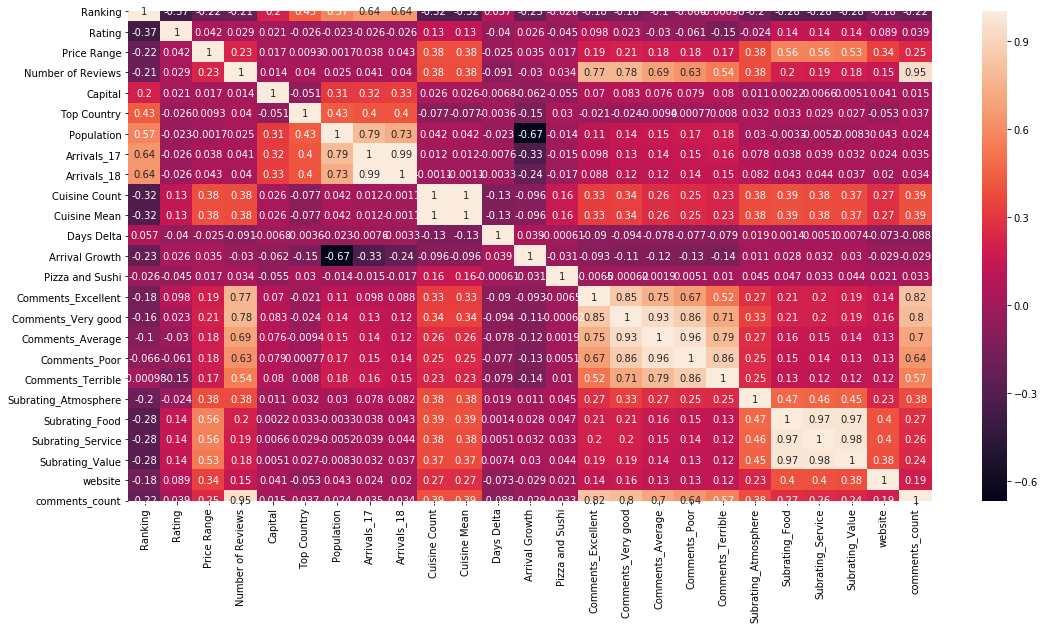

In [281]:
plt.figure(figsize=(18,9))
sns.heatmap(data_common.corr(), annot=True)

In [295]:
X = data_common.drop(labels=['Restaurant_id',
                             'City',
                             'Cuisine Style',
                             'Reviews',
                             'URL_TA',
                             'ID_TA',
                             'Rating',
                             'Number of Reviews',
                             'Arrivals_17',
                             'Cuisine Mean',
                             'Subrating_Food',
                             'Subrating_Service',
                             'Subrating_Value',
                             'Comments_Very good', 
                             'Comments_Average', 
                             'Comments_Poor'], axis=1)
y = data_common['Rating']

MAE(X, y)

MAE: 0.22146349999999998


## Kaggle 

In [525]:
task = pd.read_csv('kaggle_task.csv')

In [527]:
task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
Restaurant_id        10000 non-null object
Name                 10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


In [528]:
task_df = task.copy()
task_pr = get_price_range_from_site(task_df)

shape = 3475
#1 url = /Restaurant_Review-g274887-d8286886-Reviews-Beer_N_Scooter-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a></div>
pr = ['$']

#2 url = /Restaurant_Review-g189934-d12947542-Reviews-Bistro_Gimis-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c18-Helsinki_Uusimaa.html">European</a>, Scandinavian</div>
pr = ['$$ - $$$']

#3 url = /Restaurant_Review-g189852-d12716384-Reviews-Il_Molo-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, <a href="/Restaurants-g189852-c28-Stockholm.html">Mediterranean</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a></div>
pr = ['$$ - $$$']

#4 url = /Restaurant_Review-g187791-d7818546-Reviews-Jerry_

#35 url = /Restaurant_Review-g187265-d8376187-Reviews-Brasserie_le_Terminus-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c18-Lyon_Rhone_Auvergne_Rhone_Alpes.html">European</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#36 url = /Restaurant_Review-g1166685-d12644341-Reviews-Otentik_City-Saint_Priest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#37 url = /Restaurant_Review-g187323-d9559203-Reviews-Das_marchenhafte_Ribhouse-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
pr = ['$$ - $$$']

#38 url = /Restaurant_Review-g187514-d11636306-Reviews-Cafe_Rivero-Madrid.html
string = None
#39 url = /Restaurant_Review-g274772-d10455057-Reviews-Restauracja_Eden

#66 url = /Restaurant_Review-g188057-d7314013-Reviews-La_Biscotte-Geneva.html
string = None
#67 url = /Restaurant_Review-g188590-d1381958-Reviews-Cafe_Cox-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#68 url = /Restaurant_Review-g188113-d6014189-Reviews-The_Mousetrap_Pub-Zurich.html
string = <div class="header_links">Pub</div>
pr = []

#69 url = /Restaurant_Review-g187331-d1359197-Reviews-Mansaaf-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187331-zfz10697-Hamburg.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#70 url = /Restaurant_Review-g274707-d1114749-Reviews-Kacabka-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohem

#96 url = /Restaurant_Review-g189158-d2518308-Reviews-Cafe_da_Palha-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#97 url = /Restaurant_Review-g189158-d12413347-Reviews-A_Li-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#98 url = /Restaurant_Review-g189541-d7724878-Reviews-Phailin_Thai_Kitchen-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c39-Copenhagen_Zealand.html">Thai</a></div>
pr = []

#99 url = /Restaurant_Review-g187849-d8340062-Reviews-Campus_Bar_Reastaurant-Milan_Lombardy.html
string = None
#100 url = /Restaurant_Review-g187147-d10433666-Reviews-Bean-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a></div>
pr = ['$']

#1

#131 url = /Restaurant_Review-g188590-d4506283-Reviews-Beyruth_Amsterdam-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c10626-Amsterdam_North_Holland_Province.html">Lebanese</a>, <a href="/Restaurants-g188590-c28-Amsterdam_North_Holland_Province.html">Mediterranean</a></div>
pr = []

#132 url = /Restaurant_Review-g187323-d5610400-Reviews-McDonald_s-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-zfg16556-Berlin.html">Quick Bites</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#133 url = /Restaurant_Review-g187514-d10469022-Reviews-Terraza_La_Orotava-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Mad

#167 url = /Restaurant_Review-g187514-d11756903-Reviews-Cerveceria_La_Divina-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#168 url = /Restaurant_Review-g187309-d12662018-Reviews-Caffe_Gaballo-Munich_Upper_Bavaria_Bavaria.html
string = None
#169 url = /Restaurant_Review-g187309-d11650889-Reviews-Creamitaly-Munich_Upper_Bavaria_Bavaria.html
string = None
#170 url = /Restaurant_Review-g187791-d5513194-Reviews-Il_Buongustaio-Rome_Lazio.html
string = None
#171 url = /Restaurant_Review-g186338-d12643422-Reviews-Allstars_Gourmet-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#172 url = /Restaurant_Review-g187147-d1331632-Reviews-Shuping_Qian-Paris_Ile_de_France.html
string = None
#173 url = /Restaurant_Review-g274856-d948224-Reviews-Widoczna-Warsaw_Mazovia_Province_Central

#199 url = /Restaurant_Review-g950786-d8393826-Reviews-Ikram_et-Schaerbeek_Brussels.html
string = None
#200 url = /Restaurant_Review-g187849-d8341129-Reviews-Amigdala_Cafe-Milan_Lombardy.html
string = None
#201 url = /Restaurant_Review-g187147-d8633562-Reviews-Yokohama_2-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a></div>
pr = ['$']

#202 url = /Restaurant_Review-g186338-d2718079-Reviews-Wagamama-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c27-London_England.html">Japanese</a></div>
pr = []

#203 url = /Restaurant_Review-g186338-d12079826-Reviews-Cake_world-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfg9909-London_England.html">Dessert</a>, <a href="/Restaurants-g186338-c8-London

#230 url = /Restaurant_Review-g187265-d12398846-Reviews-Saku_Restaurant-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a>, <a href="/Restaurants-g187265-zfz10665-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#231 url = /Restaurant_Review-g187849-d2320334-Reviews-Scott_Joplin_Pub-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Pub</div>
pr = ['$$ - $$$']

#232 url = /Restaurant_Review-g187331-d5519325-Reviews-Bei_Musa-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c2-Hamburg.html">American</a></div>
pr = []

#233 url = /Restaurant_Review-g187514-d7812069-Reviews-El_Rincon_Del_Na-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g18

#265 url = /Restaurant_Review-g187147-d12599659-Reviews-Ibis_Kitchen-Paris_Ile_de_France.html
string = None
#266 url = /Restaurant_Review-g187323-d5956891-Reviews-Cafe_Taubenschlag-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#267 url = /Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html
string = None
#268 url = /Restaurant_Review-g188057-d8704716-Reviews-Paprika_Grill-Geneva.html
string = None
#269 url = /Restaurant_Review-g186338-d10304970-Reviews-Sainsbury_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#270 url = /Restaurant_Review-g187514-d2706475-Reviews-Madrena_Hostleria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid

#299 url = /Restaurant_Review-g186338-d4834253-Reviews-Quinto_Quarto-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#300 url = /Restaurant_Review-g187147-d1435274-Reviews-O_Fil_De_L_O-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = []

#301 url = /Restaurant_Review-g189852-d6807201-Reviews-Wkb_Marieberg-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, <a href="/Restaurants-g189852-c3-Stockholm.html">Asian</a>, <a href="/Restaurants-g189852-c10679-Stockholm.html">Healthy</a></div>
pr = ['$$ - $$$']

#302 url = /Restaurant_Review-g274924-d4769839-Reviews-Corona_bar-Bratislava_Bratislava_Region.html
string = None
#303 url = /Restaurant_Review-g186338-d6499017-Reviews-The_Quesadil

#332 url = /Restaurant_Review-g187323-d13083608-Reviews-Cafe_Plume-Berlin.html
string = None
#333 url = /Restaurant_Review-g187323-d10785527-Reviews-Strandbad_Lubars-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
pr = ['$$ - $$$']

#334 url = /Restaurant_Review-g189158-d12413351-Reviews-Adega_Solar_Minhoto-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a></div>
pr = ['$']

#335 url = /Restaurant_Review-g187323-d9743120-Reviews-Fusion_Factory-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
p

#364 url = /Restaurant_Review-g187147-d11180599-Reviews-Miss_Banh_Mi-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c10679-Paris_Ile_de_France.html">Healthy</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#365 url = /Restaurant_Review-g274772-d12499101-Reviews-Sweets_Salads-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c8-Krakow_Lesser_Poland_Province_Southern_Poland.html">Cafe</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
pr = ['$']

#366 url = /Restaurant_Review-g274887-d12

#394 url = /Restaurant_Review-g186338-d12808442-Reviews-Fat_Boyz_Diner-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a>, <a href="/Restaurants-g186338-c6-London_England.html">Barbecue</a>, Contemporary</div>
pr = ['$']

#395 url = /Restaurant_Review-g187849-d8338682-Reviews-Sudan-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a></div>
pr = []

#396 url = /Restaurant_Review-g188057-d908564-Reviews-Samourai-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-c27-Geneva.html">Japanese</a>, <a href="/Restaurants-g188057-c38-Geneva.html">Sushi</a>, <a href="/Restaurants-g188057-c3-Geneva.html">Asian</a></div>
pr = ['$$ - 

#427 url = /Restaurant_Review-g187147-d13196704-Reviews-Papa_Boun_Briocherie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-c22-Paris_Ile_de_France.html">International</a></div>
pr = ['$']

#428 url = /Restaurant_Review-g187849-d8338513-Reviews-Nuova_Pizza_Mundial-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#429 url = /Restaurant_Review-g187331-d9791243-Reviews-Dong_Ting_China_Restaurant-Hamburg.html
string = None
#430 url = /Restaurant_Review-g187323-d12870795-Reviews-Einstein_Kaffee-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">

#460 url = /Restaurant_Review-g189852-d11746045-Reviews-Tous_Les_Jours-Stockholm.html
string = None
#461 url = /Restaurant_Review-g189541-d7595936-Reviews-Restaurant_Sahara-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a></div>
pr = ['$']

#462 url = /Restaurant_Review-g187147-d6781641-Reviews-Tian_Jin_Restaurant-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = []

#463 url = /Restaurant_Review-g190454-d9567836-Reviews-Orient-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c3-Vienna.html">Asian</a>, <a href="/Restaurants-g190454-c30-Vienna.html">Middle Eastern</a></div>
pr = []

#464 url = /Restaurant_Review-g274887-d10726675-Reviews-Bagetto-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href

#492 url = /Restaurant_Review-g187849-d8339908-Reviews-Si_Caffe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#493 url = /Restaurant_Review-g189158-d5981254-Reviews-Kastello_Xxi-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#494 url = /Restaurant_Review-g274873-d2227270-Reviews-Gostilna_Pecaric-Ljubljana_Upper_Carniola_Region.html
string = <div class="header_links">Slovenian, <a href="/Restaurants-g274873-c18-Ljubljana_Upper_Carniola_Region.html">European</a></div>
pr = []

#495 url = /Restaurant_Review-g274707-d11735169-Reviews-Na_KovarnE-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c2-Prague_Bohemia.html">American</a></div>
pr = ['$$ - $$$']

#496 url = /Restaurant_Review-g187323-d2662940-Reviews-Dildile-Berlin.html
string = <div class="header_links"><a href="/Restaur

#527 url = /Restaurant_Review-g188113-d6959214-Reviews-Ta_Ty_Asian_Restaurant-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c3-Zurich.html">Asian</a></div>
pr = []

#528 url = /Restaurant_Review-g187497-d7691367-Reviews-Paicabar-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#529 url = /Restaurant_Review-g190479-d7322731-Reviews-Nargile_Grill-Oslo_Eastern_Norway.html
string = None
#530 url = /Restaurant_Review-g187497-d3874034-Reviews-Restaurante_Liban-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c10626-Barcelona_Catalonia.html">Lebanese</a>, <a href="/Restaurants-g187497-c30-Barcelona_Catalonia.html">Middle Eastern</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = ['$']

#531 url = /Restaurant_Review-

#558 url = /Restaurant_Review-g188113-d6366359-Reviews-New_Shanghai-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c11-Zurich.html">Chinese</a>, <a href="/Restaurants-g188113-c3-Zurich.html">Asian</a></div>
pr = []

#559 url = /Restaurant_Review-g187309-d12563916-Reviews-Chois-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c11-Munich_Upper_Bavaria_Bavaria.html">Chinese</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#560 url = /Restaurant_Review-g187323-d12880824-Reviews-Backer_Widemann-Berlin.html
string = None
#561 url = /Restaurant_Review-g274707-d1983707-Reviews-Restaurace_Nostitz-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g2747

#591 url = /Restaurant_Review-g187791-d7591547-Reviews-Casina_delle_Terme-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#592 url = /Restaurant_Review-g190454-d12858568-Reviews-HaferPoint-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c2-Vienna.html">American</a>, <a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a>, <a href="/Restaurants-g190454-c10646-Vienna.html">Fast Food</a>, Grill</div>
pr = []

#593 url = /Restaurant_Review-g186338-d7274060-Reviews-Gunners_Fish_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c33-London_England.html">Seafood</a></div>

#624 url = /Restaurant_Review-g274856-d10595068-Reviews-Fort_Wino-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#625 url = /Restaurant_Review-g187791-d12643879-Reviews-Blue_Rose_Cafe-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
pr = []

#626 url = /Restaurant_Review-g187147-d12341568-Reviews-Grazie_Mille-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = []

#627 url = /Restaurant_Review-g186338-d1024937-Reviews-Old_Orleans-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#628 url = /Restaurant_Review-g187323-d1354482-Reviews-Restaurant_Attila-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, Croatian, <a href="/Restaurants-g187323-c18-Berlin.html">Eur

#656 url = /Restaurant_Review-g187849-d7097343-Reviews-Buona_Pizza_Di_Oriani_Renata-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#657 url = /Restaurant_Review-g186338-d5864074-Reviews-Cafe_Parisien-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c20-London_England.html">French</a></div>
pr = []

#658 url = /Restaurant_Review-g187309-d4942699-Reviews-La_conchiglia_Ristorante-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a></div>
pr = []

#659 url = /Restaurant_Review-g187849-d10027603-Reviews-Paninoteca_Enoteca_Dal-Milan_Lombardy.html
string = None
#660 url = /Restaurant_Review-g189158-d7967312-Reviews-Doce_Larica-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links">Bra

#687 url = /Restaurant_Review-g187265-d8297603-Reviews-McDonald_s-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-zfg16556-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Quick Bites</a>, <a href="/Restaurants-g187265-c10646-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Fast Food</a></div>
pr = ['$']

#688 url = /Restaurant_Review-g187497-d10628232-Reviews-Boheme_Cafeteria_Panaderia-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-zfz10665-Barcelona_Catalonia.html">Vegetarian Friendly</a></div>
pr = ['$']

#689 url = /Restaurant_Review-g187497-d11903522-Reviews-Vins_Bens-Barcelona_Catalonia.html
string = None
#690 url = /Restaurant_Review-g187147-d8297656-Reviews-McDonald_s-Paris_Ile_de_France.h

#723 url = /Restaurant_Review-g186338-d12686213-Reviews-Sakura_Japanese_Sushi-London_England.html
string = None
#724 url = /Restaurant_Review-g187331-d8741635-Reviews-Jo_Makronchen-Hamburg.html
string = <div class="header_links">Swiss, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a></div>
pr = []

#725 url = /Restaurant_Review-g187147-d13298310-Reviews-Casa_Pietro-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = ['$']

#726 url = /Restaurant_Review-g274856-d1773677-Reviews-Alibi_Sports_Bar_Restaurant-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c22-Warsaw_Mazovia_Province_Central_Poland.html">International</a></div>
pr = []

#727 url = /Restaurant_Review-g187331-d1039336-Reviews-Das_Riff-Hamburg.html
string = None
#728 url = /Restaurant_Review-g18733

#753 url = /Restaurant_Review-g186605-d9777892-Reviews-Buttery-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=1">$</a>, <a href="/Restaurants-g186605-zfg16556-Dublin_County_Dublin.html">Quick Bites</a>, <a href="/Restaurants-g186605-zfz10665-Dublin_County_Dublin.html">Vegetarian Friendly</a></div>
pr = ['$']

#754 url = /Restaurant_Review-g188644-d7056035-Reviews-Richard_Alaya-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
pr = []

#755 url = /Restaurant_Review-g190454-d6155961-Reviews-Pointers_Bar_Restaurant-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#756 url = /Restaurant_Review-g187147-d3192111-Reviews-Brasserie_de_la_Porte_Dauphine-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.h

#787 url = /Restaurant_Review-g188590-d8511126-Reviews-Buster_s-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#788 url = /Restaurant_Review-g187323-d8411341-Reviews-Das_Spielzimmer-Berlin.html
string = None
#789 url = /Restaurant_Review-g186605-d5863976-Reviews-Scholars_Restaurant-Dublin_County_Dublin.html
string = None
#790 url = /Restaurant_Review-g187849-d8338341-Reviews-Isolbar-Milan_Lombardy.html
string = None
#791 url = /Restaurant_Review-g950786-d12330256-Reviews-Point_Chaud-Schaerbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950786-Schaerbeek_Brussels.html?pid=1">$</a>, <a href="/Restaurants-g950786-c8-Schaerbeek_Brussels.html">Cafe</a></div>
pr = ['$']

#792 url = /Restaurant_Review-g187791-d5489774-Reviews-Il_Capriccio_di_Sonia_Poggi-Rome_Lazio.html
string = <div class="header_links"><a href="/Rest

#822 url = /Restaurant_Review-g187849-d8339926-Reviews-Art_Cafe-Milan_Lombardy.html
string = None
#823 url = /Restaurant_Review-g189180-d7355765-Reviews-A_Cozinha_Da_Maria_Eugenia-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = ['$$ - $$$']

#824 url = /Restaurant_Review-g187849-d3932299-Reviews-Sorso-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#825 url = /Restaurant_Review-g187849-d2370693-Reviews-Pizzeria_Genius-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
pr = []

#826 url = /Restaurant_Revi

#851 url = /Restaurant_Review-g190454-d5975762-Reviews-Gasthaus_Hansi-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#852 url = /Restaurant_Review-g187323-d9785381-Reviews-Primavera_Ristorante-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#853 url = /Restaurant_Review-g186338-d3545873-Reviews-Bongo_Bar_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c1-London_England.html">African</a></div>
pr = []

#854 url = /Restaurant_Review-g186338-d8705042-Reviews-Tryencore-London_England.html
string = None
#855

#884 url = /Restaurant_Review-g189158-d8596033-Reviews-Restaurante_Club_Do_Operario-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = []

#885 url = /Restaurant_Review-g187309-d5529011-Reviews-Clasen-Munich_Upper_Bavaria_Bavaria.html
string = None
#886 url = /Restaurant_Review-g189158-d9770053-Reviews-Restaurantes_Chines_Nuvem_Mar-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c11-Lisbon_Lisbon_District_Central_Portugal.html">Chinese</a></div>
pr = ['$$ - $$$']

#887 url = /Restaurant_Review-g190454-d2043034-Reviews-5er_Brau-Vienna.html
string = <div class="header_links">Austrian, <a href="/Restaurant

#917 url = /Restaurant_Review-g187147-d1977885-Reviews-Le_Gentilly-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#918 url = /Restaurant_Review-g187147-d10792252-Reviews-Le_Chantier_Interdit-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#919 url = /Restaurant_Review-g189158-d8598311-Reviews-Restaurante_Tipico_Alentejano-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#920 url = /Restaurant_Review-g187331-d5960915-Reviews-Cafe_Rouge-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c8-Hamburg.html">Cafe</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, <a href="/Restaurants-g

#950 url = /Restaurant_Review-g190454-d12790553-Reviews-Weltmeister_Kebap-Vienna.html
string = <div class="header_links">Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = []

#951 url = /Restaurant_Review-g189852-d9779749-Reviews-Cafe_Zeppelin-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=8">$$$$</a></div>
pr = ['$$$$']

#952 url = /Restaurant_Review-g190454-d5976755-Reviews-Maraschino-Vienna.html
string = None
#953 url = /Restaurant_Review-g187331-d1358389-Reviews-Sodexho_DESY_Bistro-Hamburg.html
string = None
#954 url = /Restaurant_Review-g186338-d12318196-Reviews-The_Crowndale-London_England.html
string = None
#955 url = /Restaurant_Review-g190454-d5986431-Reviews-Billardcafe_Koo_5-Vienna.html
string = None
#956 url = /Restaurant_Review-g187791-d12946550-Reviews-La_Cioccolateria_Dolce_Idea-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$

#989 url = /Restaurant_Review-g189934-d1139045-Reviews-Hong_Fu-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c11-Helsinki_Uusimaa.html">Chinese</a></div>
pr = []

#990 url = /Restaurant_Review-g187147-d12128414-Reviews-Sushi_Eiffel-Paris_Ile_de_France.html
string = None
#991 url = /Restaurant_Review-g187791-d3474536-Reviews-UN_Punto_Macrobiotico-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187791-zfz10697-Rome_Lazio.html">Vegan Options</a></div>
pr = []

#992 url = /Restaurant_Review-g187147-d9806573-Reviews-A_la_Goutte_d_Or-Paris_Ile_de_France.html
string = None
#993 url = /Restaurant_Review-g187849-d6750635-Reviews-FANTACITY-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a></div>
pr = []

#994 url = /Restaurant_Review-g187323-d7992434-Reviews-Eiscafe_Annamaria-Berlin

#1027 url = /Restaurant_Review-g186338-d9711626-Reviews-Perfect_Fried_Chicken-London_England.html
string = None
#1028 url = /Restaurant_Review-g187849-d10628468-Reviews-Friend_Circle-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a></div>
pr = []

#1029 url = /Restaurant_Review-g189541-d12334550-Reviews-Roma_Pizzeria_Grill-Copenhagen_Zealand.html
string = None
#1030 url = /Restaurant_Review-g187514-d5487502-Reviews-Pizza_Hut-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c31-Madrid.html">Pizza</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
pr = []

#1031 url = /Restaurant_Review-g189852-d1053279-Reviews-Dramatenterrassen-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c20-Stockholm.html">French</a>, Swedish, Scandinavian</div>
pr = ['$$ - $$$']

#1032 url = /Res

#1066 url = /Restaurant_Review-g274887-d1580627-Reviews-Boutiq_Bar-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1067 url = /Restaurant_Review-g186338-d1059432-Reviews-12_Restaurant-London_England.html
string = None
#1068 url = /Restaurant_Review-g186338-d12276808-Reviews-Picollo_Deli-London_England.html
string = None
#1069 url = /Restaurant_Review-g187497-d998017-Reviews-Bar_Restaurant_Bauma-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#1070 url = /Restaurant_Review-g187147-d13037295-Reviews-Enkor-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, Cambodian</div>
pr = ['$']

#1071 url = /Restaurant_Review-g187791-d833

#1096 url = /Restaurant_Review-g187514-d10382095-Reviews-La_Parranda-Madrid.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#1097 url = /Restaurant_Review-g190454-d10790418-Reviews-Szihn-Vienna.html
string = None
#1098 url = /Restaurant_Review-g189180-d7991074-Reviews-B_A_Cedofeita_Epicure-Porto_Porto_District_Northern_Portugal.html
string = None
#1099 url = /Restaurant_Review-g189400-d10766955-Reviews-To_Plateiaki_Mas-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=1">$</a></div>
pr = ['$']

#1100 url = /Restaurant_Review-g187514-d7342170-Reviews-CotiCo_Bar_and_Resto-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#1101 url = /Restaurant_Review-g274924-d5048797-Reviews-Bistro_Mladost-Bratislava_Bratislava_Region.html
string = None
#1102 url = /Restaurant_Review-g27485

#1129 url = /Restaurant_Review-g274887-d12235071-Reviews-Tavasz_Kinai_Bufe-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a></div>
pr = ['$']

#1130 url = /Restaurant_Review-g186338-d5220322-Reviews-La_Fromagerie-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfg16548-London_England.html">Specialty Food Market</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$$ - $$$']

#1131 url = /Restaurant_Review-g187147-d2623222-Reviews-Seang_Duan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c39-Paris_Ile_de_France.html">Thai</a></div>
pr = []

#1132 url = /Restaurant_Review-g187309-d10755704-Reviews-Erbils-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bav

#1161 url = /Restaurant_Review-g189158-d10802112-Reviews-Cunha_Alves_Lda-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#1162 url = /Restaurant_Review-g186525-d10607343-Reviews-The_Real_Pizza_Factory-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1163 url = /Restaurant_Review-g187147-d8602388-Reviews-A_La_Ville_De_Rodez-Paris_Ile_de_France.html
string = None
#1164 url = /Restaurant_Review-g187497-d5870511-Reviews-Xiringuito_aigua-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = ['$']

#1165 url = /Restaurant_Review-g274707-d12376518-Reviews-Rita_Cavolo_restaurant_coffee-Prague_Bohemia.html
string = <div class="header_links"><a

#1192 url = /Restaurant_Review-g187497-d5788013-Reviews-Casa_Gispert-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1193 url = /Restaurant_Review-g274856-d10478328-Reviews-Maison_de_The-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#1194 url = /Restaurant_Review-g187147-d5259712-Reviews-Cojean_Washington-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-zfg16556-Paris_Ile_de_France.html">Quick Bites</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#1195 url = /Restaurant_Review-g187791-d5814255-Reviews-Sole_Nascente_SAS-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a hr

#1228 url = /Restaurant_Review-g274707-d10664983-Reviews-Asian_Bistro-Prague_Bohemia.html
string = None
#1229 url = /Restaurant_Review-g187309-d964381-Reviews-Hahnhof-Munich_Upper_Bavaria_Bavaria.html
string = None
#1230 url = /Restaurant_Review-g188590-d4054144-Reviews-Cichetti-Amsterdam_North_Holland_Province.html
string = None
#1231 url = /Restaurant_Review-g187514-d5768299-Reviews-La_Esquina_de_Mesena-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#1232 url = /Restaurant_Review-g190454-d11802003-Reviews-Pizza_Mann-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, <a href="/Restaurants-g190454-c31-Vienna.html">Pizza</a></div>
pr = ['$']

#1233 url = /Restaurant_Review-g187323-d8015661-Reviews-Bad_Kreuzberg-Berlin.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#1234 url = /Restaurant_

#1264 url = /Restaurant_Review-g187514-d12710930-Reviews-Jordan_Cafe_Bar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c33-Madrid.html">Seafood</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#1265 url = /Restaurant_Review-g187497-d8368489-Reviews-Bocpertot-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
pr = ['$']

#1266 url = /Restaurant_Review-g187265-d6539425-Reviews-La_Pause_Delices-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#1267 url = /Restaurant_Review-g189541-d10794456-Reviews-Leonard_s-Copenhagen_Zealand.html
string = None
#1268 url = /Restaurant_Review-g187147-d7751487-Reviews-Ryang_Mi-Paris_Ile_de_France.html
string = <div class="he

#1296 url = /Restaurant_Review-g188057-d1044931-Reviews-Diligence-Geneva.html
string = None
#1297 url = /Restaurant_Review-g274887-d12339930-Reviews-Bubba_s_Water_Grill-Budapest_Central_Hungary.html
string = <div class="header_links">Grill</div>
pr = []

#1298 url = /Restaurant_Review-g274856-d10175696-Reviews-Dina_Kebab-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-c10663-Warsaw_Mazovia_Province_Central_Poland.html">Turkish</a></div>
pr = []

#1299 url = /Restaurant_Review-g186525-d8871018-Reviews-La_Patate_Hache-Edinburgh_Scotland.html
string = None
#1300 url = /Restaurant_Review-g274924-d4770231-Reviews-Restauracia_a_Pizzeria_Lumax-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c31-Bratislava_Bratislava_Region.html">Pizza</a></div>
pr = []

#1301 url = /Restaurant_Review-g189852-d12347294-Reviews-Macelleria-Stockholm.html
string = <div class="header_links"><a href="/Res

#1330 url = /Restaurant_Review-g274856-d8652731-Reviews-Sakaba_Sushi_Restaurant-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274856-c38-Warsaw_Mazovia_Province_Central_Poland.html">Sushi</a></div>
pr = ['$$ - $$$']

#1331 url = /Restaurant_Review-g187147-d10100793-Reviews-Aux_Delices_De_Paris_Reuilly-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$']

#1332 url = /Restaurant_Review-g187147-d2042149-Reviews-Restaurant_Le_13-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18

#1361 url = /Restaurant_Review-g187331-d10370438-Reviews-Brot_brotchen-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-zfg9901-Hamburg.html">Bakeries</a>, <a href="/Restaurants-g187331-c13-Hamburg.html">Deli</a></div>
pr = ['$$ - $$$']

#1362 url = /Restaurant_Review-g187514-d5795965-Reviews-El_Rincon_de_Jaen_Iv-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#1363 url = /Restaurant_Review-g186338-d10677160-Reviews-Hermanos_Mexicanos-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c29-London_England.html">Mexican</a></div>
pr = ['$']

#1364 url = /Restaurant_Review-g187147-d8

#1392 url = /Restaurant_Review-g187514-d991347-Reviews-Espiral_XXI_SL-Madrid.html
string = None
#1393 url = /Restaurant_Review-g188590-d12328261-Reviews-Burger_King-Amsterdam_North_Holland_Province.html
string = None
#1394 url = /Restaurant_Review-g187331-d5526691-Reviews-Sushi_Yama-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c38-Hamburg.html">Sushi</a></div>
pr = []

#1395 url = /Restaurant_Review-g187514-d7274414-Reviews-Marisqueria_Nesva-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#1396 url = /Restaurant_Review-g187849-d6576966-Reviews-Gustop-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-zfz10665-Milan_Lombardy.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187849-zfz10697-Milan_Lombardy.html">Vegan

#1431 url = /Restaurant_Review-g274707-d4767542-Reviews-Hamr_Branik-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a>, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = ['$']

#1432 url = /Restaurant_Review-g189852-d2308767-Reviews-Pizza_Kebab_Bar-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c30-Stockholm.html">Middle Eastern</a></div>
pr = []

#1433 url = /Restaurant_Review-g189541-d10559391-Reviews-Thai_me_up-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=1">$</a>, <a href="/Restaurants-g189541-c3-Copenhagen_Zealand.html">Asian</a>, <a href="/Restaurants-g189541-c39-Copenhagen_Zealand.html">Thai</a></div>
pr = ['$']

#1434 url = /Restaurant_Review-g186338-d680373-Reviews-Luxuriance_Peking_Cuisine-London_England.html
string = <div class="header_links"><a href="/Restaurants-g18633

#1461 url = /Restaurant_Review-g187514-d5487163-Reviews-Fuentecobre-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#1462 url = /Restaurant_Review-g188590-d8743345-Reviews-Tingis-Amsterdam_North_Holland_Province.html
string = None
#1463 url = /Restaurant_Review-g190356-d8674538-Reviews-Cafe_Terminus-Luxembourg_City.html
string = <div class="header_links"><a href="/Restaurants-g190356-c28-Luxembourg_City.html">Mediterranean</a></div>
pr = []

#1464 url = /Restaurant_Review-g189852-d12869856-Reviews-The_Central_Bar-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, Swedish</div>
pr = ['$$ - $$$']

#1465 url = /Restaurant_Review-g187147-d8388746-Reviews-L_Atelier_Suffren-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6"

#1493 url = /Restaurant_Review-g186338-d10790167-Reviews-Shanel_s_Sandwich_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#1494 url = /Restaurant_Review-g189180-d11912222-Reviews-Food_Friends-Porto_Porto_District_Northern_Portugal.html
string = None
#1495 url = /Restaurant_Review-g190479-d10160278-Reviews-Sushi_Rose_Majorstua-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=1">$</a></div>
pr = ['$']

#1496 url = /Restaurant_Review-g187849-d6028274-Reviews-Grissinificio_Edelweiss-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a></div>
pr = ['$']

#1497 url = /Restaurant_Review-g189852-d12499888-Reviews-Restaurang_Tapir-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1898

#1523 url = /Restaurant_Review-g187791-d8042640-Reviews-La_Collinetta-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=8">$$$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187791-zfz10697-Rome_Lazio.html">Vegan Options</a></div>
pr = ['$$$$']

#1524 url = /Restaurant_Review-g187497-d1108091-Reviews-La_Taverna_d_en_Pep-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
pr = []

#1525 url = /Restaurant_Review-g207360-d8655212-Reviews-Le_Grain_D_ane-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g207360-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g207360-c20-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html">French</a></div

#1553 url = /Restaurant_Review-g186338-d11806770-Reviews-The_Beer_Shop-London_England.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#1554 url = /Restaurant_Review-g274707-d12232818-Reviews-U_Bobra_Xaverov-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#1555 url = /Restaurant_Review-g189852-d8003998-Reviews-Monks_Wine_Room-Stockholm.html
string = None
#1556 url = /Restaurant_Review-g187514-d991442-Reviews-El_Jazmin-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#1557 url = /Restaurant_Review-g189852-d10313674-Reviews-Aroti-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1558 url = /Restaurant_Review-g186338-d9561390-Reviews-Funky_Brownz_

#1588 url = /Restaurant_Review-g187323-d10430060-Reviews-Einstein_Kaffe-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a></div>
pr = []

#1589 url = /Restaurant_Review-g189158-d6692315-Reviews-Pastelaria_o_Preto_Dos_Anjos_Estab_De_Alimentacao-Lisbon_Lisbon_District_Central_.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a></div>
pr = ['$']

#1590 url = /Restaurant_Review-g187849-d12976595-Reviews-ToscaNino-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c28-Milan_Lombardy.html">Mediterranean</a>,

#1624 url = /Restaurant_Review-g186338-d5080710-Reviews-New_Century-London_England.html
string = None
#1625 url = /Restaurant_Review-g187323-d5819256-Reviews-Kahrmann_s_Own-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#1626 url = /Restaurant_Review-g274707-d5414990-Reviews-Gattino_Bohnice-Prague_Bohemia.html
string = None
#1627 url = /Restaurant_Review-g186338-d3510196-Reviews-Chicken_Cottage-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
pr = []

#1628 url = /Restaurant_Review-g189541-d12434171-Reviews-Fala_Fala-Copenhagen_Zealand.html
string = None
#1629 url = /Restaurant_Review-g187791-d4881540-Reviews-Fi

#1659 url = /Restaurant_Review-g187849-d3803879-Reviews-Basilico_Co-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#1660 url = /Restaurant_Review-g274856-d11836331-Reviews-The_Lobby_Bar-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1661 url = /Restaurant_Review-g189180-d12834138-Reviews-Tasquinha_do_Luis-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = ['$']

#1662 url

#1686 url = /Restaurant_Review-g187331-d5667613-Reviews-Bierhutte-Hamburg.html
string = None
#1687 url = /Restaurant_Review-g189934-d12869417-Reviews-Luckiefun_s_Restaurant-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#1688 url = /Restaurant_Review-g186338-d7238600-Reviews-The_William_Stanley-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#1689 url = /Restaurant_Review-g188590-d6561685-Reviews-Citea_Amsterdam-Amsterdam_North_Holland_Province.html
string = None
#1690 url = /Restaurant_Review-g186338-d3611011-Reviews-Thai_Silk_Greenwich-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, <a href="/Restaurants-g186338-c39-London_England.html">Thai</a></div>
pr = []

#1691 url = /Restaurant_Review-g187791-d5821852-Reviews-Russo_

#1720 url = /Restaurant_Review-g186338-d2256985-Reviews-Phoenix_441-London_England.html
string = None
#1721 url = /Restaurant_Review-g187497-d1932484-Reviews-Bar_Ski-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
pr = []

#1722 url = /Restaurant_Review-g190454-d2078264-Reviews-San_Gimignano-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c26-Vienna.html">Italian</a></div>
pr = []

#1723 url = /Restaurant_Review-g190454-d3617092-Reviews-Easy_Noodles-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-c3-Vienna.html">Asian</a></div>
pr = []

#1724 url = /Restaurant_Review-g187791-d12320944-Reviews-Bar_Oly_Ste-Rome_Lazio.html
string = None
#1725 url = /Restaurant_Review-g187147-d11961398-Reviews-L_Extas_Eat-Paris_Ile_de_France.html
string = None
#1726 url = /Restaurant_Review-g186338-d7369403-Reviews-Sunshine_Cafe-London_England.html
string = <di

#1757 url = /Restaurant_Review-g190454-d10180306-Reviews-Helmut_Krenek_Weingut_H_P_Gobel-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Contemporary, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = ['$']

#1758 url = /Restaurant_Review-g187514-d7914402-Reviews-Piaopiaobar-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a>, <a href="/Restaurants-g187514-c10696-Madrid.html">Taiwanese</a></div>
pr = []

#1759 url = /Restaurant_Review-g274856-d10678059-Reviews-Pub_Zloty_Krol-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a hre

#1790 url = /Restaurant_Review-g187147-d4084939-Reviews-Makishop-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a></div>
pr = []

#1791 url = /Restaurant_Review-g190479-d8809754-Reviews-Majorstuen-Oslo_Eastern_Norway.html
string = None
#1792 url = /Restaurant_Review-g187849-d8341050-Reviews-Canottieri_Milano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$']

#1793 url = /Restaurant_Review-g188644-d4801151-Reviews-Miam_Stram_Gram-Brussels.html
string = None
#1794 url = /Restaurant_Review-g187331-d8259861-Reviews-Restaurant_Omyros-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c23-Hamburg.htm

#1823 url = /Restaurant_Review-g274707-d4769113-Reviews-Restaurace_U_houslicek-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
pr = []

#1824 url = /Restaurant_Review-g274707-d8282471-Reviews-Bistro_Bruncvik-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
pr = ['$']

#1825 url = /Restaurant_Review-g188590-d10485839-Reviews-Burritomaker-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a>, <a href="/Restaurants-g188590-c2-Amsterdam_North_Holland_Province.html">American</a>, <a href="/Restaurants-g188590-c10646-Amsterdam_North_Holland_Province.html">Fast Food</a>, <a href="/Restaurants-g188590-c29-Amsterdam_North_Holland_Province.html">Mexican</a></div>
pr = ['$']

#1826 url = /Restaurant_Review-g187309-d11717447-Reviews-Zunfth

#1853 url = /Restaurant_Review-g274924-d12180453-Reviews-Bistro_Com_bui-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-c41-Bratislava_Bratislava_Region.html">Vietnamese</a></div>
pr = []

#1854 url = /Restaurant_Review-g189180-d6767464-Reviews-Churrascaria_Capoeira_Central_do_Carvalhido-Porto_Porto_District_Northern_Portuga.html
string = <div class="header_links"><a href="/Restaurants-g189180-c6-Porto_Porto_District_Northern_Portugal.html">Barbecue</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = []

#1855 url = /Restaurant_Review-g187849-d5994815-Reviews-Le_voglie-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#

#1885 url = /Restaurant_Review-g186525-d8731095-Reviews-Stand_Up_Restaurant-Edinburgh_Scotland.html
string = None
#1886 url = /Restaurant_Review-g187147-d815042-Reviews-Kaanimara-Paris_Ile_de_France.html
string = None
#1887 url = /Restaurant_Review-g1080938-d11706628-Reviews-D_Sushi-Decines_Charpieu_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1080938-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1080938-c38-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">Sushi</a>, <a href="/Restaurants-g1080938-c27-Decines_Charpieu_Rhone_Auvergne_Rhone_Alpes.html">Japanese</a></div>
pr = ['$$ - $$$']

#1888 url = /Restaurant_Review-g187849-d8277103-Reviews-IL_MALTO_E_L_UVA-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Wine Bar, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = ['$$ - $$$']

#1889 

#1917 url = /Restaurant_Review-g187791-d10043473-Reviews-Forno_Dolce_Forno-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-zfg9901-Rome_Lazio.html">Bakeries</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
pr = ['$$ - $$$']

#1918 url = /Restaurant_Review-g187147-d12667312-Reviews-Hippopotamus-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c37-Paris_Ile_de_France.html">Steakhouse</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = ['$$ - $$$']

#1919 url = /Restaurant_Review-g1156375-d11726490-Reviews-Orient_Kitchen-Saint_Jans_Molenbeek_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1156375-c3-Saint_Jans_Molenbeek_

#1948 url = /Restaurant_Review-g190454-d12702379-Reviews-Cafe_Leif-Vienna.html
string = None
#1949 url = /Restaurant_Review-g186338-d734231-Reviews-Cafe_El_Paso-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c29-London_England.html">Mexican</a>, <a href="/Restaurants-g186338-c6-London_England.html">Barbecue</a>, <a href="/Restaurants-g186338-c36-London_England.html">Spanish</a></div>
pr = ['$$ - $$$']

#1950 url = /Restaurant_Review-g187147-d7727897-Reviews-Le_Majorelle-Paris_Ile_de_France.html
string = None
#1951 url = /Restaurant_Review-g187147-d1335027-Reviews-Montecao-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#1952 url = /Restaurant_Review-g187514-d10621458-Reviews-El_Var-Madrid.html
stri

#1984 url = /Restaurant_Review-g274856-d11838168-Reviews-Souvlak_City_Truck-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#1985 url = /Restaurant_Review-g189852-d9564011-Reviews-Brunos_Korvbar-Stockholm.html
string = None
#1986 url = /Restaurant_Review-g189852-d6981897-Reviews-Noga-Stockholm.html
string = None
#1987 url = /Restaurant_Review-g274887-d10666442-Reviews-Kinai_Gyorsbufe-Budapest_Central_Hungary.html
string = None
#1988 url = /Restaurant_Review-g187147-d7687059-Reviews-Panda_Style-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c11-Paris_Ile_de_France.html">Chinese</a></div>
pr = ['$']

#1989 url = /Restaurant_Review-g187497-d12494026-Reviews-Siamo_Gelati-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-zfg9909-Barcelona_Catalonia.html">De

#2016 url = /Restaurant_Review-g190479-d11857209-Reviews-Krohgs-Oslo_Eastern_Norway.html
string = None
#2017 url = /Restaurant_Review-g186338-d5814968-Reviews-Rodeo_cafe_grill-London_England.html
string = None
#2018 url = /Restaurant_Review-g188590-d8675008-Reviews-Ola_Swirls-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a></div>
pr = ['$']

#2019 url = /Restaurant_Review-g187323-d5614629-Reviews-Punjabi_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c24-Berlin.html">Indian</a></div>
pr = []

#2020 url = /Restaurant_Review-g187323-d9561841-Reviews-Fos_Bar-Berlin.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#2021 url = /Restaurant_Review-g187147-d8518195-Reviews-Le_Relais_de_la_Place-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
pr = ['$'

#2053 url = /Restaurant_Review-g190454-d10609376-Reviews-Riegler_s_Eis_Salon-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, <a href="/Restaurants-g190454-zfg9909-Vienna.html">Dessert</a>, <a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a></div>
pr = ['$']

#2054 url = /Restaurant_Review-g186338-d2001355-Reviews-Old_China_Hand-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#2055 url = /Restaurant_Review-g274887-d8284765-Reviews-Meat_Point-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c37-Budapest_Central_Hungary.html">Steakhouse</a></div>
pr = []

#2056 url = /Restaurant_Review-g187323-d5522995-Reviews-Tiba_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
pr = ['$']

#2057 url = /Restaurant_Review-g187331-d3693120-Reviews-S

#2087 url = /Restaurant_Review-g186338-d10308217-Reviews-Frankies_Sandwich_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, Diner, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$']

#2088 url = /Restaurant_Review-g187323-d8515715-Reviews-Panke_Culture-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
pr = ['$$ - $$$']

#2089 url = /Restaurant_Review-g190454-d8281024-Reviews-Konditorei_Burger-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2090 url = /Restaurant_Review-g274772-d8788146-Reviews-Maximus_Italian_Restaurant-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_L

#2121 url = /Restaurant_Review-g187514-d7375870-Reviews-Commens-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Diner</div>
pr = ['$$ - $$$']

#2122 url = /Restaurant_Review-g187323-d5526124-Reviews-Gaststatte_Rothenburg_Eck-Berlin.html
string = None
#2123 url = /Restaurant_Review-g187309-d983192-Reviews-Bella_Napoli-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a></div>
pr = ['$$ - $$$']

#2124 url = /Restaurant_Review-g187514-d12671327-Reviews-Pasteleria_Valle_Inclan_76-Madrid.html
string = None
#2125 url = /Restaurant_Review-g274856-d12338543-Reviews-1Minute-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#2126 url = /Restaurant_Review-g187497-d1845183-Reviews-La_Giocond

#2158 url = /Restaurant_Review-g187147-d1322615-Reviews-La_Pachanga-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2159 url = /Restaurant_Review-g187331-d838387-Reviews-November_Bergedorf-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, Central European</div>
pr = ['$$ - $$$']

#2160 url = /Restaurant_Review-g186338-d7231041-Reviews-The_Place_to_Eat-London_England.html
string = None
#2161 url = /Restaurant_Review-g189541-d1222345-Reviews-Restaurant_Flakfortet-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189541-c18-Copenhagen_Zealand.html">European</a>, Danish</div>
pr = ['$$ - $$$']

#2195 url = /Restaurant_Review-g187849-d696444-Reviews-Angelo_Restaurant-Milan_Lombardy.html
string = None
#2196 url = /Restaurant_Review-g274887-d10795035-Reviews-Cream_Sound_Cafe-Budapest_Central_Hungary.html
string = None
#2197 url = /Restaurant_Review-g188057-d7320818-Reviews-Le_Cosmopolitain-Geneva.html
string = None
#2198 url = /Restaurant_Review-g186338-d4913240-Reviews-Shish_Shack-London_England.html
string = None
#2199 url = /Restaurant_Review-g187849-d8339668-Reviews-Bar_Moda-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a></div>
pr = []

#2200 url = /Restaurant_Review-g187514-d4093943-Reviews-Swing-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = []

#2201 url = /Restaurant_Review-g189158-d10068586-Reviews-Amigos_Da_Montanha_Nepal-Lisbon_Lisbon_District_Central_Portugal.htm

#2229 url = /Restaurant_Review-g187497-d2695779-Reviews-Oliver_Privee-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c23-Barcelona_Catalonia.html">Greek</a></div>
pr = []

#2230 url = /Restaurant_Review-g187323-d1357805-Reviews-Hoher_s_Gaststuben-Berlin.html
string = None
#2231 url = /Restaurant_Review-g189400-d3709421-Reviews-Elaia_Mesogeiaki_Kousina-Athens_Attica.html
string = None
#2232 url = /Restaurant_Review-g187323-d5413006-Reviews-Newton_Bar-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2233 url = /Restaurant_Review-g189852-d13205700-Reviews-Noodle_Mama-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c11-Stockholm.html">Chinese</a></div>
pr = []

#2234 url = /Restaurant_Review-g187147-d10294046-Reviews-Mona_Lisa-Paris_Ile_de_France.html
st

#2266 url = /Restaurant_Review-g187265-d5797786-Reviews-Amigo_Pizza-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c31-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Pizza</a>, <a href="/Restaurants-g187265-c10646-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Fast Food</a></div>
pr = ['$$ - $$$']

#2267 url = /Restaurant_Review-g186338-d7086438-Reviews-The_Cheese_Truck-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#2268 url = /Restaurant_Review-g186338-d5098590-Reviews-The_Ship-London_England.html
string = <div class="header_links">Bar, Pub, <a href="/Restaurants-g186338-c31-London_England.html">Pizza</a></div>
pr = []

#2269 url = /Restaurant_Review-g187497-d717369-Reviews-Pile_43-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Bar

#2302 url = /Restaurant_Review-g274887-d9797288-Reviews-Don_Pepe_Angyalfold-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2303 url = /Restaurant_Review-g189180-d13389892-Reviews-Peebz-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, Diner, <a href="/Restaurants-g189180-zfz10665-Porto_Porto_District_Northern_Portugal.html">Vegetarian Friendly</a>, <a href="/Restaurants-g189180-zfz10697-Porto_Porto_District_Northern_Portugal.html">Vegan Options</a></div>
pr = ['$']

#2304 url = /Restaurant_Review-g187323-d7349336-Reviews-Posh_Bar-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2305 url = /Restaurant_Review-g186338-d13288870-Reviews-Sophie_s_Steakhouse_Bar-London_E

#2335 url = /Restaurant_Review-g187514-d991465-Reviews-El_Cairo-Madrid.html
string = None
#2336 url = /Restaurant_Review-g186525-d12833260-Reviews-Holyrood_Coffee_Shop-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a>, <a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a>, <a href="/Restaurants-g186525-zfz10665-Edinburgh_Scotland.html">Vegetarian Friendly</a></div>
pr = ['$']

#2337 url = /Restaurant_Review-g274772-d1124064-Reviews-U_Pana_Cogito-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2338 url = /Restaurant_Review-g186338-d2445358-Reviews-The_Spice_Bar-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a></div>
pr = []

#2339 url = /Restaurant_Review-g188590-d850

#2365 url = /Restaurant_Review-g187331-d5522949-Reviews-Pauli_Pizza-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a>, <a href="/Restaurants-g187331-c31-Hamburg.html">Pizza</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
pr = ['$']

#2366 url = /Restaurant_Review-g187323-d12147630-Reviews-Pica_Deli_mel-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c10639-Berlin.html">Latin</a>, Chilean, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#2367 url = /Restaurant_Review-g187147-d12550580-Reviews-Svenska_Klubben-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a></div>
pr = []

#2368 url = /Restaurant_Review-g187147-d5565068-Reviews-Au_Coin_G

#2400 url = /Restaurant_Review-g186338-d12091118-Reviews-Red_Lion-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, Pub</div>
pr = ['$']

#2401 url = /Restaurant_Review-g186338-d3844859-Reviews-East_India_Arms-London_England.html
string = None
#2402 url = /Restaurant_Review-g274707-d11870770-Reviews-Delphi_Restaurant-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274707-c23-Prague_Bohemia.html">Greek</a>, <a href="/Restaurants-g274707-zfz10665-Prague_Bohemia.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#2403 url = /Restaurant_Review-g187514-d1770272-Reviews-Passionfood-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a>, <a 

#2436 url = /Restaurant_Review-g189180-d6444460-Reviews-Restaurante_Casa_Ines-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</a>, <a href="/Restaurants-g189180-c10680-Porto_Porto_District_Northern_Portugal.html">Portuguese</a></div>
pr = []

#2437 url = /Restaurant_Review-g187323-d5792934-Reviews-Principessa-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#2438 url = /Restaurant_Review-g187309-d12315298-Reviews-Patisserie_Amandine-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-zfg9901-Munich_Upper_Bavaria_Bavaria.html">Bakeries</a>, <a href="/Restaurants-g187309-c20-Munich_Upper_Bavaria_Bavaria.html">French</a><

#2471 url = /Restaurant_Review-g188057-d4290723-Reviews-Cafe_Huissoud_Vins_sur_vins-Geneva.html
string = None
#2472 url = /Restaurant_Review-g189934-d8476229-Reviews-Piper-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189934-c8-Helsinki_Uusimaa.html">Cafe</a>, <a href="/Restaurants-g189934-c10646-Helsinki_Uusimaa.html">Fast Food</a>, Scandinavian</div>
pr = ['$$ - $$$']

#2473 url = /Restaurant_Review-g187791-d4179874-Reviews-Scuderie_Sant_Eusebio_Ricevimenti-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187791-zfz10992-Rome_Lazio.html">Gluten Free Options</a></div>
pr = ['$$ - $$$']

#2474 url = /Restaurant_Review-g187309-d5529104-Reviews-Nords

#2502 url = /Restaurant_Review-g186338-d5818638-Reviews-Scorpion_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
pr = ['$']

#2503 url = /Restaurant_Review-g187323-d12808441-Reviews-Aprilkind-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a>, <a href="/Restaurants-g187323-zfz10697-Berlin.html">Vegan Options</a></div>
pr = ['$$ - $$$']

#2504 url = /Restaurant_Review-g187514-d4827492-Reviews-Goa_Goa_Madrid-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c37-Madrid.html">Steakhouse</a>, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a></div>
pr = []

#2505 url = /Restaurant_Review-g189934-d8505334-Reviews-Sushi-Helsinki_Uusimaa

#2534 url = /Restaurant_Review-g190454-d8441667-Reviews-Backbone_Irish_Pub-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Bar, Pub, <a href="/Restaurants-g190454-c25-Vienna.html">Irish</a></div>
pr = ['$$ - $$$']

#2535 url = /Restaurant_Review-g187147-d11851195-Reviews-Pizzeria_Berberto-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c26-Paris_Ile_de_France.html">Italian</a></div>
pr = []

#2536 url = /Restaurant_Review-g186605-d7732741-Reviews-McDonald_s-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c10646-Dublin_County_Dublin.html">Fast Food</a></div>
pr = []

#2537 url = /Restaurant_Review-g190454-d8020309-Reviews-Gosser_Schlossl-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, Central European</div>
pr =

#2566 url = /Restaurant_Review-g187147-d12133777-Reviews-Le_Bourgoin-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#2567 url = /Restaurant_Review-g187514-d8003019-Reviews-Pizza_Garage-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a></div>
pr = ['$']

#2568 url = /Restaurant_Review-g187514-d10260630-Reviews-Machelle_Parrilla-Madrid.html
string = None
#2569 url = /Restaurant_Review-g187514-d12836374-Reviews-Mawersa-Madrid.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#2570 url = /Restaurant_Review-g187514-d7827387-Reviews-El_Gusto_Es_Nuestro-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c27-Madrid.html">Japanese</a>, <a href="/Restaurants-g187514-c10631-Mad

#2598 url = /Restaurant_Review-g274856-d10526019-Reviews-Tu_Le_Zur-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#2599 url = /Restaurant_Review-g274887-d7915645-Reviews-Sandwich_Guru-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2600 url = /Restaurant_Review-g187147-d11961077-Reviews-A_la_Table_d_Attila-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$']

#2601 url = /Restaurant_Review-g187331-d1340356-Reviews-Kornhauskeller-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#2602 url = /Restaurant_Review-g187849-d8339582-Reviews-Spuntino-Milan_Lombardy.html
string = None
#2603 url = /Restaurant_Review-g18

#2636 url = /Restaurant_Review-g187331-d1357637-Reviews-Seepferdchen-Hamburg.html
string = None
#2637 url = /Restaurant_Review-g187265-d4261970-Reviews-Salmon_Fish-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c33-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Seafood</a></div>
pr = []

#2638 url = /Restaurant_Review-g187147-d13143756-Reviews-Bodhi_Vegan-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c17-Paris_Ile_de_France.html">Fusion</a>, <a href="/Restaurants-g187147-c41-Paris_Ile_de_France.html">Vietnamese</a></div>
pr = ['$']

#2639 url = /Restaurant_Review-g187514-d5866440-Reviews-Restaurante_La_Goyesca-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.ht

#2665 url = /Restaurant_Review-g187323-d8610768-Reviews-Yorma_s-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c10646-Berlin.html">Fast Food</a></div>
pr = ['$']

#2666 url = /Restaurant_Review-g189158-d11841657-Reviews-A_Padaria_Portuguesa-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a>, <a href="/Restaurants-g189158-c10680-Lisbon_Lisbon_District_Central_Portugal.html">Portuguese</a></div>
pr = ['$$ - $$$']

#2667 url = /Restaurant_Review-g187849-d6776682-Reviews-Fabio_E_Dany-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
pr = []

#2668 url = /Restaurant_Review-g188590-d6277523-Reviews-Elena_s_Pasta-Amst

#2695 url = /Restaurant_Review-g187791-d12435055-Reviews-Caffe_Poerio_di_Fabio_Di_Felice-Rome_Lazio.html
string = None
#2696 url = /Restaurant_Review-g187265-d5981734-Reviews-Atelier_32-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-c26-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Italian</a></div>
pr = []

#2697 url = /Restaurant_Review-g187309-d12242791-Reviews-Moghal-Munich_Upper_Bavaria_Bavaria.html
string = None
#2698 url = /Restaurant_Review-g186605-d4843149-Reviews-Ida_s-Dublin_County_Dublin.html
string = None
#2699 url = /Restaurant_Review-g189541-d12332255-Reviews-Nozomi-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c27-Copenhagen_Zealand.html">Japanese</a>, <a href="/Restaurants-g189541-c38-Copenhagen_Zealand.html">Sushi</a>, <a href="/Restaurants-g189541-c3-Copenhagen_Zealand.html">Asian</a>, <a href="/Restaurants-g189541-zfz10665-Copenhagen_Zealand.html">Vegetarian Friendly</a></div>


#2725 url = /Restaurant_Review-g1166685-d12112519-Reviews-Le_Narjisse_Restaurant-Saint_Priest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1166685-c20-Saint_Priest_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = []

#2726 url = /Restaurant_Review-g187323-d3845464-Reviews-Am_Nil_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a>, Egyptian</div>
pr = []

#2727 url = /Restaurant_Review-g187514-d11916047-Reviews-La_Fermenteria-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Brew Pub</div>
pr = ['$$ - $$$']

#2728 url = /Restaurant_Review-g189158-d8800535-Reviews-Gingole-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g3135840-Odivelas_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g3135840-c10680-Odivelas_Lisbon_Dis

#2755 url = /Restaurant_Review-g187147-d10759912-Reviews-Chez_Neige-Paris_Ile_de_France.html
string = None
#2756 url = /Restaurant_Review-g189852-d7136138-Reviews-Restaurang-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c22-Stockholm.html">International</a></div>
pr = []

#2757 url = /Restaurant_Review-g189158-d10744435-Reviews-L_Italiano-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189158-c26-Lisbon_Lisbon_District_Central_Portugal.html">Italian</a></div>
pr = ['$$ - $$$']

#2758 url = /Restaurant_Review-g187514-d10353371-Reviews-Cafeteria_Hermanos_Cabrera-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$']

#2759 url = /Restaurant_Review-g187331-d5511744-Reviews-Kentucky_Fri

#2784 url = /Restaurant_Review-g187147-d2216004-Reviews-L_Ambassade-Paris_Ile_de_France.html
string = None
#2785 url = /Restaurant_Review-g186338-d7249257-Reviews-Somewhere_over_Knowhere-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = ['$']

#2786 url = /Restaurant_Review-g187514-d1177816-Reviews-Casa_Ormaza-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#2787 url = /Restaurant_Review-g187323-d2333090-Reviews-Restaurant_Wegner-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a></div>
pr = []

#2788 url = /Restaurant_Review-g187309-d1342545-Reviews-La_Prima_Volta_Inh_Barbagiovanni_Antonio-Munich_Upper_Bavaria_Bavaria.html
string = None
#2789

#2822 url = /Restaurant_Review-g186338-d1044405-Reviews-OThai_Cafe-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c39-London_England.html">Thai</a></div>
pr = []

#2823 url = /Restaurant_Review-g187323-d7282761-Reviews-Der_Backer_Feihl_Berlin-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = ['$']

#2824 url = /Restaurant_Review-g187265-d1331367-Reviews-Gamelle_et_Timbale-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187265-c20-Lyon_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
pr = ['$$ - $$$']

#2825 url = /Restaurant_Review-g188057-d10109243-Reviews-Ozap-Geneva.html
string = <div class="header_links">Bar, Pub</div>

#2855 url = /Restaurant_Review-g190454-d11256345-Reviews-Ossi-Vienna.html
string = None
#2856 url = /Restaurant_Review-g274707-d7123309-Reviews-Cafe_Svet-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c8-Prague_Bohemia.html">Cafe</a></div>
pr = []

#2857 url = /Restaurant_Review-g187323-d1359623-Reviews-Billard_Company_Salon_Treptow-Berlin.html
string = None
#2858 url = /Restaurant_Review-g187323-d6104186-Reviews-Noa_Lounge-Berlin.html
string = None
#2859 url = /Restaurant_Review-g189400-d2521003-Reviews-Meat_Bar-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-c37-Athens_Attica.html">Steakhouse</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = []

#2860 url = /Restaurant_Review-g190454-d7117401-Reviews-Cafe_Restaurant_Donaucity-Vienna.html
string = <div class="header_links">Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
pr = []

#2861 url = /Restaurant_Re

#2889 url = /Restaurant_Review-g187147-d9791838-Reviews-Au_gourmet_de_picpus-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
pr = ['$$ - $$$']

#2890 url = /Restaurant_Review-g950777-d8512741-Reviews-Fleur_de_Menthe-Anderlecht_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950777-Anderlecht_Brussels.html?pid=1">$</a>, <a href="/Restaurants-g950777-c3-Anderlecht_Brussels.html">Asian</a>, <a href="/Restaurants-g950777-c41-Anderlecht_Brussels.html">Vietnamese</a>, <a href="/Restaurants-g950777-c39-Anderlecht_Brussels.html">Thai</a></div>
pr = ['$']

#2891 url = /Restaurant_Review-g188057-d2270575-Reviews-Pizza_Pasta-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-c26-Geneva.html">Italian</a></div>
pr = []

#2892 url = /Restaurant_Review-g188590-d2537048-Reviews-Ristorante_V

#2917 url = /Restaurant_Review-g187849-d13287896-Reviews-Domino_s_Pizza-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187849-c31-Milan_Lombardy.html">Pizza</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c2-Milan_Lombardy.html">American</a></div>
pr = ['$$ - $$$']

#2918 url = /Restaurant_Review-g187849-d4373408-Reviews-Mood_Caffe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</a>, <a href="/Restaurants-g187849-zfz10992-Milan_Lombardy.html">Gluten Free Options</a></div>
pr = ['$']

#2919 url = /Restaurant_Review-g187791-d4176407-Reviews-Carlos_Beer_Wine-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c2

#2948 url = /Restaurant_Review-g187323-d1346068-Reviews-Esstaurant_Mirko-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, Croatian</div>
pr = ['$$ - $$$']

#2949 url = /Restaurant_Review-g189852-d12639866-Reviews-Sushi_Bar_Ting_Ting-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a></div>
pr = ['$$ - $$$']

#2950 url = /Restaurant_Review-g274856-d8632697-Reviews-PodWieczorki_PoRanki_Breakfast_Brunch_Restaurant-Warsaw_Mazovia_Province_Central_.html
string = None
#2951 url = /Restaurant_Review-g274707-d6846439-Reviews-Milos_Opatrny-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c23-Prague_Bohemia.html">Greek</a></div>
pr = []

#2952 url = /Restaurant_Review-g187147-d5965095-Reviews-Gaoli-Paris_Ile_de_Fran

#2983 url = /Restaurant_Review-g274707-d4768707-Reviews-U_Brabcu-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=1">$</a></div>
pr = ['$']

#2984 url = /Restaurant_Review-g189541-d1504715-Reviews-The_Library_Bar-Copenhagen_Zealand.html
string = None
#2985 url = /Restaurant_Review-g187791-d13163531-Reviews-Black_and_White_Bar-Rome_Lazio.html
string = None
#2986 url = /Restaurant_Review-g187323-d10518518-Reviews-Upside_Down_Bar_Restaurant-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c28-Berlin.html">Mediterranean</a>, <a href="/Restaurants-g187323-c18-Berlin.html">European</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
pr = []

#2987 url = /Restaurant_Review-g187323-d12029922-Reviews-El_fulano_Tapas_Bar_Cafe-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c36-Berlin.

#3014 url = /Restaurant_Review-g274924-d4769778-Reviews-U_Skota-Bratislava_Bratislava_Region.html
string = None
#3015 url = /Restaurant_Review-g186338-d10266161-Reviews-Sainsbury_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfz10665-London_England.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#3016 url = /Restaurant_Review-g186338-d4173530-Reviews-Firozzi-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
pr = []

#3017 url = /Restaurant_Review-g187323-d12447519-Reviews-Nascha_Asia_Markt_Thai_Imbiss-Berlin.html
string = None
#3018 url = /Restaurant_Review-g1136501-d8582360-Reviews-Olegario-Saint_Gilles_Brussels.html
string = None
#3019 url = /Restaurant_Review-g187849-d8341169-Reviews-Bar_Caffe_Sassetti-Milan_Lombardy.html
string = None
#3020 url = /Restaurant_Review-g189158-d5959801-Reviews-So

#3048 url = /Restaurant_Review-g187514-d13121519-Reviews-Bar_Mycocker-Madrid.html
string = <div class="header_links">Bar, <a href="/Restaurants-g187514-c8-Madrid.html">Cafe</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, Pub</div>
pr = []

#3049 url = /Restaurant_Review-g189852-d12861626-Reviews-The_Good_Gringo-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=1">$</a>, <a href="/Restaurants-g189852-c29-Stockholm.html">Mexican</a>, <a href="/Restaurants-g189852-c2-Stockholm.html">American</a>, <a href="/Restaurants-g189852-c10686-Stockholm.html">Street Food</a></div>
pr = ['$']

#3050 url = /Restaurant_Review-g187323-d5580962-Reviews-Nour_Libanesische_Spezialitaten-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c10626-Berlin.html">Lebanese</a>, <a href="/Restaurants-g187323-c30-Berlin.html">Middle Eastern</a></div>
pr = []

#3051 url = /Restaurant_Review-g187514-d1408625-Reviews-Amalgama-Mad

#3080 url = /Restaurant_Review-g187147-d12076906-Reviews-Ai_s_Bento-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c27-Paris_Ile_de_France.html">Japanese</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$$ - $$$']

#3081 url = /Restaurant_Review-g187849-d6985152-Reviews-La_Mechita_del_Sillar-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10631-Milan_Lombardy.html">Peruvian</a>, <a href="/Restaurants-g187849-c35-Milan_Lombardy.html">South American</a></div>
pr = []

#3082 url = /Restaurant_Review-g190479-d9738304-Reviews-Dinner_Tandori-Oslo_Eastern_Norway.html
string = <div class="header_links"><a href="/Restaurants-g190479-Oslo_Eastern_Norway.html?pid=1">$</a></div>
pr = ['$']

#3083 url = /Restaurant_Review-g189852-d10514519-Reviews-La_Tazzina-Stockholm.html
string = <div class="header_links"

#3116 url = /Restaurant_Review-g186525-d12179365-Reviews-Valvona_Crolla_Caffe-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-c8-Edinburgh_Scotland.html">Cafe</a></div>
pr = []

#3117 url = /Restaurant_Review-g187147-d12031560-Reviews-Boulangerie_Rouges-Paris_Ile_de_France.html
string = None
#3118 url = /Restaurant_Review-g187147-d10836419-Reviews-Boutique_Pascal_Caffet-Paris_Ile_de_France.html
string = None
#3119 url = /Restaurant_Review-g187147-d1333249-Reviews-Restaurant_Milan-Paris_Ile_de_France.html
string = None
#3120 url = /Restaurant_Review-g274772-d12341554-Reviews-Burgertata-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a></div>
pr = ['$']

#3121 url = /Restaurant_Review-g187147-d7619569-Reviews-Urbun-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_Fran

#3151 url = /Restaurant_Review-g274856-d12884577-Reviews-Green_Cafe_Nero-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a></div>
pr = ['$']

#3152 url = /Restaurant_Review-g274887-d8670076-Reviews-BocaDolce-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
pr = ['$$ - $$$']

#3153 url = /Restaurant_Review-g950777-d6548661-Reviews-Asturiano-Anderlecht_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g950777-Anderlecht_Brussels.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3154 url = /Restaurant_Review-g189852-d5952821-Reviews-Lilla_greta-Stockholm.html
string = None
#3155 url = /Restaurant_Review-g187147-d1371353-Reviews-Le_Central_Cafe-Paris_Ile_de_France.html
string = <div

#3189 url = /Restaurant_Review-g274772-d7721148-Reviews-Bar_Eva-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
pr = []

#3190 url = /Restaurant_Review-g189400-d4332491-Reviews-Asimakopouloi_Bros-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-zfg9909-Athens_Attica.html">Dessert</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a></div>
pr = ['$$ - $$$']

#3191 url = /Restaurant_Review-g187791-d13163013-Reviews-Gimmy_s_Pizza-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g18779

#3219 url = /Restaurant_Review-g186338-d10536824-Reviews-UTL_Chautari-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c24-London_England.html">Indian</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, Nepali</div>
pr = []

#3220 url = /Restaurant_Review-g187514-d13226439-Reviews-Wilda-Madrid.html
string = <div class="header_links">Bar, Pub, Wine Bar</div>
pr = []

#3221 url = /Restaurant_Review-g190454-d8771796-Reviews-My_Thai-Vienna.html
string = None
#3222 url = /Restaurant_Review-g187849-d6123236-Reviews-WASKA_Pisco_Bar-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10631-Milan_Lombardy.html">Peruvian</a>, <a href="/Restaurants-g187849-c22-Milan_Lombardy.html">International</a></div>
pr = []

#3223 url = /Restaurant_Review-g186338-d12875129-Reviews-Nandines-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Resta

#3252 url = /Restaurant_Review-g274707-d2156089-Reviews-Carpe_Diem-Prague_Bohemia.html
string = None
#3253 url = /Restaurant_Review-g186338-d6354408-Reviews-Slug_and_Lettuce-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3254 url = /Restaurant_Review-g187331-d12488410-Reviews-Kathners_23-Hamburg.html
string = None
#3255 url = /Restaurant_Review-g274887-d6914770-Reviews-Ket_Rombusz-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, Bar</div>
pr = ['$$ - $$$']

#3256 url = /Restaurant_Review-g186338-d4912554-Reviews-New_Sweet_And_Sour_Takeaway-London_England.html
string = None
#3257 url = /Restaurant_Review-g187147-d12871767-Reviews-Nur_Malaysia_Paris-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href

#3290 url = /Restaurant_Review-g187147-d8616614-Reviews-Myu_Myu-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-zfg9909-Paris_Ile_de_France.html">Dessert</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a></div>
pr = ['$$ - $$$']

#3291 url = /Restaurant_Review-g187514-d2136730-Reviews-La_Flor_de_las_Asturias-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
pr = ['$$ - $$$']

#3292 url = /Restaurant_Review-g186338-d7995311-Reviews-Caffe_Concerto-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
pr = ['$$ - $$$']

#32

#3325 url = /Restaurant_Review-g1940692-d6673506-Reviews-Les_Domaines_Qui_Montent-Limonest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1940692-Limonest_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g1940692-c20-Limonest_Rhone_Auvergne_Rhone_Alpes.html">French</a>, Wine Bar</div>
pr = ['$$ - $$$']

#3326 url = /Restaurant_Review-g188590-d8856363-Reviews-Ninour-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a></div>
pr = ['$$ - $$$']

#3327 url = /Restaurant_Review-g190454-d13197046-Reviews-Eatalia-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g190454-c26-Vienna.html">Italian</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
pr = ['$$ - $$$']

#3328 url = /Restaurant_Review-g1878

#3354 url = /Restaurant_Review-g1136501-d8403203-Reviews-Le_Saint_Gilles-Saint_Gilles_Brussels.html
string = None
#3355 url = /Restaurant_Review-g186605-d10376968-Reviews-Polpetta-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-c26-Dublin_County_Dublin.html">Italian</a></div>
pr = []

#3356 url = /Restaurant_Review-g187147-d12663219-Reviews-Restaurant_eels-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=8">$$$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
pr = ['$$$$']

#3357 url = /Restaurant_Review-g187147-d11981682-Reviews-Sous_Les_Baobabs_Au_Marche-Paris_Ile_de_France.html
string = <div class="header_links">Central Asian</div>
pr = []

#3358 url = /Restaurant_Review-g18633

#3387 url = /Restaurant_Review-g189934-d10701661-Reviews-Itamae_Sushi-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c38-Helsinki_Uusimaa.html">Sushi</a></div>
pr = []

#3388 url = /Restaurant_Review-g190454-d12903286-Reviews-Zum_Lieben_Augustin-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, Central European</div>
pr = ['$$ - $$$']

#3389 url = /Restaurant_Review-g187147-d6874861-Reviews-Pizza_Hut-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c31-Paris_Ile_de_France.html">Pizza</a></div>
pr = []

#3390 url = /Restaurant_Review-g187323-d9768082-Reviews-Burg_Schnabel-Berlin.html
string = <div class="header_links">Bar, Pub</div>
pr = []

#3391 url = /Restaurant_Review-g188590-d12043632-Reviews-Thull_s_Amsterdam-Amsterdam_North_Holland_Province.html
string = None
#3392 url = 

#3426 url = /Restaurant_Review-g188644-d10100716-Reviews-Le_Saint_Plon-Brussels.html
string = None
#3427 url = /Restaurant_Review-g186338-d1571941-Reviews-Cantina_Augusto-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#3428 url = /Restaurant_Review-g186338-d12294666-Reviews-Hammerton_Brewery-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c26-London_England.html">Italian</a></div>
pr = []

#3429 url = /Restaurant_Review-g186338-d8499294-Reviews-Caffix-London_England.html
string = None
#3430 url = /Restaurant_Review-g186338-d4923242-Reviews-Mcdonald_s_Restaurants-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c2-London_England.html">American</a></div>
pr = []

#3431 url = /Restaurant_Review-g187331-d1347947-Reviews-Stoertebeker_Fischrestaurant-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamb

#3462 url = /Restaurant_Review-g186338-d3369764-Reviews-Heart_and_Soul-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c10-London_England.html">Caribbean</a>, <a href="/Restaurants-g186338-c1-London_England.html">African</a></div>
pr = []

#3463 url = /Restaurant_Review-g187791-d5980457-Reviews-Pizzeria_Rughetti-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-zfz10665-Rome_Lazio.html">Vegetarian Friendly</a></div>
pr = ['$']

#3464 url = /Restaurant_Review-g188113-d10636287-Reviews-Cafe_Medici-Zurich.html
string = None
#3465 url = /Restaurant_Review-g187309-d1344158-Reviews-Weyprechthof-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</

In [529]:
task_cs = get_additioinal_cuisines(task_df, all_cuisines)

shape = 2307
#1 url = /Restaurant_Review-g274887-d8286886-Reviews-Beer_N_Scooter-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a></div>
temp = []
#2 url = /Restaurant_Review-g187791-d7818546-Reviews-Jerry_Thomas_Speakeasy-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a></div>
temp = []
#3 url = /Restaurant_Review-g187331-d1344523-Reviews-Il_Cammino-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#4 url = /Restaurant_Review-g190454-d8435085-Reviews-Angkor_Club-Vienna.html
string = None
#5 url = /Restaurant_Review-g187497-d8334752-Reviews-Restaurante_Laumon-Barcelona_Catalonia.html
string

#39 url = /Restaurant_Review-g274707-d12212609-Reviews-Hospudka_Knoflik-Prague_Bohemia.html
string = None
#40 url = /Restaurant_Review-g186338-d11851315-Reviews-Shanghai_Express-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c11-London_England.html">Chinese</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a>, <a href="/Restaurants-g186338-c39-London_England.html">Thai</a></div>
temp = ['Thai', 'Asian', 'Chinese']
#41 url = /Restaurant_Review-g274772-d12673809-Reviews-Sphinx-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274772-c37-Krakow_Lesser_Poland_Province_Southern_Poland.html">Steakhouse</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a>, Central European</div>
temp = ['Steakhouse', 'Central European', 'European']

#67 url = /Restaurant_Review-g189158-d12413347-Reviews-A_Li-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#68 url = /Restaurant_Review-g187849-d8340062-Reviews-Campus_Bar_Reastaurant-Milan_Lombardy.html
string = None
#69 url = /Restaurant_Review-g274887-d10748374-Reviews-Fz88_Chinese_Restaurant-Budapest_Central_Hungary.html
string = None
#70 url = /Restaurant_Review-g274772-d11670765-Reviews-Zacna_Ryba_Milordzie-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#71 url = /Restaurant_Review-g187323-d12654166-Reviews-Alagami-Berlin.html
string = None
#72 url = /Restaurant_Review-g207360-d5801054-Reviews-La_Bonne_Fourchette-Villeurbanne_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g207360-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g207360-c20-Villeurbanne_Rhone_Auvergne_Rhone_Alpes.html">French</a></div>
temp = ['French']
#73 url = /Restaurant_Review-g187791-d8751939-R

#107 url = /Restaurant_Review-g187309-d1354734-Reviews-Montana_Restaurant-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a></div>
temp = []
#108 url = /Restaurant_Review-g187514-d11756903-Reviews-Cerveceria_La_Divina-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#109 url = /Restaurant_Review-g187309-d12662018-Reviews-Caffe_Gaballo-Munich_Upper_Bavaria_Bavaria.html
string = None
#110 url = /Restaurant_Review-g187309-d11650889-Reviews-Creamitaly-Munich_Upper_Bavaria_Bavaria.html
string = None
#111 url = /Restaurant_Review-g186338-d12643422-Reviews-Allstars_Gourmet-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#112 url = /Restaurant_Review-g187147-d1331632-Reviews-Shupi

#138 url = /Restaurant_Review-g189934-d8802169-Reviews-Ravintola_Lasiranta-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-c17-Helsinki_Uusimaa.html">Fusion</a></div>
temp = ['Fusion']
#139 url = /Restaurant_Review-g274772-d11916598-Reviews-Bistro_Kuchnia_Domowa-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c10646-Krakow_Lesser_Poland_Province_Southern_Poland.html">Fast Food</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
temp = ['Polish', 'Fast Food', 'European']
#140 url = /Restaurant_Review-g187147-d11814754-Reviews-Pho_Bobun-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Il

#176 url = /Restaurant_Review-g188590-d10521562-Reviews-Simple_Twist-Amsterdam_North_Holland_Province.html
string = None
#177 url = /Restaurant_Review-g186338-d5122283-Reviews-Mcdonald_s_Restaurant-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#178 url = /Restaurant_Review-g187147-d10483786-Reviews-Restaurant_Du_Parc-Paris_Ile_de_France.html
string = None
#179 url = /Restaurant_Review-g187497-d8857538-Reviews-Cova_Da_Serpe_Asociacion_Cultural-Barcelona_Catalonia.html
string = None
#180 url = /Restaurant_Review-g187791-d11929290-Reviews-Pizzeria_il_Quadrifoglio-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">Pizza</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g1

#209 url = /Restaurant_Review-g186338-d1017382-Reviews-Market_Place-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a></div>
temp = []
#210 url = /Restaurant_Review-g187791-d5872661-Reviews-Il_manicaretto-Rome_Lazio.html
string = None
#211 url = /Restaurant_Review-g189400-d4025775-Reviews-Sweet_Alchemy-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-zfg9909-Athens_Attica.html">Dessert</a></div>
temp = []
#212 url = /Restaurant_Review-g187323-d13083608-Reviews-Cafe_Plume-Berlin.html
string = None
#213 url = /Restaurant_Review-g187323-d10785527-Reviews-Strandbad_Lubars-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a></div>
temp = ['German']
#214 url = /Restaurant_Review-g189158-d12413351-Review

#242 url = /Restaurant_Review-g189852-d9984965-Reviews-Restaurang_Clarion_Hotel_Stockholm-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a></div>
temp = []
#243 url = /Restaurant_Review-g274856-d12804921-Reviews-Bede_Pozniej-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#244 url = /Restaurant_Review-g187497-d10786704-Reviews-Bonpreu-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['Cafe']
#245 url = /Restaurant_Review-g187309-d1039638-Reviews-Van_Hoa-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c3-Munich_Upper_Bavaria_Bavaria.html">Asian</a>, <a href="/Restaurants-g187309-c41-Munich_Upper_Bavaria_Bavaria.html">Vietnamese</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bava

#274 url = /Restaurant_Review-g274772-d10901200-Reviews-Bar_Uniwersytecki-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274772-c10637-Krakow_Lesser_Poland_Province_Southern_Poland.html">Polish</a>, <a href="/Restaurants-g274772-c18-Krakow_Lesser_Poland_Province_Southern_Poland.html">European</a></div>
temp = ['Polish', 'European']
#275 url = /Restaurant_Review-g187147-d7816172-Reviews-Le_Bar_Bouille-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['French', 'Vegetarian Friendly']
#276 url = /Restaurant_Review-g189852-d10730270-Reviews-Sushibar_Yinzuo-Stockholm.html
string =

#310 url = /Restaurant_Review-g188113-d2177569-Reviews-Zoocafe-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c21-Zurich.html">German</a>, <a href="/Restaurants-g188113-c18-Zurich.html">European</a>, Central European</div>
temp = ['Central European', 'European', 'German']
#311 url = /Restaurant_Review-g186338-d12229500-Reviews-Ferry_Boat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, Bar, <a href="/Restaurants-g186338-c7-London_England.html">British</a></div>
temp = ['Bar', 'British']
#312 url = /Restaurant_Review-g187849-d8339908-Reviews-Si_Caffe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=8">$$$$</a></div>
temp = []
#313 url = /Restaurant_Review-g189158-d5981254-Reviews-Kaste

#344 url = /Restaurant_Review-g187514-d12063899-Reviews-Las_Gargolas-Madrid.html
string = None
#345 url = /Restaurant_Review-g274887-d9783583-Reviews-Eurindian_Kitchen-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g274887-c10646-Budapest_Central_Hungary.html">Fast Food</a>, <a href="/Restaurants-g274887-zfz10665-Budapest_Central_Hungary.html">Vegetarian Friendly</a></div>
temp = ['Fast Food', 'Vegetarian Friendly']
#346 url = /Restaurant_Review-g187331-d5980811-Reviews-Taj_Mahal-Hamburg.html
string = None
#347 url = /Restaurant_Review-g189158-d12163473-Reviews-Mini_Cafe_Bar-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#348 url = /Restaurant_Review-g187791-d10831262-Reviews-Cogoni_Saverio-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a>, <a href="/Restaurants-g187791-c31-Rome_Lazio.html">P

#379 url = /Restaurant_Review-g188113-d7056704-Reviews-Wonderpots-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-c18-Zurich.html">European</a></div>
temp = ['European']
#380 url = /Restaurant_Review-g187514-d10583902-Reviews-Cafeteria_Biarritz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#381 url = /Restaurant_Review-g187791-d12535449-Reviews-Salumeria_Ciavatta_dal_1956-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=1">$</a>, <a href="/Restaurants-g187791-zfg16548-Rome_Lazio.html">Specialty Food Market</a></div>
temp = []
#382 url = /Restaurant_Review-g274924-d9758131-Reviews-La_cabana_Tapas_Bar-Bratislava_Bratislava_Region.html
string = <div class="header_links"><a href="/Restaurants-g274924-Bratislava_Bratislava_Region.html?pid=6">$$ - $$$</a></div>
temp = []
#3

#411 url = /Restaurant_Review-g187514-d5994252-Reviews-Sidreria_Casa_Gelin-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#412 url = /Restaurant_Review-g188113-d11808094-Reviews-Caffecioccolato-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-zfg9909-Zurich.html">Dessert</a>, <a href="/Restaurants-g188113-c26-Zurich.html">Italian</a></div>
temp = ['Italian']
#413 url = /Restaurant_Review-g187331-d12166429-Reviews-Taverna_Zorbas-Hamburg.html
string = None
#414 url = /Restaurant_Review-g190454-d9814847-Reviews-Plaudertascherl-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['Austrian', 'European']
#415 url = /Restaurant_Review-g189934-d10517095-Reviews-Foody-Helsinki_Uusimaa.html


#444 url = /Restaurant_Review-g187147-d8068470-Reviews-Casa_Livia-Paris_Ile_de_France.html
string = None
#445 url = /Restaurant_Review-g189934-d1199811-Reviews-Bar_B71-Helsinki_Uusimaa.html
string = None
#446 url = /Restaurant_Review-g274707-d10140450-Reviews-Ales_Koval-Prague_Bohemia.html
string = None
#447 url = /Restaurant_Review-g187147-d12610395-Reviews-L_Aligot-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['French', 'Vegetarian Friendly']
#448 url = /Restaurant_Review-g187323-d12895283-Reviews-Lemongrass-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-c38-Berlin.html">Sushi</a>, <a href="/Restaurants-g187323-c41-Berlin.html">Vietnamese</a></div>
temp = ['Sushi', 'Vietnamese']
#449 url = /Res

#476 url = /Restaurant_Review-g187514-d12662668-Reviews-Fuego_y_Sabor-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c10631-Madrid.html">Peruvian</a>, <a href="/Restaurants-g187514-c10639-Madrid.html">Latin</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Latin', 'Peruvian', 'Spanish']
#477 url = /Restaurant_Review-g187147-d2281169-Reviews-L_Athanor-Paris_Ile_de_France.html
string = None
#478 url = /Restaurant_Review-g187323-d983729-Reviews-Hauptmann_von_Koepenick-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#479 url = /Restaurant_Review-g186605-d9777892-Reviews-Buttery-Dublin_County_Dublin.html
string = <div class="header_links"><a href="/Restaurants-g186605-Dublin_County_Dublin.html?pid=1">$</a>, <a href="/Restaurants-g186605-zfg16556-Dublin_County_Dublin.html">Quick Bites</a>, <a href="/Res

#512 url = /Restaurant_Review-g187147-d4208233-Reviews-Pause_Beaubourg-Paris_Ile_de_France.html
string = None
#513 url = /Restaurant_Review-g187497-d12209906-Reviews-Bar_el_David_del_Ninot_Dla-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#514 url = /Restaurant_Review-g187514-d5489006-Reviews-Rong_Ya-Madrid.html
string = None
#515 url = /Restaurant_Review-g186338-d8119426-Reviews-Startisans-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#516 url = /Restaurant_Review-g188113-d1127569-Reviews-Holzschopf-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a></div>
temp = []
#517 url = /Restaurant_Review-g207356-d12320533-Reviews-L_Entracte_1-Bron_Lyon_Rhone_Auvergne_

#543 url = /Restaurant_Review-g187323-d9785381-Reviews-Primavera_Ristorante-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#544 url = /Restaurant_Review-g186338-d8705042-Reviews-Tryencore-London_England.html
string = None
#545 url = /Restaurant_Review-g187497-d5788990-Reviews-Burger_King-Barcelona_Catalonia.html
string = None
#546 url = /Restaurant_Review-g188590-d8708371-Reviews-Instock_Toko-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a></div>
temp = []
#547 url = /Restaurant_Review-g187147-d6673156-Reviews-Cristal-Paris_Ile_de_France.html
string = None
#548 url = /Restaurant_Review-g187849-d8339962-Reviews-Da_Luigi_E_Anna-Milan_Lombardy.html
s

#579 url = /Restaurant_Review-g187849-d10628680-Reviews-Nuhar_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#580 url = /Restaurant_Review-g187147-d5800286-Reviews-Meiwenti-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c41-Paris_Ile_de_France.html">Vietnamese</a></div>
temp = ['Vietnamese']
#581 url = /Restaurant_Review-g1166685-d10779520-Reviews-Hippopotamus_Lyon_Saint_Priest-Saint_Priest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1166685-Saint_Priest_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a>, Grill</div>
temp = ['Grill']
#582 url = /Restaurant_Review-g189400-d12736481-Reviews-Mam-Athens_Attica.html
string = <div class="header_links"><a href="/Res

#614 url = /Restaurant_Review-g187497-d11847315-Reviews-Lulu-Barcelona_Catalonia.html
string = None
#615 url = /Restaurant_Review-g187323-d9742099-Reviews-Gula-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c10698-Berlin.html">Argentinean</a>, <a href="/Restaurants-g187323-c35-Berlin.html">South American</a></div>
temp = ['American', 'South American', 'Argentinean']
#616 url = /Restaurant_Review-g189158-d10031135-Reviews-Cazinha_do_Kika-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#617 url = /Restaurant_Review-g274924-d4769995-Reviews-Batida_4-Bratislava_Bratislava_Region.html
string = None
#618 url = /Restaurant_Review-g187514-d8153020-Reviews-Restaurante_Leon-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#619 url = /Restaurant_Review-g18749

#652 url = /Restaurant_Review-g188590-d8447862-Reviews-Bar_Bra-Amsterdam_North_Holland_Province.html
string = None
#653 url = /Restaurant_Review-g187331-d1038927-Reviews-Klosterstuben-Hamburg.html
string = None
#654 url = /Restaurant_Review-g189852-d6490164-Reviews-The_Garden-Stockholm.html
string = None
#655 url = /Restaurant_Review-g188644-d8773444-Reviews-Taverne_Pol-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, Belgian, <a href="/Restaurants-g188644-c18-Brussels.html">European</a></div>
temp = ['Belgian', 'European']
#656 url = /Restaurant_Review-g187147-d7589391-Reviews-La_Cookiterie-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#657 url = /Restaurant_Review-g187497-d897153-Reviews-Corsega-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$

#690 url = /Restaurant_Review-g186338-d1059432-Reviews-12_Restaurant-London_England.html
string = None
#691 url = /Restaurant_Review-g186338-d12276808-Reviews-Picollo_Deli-London_England.html
string = None
#692 url = /Restaurant_Review-g187497-d998017-Reviews-Bar_Restaurant_Bauma-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a></div>
temp = []
#693 url = /Restaurant_Review-g187791-d8339116-Reviews-Quelli_del_bar_Cicerone-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, Bar, <a href="/Restaurants-g187791-c8-Rome_Lazio.html">Cafe</a>, <a href="/Restaurants-g187791-c13-Rome_Lazio.html">Deli</a></div>
temp = ['Bar', 'Cafe']
#694 url = /Restaurant_Review-g1136493-d13416641-Reviews-Tire_Bouchon-Ixelles_Brussels.html
string = None
#695 url = /Restaurant_Review-g187497-d5616859-Reviews-La_Fondue_de_Gracia-Barcelona_Catalonia.html
string = None
#696

#720 url = /Restaurant_Review-g187497-d11746173-Reviews-Pans_Company_URQUINAONA-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
temp = ['Cafe', 'Fast Food', 'Mediterranean']
#721 url = /Restaurant_Review-g188644-d12658197-Reviews-Taverne_De_Wand-Brussels.html
string = None
#722 url = /Restaurant_Review-g187309-d5530948-Reviews-Cannova_Pietro_Feinkost-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-c31-Munich_Upper_Bavaria_Bavaria.html">Pizza</a>, <a href="/Restaurants-g187309-c26-Munich_Upper_Bavaria_Bavaria.html">Italian</a></div>
temp = ['Pizza', 'Ita

#753 url = /Restaurant_Review-g187514-d5614315-Reviews-Restaurante_La_Dehesa_Ii-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#754 url = /Restaurant_Review-g187147-d10302261-Reviews-Comptoir_Buffon-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#755 url = /Restaurant_Review-g187265-d10769948-Reviews-Chinatown-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g187265-Lyon_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g187265-c11-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Chinese</a>, <a href="/Restaurants-g187265-c3-Lyon_Rhone_Auvergne_Rhone_Alpes.html">Asian</a>, <a href="/Restaurants-g187265-c27-Lyo

#781 url = /Restaurant_Review-g188644-d8684582-Reviews-Le_Train_Sheraton_Brussels-Brussels.html
string = None
#782 url = /Restaurant_Review-g187791-d2282763-Reviews-Il_Portico-Rome_Lazio.html
string = None
#783 url = /Restaurant_Review-g187331-d5809281-Reviews-Humboldt-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=1">$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-zfz10665-Hamburg.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly', 'German']
#784 url = /Restaurant_Review-g190454-d12082524-Reviews-Edelmann_Biergasthof-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a>, <a href="/Restaurants-g190454-zfz10665-Vienna.html">Vegetarian Friendly</a></div>
temp = ['Austrian', 'European', 'Vegetarian Friendly']
#785 url = /Restaurant_Review-g190454-d8811086

#819 url = /Restaurant_Review-g661468-d8297197-Reviews-McDonald_s-Ecully_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g661468-Ecully_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a>, <a href="/Restaurants-g661468-c10646-Ecully_Rhone_Auvergne_Rhone_Alpes.html">Fast Food</a></div>
temp = ['Fast Food']
#820 url = /Restaurant_Review-g187147-d1337404-Reviews-Fifa-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#821 url = /Restaurant_Review-g187791-d8340829-Reviews-Activity-Rome_Lazio.html
string = None
#822 url = /Restaurant_Review-g189934-d8407965-Reviews-McDonald_s-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=1">$</a></div>
temp = []
#823 url = /Restaurant_Review-g274707-d12553148-Reviews-Boho_Cafe_Store-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaura

#855 url = /Restaurant_Review-g187497-d5864235-Reviews-Restaurant_Hostalet-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Mediterranean', 'Spanish']
#856 url = /Restaurant_Review-g187497-d4861096-Reviews-Xalana_Bar_Restaurante-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#857 url = /Restaurant_Review-g186338-d12447458-Reviews-The_Pavilion_Sports_Leisure_Club-London_England.html
string = None
#858 url = /Restaurant_Review-g190454-d1104469-Reviews-Liebhart-Vienna.html
string = None
#859 url = /Restaurant_Review-g187323-d1358502-Reviews-Litehouse-Berlin.

#888 url = /Restaurant_Review-g189158-d11962859-Reviews-Armazem_Do_Caffe_saldanha-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#889 url = /Restaurant_Review-g187331-d10370438-Reviews-Brot_brotchen-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-zfg9901-Hamburg.html">Bakeries</a>, <a href="/Restaurants-g187331-c13-Hamburg.html">Deli</a></div>
temp = []
#890 url = /Restaurant_Review-g187514-d5795965-Reviews-El_Rincon_de_Jaen_Iv-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#891 url = /Restaurant_Review-g186338-d10677160-Reviews-Hermanos_Mexicanos-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a

#924 url = /Restaurant_Review-g189852-d12885165-Reviews-Oya_Restaurang_Cafe-Stockholm.html
string = None
#925 url = /Restaurant_Review-g1136501-d12170614-Reviews-L_Orient_Express-Saint_Gilles_Brussels.html
string = None
#926 url = /Restaurant_Review-g188057-d9770016-Reviews-Delice_Garden-Geneva.html
string = None
#927 url = /Restaurant_Review-g187791-d5815787-Reviews-Mirasoli_Remo-Rome_Lazio.html
string = None
#928 url = /Restaurant_Review-g187323-d1037251-Reviews-Zur_Linde-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#929 url = /Restaurant_Review-g187849-d11804207-Reviews-Restaurant_Limonero-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c10631-Milan_Lombardy.html">Peruvian</a>, <a href="/Restaurants-g187849-c35-Milan_Lombardy.html">South American</a></div>
temp = ['American', 'South American', 'Peruvian']
#930 url = /Restaurant_Review-g187265-d5931841-Reviews-L_Alchim

#957 url = /Restaurant_Review-g187147-d8388746-Reviews-L_Atelier_Suffren-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#958 url = /Restaurant_Review-g187849-d10080282-Reviews-Bar_Il_cafferino-Milan_Lombardy.html
string = None
#959 url = /Restaurant_Review-g187497-d5615731-Reviews-Brunaqui-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c28-Barcelona_Catalonia.html">Mediterranean</a></div>
temp = ['Mediterranean']
#960 url = /Restaurant_Review-g187331-d1469128-Reviews-Zum_Elbblick_Restaurant-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a>, <a href="/Restaurants-g187331-c18-Hamburg.html">European</a>, Central European</div>
temp = ['Central Eur

#988 url = /Restaurant_Review-g187514-d5796087-Reviews-La_Taberna_de_Chana_Moratalaz-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#989 url = /Restaurant_Review-g187514-d11749495-Reviews-Toma_Que_Toma-Madrid.html
string = None
#990 url = /Restaurant_Review-g659588-d1334194-Reviews-Le_Pinocchio-Chassieu_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g659588-Chassieu_Rhone_Auvergne_Rhone_Alpes.html?pid=1">$</a></div>
temp = []
#991 url = /Restaurant_Review-g189852-d10130579-Reviews-Sachikos_Sushi-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c27-Stockholm.html">Japanese</a></div>
temp = ['Japanese']
#992 url = /Restaurant_Review-g187849-d5861993-Reviews-Marrosso-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c31-Milan_Lombard

#1016 url = /Restaurant_Review-g274887-d7039171-Reviews-Club_Underground-Budapest_Central_Hungary.html
string = None
#1017 url = /Restaurant_Review-g187514-d8450076-Reviews-El_Pedal-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#1018 url = /Restaurant_Review-g274707-d12232818-Reviews-U_Bobra_Xaverov-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a>, Czech</div>
temp = ['European', 'Czech']
#1019 url = /Restaurant_Review-g189852-d8003998-Reviews-Monks_Wine_Room-Stockholm.html
string = None
#1020 url = /Restaurant_Review-g187514-d991442-Reviews-El_Jazmin-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#1021 url = /Restaurant_Review-g189852-d10313674-Reviews-Aroti-Stockholm.

#1053 url = /Restaurant_Review-g187849-d7260101-Reviews-Piadina_a_Fumetti-Milan_Lombardy.html
string = None
#1054 url = /Restaurant_Review-g187514-d4582835-Reviews-Bar_los_arcos-Madrid.html
string = None
#1055 url = /Restaurant_Review-g188590-d9743533-Reviews-Clubkoffie-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=1">$</a></div>
temp = []
#1056 url = /Restaurant_Review-g186338-d10028664-Reviews-Mum_s-London_England.html
string = None
#1057 url = /Restaurant_Review-g189158-d12816981-Reviews-Ginginha_de_Campolide-Lisbon_Lisbon_District_Central_Portugal.html
string = None
#1058 url = /Restaurant_Review-g186338-d7341981-Reviews-Grosvenor_Square-London_England.html
string = None
#1059 url = /Restaurant_Review-g187147-d7809325-Reviews-Le_Troisieme_Cafe-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Rest

#1090 url = /Restaurant_Review-g186525-d10307812-Reviews-Domino_s_Pizza-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a></div>
temp = []
#1091 url = /Restaurant_Review-g186605-d11795126-Reviews-The_Avenue_Bar_and_Restaurant-Dublin_County_Dublin.html
string = None
#1092 url = /Restaurant_Review-g187147-d4552188-Reviews-Food_Market-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c10646-Paris_Ile_de_France.html">Fast Food</a></div>
temp = ['Fast Food']
#1093 url = /Restaurant_Review-g187514-d991375-Reviews-Elalamo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetar

#1119 url = /Restaurant_Review-g187331-d5513637-Reviews-Bistro_Amigo_Mio-Hamburg.html
string = None
#1120 url = /Restaurant_Review-g187849-d8364465-Reviews-Felice_Take_Away_Ristorante_Cinese_Sudamericano-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c11-Milan_Lombardy.html">Chinese</a></div>
temp = ['Chinese']
#1121 url = /Restaurant_Review-g187514-d990918-Reviews-Nabuco-Madrid.html
string = None
#1122 url = /Restaurant_Review-g188057-d8731861-Reviews-Cafe_Cacahuete-Geneva.html
string = <div class="header_links"><a href="/Restaurants-g188057-Geneva.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188057-zfz10665-Geneva.html">Vegetarian Friendly</a>, <a href="/Restaurants-g188057-zfz10697-Geneva.html">Vegan Options</a></div>
temp = ['Vegan Options', 'Vegetarian Friendly']
#1123 url = /Restaurant_Review-g187147-d8041059-Reviews-Restaurant_Darna-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_Fra

#1155 url = /Restaurant_Review-g274856-d10678059-Reviews-Pub_Zloty_Krol-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html?pid=1">$</a>, <a href="/Restaurants-g274856-c10637-Warsaw_Mazovia_Province_Central_Poland.html">Polish</a>, <a href="/Restaurants-g274856-c18-Warsaw_Mazovia_Province_Central_Poland.html">European</a></div>
temp = ['Polish', 'European']
#1156 url = /Restaurant_Review-g186338-d4925028-Reviews-Eat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#1157 url = /Restaurant_Review-g187147-d719158-Reviews-Le_Mecano_Bar-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#1158 url = /Restaurant_Review-g189852-d83437

#1189 url = /Restaurant_Review-g274707-d4767801-Reviews-Hotel_Restaurant_Darwin-Prague_Bohemia.html
string = <div class="header_links"><a href="/Restaurants-g274707-Prague_Bohemia.html?pid=6">$$ - $$$</a>, Czech, Central European, <a href="/Restaurants-g274707-c18-Prague_Bohemia.html">European</a></div>
temp = ['Central European', 'European', 'Czech']
#1190 url = /Restaurant_Review-g187514-d5884733-Reviews-Restaurante_Tokyo-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a>, <a href="/Restaurants-g187514-c27-Madrid.html">Japanese</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a></div>
temp = ['Asian', 'Japanese', 'Chinese']
#1191 url = /Restaurant_Review-g187514-d9881998-Reviews-The_Table_By_La_Salita-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=8">$$$$</a></div>
temp = []
#1192 url = /Restaurant_Review-g187514-

#1221 url = /Restaurant_Review-g187514-d10086639-Reviews-La_Alhambra-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10633-Madrid.html">Moroccan</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
temp = ['Moroccan', 'Mediterranean', 'Vegetarian Friendly']
#1222 url = /Restaurant_Review-g190454-d8772172-Reviews-Groissbock_Cafe_Konditorei-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=1">$</a>, Austrian, <a href="/Restaurants-g190454-c8-Vienna.html">Cafe</a>, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['Austrian', 'Cafe', 'European']
#1223 url = /Restaurant_Review-g187323-d12999712-Reviews-Hymalaia_indisch-Berlin.html
string = None
#1224 url = /Restaurant_Review-g187309-d12788107-Reviews-Orange_Box-Munich_Upper_Bavaria_Bavaria.h

#1256 url = /Restaurant_Review-g274887-d8505702-Reviews-Grill_Plage_Restaurant_Cafe-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-Budapest_Central_Hungary.html?pid=1">$</a>, <a href="/Restaurants-g274887-c8-Budapest_Central_Hungary.html">Cafe</a></div>
temp = ['Cafe']
#1257 url = /Restaurant_Review-g187791-d10043473-Reviews-Forno_Dolce_Forno-Rome_Lazio.html
string = <div class="header_links"><a href="/Restaurants-g187791-Rome_Lazio.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187791-zfg9901-Rome_Lazio.html">Bakeries</a>, <a href="/Restaurants-g187791-c26-Rome_Lazio.html">Italian</a></div>
temp = ['Italian']
#1258 url = /Restaurant_Review-g187147-d12667312-Reviews-Hippopotamus-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, <a href="/Restaurants-g187147-c37-Paris_Ile_de_France.

#1286 url = /Restaurant_Review-g187514-d5794756-Reviews-Los_Molinos-Madrid.html
string = None
#1287 url = /Restaurant_Review-g187514-d11926002-Reviews-Manin-Madrid.html
string = None
#1288 url = /Restaurant_Review-g187497-d5789062-Reviews-Restaurante_Casa_Julio-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#1289 url = /Restaurant_Review-g187309-d6771624-Reviews-Benko_Cafe-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=1">$</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
temp = ['Vegetarian Friendly']
#1290 url = /Restaurant_Review-g186338-d10699807-Reviews-Cafe_Rumi-London_England.html
string = None
#1291 url = /Restaurant_Review-g187791-d9987755-Reviews

#1324 url = /Restaurant_Review-g187323-d9561841-Reviews-Fos_Bar-Berlin.html
string = <div class="header_links">Bar, Pub</div>
temp = ['Bar', 'Pub']
#1325 url = /Restaurant_Review-g187147-d8518195-Reviews-Le_Relais_de_la_Place-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#1326 url = /Restaurant_Review-g187849-d12170882-Reviews-The_Factory-Milan_Lombardy.html
string = None
#1327 url = /Restaurant_Review-g189400-d11774289-Reviews-Chochlios_Cretan_Kuisine-Athens_Attica.html
string = <div class="header_links"><a href="/Restaurants-g189400-Athens_Attica.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189400-c23-Athens_Attica.html">Greek</a>, <a href="/Restaurants-g189400-zfz10665-Athens_Attica.html">Vegetarian Friendly</a></div>
temp = ['Greek', 'Vegetarian Friendly']
#1328 url = /Restaurant_Review-g187497-d10429564-Reviews-La_Burguette-Barcelona_Catalonia.html
string = <div class="header_link

#1358 url = /Restaurant_Review-g187849-d8339680-Reviews-Panificio_Dal_1970-Milan_Lombardy.html
string = None
#1359 url = /Restaurant_Review-g188590-d11754699-Reviews-Il_Pastificio-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-c26-Amsterdam_North_Holland_Province.html">Italian</a></div>
temp = ['Italian']
#1360 url = /Restaurant_Review-g187323-d5604135-Reviews-Zum_Doppelpass-Berlin.html
string = None
#1361 url = /Restaurant_Review-g189158-d5977477-Reviews-Pastelaria_Astro-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=1">$</a>, Bar, <a href="/Restaurants-g189158-c8-Lisbon_Lisbon_District_Central_Portugal.html">Cafe</a>, <a href="/Restaurants-g189158-c18-Lisbon_Lisbon_District_Central_Portugal.html">European</a></div>
temp = ['Bar', 'Cafe', 'European']
#1362 url = /Restaurant_Review-g187323-d12473890-Reviews-The_Scoop-Ber

#1394 url = /Restaurant_Review-g187323-d5526124-Reviews-Gaststatte_Rothenburg_Eck-Berlin.html
string = None
#1395 url = /Restaurant_Review-g187514-d12671327-Reviews-Pasteleria_Valle_Inclan_76-Madrid.html
string = None
#1396 url = /Restaurant_Review-g274856-d12338543-Reviews-1Minute-Warsaw_Mazovia_Province_Central_Poland.html
string = None
#1397 url = /Restaurant_Review-g188644-d8040964-Reviews-French_Touch-Brussels.html
string = None
#1398 url = /Restaurant_Review-g189934-d1216569-Reviews-Hesburger_Kasarmintori-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Restaurants-g189934-Helsinki_Uusimaa.html?pid=1">$</a>, <a href="/Restaurants-g189934-zfg16556-Helsinki_Uusimaa.html">Quick Bites</a>, <a href="/Restaurants-g189934-c10646-Helsinki_Uusimaa.html">Fast Food</a></div>
temp = ['Fast Food']
#1399 url = /Restaurant_Review-g187514-d11965381-Reviews-Sumo_Sexta_Avenida-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <

#1438 url = /Restaurant_Review-g189541-d12639632-Reviews-Kolonial_Pizza-Copenhagen_Zealand.html
string = None
#1439 url = /Restaurant_Review-g190454-d5959577-Reviews-Gasthaus_Zum_Piano-Vienna.html
string = <div class="header_links"><a href="/Restaurants-g190454-Vienna.html?pid=6">$$ - $$$</a>, Austrian, <a href="/Restaurants-g190454-c18-Vienna.html">European</a></div>
temp = ['Austrian', 'European']
#1440 url = /Restaurant_Review-g187849-d696444-Reviews-Angelo_Restaurant-Milan_Lombardy.html
string = None
#1441 url = /Restaurant_Review-g274887-d10795035-Reviews-Cream_Sound_Cafe-Budapest_Central_Hungary.html
string = None
#1442 url = /Restaurant_Review-g188057-d7320818-Reviews-Le_Cosmopolitain-Geneva.html
string = None
#1443 url = /Restaurant_Review-g186338-d4913240-Reviews-Shish_Shack-London_England.html
string = None
#1444 url = /Restaurant_Review-g187849-d8339668-Reviews-Bar_Moda-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.ht

#1474 url = /Restaurant_Review-g186338-d5123009-Reviews-Perfect_Fried_Chicken-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c10646-London_England.html">Fast Food</a></div>
temp = ['Fast Food']
#1475 url = /Restaurant_Review-g187514-d10791857-Reviews-La_Panera_de_Arman-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-zfz10665-Madrid.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly']
#1476 url = /Restaurant_Review-g189541-d6916261-Reviews-Kruts_karport-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-Copenhagen_Zealand.html?pid=6">$$ - $$$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#1477 url = /Restaurant_Review-g187265-d9796610-Reviews-Petrossian-Lyon_Rhone_Auvergne_Rhone_

#1511 url = /Restaurant_Review-g187323-d7349336-Reviews-Posh_Bar-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#1512 url = /Restaurant_Review-g187497-d11824562-Reviews-Restaurant_Garden-Barcelona_Catalonia.html
string = None
#1513 url = /Restaurant_Review-g189852-d10442443-Reviews-Gamla_Enskede_Bageri-Stockholm.html
string = None
#1514 url = /Restaurant_Review-g187147-d1337120-Reviews-La_Calanque-Paris_Ile_de_France.html
string = None
#1515 url = /Restaurant_Review-g187514-d5489509-Reviews-Chiquito-Madrid.html
string = None
#1516 url = /Restaurant_Review-g274772-d11698800-Reviews-Gospoda_U_Szymona-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#1517 url = /Restaurant_Review-g187849-d2042698-Reviews-Mo_Comfort_Cafe-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=1">$</a>, <a href="/Restaurants-g187849-c8-Milan_Lombardy.html">Cafe</

#1545 url = /Restaurant_Review-g187147-d793314-Reviews-Gallerie_Berry_Washington-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#1546 url = /Restaurant_Review-g187497-d5775941-Reviews-Tootsie-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a>, <a href="/Restaurants-g187497-c2-Barcelona_Catalonia.html">American</a>, <a href="/Restaurants-g187497-c10646-Barcelona_Catalonia.html">Fast Food</a></div>
temp = ['American', 'Fast Food', 'Spanish']
#1547 url = /Restaurant_Review-g187147-d12691934-Reviews-Delices_de_Satori-Paris_Ile_de_France.html
string = None
#1548 url = /Restaurant_Review-g186338-d12122794-Reviews-Fabrique-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</

#1576 url = /Restaurant_Review-g187323-d12682455-Reviews-Restaurant_Weinhaus_Brucken-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#1577 url = /Restaurant_Review-g190454-d10593312-Reviews-Cafe_Am_Park-Vienna.html
string = None
#1578 url = /Restaurant_Review-g187323-d5506093-Reviews-Fahrhaus_Saatwinkel-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a></div>
temp = []
#1579 url = /Restaurant_Review-g187147-d2213009-Reviews-L_Auberge_des_Saveurs-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#1580 url = /Restaurant_Review-g227102-d12270129-Reviews-Bannog_Thai_Take_away-Opfikon_Zurich.html
string = <div class="header_links"><a href="/Restaurants-g227102-Opfikon_Zurich.html?pid=1">$</a>, <a href="/Restaurants-g227102-zfz10665-Opfikon_Zurich.html">Ve

#1611 url = /Restaurant_Review-g189400-d1106010-Reviews-1920-Athens_Attica.html
string = None
#1612 url = /Restaurant_Review-g187514-d4048348-Reviews-D_Litos-Madrid.html
string = None
#1613 url = /Restaurant_Review-g187514-d5811158-Reviews-Casa_Jacinto-Madrid.html
string = None
#1614 url = /Restaurant_Review-g187514-d5486212-Reviews-Sobrevino-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a>, <a href="/Restaurants-g187514-c28-Madrid.html">Mediterranean</a></div>
temp = ['Mediterranean', 'Spanish']
#1615 url = /Restaurant_Review-g187849-d10621309-Reviews-Nuova_Pasticceria-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-c26-Milan_Lombardy.html">Italian</a></div>
temp = ['Italian']
#1616 url = /Restaurant_Review-g187309-d1837040-Reviews-Wiesengrund-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restauran

#1646 url = /Restaurant_Review-g188590-d12374808-Reviews-FC_Hyena-Amsterdam_North_Holland_Province.html
string = <div class="header_links"><a href="/Restaurants-g188590-Amsterdam_North_Holland_Province.html?pid=6">$$ - $$$</a>, Dutch, Wine Bar, <a href="/Restaurants-g188590-c18-Amsterdam_North_Holland_Province.html">European</a></div>
temp = ['Bar', 'Dutch', 'Wine Bar', 'European']
#1647 url = /Restaurant_Review-g187323-d10106542-Reviews-Ristorante_Pizzeria_Da_Vinci-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a></div>
temp = []
#1648 url = /Restaurant_Review-g187514-d8580645-Reviews-Llaollao-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c10646-Madrid.html">Fast Food</a></div>
temp = ['Fast Food']
#1649 url = /Restaurant_Review-g189180-d5977588-Reviews-Tira_Linhas-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a hr

#1677 url = /Restaurant_Review-g187497-d10783829-Reviews-Bar_Comics-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c8-Barcelona_Catalonia.html">Cafe</a></div>
temp = ['Cafe']
#1678 url = /Restaurant_Review-g187514-d5489737-Reviews-Restaurante_Venezzia-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c26-Madrid.html">Italian</a></div>
temp = ['Italian']
#1679 url = /Restaurant_Review-g186525-d8797706-Reviews-The_Sandwich_Hub-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a></div>
temp = []
#1680 url = /Restaurant_Review-g1891930-d11661876-Reviews-Snack_Le_Botanique_Halal-Saint_Josse_ten_Noode_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1891930-Saint_Josse_ten_Noode_Brussels.html?pid=1">$</a>, <a href="/Restaurants-g1891930-c10646-Saint_Josse_ten_Noode_B

#1711 url = /Restaurant_Review-g187331-d1340356-Reviews-Kornhauskeller-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a></div>
temp = []
#1712 url = /Restaurant_Review-g187849-d8339582-Reviews-Spuntino-Milan_Lombardy.html
string = None
#1713 url = /Restaurant_Review-g187147-d12238812-Reviews-La_Cantine_du_Troquet-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a></div>
temp = []
#1714 url = /Restaurant_Review-g190454-d12208151-Reviews-Restaurant_Benjaminis-Vienna.html
string = None
#1715 url = /Restaurant_Review-g187147-d9604784-Reviews-Royal_Express-Paris_Ile_de_France.html
string = None
#1716 url = /Restaurant_Review-g187147-d13197292-Reviews-Le_38_Bar_Lounge-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-c18-Paris_Ile_de_France.html">European</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de

#1747 url = /Restaurant_Review-g187147-d5804496-Reviews-Cafe_des_Dames_Villiers-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a>, Bar</div>
temp = ['Bar', 'French']
#1748 url = /Restaurant_Review-g186605-d5791684-Reviews-Fatima_House_B_B-Dublin_County_Dublin.html
string = None
#1749 url = /Restaurant_Review-g187309-d1959808-Reviews-Le_Copain-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c8-Munich_Upper_Bavaria_Bavaria.html">Cafe</a></div>
temp = ['Cafe']
#1750 url = /Restaurant_Review-g1136495-d8660841-Reviews-Brasserie_Heydenberg-Woluwe_Saint_Lambert_Brussels.html
string = <div class="header_links"><a href="/Restaurants-g1136495-Woluwe_Saint_Lambert_Brussels.html?pid=6">$$ - $$$</a>, <a href="/

#1778 url = /Restaurant_Review-g187265-d10109006-Reviews-Restaurant_Zeitouna-Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = None
#1779 url = /Restaurant_Review-g187849-d12868693-Reviews-Nu_Cru-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a>, Brazilian, <a href="/Restaurants-g187849-c35-Milan_Lombardy.html">South American</a></div>
temp = ['American', 'South American', 'Brazilian']
#1780 url = /Restaurant_Review-g187323-d1036956-Reviews-Dschunke-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c11-Berlin.html">Chinese</a>, <a href="/Restaurants-g187323-c3-Berlin.html">Asian</a></div>
temp = ['Asian', 'Chinese']
#1781 url = /Restaurant_Review-g187497-d11826877-Reviews-Miguelon_Sabor_Peruano-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-c10631-Barcelona_Catalonia.html">Peruvian</a>, <a hr

#1805 url = /Restaurant_Review-g187497-d5884720-Reviews-El_Raconet_del_Moli-Barcelona_Catalonia.html
string = None
#1806 url = /Restaurant_Review-g187497-d2017845-Reviews-Ideal_Cocktail_Bar-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=6">$$ - $$$</a></div>
temp = []
#1807 url = /Restaurant_Review-g187331-d8396874-Reviews-Hellas_Stube-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c23-Hamburg.html">Greek</a></div>
temp = ['Greek']
#1808 url = /Restaurant_Review-g186338-d8531706-Reviews-Suzettecrepes-London_England.html
string = None
#1809 url = /Restaurant_Review-g187331-d5507511-Reviews-Landhaus_Jagerhof-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c21-Hamburg.html">German</a></div>
temp = ['German']
#1810 url = /Restaurant_

#1839 url = /Restaurant_Review-g187323-d12223620-Reviews-Curry_Rock-Berlin.html
string = None
#1840 url = /Restaurant_Review-g186525-d5816615-Reviews-Eatatchopchop-Edinburgh_Scotland.html
string = <div class="header_links"><a href="/Restaurants-g186525-Edinburgh_Scotland.html?pid=1">$</a></div>
temp = []
#1841 url = /Restaurant_Review-g274707-d12670473-Reviews-Mc_Donalds-Prague_Bohemia.html
string = None
#1842 url = /Restaurant_Review-g189158-d799933-Reviews-Lagoa_Azul-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
temp = []
#1843 url = /Restaurant_Review-g4346525-d7612377-Reviews-Wellness_Bar_Food-Vernier_Geneva.html
string = None
#1844 url = /Restaurant_Review-g187514-d11971154-Reviews-El_Currante-Madrid.html
string = None
#1845 url = /Restaurant_Review-g187323-d1037039-Reviews-Man_Fu_Kung-Berlin.html
string = None
#1846 url = /Restaurant_Review-g27488

#1874 url = /Restaurant_Review-g187497-d2254299-Reviews-Chiringuito_Sahara_Beach_Bar-Barcelona_Catalonia.html
string = None
#1875 url = /Restaurant_Review-g186338-d4924914-Reviews-Subway-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a></div>
temp = []
#1876 url = /Restaurant_Review-g187331-d12904954-Reviews-San_Marino_Ristorante_Pizzeria-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-Hamburg.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187331-c26-Hamburg.html">Italian</a></div>
temp = ['Italian']
#1877 url = /Restaurant_Review-g189158-d4798956-Reviews-Restaurante_de_la_Pousada_en_la_piscina_del_hotel-Lisbon_Lisbon_District_Central_.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
temp = []
#1878 url = /Restaurant_Review-g187323-d9730714-Reviews-I_Fidele-Berlin.html
string = <div class="header_

#1908 url = /Restaurant_Review-g186338-d5509763-Reviews-Company_of_Cooks-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#1909 url = /Restaurant_Review-g188113-d8665230-Reviews-Wirtschaft_Zur_Linde-Zurich.html
string = <div class="header_links"><a href="/Restaurants-g188113-Zurich.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188113-c31-Zurich.html">Pizza</a></div>
temp = ['Pizza']
#1910 url = /Restaurant_Review-g187323-d10618535-Reviews-Olivo-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c26-Berlin.html">Italian</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Italian', 'Vegetarian Friendly']
#1911 url = /Re

#1937 url = /Restaurant_Review-g274887-d10371750-Reviews-Kfc-Budapest_Central_Hungary.html
string = <div class="header_links"><a href="/Restaurants-g274887-c10646-Budapest_Central_Hungary.html">Fast Food</a></div>
temp = ['Fast Food']
#1938 url = /Restaurant_Review-g186338-d10230411-Reviews-Pizza_Express-London_England.html
string = None
#1939 url = /Restaurant_Review-g187147-d7368609-Reviews-PeGast_4_Septembre-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a></div>
temp = []
#1940 url = /Restaurant_Review-g189541-d12617532-Reviews-Absalon-Copenhagen_Zealand.html
string = <div class="header_links"><a href="/Restaurants-g189541-c33-Copenhagen_Zealand.html">Seafood</a></div>
temp = ['Seafood']
#1941 url = /Restaurant_Review-g187323-d1346068-Reviews-Esstaurant_Mirko-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c18-Berl

#1972 url = /Restaurant_Review-g187791-d13163531-Reviews-Black_and_White_Bar-Rome_Lazio.html
string = None
#1973 url = /Restaurant_Review-g187323-d12029922-Reviews-El_fulano_Tapas_Bar_Cafe-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c36-Berlin.html">Spanish</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Spanish', 'Vegetarian Friendly']
#1974 url = /Restaurant_Review-g186338-d1044628-Reviews-Sekforde_Arms-London_England.html
string = <div class="header_links">Bar</div>
temp = ['Bar']
#1975 url = /Restaurant_Review-g187323-d8830136-Reviews-Landhaus_Grunewald-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187323-c21-Berlin.html">German</a>, Central European, <a href="/Restaurants-g187323-c18-Berlin.html">European</a></div>
temp = ['Central European', 'European',

#2008 url = /Restaurant_Review-g186338-d8460509-Reviews-Eat-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-zfg16556-London_England.html">Quick Bites</a>, <a href="/Restaurants-g186338-c8-London_England.html">Cafe</a></div>
temp = ['Cafe']
#2009 url = /Restaurant_Review-g187147-d12130128-Reviews-Baraquai-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187147-c20-Paris_Ile_de_France.html">French</a></div>
temp = ['French']
#2010 url = /Restaurant_Review-g274772-d8420793-Reviews-Zapiekanki_Bartek-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = None
#2011 url = /Restaurant_Review-g274887-d6778469-Reviews-Mono_Bar-Budapest_Central_Hungary.html
string = None
#2012 url = /Restaurant_Review-g187514-d8153458-Reviews-Oh_Delice-Madrid.html
string = <div class="header_links"><

#2045 url = /Restaurant_Review-g187309-d3512249-Reviews-Chokoin-Munich_Upper_Bavaria_Bavaria.html
string = None
#2046 url = /Restaurant_Review-g187331-d5519516-Reviews-Call_A_Pizza-Hamburg.html
string = <div class="header_links"><a href="/Restaurants-g187331-c31-Hamburg.html">Pizza</a></div>
temp = ['Pizza']
#2047 url = /Restaurant_Review-g187514-d5862725-Reviews-Miguelon_Sabor_Peruano-Madrid.html
string = None
#2048 url = /Restaurant_Review-g187497-d5958077-Reviews-El_faro_azul-Barcelona_Catalonia.html
string = <div class="header_links"><a href="/Restaurants-g187497-Barcelona_Catalonia.html?pid=1">$</a>, <a href="/Restaurants-g187497-c36-Barcelona_Catalonia.html">Spanish</a></div>
temp = ['Spanish']
#2049 url = /Restaurant_Review-g188644-d12837892-Reviews-L_Auberge_de_Boendael-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g188644-c21-Brussels.html">German</a></div>
temp = ['German']
#2050 url = /

#2077 url = /Restaurant_Review-g187849-d10355476-Reviews-Executive_Lounge_Cafe-Milan_Lombardy.html
string = None
#2078 url = /Restaurant_Review-g186338-d8637963-Reviews-Black_Lion-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, Bar, Pub</div>
temp = ['Bar', 'Pub']
#2079 url = /Restaurant_Review-g187147-d9730204-Reviews-Boulhanne-Paris_Ile_de_France.html
string = <div class="header_links"><a href="/Restaurants-g187147-Paris_Ile_de_France.html?pid=1">$</a>, <a href="/Restaurants-g187147-c3-Paris_Ile_de_France.html">Asian</a>, <a href="/Restaurants-g187147-c39-Paris_Ile_de_France.html">Thai</a>, <a href="/Restaurants-g187147-zfz10665-Paris_Ile_de_France.html">Vegetarian Friendly</a></div>
temp = ['Thai', 'Asian', 'Vegetarian Friendly']
#2080 url = /Restaurant_Review-g274856-d12884577-Reviews-Green_Cafe_Nero-Warsaw_Mazovia_Province_Central_Poland.html
string = <div class="header_links"><a href="/Restaurants-g274856-Wars

#2113 url = /Restaurant_Review-g187497-d3469942-Reviews-Cafe_da_Madeira-Barcelona_Catalonia.html
string = None
#2114 url = /Restaurant_Review-g187514-d12849289-Reviews-Mr_DouLao-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=1">$</a>, <a href="/Restaurants-g187514-c11-Madrid.html">Chinese</a>, <a href="/Restaurants-g187514-c3-Madrid.html">Asian</a>, <a href="/Restaurants-g187514-zfz10697-Madrid.html">Vegan Options</a></div>
temp = ['Asian', 'Vegan Options', 'Chinese']
#2115 url = /Restaurant_Review-g186338-d13201888-Reviews-Kenta-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_England.html?pid=1">$</a>, <a href="/Restaurants-g186338-c27-London_England.html">Japanese</a>, <a href="/Restaurants-g186338-c38-London_England.html">Sushi</a>, <a href="/Restaurants-g186338-c3-London_England.html">Asian</a></div>
temp = ['Sushi', 'Asian', 'Japanese']
#2116 url = /Restaurant_Review-g187514-d2010989-Reviews-

#2143 url = /Restaurant_Review-g187514-d987814-Reviews-El_Pardo-Madrid.html
string = None
#2144 url = /Restaurant_Review-g187514-d9788498-Reviews-La_Barrika_de_Bilbao-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#2145 url = /Restaurant_Review-g187849-d10042646-Reviews-Bar_Bottini-Milan_Lombardy.html
string = <div class="header_links"><a href="/Restaurants-g187849-Milan_Lombardy.html?pid=6">$$ - $$$</a></div>
temp = []
#2146 url = /Restaurant_Review-g186338-d5123013-Reviews-Pizza_Mania-London_England.html
string = None
#2147 url = /Restaurant_Review-g189158-d8461902-Reviews-Nagoya_Roma-Lisbon_Lisbon_District_Central_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html?pid=6">$$ - $$$</a></div>
temp = []
#2148 url = /Restaurant_Review-g187147-d10470631-Reviews-Le_10h10_Co

#2182 url = /Restaurant_Review-g187514-d2136730-Reviews-La_Flor_de_las_Asturias-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187514-c36-Madrid.html">Spanish</a></div>
temp = ['Spanish']
#2183 url = /Restaurant_Review-g189934-d12193343-Reviews-On_The_Rocks_Kallio-Helsinki_Uusimaa.html
string = None
#2184 url = /Restaurant_Review-g1940692-d4914946-Reviews-C_Gastronomie-Limonest_Lyon_Rhone_Auvergne_Rhone_Alpes.html
string = <div class="header_links"><a href="/Restaurants-g1940692-Limonest_Rhone_Auvergne_Rhone_Alpes.html?pid=6">$$ - $$$</a></div>
temp = []
#2185 url = /Restaurant_Review-g187514-d987953-Reviews-El_Segoviano-Madrid.html
string = <div class="header_links"><a href="/Restaurants-g187514-Madrid.html?pid=6">$$ - $$$</a></div>
temp = []
#2186 url = /Restaurant_Review-g186338-d12167689-Reviews-McDonald_s-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-London_

#2215 url = /Restaurant_Review-g188644-d6022408-Reviews-Chili_Bar-Brussels.html
string = <div class="header_links"><a href="/Restaurants-g188644-Brussels.html?pid=6">$$ - $$$</a>, Pub</div>
temp = ['Pub']
#2216 url = /Restaurant_Review-g187309-d12718524-Reviews-Taverne_Armonia-Munich_Upper_Bavaria_Bavaria.html
string = <div class="header_links"><a href="/Restaurants-g187309-Munich_Upper_Bavaria_Bavaria.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g187309-c23-Munich_Upper_Bavaria_Bavaria.html">Greek</a>, <a href="/Restaurants-g187309-zfz10665-Munich_Upper_Bavaria_Bavaria.html">Vegetarian Friendly</a></div>
temp = ['Greek', 'Vegetarian Friendly']
#2217 url = /Restaurant_Review-g189180-d9764547-Reviews-Storyboard_Cafe_Espaco_Cultural-Porto_Porto_District_Northern_Portugal.html
string = <div class="header_links"><a href="/Restaurants-g189180-Porto_Porto_District_Northern_Portugal.html?pid=1">$</a>, <a href="/Restaurants-g189180-c18-Porto_Porto_District_Northern_Portugal.html">European</

#2246 url = /Restaurant_Review-g186525-d4912001-Reviews-Simply_Sandwiches-Edinburgh_Scotland.html
string = None
#2247 url = /Restaurant_Review-g186338-d12696114-Reviews-Cheese_at_Leadenhall-London_England.html
string = <div class="header_links"><a href="/Restaurants-g186338-c8-London_England.html">Cafe</a>, <a href="/Restaurants-g186338-c7-London_England.html">British</a>, Contemporary, <a href="/Restaurants-g186338-c17-London_England.html">Fusion</a></div>
temp = ['Cafe', 'Contemporary', 'British', 'Fusion']
#2248 url = /Restaurant_Review-g187323-d5852689-Reviews-Mokkafee-Berlin.html
string = <div class="header_links"><a href="/Restaurants-g187323-Berlin.html?pid=1">$</a>, <a href="/Restaurants-g187323-c8-Berlin.html">Cafe</a>, <a href="/Restaurants-g187323-zfz10665-Berlin.html">Vegetarian Friendly</a></div>
temp = ['Cafe', 'Vegetarian Friendly']
#2249 url = /Restaurant_Review-g189934-d10701661-Reviews-Itamae_Sushi-Helsinki_Uusimaa.html
string = <div class="header_links"><a href="/Res

#2285 url = /Restaurant_Review-g274772-d13144634-Reviews-Grill_Bar_Posterunek-Krakow_Lesser_Poland_Province_Southern_Poland.html
string = <div class="header_links">Grill</div>
temp = ['Grill']
#2286 url = /Restaurant_Review-g187323-d5776719-Reviews-Gaststaette_Lankwitzer_Muehle-Berlin.html
string = None
#2287 url = /Restaurant_Review-g274707-d4833327-Reviews-FrutaPura-Prague_Bohemia.html
string = None
#2288 url = /Restaurant_Review-g189852-d7778579-Reviews-Felice_Cafe_Napulitano-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-c8-Stockholm.html">Cafe</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a></div>
temp = ['Cafe', 'Italian']
#2289 url = /Restaurant_Review-g189852-d6981877-Reviews-Platini-Stockholm.html
string = <div class="header_links"><a href="/Restaurants-g189852-Stockholm.html?pid=6">$$ - $$$</a>, <a href="/Restaurants-g189852-c26-Stockholm.html">Italian</a>, <a href="/Restaurants-g189852-c18-Stockholm.html">European</a>, <a hr

In [530]:
task_pr.to_csv('kaggle_additional_price_ranges.csv')
task_cs.to_csv('kaggle_additional_cuisines.csv')

In [531]:
task_prs = pd.read_csv('kaggle_additional_price_ranges.csv', index_col=0, header=None)
task_css = pd.read_csv('kaggle_additional_cuisines.csv', index_col=0, header=None)

In [552]:
task['Price Range'].fillna(task_prs.iloc[:, 0], inplace=True)
task['Cuisine Style'].fillna(task_css.iloc[:, 0], inplace=True)

In [569]:
reviews = task.loc[:, 'Reviews'].replace(np.nan, '[[], []]')
reviews_dates = reviews.apply(lambda x: get_dates(x))

task_dates_df = pd.concat([pd.Series([date[1] for date in reviews_dates]),
                           pd.Series([date[0] for date in reviews_dates])], axis=1)

task_dates_df.columns = ['FRDate', 'SRDate']
task_dates_df['FRDate'] = pd.to_datetime(task_dates_df['FRDate'])
task_dates_df['SRDate'] = pd.to_datetime(task_dates_df['SRDate'])

# Вычисляем разницу по дням между отзывами, пропуски для наблюдений, у которых нет отзывов и дат, заполним нулями 
task_dates_df['Days Delta'] = task_dates_df['SRDate'] - task_dates_df['FRDate']
task_dates_df['Days Delta'] = task_dates_df['Days Delta'].apply(lambda x: x.days)
task_dates_df['Days Delta'].fillna(0, inplace=True)
#task_dates_df[task_dates_df['Days Delta'] == dates_df['Days Delta'].max()]

In [572]:
task['Capital'] = task['City'].apply(is_restaurant_in_capital)
task['Top Country'] = task['City'].apply(is_city_of_top_tourism_country)
task['Population'] = task['City'].apply(lambda x: POPULATION[x])

task['Arrivals_17'] = task['City'].apply(lambda x: ARRIVALS_17[x])
task['Arrivals_18'] = task['City'].apply(lambda x: ARRIVALS_18[x])
task['Arrivals_17'].fillna(task['Arrivals_17'].median(), inplace=True)
task['Arrivals_18'].fillna(task['Arrivals_18'].median(), inplace=True)

# Пропущенные значения заполнены средним количеством отзывов для конкретного города
task['Number of Reviews'].fillna(mean_number_of_reviews_per_city(task), inplace=True)

# Пропуски заполнены типами кухонь, описанными в ADDITIONAL_CUISINES
task_adds_cuisines = task[task['Cuisine Style'].isnull()]['Cuisine Style'].fillna(task['City']).apply(lambda x: ADDITIONAL_CUISINES[x])
task['Cuisine Style'].fillna(task_adds_cuisines, inplace=True)
task['Cuisine Style'] = task['Cuisine Style'].apply(lambda x: cuisines_to_list(x))

task['Cuisine Count'] = task['Cuisine Style'].apply(lambda l: len(l))
task['Cuisine Mean'] = task['Cuisine Count'] / len(all_cuisines)

# Price Range - не категориальный признак, поэтому поставим в соответствие каждому диапазону число, пропуски заполнены нулями
task['Price Range'] = task['Price Range'].apply(price_range_to_number)
task['Days Delta'] = task_dates_df['Days Delta']

In [576]:
for item in all_cuisines:
    task[item] = task['Cuisine Style'].apply(lambda l: 1 if item in l else 0)

In [575]:
task['Arrival Growth'] = round((task['Arrivals_18'] - task['Arrivals_17']) / task['Arrivals_17'] * 100, 1)

In [577]:
def most_popular_food_in_menu(cuisines):
    pizza = cuisines.count('Pizza')
    sushi = cuisines.count('Sushi')
    
    if pizza == 0 and sushi == 0:
        return 0
    
    if pizza == 1 and sushi == 1:
        return 2
    
    return 1

In [578]:
task['Pizza and Sushi'] = task['Cuisine Style'].apply(most_popular_food_in_menu)

In [579]:
for city in CITIES:
    task[city] = (task['City'] == city).astype(int)

In [593]:
for word in POSITIVE_WORDS:
    task[word] = task['Reviews'].replace(np.nan, '[[], []]').apply(lambda s: 1 if word in s.lower() else 0)
    
for word in NEGATIVE_WORDS:
    task[word] = task['Reviews'].replace(np.nan, '[[], []]').apply(lambda s: 1 if word in s.lower() else 0)

In [594]:
task.head()

Restaurant_id                Name        City  \
0          id_0         Le Perchoir       Paris   
1          id_1  Ravintola Kolmon3n    Helsinki   
2          id_2           Black Ivy   Edinburgh   
3          id_3           Quirinale      London   
4          id_4  Massimo Ristorante  Bratislava   

                                       Cuisine Style  Ranking  Price Range  \
0                                         [Bar, Pub]  12963.0            2   
1  [European, Scandinavian, Gluten Free Options, ...    106.0            2   
2                              [Vegetarian Friendly]    810.0            2   
3  [Italian, Mediterranean, European, Vegetarian ...   1669.0            3   
4  [Italian, Mediterranean, European, Seafood, Ve...     37.0            3   

   Number of Reviews                                            Reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              URL_TA      ID_TA  ...  stinky  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918  ...       0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944  ...       0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638  ...       0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417  ...       0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354  ...       0   

   stuck  stupid  terrible  ugly  unpleasant  unwelcome  upset  wary  yell  
0      0       0         0     0           0          0      0     0     0  
1      0       0         0     0           0          0      0     0     0  
2      0       0         0     0           0          0      0     0     0  
3      0       0         0     0           0          0      0     0     0  
4      0       0         0     0           0          0      0     0     0  

[5 rows x 296 columns]

In [597]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train = data.drop(labels=['Restaurant_id','City','Cuisine Style','Reviews','URL_TA','ID_TA','Rating'], axis=1)
y_train = data['Rating']
X_test = task.drop(labels=['Restaurant_id','Name','City','Cuisine Style','Reviews','URL_TA','ID_TA'], axis=1)

    
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [598]:
results = pd.concat([task.Restaurant_id, pd.Series(y_pred)], axis=1)

In [599]:
results.to_csv('solution_2.csv', index = False)